In [38]:
# imports
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, log_loss, roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Flatten, Reshape

import keras
import tensorflow as tf
from keras import layers

from imblearn.over_sampling import SMOTE
from scipy import stats

from collections import Counter
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import os
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight


from scipy.signal import find_peaks
from scipy.interpolate import interp1d

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.layers import Input, LSTM, Dense, LayerNormalization, MultiHeadAttention, Dropout, GlobalAveragePooling1D, Bidirectional
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, BatchNormalization, TimeDistributed

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from scipy.stats import skew, kurtosis
from scipy.signal import welch
from scipy.fftpack import fft
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

from tensorflow.keras.utils import to_categorical

from xgboost import XGBClassifier
import json
import scipy.stats as stats
from datetime import datetime
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from scipy.stats import iqr

from sklearn.utils import resample

pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.expand_frame_repr', False)  # Prevent line wrapping
pd.set_option('display.width', 200)  


In [39]:
def plot_signals(patient_sensor_df, signals_list):
    """
    Plots the given list of signals from the patient sensor data, separated into left and right signals.
    """
    left_signals = [signal for signal in signals_list if signal.startswith('L_')]
    right_signals = [signal for signal in signals_list if signal.startswith('R_')]

    if left_signals and right_signals: 
        fig, axs = plt.subplots(2, 1, figsize=(15, 8))
        
        for signal in left_signals:
            axs[0].plot(patient_sensor_df.index, patient_sensor_df[signal], label=signal)  
        axs[0].set_title('Left Signals')
        axs[0].set_xlabel('')
        axs[0].set_ylabel('Amplitude')
        axs[0].legend()

        for signal in right_signals:
            axs[1].plot(patient_sensor_df.index, patient_sensor_df[signal], label=signal)  # Use index
        axs[1].set_title('Right Signals')
        axs[1].set_xlabel('')
        axs[1].set_ylabel('Amplitude')
        axs[1].legend()

    elif left_signals: 
        fig, ax = plt.subplots(figsize=(15, 6))
        for signal in left_signals:
            ax.plot(patient_sensor_df.index, patient_sensor_df[signal], label=signal)  # Use index
        ax.set_title('Left Signals')
        ax.set_xlabel('')
        ax.set_ylabel('Amplitude')
        ax.legend()

    elif right_signals: 
        fig, ax = plt.subplots(figsize=(15, 6))
        for signal in right_signals:
            ax.plot(patient_sensor_df.index, patient_sensor_df[signal], label=signal)  # Use index
        ax.set_title('Right Signals')
        ax.set_xlabel('')
        ax.set_ylabel('Amplitude')
        ax.legend()

    plt.tight_layout()
    plt.show()


In [40]:
def map_diagnosis(diagnosis):
    """
    Maps a single diagnosis to binary values.
    """
    mapping = {
        "Parkinson's disease": 1,
        "Parkinson's disease and dementia": 1,
        "Parkinsonism unspecified": 1,
        "Secondary parkinsonism: other": 1,
        "Control": 0
    }
    return mapping.get(diagnosis, None)  # Return None for unmapped values

In [41]:
def normalize_per_patient(df):
    normalized_data = []
    
    for patient_id, patient_df in df.groupby('SubID'):
        scaler = MinMaxScaler()
        patient_df[sensor_columns] = scaler.fit_transform(patient_df[sensor_columns])
        normalized_data.append(patient_df)
    
    return pd.concat(normalized_data)

In [42]:
def compute_magnitude(df, prefix_list):
    """
    Computes the signal magnitude vector (SMV) for a list of prefixes 
    (e.g., 'L_Acc', 'R_Acc', 'L_Gyro', 'R_Gyro').
    """
    for prefix in prefix_list:
        x_col = f"{prefix}X_filt"
        y_col = f"{prefix}Y_filt"
        z_col = f"{prefix}Z_filt"
        mag_col = f"{prefix}_mag"
        
        # Check if the required columns exist
        if all(col in df.columns for col in [x_col, y_col, z_col]):
            df[mag_col] = np.sqrt(df[x_col]**2 + df[y_col]**2 + df[z_col]**2)
        else:
            raise KeyError(f"One or more of the required columns ({x_col}, {y_col}, {z_col}) are missing.")
    
    return df

In [43]:
def create_fixed_windows_with_overlap(data, feature_columns, window_size, overlap=0):
    """
    Reshapes data into overlapping fixed windows of a specified length for each patient.
    """
    all_windows = []
    all_labels = []
    all_sub_ids = []

    for patient_id, patient_data in data.groupby('SubID'):
        features = patient_data[feature_columns].values
        label = patient_data['Binary_Diagnosis'].iloc[0]  
        
        step_size = window_size - overlap
        
        for start in range(0, len(features) - window_size + 1, step_size):
            end = start + window_size
            window = features[start:end]
            all_windows.append(window)
            all_labels.append(label)
            all_sub_ids.append(patient_id)
    
    return np.array(all_windows), np.array(all_labels), all_sub_ids


In [44]:
def apply_fft_to_windows(windows, sampling_rate=100, max_freq=None):
    """
    Applies FFT to each window of the signal data.
    """
    num_windows, window_size, num_features = windows.shape

    # Apply FFT along the time axis (axis=1)
    fft_result = np.fft.rfft(windows, axis=1)

    # Compute the magnitude of FFT (absolute value)
    fft_magnitudes = np.abs(fft_result)

    # Get the frequency bins
    freq_bins = np.fft.rfftfreq(window_size, d=1/sampling_rate)

    # Limit to max_freq if specified
    if max_freq:
        freq_mask = freq_bins <= max_freq
        fft_magnitudes = fft_magnitudes[:, freq_mask, :]
        freq_bins = freq_bins[freq_mask]

    return fft_magnitudes, freq_bins


In [45]:

def plot_time_and_fft(window_data, fft_data, freq_bins, window_idx=9, feature_idx=0, feature_name="Feature", sampling_rate=100):
    """
    Plots both the original time-domain signal and its FFT spectrum for a specific feature.
    
    """
    # Select the desired window and feature
    time_signal = window_data[window_idx, :, feature_idx]
    fft_magnitude = fft_data[window_idx, :, feature_idx]
    
    # Create time axis
    time_axis = np.arange(0, len(time_signal)) / sampling_rate
    
    # Plot both time-domain and frequency-domain representations
    fig, axs = plt.subplots(2, 1, figsize=(12, 8))
    
    # Time-Domain Plot
    axs[0].plot(time_axis, time_signal, label=f"{feature_name} Time-Domain Signal")
    axs[0].set_title(f"Time-Domain Signal - {feature_name} (Window {window_idx+1})")
    axs[0].set_xlabel("Time (s)")
    axs[0].set_ylabel("Amplitude")
    axs[0].grid(True)
    axs[0].legend()
    
    # Frequency-Domain Plot (FFT)
    axs[1].plot(freq_bins, fft_magnitude, label=f"{feature_name} FFT Spectrum", color='orange')
    axs[1].set_title(f"FFT Spectrum of Window {window_idx+1} - {feature_name}")
    axs[1].set_xlabel("Frequency (Hz)")
    axs[1].set_ylabel("Magnitude")
    axs[1].grid(True)
    axs[1].legend()
    
    plt.tight_layout()
    plt.show()


In [46]:
# Filter Out Frequencies Above 15 Hz
def filter_fft_bands(fft_data, freq_bins, max_freq=15):
    """
    Selects only frequencies below max_freq from the FFT spectrum.
    """
    valid_indices = np.where(freq_bins <= max_freq)[0]
    return fft_data[:, valid_indices, :], freq_bins[valid_indices]

### TUG

In [47]:
# ------------- LOADING DATA -------------
base_dir = "G:/My Drive/fog_dataset/Patients/"
file_path_TUG = "all_patients_TUG.csv"

df_TUG = pd.read_csv(base_dir + file_path_TUG)
print(f'number of unique patients: {df_TUG.SubID.nunique()}')
df_TUG.head()

number of unique patients: 116


SubID            Diagnosis  Counter  L_AccX_filt  L_AccY_filt  L_AccZ_filt  L_GyrX_filt  L_GyrY_filt  L_GyrZ_filt  R_AccX_filt  R_AccY_filt  R_AccZ_filt  R_GyrX_filt  R_GyrY_filt  R_GyrZ_filt Exercise
0  ND0015_V8  Parkinson's disease  3767194    89.548951    61.611403   -61.421608   -14.232457    75.080670     4.180565   -22.036794   146.102142   -27.879132    11.923232   -17.719247    -1.415767      TUG
1  ND0015_V8  Parkinson's disease  3767195    94.887671    62.918704   -61.693664   -17.888726    88.166271    -5.517857   -21.581061   147.029814   -32.551958    12.464442   -17.487586    -0.957649      TUG
2  ND0015_V8  Parkinson's disease  3767196    91.206643    55.702405   -69.295824   -22.733617   102.059192   -16.035526   -21.074115   147.778508   -36.604743    12.874706   -17.227992    -0.583536      TUG
3  ND0015_V8  Parkinson's disease  3767197    77.779079    39.535947   -82.960869   -27.986179   114.286867   -25.401578   -20.519378   148.228408   -39.624098    13.067491   -16.918680    -0.352899      TUG
4  ND0015_V8  Parkinson's disease  3767198    57.042692    17.038062   -98.869469   -32.434969   122.626991   -31.759610   -19.996568   148.334988   -41.533591    13.025300   -16.541220    -0.279917      TUG

In [48]:
df_TUG

SubID            Diagnosis  Counter  L_AccX_filt  L_AccY_filt  L_AccZ_filt  L_GyrX_filt  L_GyrY_filt  L_GyrZ_filt  R_AccX_filt  R_AccY_filt  R_AccZ_filt  R_GyrX_filt  R_GyrY_filt  R_GyrZ_filt Exercise
0       ND0015_V8  Parkinson's disease  3767194    89.548951    61.611403   -61.421608   -14.232457    75.080670     4.180565   -22.036794   146.102142   -27.879132    11.923232   -17.719247    -1.415767      TUG
1       ND0015_V8  Parkinson's disease  3767195    94.887671    62.918704   -61.693664   -17.888726    88.166271    -5.517857   -21.581061   147.029814   -32.551958    12.464442   -17.487586    -0.957649      TUG
2       ND0015_V8  Parkinson's disease  3767196    91.206643    55.702405   -69.295824   -22.733617   102.059192   -16.035526   -21.074115   147.778508   -36.604743    12.874706   -17.227992    -0.583536      TUG
3       ND0015_V8  Parkinson's disease  3767197    77.779079    39.535947   -82.960869   -27.986179   114.286867   -25.401578   -20.519378   148.228408   -39.624098    13.067491   -16.918680    -0.352899      TUG
4       ND0015_V8  Parkinson's disease  3767198    57.042692    17.038062   -98.869469   -32.434969   122.626991   -31.759610   -19.996568   148.334988   -41.533591    13.025300   -16.541220    -0.279917      TUG
...           ...                  ...      ...          ...          ...          ...          ...          ...          ...          ...          ...          ...          ...          ...          ...      ...
146868  ND7142_V2              Control  5488865 -2696.428899   546.774393   259.495538  -935.373518   222.877913  -114.296570  -939.330973  -850.258977   142.724479   282.491348  -141.821281  -626.200841      TUG
146869  ND7142_V2              Control  5488866 -2296.880424    72.399399    49.569638  -817.188406   138.570036  -116.718051  -936.131546  -865.172943   133.421805   286.775597  -167.540811  -599.909151      TUG
146870  ND7142_V2              Control  5488867 -1650.888815  -170.450554   -97.939841  -654.613591    63.539066   -59.834010  -905.663086  -878.527195   127.247970   294.917874  -185.210927  -573.949499      TUG
146871  ND7142_V2              Control  5488868  -851.824565  -160.209580  -173.474156  -468.958613    12.347675    37.406450  -850.236086  -887.448068   124.364847   306.905724  -191.103108  -549.793177      TUG
146872  ND7142_V2              Control  5488869    16.040968    12.024892  -202.766064  -274.841631   -20.270280   154.396297  -778.421739  -890.696552   124.301016   322.362084  -182.867221  -528.107261      TUG

[146873 rows x 16 columns]

In [49]:
root_directory = "G:/My Drive/fog_dataset/"

meta_data = []

for patient_folder in os.listdir(root_directory):
    patient_path = os.path.join(root_directory, patient_folder)

    if os.path.isdir(patient_path) and patient_folder.startswith("ND"):
        for version_folder in os.listdir(patient_path):
            version_path = os.path.join(patient_path, version_folder, "TUG")

            if os.path.exists(version_path):
                pat_info_path = os.path.join(version_path, "Pat_Info.json")

                if os.path.exists(pat_info_path):
                    with open(pat_info_path, "r") as file:
                        pat_info = json.load(file)

                    sub_id = f"{patient_folder}_{version_folder}"  

                    # Extract metadata directly using [0]
                    meta_data.append({
                        "SubID": sub_id,
                        "YOB": pat_info["YOB"]["0"],
                        "Gender": pat_info["Gender"]["0"],
                        "Diagnosis": pat_info["Diagnosis"]["0"],
                        "Disease Onset": pat_info["Disease Onset"]["0"],
                        "DBS": pat_info["DBS"]["0"],
                        "LEDD": pat_info["LEDD"]["0"],
                        "Minutes since last levodopa dose": pat_info["Minutes since the last levodopa dose"]["0"],
                        "MSDS-UPDRS part 1": pat_info["MSDS-UPDRS part 1"]["0"],
                        "MSDS-UPDRS part 2": pat_info["MSDS-UPDRS part 2"]["0"],
                        "MSDS-UPDRS part 3": pat_info["MSDS-UPDRS part 3"]["0"],
                        "MSDS-UPDRS part 4": pat_info["MSDS-UPDRS part 4"]["0"],
                        "3.3.4 Rigidity of RIGHT LOWER EXTREMITY": pat_info["3.3.4 Rigidity of RIGHT LOWER EXTREMITY"]["0"],
                        "3.3.5 Rigidity of LEFT LOWER EXTREMITY": pat_info["3.3.5 Rigidity of LEFT LOWER EXTREMITY"]["0"],
                        "3.10 Gait": pat_info["3.10 Gait"]["0"],
                        "3.11 Freezing of gait": pat_info["3.11 Freezing of gait"]["0"],
                        "3.12 Postural stability": pat_info["3.12 Postural stability"]["0"],
                        "2.12 Walking and balance": pat_info["2.12 Walking and balance"]["0"],
                        "2.13 Freezing": pat_info["2.13 Freezing"]["0"],
                        "Tremor/PIGD Phenotype": pat_info["Tremor/PIGD phenotype    Tremor Dominant >= 1.15  PIGD < = 0.90   Intermediate >0.90 and < 1.15"]["0"],
                        "Hoehn and Yahr Staging": pat_info["Hoehn and Yahr Staging"]["0"],
                        "MOCA": pat_info["MOCA"]["0"],
                        "FAQ Score": pat_info["FAQ Score"]["0"],
                        "Mobility score (points)": pat_info["Mobility score (points)"]["0"],
                        "ADL score (points)": pat_info["ADL score (points)"]["0"],
                        "Total Score (points)": pat_info["Total Score (points)"]["0"],
                        "Falling": pat_info["Falling"]["0"],
                        "Time to complete 3 meter circuit": pat_info["Time to complete 3 meter circuit"]["0"],
                    })

# Convert to DataFrame
meta_df = pd.DataFrame(meta_data)
meta_df.head()


SubID   YOB Gender                         Diagnosis  Disease Onset  DBS     LEDD  Minutes since last levodopa dose  MSDS-UPDRS part 1  MSDS-UPDRS part 2  MSDS-UPDRS part 3  MSDS-UPDRS part 4  3.3.4 Rigidity of RIGHT LOWER EXTREMITY  3.3.5 Rigidity of LEFT LOWER EXTREMITY  3.10 Gait  3.11 Freezing of gait  3.12 Postural stability  2.12 Walking and balance  2.13 Freezing Tremor/PIGD Phenotype  Hoehn and Yahr Staging  MOCA  FAQ Score  Mobility score (points)  ADL score (points)  Total Score (points) Falling  Time to complete 3 meter circuit
0  ND0015_V8  1969      M               Parkinson's disease           35.0  Yes   510.00                             240.0                7.0                7.0               14.0                0.0                                      0.0                                     0.0        1.0                    0.0                      0.0                       1.0            1.0              0.151515                     2.0  25.0        6.0                      5.0                 3.0                  31.0      No                          44968.00
1  ND0026_V8  1947      M               Parkinson's disease           66.0   No   400.01                               NaN               10.0               14.0               27.0                0.0                                      2.0                                     2.0        1.0                    0.0                      0.0                       1.0            0.0              0.681818                     2.0  27.0        0.0                      8.0                 6.0                  31.0      No                             13.00
2  ND0027_V8  1950      F               Parkinson's disease           57.0   No   834.28                               NaN               11.0               21.0               38.0                3.0                                      1.0                                     1.0        2.0                    0.0                      1.0                       3.0            4.0                     0                     3.0  24.0       12.0                     11.0                 9.0                  32.0      No                             31.00
3  ND0028_V8  1943      M               Parkinson's disease           52.0   No   200.00                             540.0               10.0                4.0               25.0                0.0                                      1.0                                     2.0        1.0                    0.0                      0.0                       0.0            0.0              2.272727                     2.0  27.0        0.0                      0.0                 1.0                   8.0    None                             13.52
4  ND0045_V8  1943      M  Parkinson's disease and dementia           68.0   No  1318.75                             210.0               13.0               23.0               47.0                0.0                                      1.0                                     0.0        1.0                    0.0                      0.0                       2.0            2.0              1.727273                     2.5  11.0       23.0                     15.0                16.0                  62.0      No                               NaN

In [50]:
meta_df.isna().sum()

SubID                                       0
YOB                                         0
Gender                                      0
Diagnosis                                   0
Disease Onset                              21
DBS                                        27
LEDD                                       35
Minutes since last levodopa dose           54
MSDS-UPDRS part 1                          31
MSDS-UPDRS part 2                          27
MSDS-UPDRS part 3                          26
MSDS-UPDRS part 4                          30
3.3.4 Rigidity of RIGHT LOWER EXTREMITY    24
3.3.5 Rigidity of LEFT LOWER EXTREMITY     24
3.10 Gait                                  24
3.11 Freezing of gait                      24
3.12 Postural stability                    24
2.12 Walking and balance                   26
2.13 Freezing                              26
Tremor/PIGD Phenotype                      35
Hoehn and Yahr Staging                     24
MOCA                              

In [51]:
round(df_TUG.Diagnosis.value_counts()/len(df_TUG)*100, 2)

# 2. Control: This group likely represents individuals without Parkinson's or any related condition.
# 3. Parkinson's disease and dementia: Some individuals with Parkinson's may also develop dementia, characterized by cognitive decline, memory problems, and changes in thinking abilities.
# 4. Progressive supranuclear palsy (PSP): A rare brain disorder causing serious problems with walking, balance, and eye movements. It's often misdiagnosed as Parkinson's in its early stages.
# 5. Parkinsonism unspecified: This likely refers to cases where a person exhibits symptoms similar to Parkinson's, but a specific diagnosis hasn't been determined.
# 6. Multiple system atrophy-P (MSA-P): A rare neurological disorder affecting movement, balance, and autonomic functions like blood pressure and bladder control. The "P" subtype is characterized by features similar to Parkinson's.
# 7. Lewy body dementia: A type of dementia causing problems with thinking, memory, movement, behavior, and mood. It's characterized by abnormal protein deposits in the brain called Lewy bodies.
# 8. Secondary parkinsonism: other: Parkinsonism can sometimes be caused by other factors, such as medications, strokes, or other medical conditions. This category likely encompasses those cases.

Diagnosis
Parkinson's disease                 74.68
Control                             13.18
Parkinson's disease and dementia     4.52
Progressive supranuclear palsy       3.58
Parkinsonism unspecified             1.45
Multiple system atrophy-P            1.04
Lewy body dementia                   0.85
Secondary parkinsonism: other        0.70
Name: count, dtype: float64

In [52]:
# we remove the atypical diagnosis categories [Progressive supranuclear palsy, Multiple system atrophy-P, Lewy body dementia] 
diagnosis_lists = ["Parkinson's disease","Control","Parkinson's disease and dementia","Parkinsonism unspecified","Secondary parkinsonism: other"]
df_TUG = df_TUG[df_TUG.Diagnosis.isin(diagnosis_lists)].reset_index(drop=True)
print(f'number of unique patients: {df_TUG.SubID.nunique()}')
tug_diag_percent = (df_TUG.Diagnosis.value_counts() / len(df_TUG) * 100).round(2)
print(tug_diag_percent.apply(lambda x: f"{x:.2f}"))

number of unique patients: 112
Diagnosis
Parkinson's disease                 79.01
Control                             13.95
Parkinson's disease and dementia     4.78
Parkinsonism unspecified             1.53
Secondary parkinsonism: other        0.74
Name: count, dtype: object


In [53]:
df_TUG['Binary_Diagnosis'] = df_TUG['Diagnosis'].apply(map_diagnosis)
df_TUG = df_TUG.drop(columns=['Exercise', 'Diagnosis'])
print(f'df_TUG Shape: {df_TUG.shape}')
df_TUG.head()

df_TUG Shape: (138834, 15)


SubID  Counter  L_AccX_filt  L_AccY_filt  L_AccZ_filt  L_GyrX_filt  L_GyrY_filt  L_GyrZ_filt  R_AccX_filt  R_AccY_filt  R_AccZ_filt  R_GyrX_filt  R_GyrY_filt  R_GyrZ_filt  Binary_Diagnosis
0  ND0015_V8  3767194    89.548951    61.611403   -61.421608   -14.232457    75.080670     4.180565   -22.036794   146.102142   -27.879132    11.923232   -17.719247    -1.415767                 1
1  ND0015_V8  3767195    94.887671    62.918704   -61.693664   -17.888726    88.166271    -5.517857   -21.581061   147.029814   -32.551958    12.464442   -17.487586    -0.957649                 1
2  ND0015_V8  3767196    91.206643    55.702405   -69.295824   -22.733617   102.059192   -16.035526   -21.074115   147.778508   -36.604743    12.874706   -17.227992    -0.583536                 1
3  ND0015_V8  3767197    77.779079    39.535947   -82.960869   -27.986179   114.286867   -25.401578   -20.519378   148.228408   -39.624098    13.067491   -16.918680    -0.352899                 1
4  ND0015_V8  3767198    57.042692    17.038062   -98.869469   -32.434969   122.626991   -31.759610   -19.996568   148.334988   -41.533591    13.025300   -16.541220    -0.279917                 1

In [54]:
df_TUG

SubID  Counter  L_AccX_filt  L_AccY_filt  L_AccZ_filt  L_GyrX_filt  L_GyrY_filt  L_GyrZ_filt  R_AccX_filt  R_AccY_filt  R_AccZ_filt  R_GyrX_filt  R_GyrY_filt  R_GyrZ_filt  Binary_Diagnosis
0       ND0015_V8  3767194    89.548951    61.611403   -61.421608   -14.232457    75.080670     4.180565   -22.036794   146.102142   -27.879132    11.923232   -17.719247    -1.415767                 1
1       ND0015_V8  3767195    94.887671    62.918704   -61.693664   -17.888726    88.166271    -5.517857   -21.581061   147.029814   -32.551958    12.464442   -17.487586    -0.957649                 1
2       ND0015_V8  3767196    91.206643    55.702405   -69.295824   -22.733617   102.059192   -16.035526   -21.074115   147.778508   -36.604743    12.874706   -17.227992    -0.583536                 1
3       ND0015_V8  3767197    77.779079    39.535947   -82.960869   -27.986179   114.286867   -25.401578   -20.519378   148.228408   -39.624098    13.067491   -16.918680    -0.352899                 1
4       ND0015_V8  3767198    57.042692    17.038062   -98.869469   -32.434969   122.626991   -31.759610   -19.996568   148.334988   -41.533591    13.025300   -16.541220    -0.279917                 1
...           ...      ...          ...          ...          ...          ...          ...          ...          ...          ...          ...          ...          ...          ...               ...
138829  ND7142_V2  5488865 -2696.428899   546.774393   259.495538  -935.373518   222.877913  -114.296570  -939.330973  -850.258977   142.724479   282.491348  -141.821281  -626.200841                 0
138830  ND7142_V2  5488866 -2296.880424    72.399399    49.569638  -817.188406   138.570036  -116.718051  -936.131546  -865.172943   133.421805   286.775597  -167.540811  -599.909151                 0
138831  ND7142_V2  5488867 -1650.888815  -170.450554   -97.939841  -654.613591    63.539066   -59.834010  -905.663086  -878.527195   127.247970   294.917874  -185.210927  -573.949499                 0
138832  ND7142_V2  5488868  -851.824565  -160.209580  -173.474156  -468.958613    12.347675    37.406450  -850.236086  -887.448068   124.364847   306.905724  -191.103108  -549.793177                 0
138833  ND7142_V2  5488869    16.040968    12.024892  -202.766064  -274.841631   -20.270280   154.396297  -778.421739  -890.696552   124.301016   322.362084  -182.867221  -528.107261                 0

[138834 rows x 15 columns]

In [55]:
df_TUG.Binary_Diagnosis.value_counts() 
# 0 (Control): 19362 rows - 13.95%
# 1 (Parkinson): 119472 rows - 86.05% 

Binary_Diagnosis
1    119472
0     19362
Name: count, dtype: int64

In [56]:
# We have unique label per unique patient
df_TUG.groupby('SubID')['Binary_Diagnosis'].nunique().sort_values()

SubID
ND0015_V8    1
ND0026_V8    1
ND0027_V8    1
ND0028_V8    1
ND0045_V8    1
            ..
ND3706_V1    1
ND3711_V1    1
ND7029_V7    1
ND7064_V6    1
ND7142_V2    1
Name: Binary_Diagnosis, Length: 112, dtype: int64

In [57]:
df_TUG.groupby('SubID').size().sort_values()

SubID
ND0736_V4     725
ND0828_V2     744
ND0842_V2     764
ND0282_V7     793
ND0810_V2     793
             ... 
ND0614_V5    1956
ND0060_V8    2002
ND0385_V6    2242
ND0655_V4    2323
ND0027_V8    3091
Length: 112, dtype: int64

In [58]:
# List of prefixes for which to compute magnitude
# prefixes = ['L_Acc', 'R_Acc', 'L_Gyr', 'R_Gyr']
# df_TUG = compute_magnitude(df_TUG, prefixes)

In [59]:
# p_ND0027_V8 = df_TUG[df_TUG.SubID=='ND0027_V8'].reset_index(drop=True)
# p_ND0027_V8[['L_Acc_mag','L_AccX_filt','L_AccY_filt','L_AccZ_filt']]

In [60]:
# p_ND0027_V8 = df_TUG[df_TUG.SubID=='ND0027_V8'].reset_index(drop=True)
# plot_signals(p_ND0027_V8[['L_AccX_filt','L_AccY_filt','L_AccZ_filt']], ['L_AccX_filt','L_AccY_filt','L_AccZ_filt'])


In [61]:
diag_df = df_TUG[['SubID', 'Binary_Diagnosis']].drop_duplicates().reset_index(drop=True)
meta_df = meta_df.merge(diag_df, on='SubID', how='left')
meta_df

SubID   YOB Gender                         Diagnosis  Disease Onset   DBS     LEDD  Minutes since last levodopa dose  MSDS-UPDRS part 1  MSDS-UPDRS part 2  MSDS-UPDRS part 3  MSDS-UPDRS part 4  3.3.4 Rigidity of RIGHT LOWER EXTREMITY  3.3.5 Rigidity of LEFT LOWER EXTREMITY  3.10 Gait  3.11 Freezing of gait  3.12 Postural stability  2.12 Walking and balance  2.13 Freezing Tremor/PIGD Phenotype  Hoehn and Yahr Staging  MOCA  FAQ Score  Mobility score (points)  ADL score (points)  Total Score (points) Falling  Time to complete 3 meter circuit  Binary_Diagnosis
0    ND0015_V8  1969      M               Parkinson's disease           35.0   Yes   510.00                             240.0                7.0                7.0               14.0                0.0                                      0.0                                     0.0        1.0                    0.0                      0.0                       1.0            1.0              0.151515                     2.0  25.0        6.0                      5.0                 3.0                  31.0      No                          44968.00               1.0
1    ND0026_V8  1947      M               Parkinson's disease           66.0    No   400.01                               NaN               10.0               14.0               27.0                0.0                                      2.0                                     2.0        1.0                    0.0                      0.0                       1.0            0.0              0.681818                     2.0  27.0        0.0                      8.0                 6.0                  31.0      No                             13.00               1.0
2    ND0027_V8  1950      F               Parkinson's disease           57.0    No   834.28                               NaN               11.0               21.0               38.0                3.0                                      1.0                                     1.0        2.0                    0.0                      1.0                       3.0            4.0                     0                     3.0  24.0       12.0                     11.0                 9.0                  32.0      No                             31.00               1.0
3    ND0028_V8  1943      M               Parkinson's disease           52.0    No   200.00                             540.0               10.0                4.0               25.0                0.0                                      1.0                                     2.0        1.0                    0.0                      0.0                       0.0            0.0              2.272727                     2.0  27.0        0.0                      0.0                 1.0                   8.0    None                             13.52               1.0
4    ND0045_V8  1943      M  Parkinson's disease and dementia           68.0    No  1318.75                             210.0               13.0               23.0               47.0                0.0                                      1.0                                     0.0        1.0                    0.0                      0.0                       2.0            2.0              1.727273                     2.5  11.0       23.0                     15.0                16.0                  62.0      No                               NaN               1.0
..         ...   ...    ...                               ...            ...   ...      ...                               ...                ...                ...                ...                ...                                      ...                                     ...        ...                    ...                      ...                       ...            ...                   ...                     ...   ...        ...                      ...                 ...                   ...     ...                               ...               ..

In [62]:
meta_df['YOB'] = pd.to_numeric(meta_df['YOB'], errors='coerce')

current_year = datetime.now().year
meta_df['Age'] = current_year - meta_df['YOB']

In [63]:
meta_df.loc[(meta_df.Age.isna()), 'Age'] = 70.0
meta_df.drop(columns=['YOB'], inplace=True)
meta_df

SubID Gender                         Diagnosis  Disease Onset   DBS     LEDD  Minutes since last levodopa dose  MSDS-UPDRS part 1  MSDS-UPDRS part 2  MSDS-UPDRS part 3  MSDS-UPDRS part 4  3.3.4 Rigidity of RIGHT LOWER EXTREMITY  3.3.5 Rigidity of LEFT LOWER EXTREMITY  3.10 Gait  3.11 Freezing of gait  3.12 Postural stability  2.12 Walking and balance  2.13 Freezing Tremor/PIGD Phenotype  Hoehn and Yahr Staging  MOCA  FAQ Score  Mobility score (points)  ADL score (points)  Total Score (points) Falling  Time to complete 3 meter circuit  Binary_Diagnosis   Age
0    ND0015_V8      M               Parkinson's disease           35.0   Yes   510.00                             240.0                7.0                7.0               14.0                0.0                                      0.0                                     0.0        1.0                    0.0                      0.0                       1.0            1.0              0.151515                     2.0  25.0        6.0                      5.0                 3.0                  31.0      No                          44968.00               1.0  56.0
1    ND0026_V8      M               Parkinson's disease           66.0    No   400.01                               NaN               10.0               14.0               27.0                0.0                                      2.0                                     2.0        1.0                    0.0                      0.0                       1.0            0.0              0.681818                     2.0  27.0        0.0                      8.0                 6.0                  31.0      No                             13.00               1.0  78.0
2    ND0027_V8      F               Parkinson's disease           57.0    No   834.28                               NaN               11.0               21.0               38.0                3.0                                      1.0                                     1.0        2.0                    0.0                      1.0                       3.0            4.0                     0                     3.0  24.0       12.0                     11.0                 9.0                  32.0      No                             31.00               1.0  75.0
3    ND0028_V8      M               Parkinson's disease           52.0    No   200.00                             540.0               10.0                4.0               25.0                0.0                                      1.0                                     2.0        1.0                    0.0                      0.0                       0.0            0.0              2.272727                     2.0  27.0        0.0                      0.0                 1.0                   8.0    None                             13.52               1.0  82.0
4    ND0045_V8      M  Parkinson's disease and dementia           68.0    No  1318.75                             210.0               13.0               23.0               47.0                0.0                                      1.0                                     0.0        1.0                    0.0                      0.0                       2.0            2.0              1.727273                     2.5  11.0       23.0                     15.0                16.0                  62.0      No                               NaN               1.0  82.0
..         ...    ...                               ...            ...   ...      ...                               ...                ...                ...                ...                ...                                      ...                                     ...        ...                    ...                      ...                       ...            ...                   ...                     ...   ...        ...                      ...                 ...                   ...     ...                               ...               ...   ..

In [64]:
parkinson_df = meta_df[meta_df['Binary_Diagnosis'] == 1.0].copy()
control_df = meta_df[meta_df['Binary_Diagnosis'] == 0.0].copy()

features = ['Age', 'Hoehn and Yahr Staging', 'MSDS-UPDRS part 1', 
            'MSDS-UPDRS part 2', 'MSDS-UPDRS part 4', 'MOCA', 'FAQ Score']

knn_imputer = KNNImputer(n_neighbors=5)

parkinson_df_imputed = parkinson_df.copy()
parkinson_df_imputed[features] = knn_imputer.fit_transform(parkinson_df_imputed[features])
parkinson_df_imputed['MSDS-UPDRS part 3'] = knn_imputer.fit_transform(parkinson_df_imputed[['MSDS-UPDRS part 3'] + features])[:, 0]
parkinson_df_imputed['MSDS-UPDRS part 3'] = parkinson_df_imputed['MSDS-UPDRS part 3'].round().astype(int)

control_df_imputed = control_df.copy()
control_df_imputed[features] = knn_imputer.fit_transform(control_df_imputed[features])
control_df_imputed['MSDS-UPDRS part 3'] = knn_imputer.fit_transform(control_df_imputed[['MSDS-UPDRS part 3'] + features])[:, 0]
control_df_imputed['MSDS-UPDRS part 3'] = control_df_imputed['MSDS-UPDRS part 3'].round().astype(int)

meta_df_imputed = pd.concat([parkinson_df_imputed, control_df_imputed])


In [65]:
grouped_df = meta_df_imputed.groupby(['Binary_Diagnosis', 'Gender']).Gender.count()
grouped_df = grouped_df.reset_index(name='Count')
grouped_df['Total_per_group'] = grouped_df.groupby('Binary_Diagnosis')['Count'].transform('sum')
grouped_df['Percentage_within_group'] = round((grouped_df['Count'] / grouped_df['Total_per_group']) * 100, 2 )
grouped_df

Binary_Diagnosis Gender  Count  Total_per_group  Percentage_within_group
0               0.0      F      7               18                    38.89
1               0.0      M     11               18                    61.11
2               1.0      F     29               94                    30.85
3               1.0      M     65               94                    69.15

In [66]:
meta_df_imputed[meta_df_imputed.Binary_Diagnosis==0.0]['MSDS-UPDRS part 3'].value_counts()

MSDS-UPDRS part 3
4     15
12     1
1      1
0      1
Name: count, dtype: int64

In [67]:
meta_df_imputed[meta_df_imputed.Binary_Diagnosis==1.0]['MSDS-UPDRS part 3'].value_counts().sort_index()

MSDS-UPDRS part 3
5     1
6     3
7     2
10    1
11    2
12    1
13    4
14    2
15    1
16    3
17    1
18    3
19    3
20    2
21    3
22    2
23    3
24    3
25    6
26    3
27    3
28    1
29    4
30    3
31    2
32    2
33    3
34    5
35    1
37    1
38    2
39    1
40    4
41    2
42    2
44    1
46    1
47    2
48    1
50    1
54    1
58    1
61    1
Name: count, dtype: int64

In [68]:
meta_df_imputed.rename(columns={"MSDS-UPDRS part 3": "UPDRS_III"}, inplace=True)
meta_df = meta_df_imputed[['SubID', 'Age', 'Gender', 'UPDRS_III']].drop_duplicates()
meta_df['Gender'] = meta_df['Gender'].map({'M': 1, 'F': 0}) 
meta_df['Age'] = meta_df['Age'].astype(int)

meta_df

SubID  Age  Gender  UPDRS_III
0    ND0015_V8   56       1         14
1    ND0026_V8   78       1         27
2    ND0027_V8   75       0         38
3    ND0028_V8   82       1         25
4    ND0045_V8   82       1         47
..         ...  ...     ...        ...
113  ND3521_V2   71       0          4
114  ND3522_V2   72       1          4
115  ND3706_V1   84       1          1
116  ND3711_V1   68       1          0
119  ND7142_V2   70       0          4

[112 rows x 4 columns]

In [69]:
metadf = meta_df.copy()

In [70]:
# ------------- TRAIN-TEST SPLIT -------------

patient_labels = df_TUG.groupby('SubID')['Binary_Diagnosis'].first().reset_index()

test_size = 0.2 
random_state = 42

train_patients, test_patients = train_test_split(
    patient_labels,
    test_size=test_size,
    random_state=random_state,
    stratify=patient_labels['Binary_Diagnosis']
)

val_size = 0.2  
train_patients, val_patients = train_test_split(
    train_patients,
    test_size=val_size,
    random_state=random_state,
    stratify=train_patients['Binary_Diagnosis']
)

train_data = df_TUG[df_TUG['SubID'].isin(train_patients['SubID'])]
val_data = df_TUG[df_TUG['SubID'].isin(val_patients['SubID'])]
test_data = df_TUG[df_TUG['SubID'].isin(test_patients['SubID'])]

print("Overall Distribution:")
print(df_TUG['Binary_Diagnosis'].value_counts(normalize=True))
print("\nTrain Distribution:")
print(train_data['Binary_Diagnosis'].value_counts(normalize=True))
print("\nValidation Distribution:")
print(val_data['Binary_Diagnosis'].value_counts(normalize=True))
print("\nTest Distribution:")
print(test_data['Binary_Diagnosis'].value_counts(normalize=True))

# Check for overlapping SubIDs
train_ids = set(train_data['SubID'])
val_ids = set(val_data['SubID'])
test_ids = set(test_data['SubID'])

overlap_train_val = train_ids.intersection(val_ids)
overlap_train_test = train_ids.intersection(test_ids)
overlap_val_test = val_ids.intersection(test_ids)

if overlap_train_val:
    print(f"There are {len(overlap_train_val)} overlapping SubIDs between train and validation sets.")

if overlap_train_test:
    print(f"There are {len(overlap_train_test)} overlapping SubIDs between train and test sets.")

if overlap_val_test:
    print(f"There are {len(overlap_val_test)} overlapping SubIDs between validation and test sets.")

if not (overlap_train_val or overlap_train_test or overlap_val_test):
    print("There are no overlapping SubIDs between train, validation, and test sets.")

print(f'train_data shape: {train_data.shape}')
print(f'val_data shape: {val_data.shape}')
print(f'test_data shape: {test_data.shape}')

train_data.to_csv('G:/My Drive/fog_dataset/Diagnosis/df_TUG_train.csv', index=False)
val_data.to_csv('G:/My Drive/fog_dataset/Diagnosis/df_TUG_val.csv', index=False)
test_data.to_csv('G:/My Drive/fog_dataset/Diagnosis/df_TUG_test.csv', index=False)


Overall Distribution:
Binary_Diagnosis
1    0.860538
0    0.139462
Name: proportion, dtype: float64

Train Distribution:
Binary_Diagnosis
1    0.865013
0    0.134987
Name: proportion, dtype: float64

Validation Distribution:
Binary_Diagnosis
1    0.855847
0    0.144153
Name: proportion, dtype: float64

Test Distribution:
Binary_Diagnosis
1    0.850117
0    0.149883
Name: proportion, dtype: float64
There are no overlapping SubIDs between train, validation, and test sets.
train_data shape: (88142, 15)
val_data shape: (23364, 15)
test_data shape: (27328, 15)


In [71]:
print('number of unique patients')
print(f'- total: {df_TUG.SubID.nunique()}')
print(f'- train-data: {train_data.SubID.nunique()}')
print(f'- validation-data: {val_data.SubID.nunique()}')
print(f'- test-data: {test_data.SubID.nunique()}')

number of unique patients
- total: 112
- train-data: 71
- validation-data: 18
- test-data: 23


In [72]:
# ------------- NORMALIZATION -------------

sensor_columns = [
    'L_AccX_filt', 'L_AccY_filt', 'L_AccZ_filt',
    'L_GyrX_filt', 'L_GyrY_filt', 'L_GyrZ_filt',
    'R_AccX_filt', 'R_AccY_filt', 'R_AccZ_filt',
    'R_GyrX_filt', 'R_GyrY_filt', 'R_GyrZ_filt'
]

# Normalize train, validation, and test sets separately
train_data = normalize_per_patient(train_data)
val_data = normalize_per_patient(val_data)
test_data = normalize_per_patient(test_data)

In [73]:
control_patients = train_data[train_data['Binary_Diagnosis'] == 0]
parkinson_patients = train_data[train_data['Binary_Diagnosis'] == 1]

control_patients_oversampled = control_patients.sample(
    n=len(parkinson_patients),  # Match the number of Parkinson's patients
    replace=True,  # Sample with replacement
    random_state=random_state
)

train_data_oversampled = pd.concat([parkinson_patients, control_patients_oversampled])

train_data_oversampled = train_data_oversampled.sample(frac=1, random_state=random_state).reset_index(drop=True)

In [74]:
window_size = 300
overlap = 150

windows_train, labels_train, sub_ids_train = create_fixed_windows_with_overlap(
    train_data, sensor_columns, window_size=window_size, overlap=overlap
)

windows_val, labels_val, sub_ids_val = create_fixed_windows_with_overlap(
    val_data, sensor_columns, window_size=window_size, overlap=overlap
)
windows_test, labels_test, sub_ids_test = create_fixed_windows_with_overlap(
    test_data, sensor_columns, window_size=window_size, overlap=overlap
)

print(f'Windows (Train): {windows_train.shape}')  # (num_windows, 300, num_features)
print(f'Windows (Validation): {windows_val.shape}')
print(f'Windows (Test): {windows_test.shape}')

Windows (Train): (483, 300, 12)
Windows (Validation): (129, 300, 12)
Windows (Test): (149, 300, 12)


In [75]:
def apply_fft_to_windows(windows, sampling_rate=100, max_freq=15):
    """
    Applies FFT to a batch of time-series windows.
    """
    num_windows, window_size, num_features = windows.shape
    fft_transformed = np.fft.rfft(windows, axis=1)  # Apply FFT along time axis (axis=1)
    fft_magnitude = np.abs(fft_transformed)  # Get magnitude
    freq_bins = np.fft.rfftfreq(window_size, d=1/sampling_rate)  # Compute frequency bins

    # Keep only frequencies up to max_freq
    valid_indices = np.where(freq_bins <= max_freq)[0]
    fft_magnitude = fft_magnitude[:, valid_indices, :]  # Trim frequencies

    return fft_magnitude, freq_bins[valid_indices]

# Apply FFT to all sets
fft_train, freq_bins = apply_fft_to_windows(windows_train)
fft_val, _ = apply_fft_to_windows(windows_val)
fft_test, _ = apply_fft_to_windows(windows_test)

print(f'FFT Train Shape: {fft_train.shape}')  # Expected: (num_windows, new_freq_bins, num_features)
print(f'FFT Validation Shape: {fft_val.shape}')
print(f'FFT Test Shape: {fft_test.shape}')


FFT Train Shape: (483, 46, 12)
FFT Validation Shape: (129, 46, 12)
FFT Test Shape: (149, 46, 12)


In [39]:
def extract_time_domain_features(windows):
    """
    Extracts the most relevant time-domain features from windowed sensor data for Parkinson’s detection.
    """
    feature_list = []

    for window in windows:
        features = []

        for i in range(window.shape[1]):  # Loop over each sensor
            sensor_signal = window[:, i]

            # === Essential Statistical Features ===
            features.append(np.mean(sensor_signal))  # Mean
            features.append(np.std(sensor_signal))   # Standard Deviation
            features.append(stats.skew(sensor_signal))  # Skewness

            # === Energy & Movement Intensity ===
            features.append(np.sum(sensor_signal**2))  # Signal Energy
            features.append(np.sqrt(np.mean(sensor_signal**2)))  # RMS

            # === Peak-Based Features ===
            peaks, _ = find_peaks(sensor_signal)
            features.append(len(peaks))  # Peak Count

            # === Zero-Crossing Rate (Tremor Detection) ===
            zero_crossings = np.where(np.diff(np.sign(sensor_signal)))[0]
            features.append(len(zero_crossings))  # Zero-Crossing Rate

            # === Spread & Amplitude ===
            features.append(iqr(sensor_signal))  # Interquartile Range (IQR)
            features.append(np.max(sensor_signal) - np.min(sensor_signal))  # Peak-to-Peak Amplitude

        feature_list.append(features)

    return np.array(feature_list)

# Extract  time-domain features
X_raw_train = extract_time_domain_features(windows_train)
X_raw_val = extract_time_domain_features(windows_val)
X_raw_test = extract_time_domain_features(windows_test)

print("Time-Domain Feature Shape:", X_raw_train.shape)


Time-Domain Feature Shape: (910, 108)


In [40]:
def extract_fft_features(fft_windows, freq_bins):
    """
    Extracts the most relevant frequency-domain features for Parkinson’s detection.
    """
    feature_list = []

    for fft_win in fft_windows:
        features = []

        for i in range(fft_win.shape[1]):  # Loop over each sensor
            sensor_fft = np.abs(fft_win[:, i])
            power = sensor_fft**2  # Compute power spectrum

            # === Key Features ===
            normal_power = np.sum(power[(freq_bins >= 3) & (freq_bins < 4)])  # Normal Gait Power (3-4 Hz)
            fog_power = np.sum(power[(freq_bins >= 5) & (freq_bins <= 8)])  # Freezing of Gait Power (5-8 Hz)
            
            # Spectral Entropy (captures tremor irregularity)
            prob = power / np.sum(power)
            spectral_entropy = -np.sum(prob * np.log2(prob + 1e-10))

            # Dominant Frequency (main movement frequency)
            dominant_freq = freq_bins[np.argmax(power)]

            # Spectral Centroid (where the energy is concentrated)
            spectral_centroid = np.sum(freq_bins * power) / np.sum(power)

            # Store features
            features.extend([normal_power, fog_power, spectral_entropy, dominant_freq, spectral_centroid])

        feature_list.append(features)

    return np.array(feature_list)


# Extract FFT features
X_fft_train = extract_fft_features(fft_train, freq_bins)
X_fft_val = extract_fft_features(fft_val, freq_bins)
X_fft_test = extract_fft_features(fft_test, freq_bins)

print("FFT Feature Shape:", X_fft_train.shape)


FFT Feature Shape: (910, 60)


In [41]:
def calculate_gait_asymmetry(windows):
    """
    Calculates improved gait asymmetry features between left and right sensors.
    """
    asymmetry_features = []

    for window in windows:
        # Left and right sensor indices (assuming first 6 columns are left, next 6 are right)
        left_sensors = window[:, :6]
        right_sensors = window[:, 6:]

        features = []

        # Mean Absolute Difference (your original feature, but now computed better)
        mean_abs_diff = np.mean(np.abs(np.mean(left_sensors, axis=0) - np.mean(right_sensors, axis=0)))

        # Gait Asymmetry Ratio: |L - R| / (L + R)
        asymmetry_ratio = np.mean(np.abs(left_sensors - right_sensors) / (left_sensors + right_sensors + 1e-10))

        # Coefficient of Variation (CV) for each leg
        cv_left = np.std(left_sensors) / (np.mean(left_sensors) + 1e-10)
        cv_right = np.std(right_sensors) / (np.mean(right_sensors) + 1e-10)
        cv_diff = np.abs(cv_left - cv_right)

        # Skewness Difference (captures whether one leg is systematically different)
        skew_left = np.mean([skew(left_sensors[:, i]) for i in range(left_sensors.shape[1])])
        skew_right = np.mean([skew(right_sensors[:, i]) for i in range(right_sensors.shape[1])])
        skew_diff = np.abs(skew_left - skew_right)

        # Store features
        features.extend([mean_abs_diff, asymmetry_ratio, cv_diff, skew_diff])
        asymmetry_features.append(features)

    return np.array(asymmetry_features)

# Calculate improved gait asymmetry
X_asymmetry_train = calculate_gait_asymmetry(windows_train)
X_asymmetry_val = calculate_gait_asymmetry(windows_val)
X_asymmetry_test = calculate_gait_asymmetry(windows_test)

print("Gait Asymmetry Feature Shape:", X_asymmetry_train.shape)


Gait Asymmetry Feature Shape: (910, 4)


In [42]:
meta_df.set_index("SubID", inplace=True)

# Function to map patient metadata to windows
def map_metadata_to_windows(sub_ids, meta_df):
    meta_features = []
    for sub_id in sub_ids:
        if sub_id in meta_df.index:
            patient_meta = meta_df.loc[sub_id]
            meta_features.append([patient_meta["Age"], patient_meta["Gender"], patient_meta["UPDRS_III"]])
        else:
            print(f"Warning: SubID {sub_id} not found in meta-data!")  # Debugging check
            meta_features.append([0, 0, 0])  # Default values if missing
    return np.array(meta_features)

# Apply mapping for train, validation, and test
X_meta_train = map_metadata_to_windows(sub_ids_train, meta_df)
X_meta_val = map_metadata_to_windows(sub_ids_val, meta_df)
X_meta_test = map_metadata_to_windows(sub_ids_test, meta_df)

# Print shape to confirm
print("Meta-Data Shape (Train):", X_meta_train.shape)
print("Meta-Data Shape (Validation):", X_meta_val.shape)
print("Meta-Data Shape (Test):", X_meta_test.shape)



Meta-Data Shape (Train): (910, 3)
Meta-Data Shape (Validation): (129, 3)
Meta-Data Shape (Test): (149, 3)


In [43]:
scaler = StandardScaler()
scaler.fit(X_meta_train[:, [0, 2]])  # Fit only on numerical features from training data

X_meta_train[:, [0, 2]] = scaler.transform(X_meta_train[:, [0, 2]])
X_meta_val[:, [0, 2]] = scaler.transform(X_meta_val[:, [0, 2]])
X_meta_test[:, [0, 2]] = scaler.transform(X_meta_test[:, [0, 2]])


In [44]:
from tensorflow.keras import layers, models, regularizers

# === LSTM Branch (Processes Raw Time-Series Data) ===
input_raw = tf.keras.Input(shape=(300, 12))  # Raw sensor data
x_raw = layers.LSTM(32, return_sequences=True, kernel_regularizer=regularizers.l2(0.01))(input_raw)
x_raw = layers.BatchNormalization()(x_raw)
x_raw = layers.Dropout(0.3)(x_raw) 
x_raw = layers.LSTM(16, kernel_regularizer=regularizers.l2(0.01))(x_raw)
x_raw = layers.BatchNormalization()(x_raw)
x_raw = layers.Dropout(0.3)(x_raw)  

# === FFT Feature Branch ===
input_fft = tf.keras.Input(shape=(X_fft_train.shape[1],))  # FFT features
x_fft = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_fft)
x_fft = layers.BatchNormalization()(x_fft)
x_fft = layers.Dropout(0.3)(x_fft)  

# === Time-Domain Feature Branch ===
input_time = tf.keras.Input(shape=(X_raw_train.shape[1],))  # Time-domain features
x_time = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_time)
x_time = layers.BatchNormalization()(x_time)
x_time = layers.Dropout(0.3)(x_time)  

# === Metadata Branch (Age, Gender, UPDRS_III) ===
input_meta = tf.keras.Input(shape=(X_meta_train.shape[1],))  # Metadata input
x_meta = layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_meta)
x_meta = layers.BatchNormalization()(x_meta)
x_meta = layers.Dropout(0.3)(x_meta)

# === Merge All Features ===
merged = layers.concatenate([x_raw, x_fft, x_time, x_meta])
merged = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(merged)
merged = layers.BatchNormalization()(merged)
merged = layers.Dropout(0.3)(merged)  

# === Output Layer ===
output = layers.Dense(1, activation='sigmoid')(merged)  # Binary classification

# === Create Model ===
model = models.Model(inputs=[input_raw, input_fft, input_time, input_meta], outputs=output)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# === Model Summary ===
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 300, 12)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 300, 32)   │      5,760 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 300, 32)   │        128 │ lstm[0][0]        │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 300, 32)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 60)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 108)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 16)        │      3,136 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      3,904 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      3,488 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 16)        │         64 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16)        │         64 │ lstm_1[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16)        │         64 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 16)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 16)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ dropout_1[0][0],  │
│ (Concatenate)       │                   │            │ dropout_2[0][0],

 Total params: 25,569 (99.88 KB)

 Trainable params: 25,121 (98.13 KB)

 Non-trainable params: 448 (1.75 KB)

In [45]:
# Convert raw time-series data to match LSTM input shape
X_train_raw = windows_train  # Shape: (910, 300, 12)
X_val_raw = windows_val  # Shape: (129, 300, 12)
X_test_raw = windows_test  # Shape: (149, 300, 12)


In [46]:

class_weights = compute_class_weight('balanced', classes=np.unique(labels_train), y=labels_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

history = model.fit(
    [X_train_raw, X_fft_train, X_raw_train, X_meta_train], labels_train,
    validation_data=([X_val_raw, X_fft_val, X_raw_val, X_meta_val], labels_val),
    epochs=30, batch_size=32, class_weight=class_weight_dict  
)



Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 154ms/step - accuracy: 0.5688 - loss: 3.4696 - val_accuracy: 0.3333 - val_loss: 8.3203
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.7946 - loss: 2.5208 - val_accuracy: 0.3333 - val_loss: 8.9208
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.8908 - loss: 1.9851 - val_accuracy: 0.3721 - val_loss: 8.2502
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.9205 - loss: 1.6733 - val_accuracy: 0.3721 - val_loss: 8.9657
Epoch 5/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 0.9196 - loss: 1.4615 - val_accuracy: 0.4109 - val_loss: 7.4636
Epoch 6/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.9519 - loss: 1.2549 - val_accuracy: 0.4419 - val_loss: 5.4739
Epoch 7/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - accuracy: 0.9482 - loss: 1.1214 - val_accuracy: 0.5581 - val_loss: 4.2016
Epoch 8/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 168ms/step - accuracy: 0.9625 - loss: 0.9845 - val_accuracy: 0

In [47]:
y_pred_probs = model.predict([X_test_raw, X_fft_test, X_raw_test, X_meta_test])  

threshold = 0.5  
y_pred_labels = (y_pred_probs > threshold).astype(int)

df_results = pd.DataFrame({'SubID': sub_ids_test, 'Prediction': y_pred_labels.flatten()})

window_counts = df_results.groupby('SubID')['Prediction'].value_counts().unstack(fill_value=0)
window_counts.columns = ['Predicted_0s', 'Predicted_1s']  

final_patient_preds = df_results.groupby('SubID')['Prediction'].agg(lambda x: round(x.mean()))

patient_labels_test = pd.DataFrame({'SubID': test_patients['SubID'], 'True_Label': test_patients['Binary_Diagnosis']})
df_final_results = final_patient_preds.reset_index().merge(patient_labels_test, on='SubID')

df_final_results = df_final_results.merge(window_counts, on='SubID')

patient_level_acc = (df_final_results['Prediction'] == df_final_results['True_Label']).mean()
print("\n Final Patient-Level Accuracy:", patient_level_acc)

print("\n\033[1mWindow-Level Predictions Per Patient:\033[0m")
print(df_final_results[['SubID', 'True_Label', 'Predicted_0s', 'Predicted_1s']])

print("\n\033[1mClassification Report (Patient-Level):\033[0m")
print(classification_report(df_final_results['True_Label'], df_final_results['Prediction'], target_names=["Control", "Parkinson's"]))

cm = confusion_matrix(df_final_results['True_Label'], df_final_results['Prediction'])
print("\n\033[1mConfusion Matrix (Patient-Level):\033[0m")
print(cm)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step

 Final Patient-Level Accuracy: 0.21739130434782608

Window-Level Predictions Per Patient:
        SubID  True_Label  Predicted_0s  Predicted_1s
0   ND0026_V8           1             7             0
1   ND0155_V8           1             7             0
2   ND0295_V7           1             8             0
3   ND0306_V7           1             8             2
4   ND0484_V6           1             7             1
5   ND0502_V6           1             8             0
6   ND0581_V5           1            11             1
7   ND0607_V5           1             5             1
8   ND0682_V4           1             7             1
9   ND0704_V4           1             3             2
10  ND0736_V4           1             3             0
11  ND0739_V4           1             6             0
12  ND0745_V4           1             2             3
13  ND0748_V3           1             2             5
14  ND0756_V3           1             4             1
15  ND

In [ ]:
df_TUG

In [121]:
meta_df[meta_df.SubID=='ND0295_V7']

SubID  Age  Gender  UPDRS_III
21  ND0295_V7   78       0         42

In [116]:
df_final_results

SubID  Prediction  True_Label
0   ND0026_V8           1           1
1   ND0155_V8           1           1
2   ND0295_V7           0           1
3   ND0306_V7           1           1
4   ND0484_V6           1           1
5   ND0502_V6           0           1
6   ND0581_V5           1           1
7   ND0607_V5           0           1
8   ND0682_V4           0           1
9   ND0704_V4           0           1
10  ND0736_V4           0           1
11  ND0739_V4           0           1
12  ND0745_V4           1           1
13  ND0748_V3           1           1
14  ND0756_V3           0           1
15  ND0821_V2           1           1
16  ND0862_V1           0           1
17  ND0869_V1           0           1
18  ND3053_V2           1           0
19  ND3184_V3           0           0
20  ND3429_V2           0           0
21  ND3522_V2           1           0
22  ND7029_V7           0           1

In [44]:
# Reshape input data for a CNN-LSTM model
X_train_final_reshaped = X_train_final.reshape(X_train_final.shape[0], 1, X_train_final.shape[1])
X_val_final_reshaped = X_val_final.reshape(X_val_final.shape[0], 1, X_val_final.shape[1])
X_test_final_reshaped = X_test_final.reshape(X_test_final.shape[0], 1, X_test_final.shape[1])

print("Reshaped Train:", X_train_final_reshaped.shape)
print("Reshaped Validation:", X_val_final_reshaped.shape)
print("Reshaped Test:", X_test_final_reshaped.shape)


Reshaped Train: (863, 1, 172)
Reshaped Validation: (131, 1, 172)
Reshaped Test: (171, 1, 172)


In [45]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

# === LSTM Branch (Processes Raw Time-Series Data) ===
input_raw = tf.keras.Input(shape=(300, 12))  # 300 time steps, 12 sensor features
x_raw = layers.LSTM(32, return_sequences=True, kernel_regularizer=regularizers.l2(0.01))(input_raw)
x_raw = layers.BatchNormalization()(x_raw)  # Normalize activations
x_raw = layers.Dropout(0.3)(x_raw)  
x_raw = layers.LSTM(16, kernel_regularizer=regularizers.l2(0.01))(x_raw)
x_raw = layers.BatchNormalization()(x_raw)  
x_raw = layers.Dropout(0.3)(x_raw)  

# === FFT Feature Branch (Processes Frequency-Domain Features) ===
input_fft = tf.keras.Input(shape=(X_fft_train.shape[1],))  
x_fft = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_fft)
x_fft = layers.BatchNormalization()(x_fft)  
x_fft = layers.Dropout(0.3)(x_fft)  
x_fft = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x_fft)
x_fft = layers.BatchNormalization()(x_fft)  
x_fft = layers.Dropout(0.3)(x_fft)  

# === Time-Domain Feature Branch ===
input_time = tf.keras.Input(shape=(X_raw_train.shape[1],))  
x_time = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_time)
x_time = layers.BatchNormalization()(x_time)  
x_time = layers.Dropout(0.3)(x_time)  
x_time = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x_time)
x_time = layers.BatchNormalization()(x_time)  
x_time = layers.Dropout(0.3)(x_time)  

# === Merge All Features ===
merged = layers.concatenate([x_raw, x_fft, x_time])
merged = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(merged)
merged = layers.BatchNormalization()(merged)  
merged = layers.Dropout(0.3)(merged)  
merged = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(merged)
merged = layers.BatchNormalization()(merged)  
merged = layers.Dropout(0.3)(merged)  

# === Output Layer ===
output = layers.Dense(1, activation='sigmoid')(merged)  # Binary classification

# === Create Model ===
model = models.Model(inputs=[input_raw, input_fft, input_time], outputs=output)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# === Model Summary ===
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 300, 12)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 60)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 108)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 300, 32)   │      5,760 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │      7,808 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      6,976 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 300, 32)   │        128 │ lstm[0][0]        │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 300, 32)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 64)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 16)        │      3,136 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 32)        │      2,080 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16)        │         64 │ lstm_1[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_3[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 16)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 58,913 (230.13 KB)

 Trainable params: 57,857 (226.00 KB)

 Non-trainable params: 1,056 (4.12 KB)

In [46]:
# Train the model
history = model.fit(
    X_train_final_reshaped, labels_train,
    validation_data=(X_val_final_reshaped, labels_val),
    epochs=30, batch_size=32
)

# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test_final_reshaped, labels_test)
print("Test Accuracy:", test_acc)


Epoch 1/30


ValueError: Layer "functional" expects 3 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'data:0' shape=(None, 1, 172) dtype=float32>]

In [88]:
# === Step 1: Get Window-Level Predictions ===
y_pred_probs = model.predict(X_test_final_reshaped)  # Get probability predictions

# === Step 2: Adjust Decision Threshold ===
threshold = 0.5  # Try values like 0.4, 0.5, 0.6 to improve Control recall
y_pred_labels = (y_pred_probs > threshold).astype(int)

# === Step 3: Create DataFrame with Patient-Level Aggregation ===
df_results = pd.DataFrame({'SubID': sub_ids_test, 'Prediction': y_pred_labels.flatten()})

# Aggregate per patient using Majority Voting
final_patient_preds = df_results.groupby('SubID')['Prediction'].agg(lambda x: round(x.mean()))

# === Step 4: Get True Patient Labels ===
patient_labels_test = pd.DataFrame({'SubID': test_patients['SubID'], 'True_Label': test_patients['Binary_Diagnosis']})
df_final_results = final_patient_preds.reset_index().merge(patient_labels_test, on='SubID')

# === Step 5: Calculate Patient-Level Accuracy ===
patient_level_acc = (df_final_results['Prediction'] == df_final_results['True_Label']).mean()
print("\n✅ Final Patient-Level Accuracy:", patient_level_acc)

# === Step 6: Compute Class Weights for Better Evaluation ===
class_weights = compute_class_weight('balanced', classes=np.unique(labels_test), y=labels_test)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
print("\n✅ Class Weights (For Reference):", class_weight_dict)

# === Step 7: Print Classification Report ===
print("\n\033[1mClassification Report (Patient-Level):\033[0m")
print(classification_report(df_final_results['True_Label'], df_final_results['Prediction'], target_names=["Control", "Parkinson's"]))

# === Step 8: Print Confusion Matrix in Text Format ===
cm = confusion_matrix(df_final_results['True_Label'], df_final_results['Prediction'])
print("\n\033[1mConfusion Matrix (Patient-Level):\033[0m")
print(cm)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

✅ Final Patient-Level Accuracy: 0.6956521739130435

✅ Class Weights (For Reference): {0: np.float64(4.071428571428571), 1: np.float64(0.57)}

Classification Report (Patient-Level):
              precision    recall  f1-score   support

     Control       0.20      0.25      0.22         4
 Parkinson's       0.83      0.79      0.81        19

    accuracy                           0.70        23
   macro avg       0.52      0.52      0.52        23
weighted avg       0.72      0.70      0.71        23


Confusion Matrix (Patient-Level):
[[ 1  3]
 [ 4 15]]


In [84]:
df_final_results

SubID  Prediction  True_Label
0   ND0027_V8           1           1
1   ND0060_V8           1           1
2   ND0282_V7           0           0
3   ND0289_V7           1           1
4   ND0295_V7           1           1
5   ND0437_V6           1           1
6   ND0497_V1           1           1
7   ND0497_V6           0           1
8   ND0551_V5           1           1
9   ND0607_V5           0           1
10  ND0614_V5           0           1
11  ND0688_V4           1           1
12  ND0746_V4           0           1
13  ND0765_V3           1           1
14  ND0831_V2           1           1
15  ND0874_V1           1           1
16  ND0877_V1           1           1
17  ND3414_V5           1           1
18  ND3434_V3           1           0
19  ND3521_V2           1           0
20  ND3711_V1           1           0
21  ND7029_V7           1           1
22  ND7064_V6           1           1

In [85]:
# Compute confusion matrix (Patient-Level)
cm = confusion_matrix(df_final_results['True_Label'], df_final_results['Prediction'])

# Print Classification Report
print("\033[1mClassification Report:\033[0m")  # Bold text
print(classification_report(df_final_results['True_Label'], df_final_results['Prediction'], target_names=["Control", "Parkinson's"]))

# Print Confusion Matrix in Text Format
print("\n\033[1mConfusion Matrix:\033[0m")
print(cm)


Classification Report:
              precision    recall  f1-score   support

     Control       0.20      0.25      0.22         4
 Parkinson's       0.83      0.79      0.81        19

    accuracy                           0.70        23
   macro avg       0.52      0.52      0.52        23
weighted avg       0.72      0.70      0.71        23


Confusion Matrix:
[[ 1  3]
 [ 4 15]]


In [47]:
from tensorflow.keras import layers, models, regularizers

input_dim = X_train.shape[1]  # Number of features
# Define the model
input_layer = tf.keras.Input(shape=(input_dim,))
x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_layer)
x = layers.Dropout(0.3)(x)
x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.Dropout(0.3)(x)
output = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs=input_layer, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [48]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, labels_train,
    validation_data=(X_val, labels_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.7109 - loss: 6.6726 - val_accuracy: 0.8605 - val_loss: 3.7072
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7512 - loss: 3.9808 - val_accuracy: 0.8605 - val_loss: 3.4489
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7814 - loss: 3.3800 - val_accuracy: 0.8605 - val_loss: 2.3249
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8226 - loss: 2.6916 - val_accuracy: 0.8605 - val_loss: 2.0193
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7874 - loss: 2.1234 - val_accuracy: 0.8527 - val_loss: 1.6028
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7856 - loss: 1.8509 - val_accuracy: 0.8605 - val_loss: 1.4452
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7779 - loss: 1.6130 - val_accuracy: 0.8605 - val_loss: 1.2910
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7646 - loss: 1.4229 - val_accuracy: 0.8605 - v

In [49]:
# Convert labels to NumPy arrays
labels_train = np.array(labels_train)
labels_val = np.array(labels_val)
labels_test = np.array(labels_test)

# Convert all inputs into NumPy arrays for TensorFlow
windows_train = np.array(windows_train)  # Shape: (num_windows, 300, 12) → For LSTM
windows_val = np.array(windows_val)
windows_test = np.array(windows_test)

X_fft_train = np.array(X_fft_train)  # Shape: (num_windows, num_fft_features) → For CNN
X_fft_val = np.array(X_fft_val)
X_fft_test = np.array(X_fft_test)

X_raw_train = np.array(X_raw_train)  # Shape: (num_windows, num_time_features) → Fully Connected Layers
X_raw_val = np.array(X_raw_val)
X_raw_test = np.array(X_raw_test)

print(f"Window Shape (LSTM Input): {windows_train.shape}")
print(f"FFT Feature Shape (CNN Input): {X_fft_train.shape}")
print(f"Time-Domain Feature Shape (Dense Input): {X_raw_train.shape}")


Window Shape (LSTM Input): (483, 300, 12)
FFT Feature Shape (CNN Input): (483, 60)
Time-Domain Feature Shape (Dense Input): (483, 120)


In [50]:
def assign_meta_data(sub_ids, meta_df):
    """
    Assigns meta-data (Age, Gender, UPDRS III) to each windowed dataset based on SubID.
    """
    sub_ids_df = pd.DataFrame({'SubID': sub_ids})  # Convert SubID list to DataFrame
    meta_matched = sub_ids_df.merge(meta_df, on='SubID', how='left')[['Age', 'Gender', 'UPDRS_III']]
    return meta_matched.to_numpy()  # Convert to NumPy for deep learning

# Assign meta-data to each dataset
meta_train = assign_meta_data(sub_ids_train, meta_df)
meta_val = assign_meta_data(sub_ids_val, meta_df)
meta_test = assign_meta_data(sub_ids_test, meta_df)

print(f"Meta-Data Shape (Train): {meta_train.shape}")
print(f"Meta-Data Shape (Validation): {meta_val.shape}")
print(f"Meta-Data Shape (Test): {meta_test.shape}")


Meta-Data Shape (Train): (483, 3)
Meta-Data Shape (Validation): (129, 3)
Meta-Data Shape (Test): (149, 3)


In [51]:
scaler = StandardScaler()
scaler.fit(meta_train)  

# Apply transformation
meta_train_scaled = scaler.transform(meta_train)
meta_val_scaled = scaler.transform(meta_val)
meta_test_scaled = scaler.transform(meta_test)


In [52]:
from tensorflow.keras import layers, models, regularizers

# === Input Layers ===
input_raw = tf.keras.Input(shape=(window_size, len(sensor_columns)))  # Raw time-series data
input_fft = tf.keras.Input(shape=(X_fft_train.shape[1],))  # FFT features
input_time = tf.keras.Input(shape=(X_raw_train.shape[1],))  # Time-domain features
input_meta = tf.keras.Input(shape=(meta_train_scaled.shape[1],))  # Scaled metadata

# === LSTM Branch (Processes Raw Time-Series Data) ===
x_raw = layers.LSTM(32, return_sequences=True)(input_raw)  # First LSTM layer
x_raw = layers.Dropout(0.3)(x_raw)  # Dropout for regularization
x_raw = layers.LSTM(16)(x_raw)  # Second LSTM layer
x_raw = layers.Dropout(0.3)(x_raw)  # Dropout for regularization

# === Dense Branch (Processes FFT Features) ===
x_fft = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_fft)
x_fft = layers.Dropout(0.3)(x_fft)  # Dropout for regularization

# === Dense Branch (Processes Time-Domain Features) ===
x_time = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_time)
x_time = layers.Dropout(0.3)(x_time)  # Dropout for regularization

# === Dense Branch (Processes Meta-Data) ===
x_meta = layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_meta)
x_meta = layers.Dropout(0.2)(x_meta)  # Dropout for regularization

# === Merge All Branches ===
merged = layers.concatenate([x_raw, x_fft, x_time, x_meta])  # Combine all branches
merged = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(merged)
merged = layers.Dropout(0.3)(merged)  # Dropout for regularization

# === Output Layer ===
output = layers.Dense(1, activation='sigmoid')(merged)  # Binary classification

# === Create Model ===
model = models.Model(inputs=[input_raw, input_fft, input_time, input_meta], outputs=output)

# === Compile the Model ===
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# === Model Summary ===
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 300, 12)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 300, 32)   │      5,760 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 300, 32)   │          0 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_8       │ (None, 60)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_9       │ (None, 120)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_10      │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 16)        │      3,136 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 64)        │      3,904 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 32)        │      3,872 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 16)        │         64 │ input_layer_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 16)        │          0 │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 64)        │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 32)        │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 16)        │          0 │ dense_7[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128)       │          0 │ dropout_7[0][0],  │
│ (Concatenate)       │                   │            │ dropout_8[0][0],  │
│                     │                   │            │ dropout_9[0][0],  │
│                     │                   │            │ dropout_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 64)        │      8,256 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 64)        │          0 │ dense_8[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 1)         │         65 │ dropout_11[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 25,057 (97.88 KB)

 Trainable params: 25,057 (97.88 KB)

 Non-trainable params: 0 (0.00 B)

In [53]:
# Early Stopping Callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,  # Stop after 10 epochs without improvement
    restore_best_weights=True  # Restore the best model weights
)

# Train the Model
history = model.fit(
    [windows_train, X_fft_train, X_raw_train, meta_train_scaled],  # Training inputs
    labels_train,  # Training labels
    validation_data=(
        [windows_val, X_fft_val, X_raw_val, meta_val_scaled],  # Validation inputs
        labels_val  # Validation labels
    ),
    epochs=50,  # Number of epochs
    batch_size=32,  # Batch size
    callbacks=[early_stopping]  # Early stopping callback
)

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 264ms/step - accuracy: 0.6738 - loss: 18.8641 - val_accuracy: 0.8527 - val_loss: 9.1843
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 0.7311 - loss: 12.3231 - val_accuracy: 0.8605 - val_loss: 5.4287
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 0.7702 - loss: 7.3860 - val_accuracy: 0.8682 - val_loss: 5.4060
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.7747 - loss: 6.9636 - val_accuracy: 0.8527 - val_loss: 3.8505
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.7864 - loss: 4.6685 - val_accuracy: 0.8682 - val_loss: 4.1887
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.8104 - loss: 3.8450 - val_accuracy: 0.8527 - val_loss: 2.7132
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 0.7451 - loss: 3.8163 - val_accuracy: 0.8605 - val_loss: 2.8329
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.7965 - loss: 3.6840 - val_accuracy:

In [54]:
# Make predictions on the test set
y_pred_prob = model.predict([windows_test, X_fft_test, X_raw_test, meta_test_scaled])
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary predictions

# Create a DataFrame to store predictions and SubIDs
predictions_df = pd.DataFrame({
    'SubID': sub_ids_test,
    'Prediction': y_pred.flatten()
})

# Aggregate predictions per patient
aggregated_predictions = predictions_df.groupby('SubID')['Prediction'].agg(
    num_1s=lambda x: (x == 1).sum(),  # Count number of 1s
    num_0s=lambda x: (x == 0).sum()   # Count number of 0s
).reset_index()

# Add a final prediction column based on majority vote
aggregated_predictions['Final_Prediction'] = (
    aggregated_predictions['num_1s'] > aggregated_predictions['num_0s']
).astype(int)

# Display the aggregated predictions
print(aggregated_predictions)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step
        SubID  num_1s  num_0s  Final_Prediction
0   ND0026_V8       7       0                 1
1   ND0155_V8       7       0                 1
2   ND0295_V7       8       0                 1
3   ND0306_V7       9       1                 1
4   ND0484_V6       8       0                 1
5   ND0502_V6       8       0                 1
6   ND0581_V5      12       0                 1
7   ND0607_V5       6       0                 1
8   ND0682_V4       8       0                 1
9   ND0704_V4       5       0                 1
10  ND0736_V4       3       0                 1
11  ND0739_V4       6       0                 1
12  ND0745_V4       5       0                 1
13  ND0748_V3       7       0                 1
14  ND0756_V3       5       0                 1
15  ND0821_V2       5       0                 1
16  ND0862_V1       5       0                 1
17  ND0869_V1       6       0                 1
18  ND3053_V2       5       0                 1
1

In [46]:
# Make Predictions on the Test Set
y_pred_prob = model.predict([windows_test, X_fft_test, X_raw_test, meta_test_scaled])

# Convert Probabilities to Binary Predictions (0 or 1)
y_pred = (y_pred_prob > 0.5).astype(int)

from sklearn.metrics import classification_report, confusion_matrix

# Classification Report
print("Classification Report:")
print(classification_report(labels_test, y_pred))

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(labels_test, y_pred))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.05      0.08        22
           1       0.86      0.98      0.92       127

    accuracy                           0.85       149
   macro avg       0.59      0.51      0.50       149
weighted avg       0.78      0.85      0.79       149

Confusion Matrix:
[[  1  21]
 [  2 125]]


In [31]:
from tensorflow.keras import layers, models, regularizers

# === LSTM Branch (Processes Raw Time-Series Data) ===
input_raw = tf.keras.Input(shape=(300, 12))  # Input shape: (time steps, features)
x_raw = layers.LSTM(32, return_sequences=True)(input_raw)  # First LSTM layer
x_raw = layers.Dropout(0.3)(x_raw) 
x_raw = layers.LSTM(16)(x_raw)  # Second LSTM layer
x_raw = layers.Dropout(0.3)(x_raw)  

# === Dense Branch (Processes FFT and Time-Domain Features) ===
input_fft = tf.keras.Input(shape=(X_fft_train.shape[1],))  # FFT features
x_fft = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_fft)
x_fft = layers.Dropout(0.3)(x_fft)  

input_time = tf.keras.Input(shape=(X_raw_train.shape[1],))  # Time-domain features
x_time = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_time)
x_time = layers.Dropout(0.3)(x_time)  

# === Merge All Features ===
merged = layers.concatenate([x_raw, x_fft, x_time])
merged = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(merged)
merged = layers.Dropout(0.3)(merged)  

# === Output Layer ===
output = layers.Dense(1, activation='sigmoid')(merged)  # Binary classification

# === Create Model ===
model = models.Model(inputs=[input_raw, input_fft, input_time], outputs=output)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 300, 12)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 300, 32)   │      5,760 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 300, 32)   │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 48)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 120)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 16)        │      3,136 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      3,136 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      3,872 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 16)        │          0 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 112)       │          0 │ dropout_1[0][0],  │
│ (Concatenate)       │                   │            │ dropout_2[0][0],  │
│                     │                   │            │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      7,232 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 64)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         65 │ dropout_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,201 (90.63 KB)

 Trainable params: 23,201 (90.63 KB)

 Non-trainable params: 0 (0.00 B)

In [47]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=10,         
    restore_best_weights=True  
)

# Reduce learning rate when validation loss stops improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  
    factor=0.5,        
    patience=5,        
    min_lr=1e-6        
)


class_weights = compute_class_weight(
    class_weight="balanced", classes=np.unique(labels_train), y=labels_train
)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Train with class weights
history = model.fit(
    [windows_train, X_fft_train, X_raw_train, meta_train], labels_train,
    validation_data=([windows_val, X_fft_val, X_raw_val, meta_val], labels_val),
    epochs=50, batch_size=32, callbacks=[early_stopping, reduce_lr],
    class_weight=class_weight_dict 
)


Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 167ms/step - accuracy: 0.5880 - loss: 23.4564 - val_accuracy: 0.3798 - val_loss: 8.1688 - learning_rate: 0.0010
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.5174 - loss: 16.2888 - val_accuracy: 0.4031 - val_loss: 10.9765 - learning_rate: 0.0010
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 0.5756 - loss: 10.8704 - val_accuracy: 0.7364 - val_loss: 4.1930 - learning_rate: 0.0010
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.6576 - loss: 9.5394 - val_accuracy: 0.4961 - val_loss: 6.5285 - learning_rate: 0.0010
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.5509 - loss: 9.4465 - val_accuracy: 0.6667 - val_loss: 3.5763 - learning_rate: 0.0010
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.6723 - loss: 5.2692 - val_accuracy: 0.6512 - val_loss: 3.2009 - learning_rate: 0.0010
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.6737 - loss: 4.635

In [48]:
# Make predictions using all model inputs, including meta-data
y_pred_prob = model.predict([windows_test, X_fft_test, X_raw_test, meta_test_scaled])

# Convert probabilities to binary labels (0 or 1)
y_pred_test = (y_pred_prob > 0.5).astype(int)

# Compute Confusion Matrix
cm = confusion_matrix(labels_test, y_pred_test)
print("Confusion Matrix:\n", cm)

# Classification Report
print("Classification Report:\n", classification_report(labels_test, y_pred_test))

# Compute ROC Curve & AUC Score
fpr, tpr, thresholds = roc_curve(labels_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

print(f"ROC AUC Score: {roc_auc:.4f}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step
Confusion Matrix:
 [[11 11]
 [50 77]]
Classification Report:
               precision    recall  f1-score   support

           0       0.18      0.50      0.27        22
           1       0.88      0.61      0.72       127

    accuracy                           0.59       149
   macro avg       0.53      0.55      0.49       149
weighted avg       0.77      0.59      0.65       149

ROC AUC Score: 0.5623


In [49]:
from collections import Counter

predictions_df = pd.DataFrame({'SubID': sub_ids_test, 'True_Label': labels_test, 'Pred_Label': y_pred_test.flatten()})

# Aggregate predictions per patient
aggregated_results = predictions_df.groupby('SubID').agg(
    Total_Windows=('Pred_Label', 'count'),
    Parkinson_Predictions=('Pred_Label', 'sum'),  # Sum of "1" predictions (Parkinson's)
    Control_Predictions=('Pred_Label', lambda x: (x == 0).sum()),  # Sum of "0" predictions (Control)
    True_Label=('True_Label', 'first')  # The actual patient diagnosis
)

# Assign final patient-level predictions based on majority vote
aggregated_results['Final_Prediction'] = (aggregated_results['Parkinson_Predictions'] > aggregated_results['Control_Predictions']).astype(int)

# Compute Confusion Matrix at Patient Level
cm_patient = confusion_matrix(aggregated_results['True_Label'], aggregated_results['Final_Prediction'])
classification_rep_patient = classification_report(aggregated_results['True_Label'], aggregated_results['Final_Prediction'])


# Print confusion matrix and classification report
print("Patient-Level Confusion Matrix:\n", cm_patient)
print("\nPatient-Level Classification Report:\n", classification_rep_patient)


Patient-Level Confusion Matrix:
 [[ 1  3]
 [ 7 12]]

Patient-Level Classification Report:
               precision    recall  f1-score   support

           0       0.12      0.25      0.17         4
           1       0.80      0.63      0.71        19

    accuracy                           0.57        23
   macro avg       0.46      0.44      0.44        23
weighted avg       0.68      0.57      0.61        23



In [50]:
aggregated_results

Total_Windows  Parkinson_Predictions  Control_Predictions  True_Label  Final_Prediction
SubID                                                                                             
ND0026_V8              7                      6                    1           1                 1
ND0155_V8              7                      6                    1           1                 1
ND0295_V7              8                      4                    4           1                 0
ND0306_V7             10                      5                    5           1                 0
ND0484_V6              8                      3                    5           1                 0
ND0502_V6              8                      5                    3           1                 1
ND0581_V5             12                     10                    2           1                 1
ND0607_V5              6                      5                    1           1                 1
ND0682_V4              8                      2                    6           1                 0
ND0704_V4              5                      5                    0           1                 1
ND0736_V4              3                      0                    3           1                 0
ND0739_V4              6                      4                    2           1                 1
ND0745_V4              5                      5                    0           1                 1
ND0748_V3              7                      4                    3           1                 1
ND0756_V3              5                      3                    2           1                 1
ND0821_V2              5                      5                    0           1                 1
ND0862_V1              5                      0                    5           1                 0
ND0869_V1              6                      4                    2           1                 1
ND3053_V2              5                      3                    2           0                 1
ND3184_V3              5                      3                    2           0                 1
ND3429_V2              6                      0                    6           0                 0
ND3522_V2              6                      5                    1           0                 1
ND7029_V7              6                      1                    5           1                 0

In [32]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=10,         
    restore_best_weights=True  
)

# Reduce learning rate when validation loss stops improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  
    factor=0.5,        
    patience=5,        
    min_lr=1e-6        
)


class_weights = compute_class_weight(
    class_weight="balanced", classes=np.unique(labels_train), y=labels_train
)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Train with class weights
history = model.fit(
    [windows_train, X_fft_train, X_raw_train], labels_train,
    validation_data=([windows_val, X_fft_val, X_raw_val], labels_val),
    epochs=50, batch_size=32, callbacks=[early_stopping, reduce_lr],
    class_weight=class_weight_dict 
)


Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.6320 - loss: 24.4594 - val_accuracy: 0.4651 - val_loss: 9.0307 - learning_rate: 0.0010
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.5036 - loss: 20.8404 - val_accuracy: 0.6899 - val_loss: 5.1165 - learning_rate: 0.0010
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.5849 - loss: 11.6553 - val_accuracy: 0.5891 - val_loss: 5.4176 - learning_rate: 0.0010
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.5079 - loss: 11.9118 - val_accuracy: 0.7132 - val_loss: 3.7098 - learning_rate: 0.0010
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.5542 - loss: 10.4677 - val_accuracy: 0.6977 - val_loss: 3.2356 - learning_rate: 0.0010
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.5657 - loss: 8.2618 - val_accuracy: 0.6822 - val_loss: 3.1128 - learning_rate: 0.0010
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.5845 - loss: 7.2332 - v

In [33]:
y_pred_prob = model.predict([windows_test, X_fft_test, X_raw_test])

y_pred_test = (y_pred_prob > 0.5).astype(int)

cm = confusion_matrix(labels_test, y_pred_test)
print("Confusion Matrix:\n", cm)

print("Classification Report:\n", classification_report(labels_test, y_pred_test))

fpr, tpr, thresholds = roc_curve(labels_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

print(f"ROC AUC Score: {roc_auc:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step
Confusion Matrix:
 [[ 9 13]
 [28 99]]
Classification Report:
               precision    recall  f1-score   support

           0       0.24      0.41      0.31        22
           1       0.88      0.78      0.83       127

    accuracy                           0.72       149
   macro avg       0.56      0.59      0.57       149
weighted avg       0.79      0.72      0.75       149

ROC AUC Score: 0.7054


In [34]:
true_labels_df = pd.DataFrame({
    'patient_id': sub_ids_test,
    'true_label': labels_test
})

# Group by patient ID and take the first true label for each patient
true_labels_per_patient = true_labels_df.groupby('patient_id')['true_label'].first()

In [36]:
results_df = pd.DataFrame({
    'patient_id': sub_ids_test,
    'prediction': y_pred_test.flatten()  # Flatten predictions to 1D array
})

# Group by patient ID and count the number of 0s and 1s for each patient
patient_results = results_df.groupby('patient_id')['prediction'].value_counts().unstack(fill_value=0)
patient_results.columns = ['count_0', 'count_1']

# Add true labels to patient_results
patient_results['true_label'] = true_labels_per_patient

patient_results

count_0  count_1  true_label
patient_id                              
ND0026_V8         1        6           1
ND0155_V8         0        7           1
ND0295_V7         0        8           1
ND0306_V7         1        9           1
ND0484_V6         5        3           1
ND0502_V6         3        5           1
ND0581_V5         2       10           1
ND0607_V5         0        6           1
ND0682_V4         0        8           1
ND0704_V4         3        2           1
ND0736_V4         2        1           1
ND0739_V4         5        1           1
ND0745_V4         1        4           1
ND0748_V3         0        7           1
ND0756_V3         0        5           1
ND0821_V2         0        5           1
ND0862_V1         3        2           1
ND0869_V1         0        6           1
ND3053_V2         1        4           0
ND3184_V3         4        1           0
ND3429_V2         3        3           0
ND3522_V2         1        5           0
ND7029_V7         2        4           1

### Dynamic Labeling

In [113]:
def compute_dynamic_labels(sub_ids, fft_windows, freq_bins, true_labels, threshold_percentile=15):
    """
    Computes dynamic labels based on FoG energy vs normal energy.
    Uses patient-specific thresholds to assign labels.
    """
    sub_ids = np.array(sub_ids)
    dynamic_labels = np.zeros(len(fft_windows), dtype=int)  # Initialize all labels as 0
    
    for patient_id in np.unique(sub_ids):
        patient_indices = np.where(sub_ids == patient_id)[0]
        true_patient_label = true_labels[patient_indices[0]]  # Get the true static label (0 or 1)
        
        if true_patient_label == 0:  
            # Control group → Always Normal (0)
            dynamic_labels[patient_indices] = 0
            continue
        
        # Extract FFT power features for the patient
        fog_powers = []
        normal_powers = []
        
        for i in patient_indices:
            sensor_fft = np.abs(fft_windows[i, :, :])  
            power = sensor_fft**2  

            fog_power = np.sum(power[(freq_bins >= 5) & (freq_bins <= 8)])  # FoG band power
            normal_power = np.sum(power[(freq_bins >= 3) & (freq_bins < 4)])  # Normal band power
            
            fog_powers.append(fog_power)
            normal_powers.append(normal_power)
        
        # Compute patient-specific threshold based on percentile
        energy_differences = np.array(fog_powers) - np.array(normal_powers)
        threshold = np.percentile(energy_differences, threshold_percentile)

        # Assign labels based on patient-specific threshold
        for i, idx in enumerate(patient_indices):
            dynamic_labels[idx] = 1 if energy_differences[i] > threshold else 0

    return dynamic_labels

In [114]:
dynamic_labels_train = compute_dynamic_labels(sub_ids_train, fft_train, freq_bins, labels_train)
dynamic_labels_val = compute_dynamic_labels(sub_ids_val, fft_val, freq_bins, labels_val)
dynamic_labels_test = compute_dynamic_labels(sub_ids_test, fft_test, freq_bins, labels_test)

print("Updated Label Distribution (Train):", np.unique(dynamic_labels_train, return_counts=True))
print("Updated Label Distribution (Validation):", np.unique(dynamic_labels_val, return_counts=True))
print("Updated Label Distribution (Test):", np.unique(dynamic_labels_test, return_counts=True))

Updated Label Distribution (Train): (array([0, 1]), array([100, 383]))
Updated Label Distribution (Validation): (array([0, 1]), array([ 26, 103]))
Updated Label Distribution (Test): (array([0, 1]), array([ 29, 120]))


In [115]:
patient_labels_df = pd.DataFrame({
    "Patient_ID": sub_ids_train,
    "Dynamic_Label": dynamic_labels_train
})

# Count 0s and 1s per patient
patient_label_counts = patient_labels_df.groupby("Patient_ID")["Dynamic_Label"].value_counts().unstack(fill_value=0)

patient_label_counts.columns = ["Normal (0)", "FoG (1) "]

static_labels_per_patient = {patient_id: labels_train[i] for i, patient_id in enumerate(sub_ids_train)}

static_labels_df = pd.DataFrame.from_dict(static_labels_per_patient, orient="index", columns=["True_Label"])
patient_label_counts = patient_label_counts.merge(static_labels_df, left_index=True, right_index=True)

ValueError: All arrays must be of the same length

In [112]:
patient_label_counts[:35]

Predicted_Normal (0)  Predicted_FoG (1)
Patient_ID                                         
ND0026_V8                      1                  6
ND0155_V8                      0                  7
ND0295_V7                      0                  8
ND0306_V7                      8                  2
ND0484_V6                      2                  6
ND0502_V6                      3                  5
ND0581_V5                      1                 11
ND0607_V5                      2                  4
ND0682_V4                      1                  7
ND0704_V4                      0                  5
ND0736_V4                      1                  2
ND0739_V4                      3                  3
ND0745_V4                      1                  4
ND0748_V3                      1                  6
ND0756_V3                      0                  5
ND0821_V2                      1                  4
ND0862_V1                      1                  4
ND0869_V1                      0                  6
ND3053_V2                      2                  3
ND3184_V3                      5                  0
ND3429_V2                      0                  6
ND3522_V2                      6                  0
ND7029_V7                      3                  3

In [110]:
patient_label_counts['Predicted_Normal (0)'].sum()

Index(['Predicted_Normal (0)', 'Predicted_FoG (1)'], dtype='object')

In [41]:
from tensorflow.keras import layers, models, regularizers

# === LSTM Branch (Processes Raw Time-Series Data) ===
input_raw = tf.keras.Input(shape=(300, 12))  # Input shape: (time steps, features)
x_raw = layers.LSTM(32, return_sequences=True)(input_raw)  # First LSTM layer
x_raw = layers.Dropout(0.3)(x_raw)  
x_raw = layers.LSTM(16)(x_raw)  # Second LSTM layer
x_raw = layers.Dropout(0.3)(x_raw) 

# === Dense Branch (Processes FFT and Time-Domain Features) ===
input_fft = tf.keras.Input(shape=(X_fft_train.shape[1],))  # FFT features
x_fft = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_fft)
x_fft = layers.Dropout(0.3)(x_fft) 

input_time = tf.keras.Input(shape=(X_raw_train.shape[1],))  # Time-domain features
x_time = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_time)
x_time = layers.Dropout(0.3)(x_time)  

# === Merge All Features ===
merged = layers.concatenate([x_raw, x_fft, x_time])
merged = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(merged)
merged = layers.Dropout(0.3)(merged)  

# === Output Layer ===
output = layers.Dense(1, activation='sigmoid')(merged)  # Binary classification

model = models.Model(inputs=[input_raw, input_fft, input_time], outputs=output)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 300, 12)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 300, 32)   │      5,760 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 300, 32)   │          0 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, 48)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 120)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 16)        │      3,136 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      3,136 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 32)        │      3,872 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 16)        │          0 │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 64)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 32)        │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 112)       │          0 │ dropout_6[0][0],  │
│ (Concatenate)       │                   │            │ dropout_7[0][0],  │
│                     │                   │            │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 64)        │      7,232 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 64)        │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 1)         │         65 │ dropout_9[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,201 (90.63 KB)

 Trainable params: 23,201 (90.63 KB)

 Non-trainable params: 0 (0.00 B)

In [46]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=10,         
    restore_best_weights=True  
)
# Reduce learning rate when validation loss stops improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,         # Reduce LR by half
    patience=5,         # Wait 5 epochs before reducing LR
    min_lr=1e-6         
)


class_weights = compute_class_weight(
    class_weight="balanced", classes=np.unique(dynamic_labels_train), y=dynamic_labels_train
)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Train with class weights
history = model.fit(
    [windows_train, X_fft_train, X_raw_train], dynamic_labels_train,
    validation_data=([windows_val, X_fft_val, X_raw_val], dynamic_labels_val),
    epochs=50, batch_size=32, callbacks=[early_stopping, reduce_lr],
    class_weight=class_weight_dict  
)


Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.8014 - loss: 1.1786 - val_accuracy: 0.6434 - val_loss: 1.1900 - learning_rate: 1.2500e-04
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.7869 - loss: 1.0868 - val_accuracy: 0.6512 - val_loss: 1.1942 - learning_rate: 1.2500e-04
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.7090 - loss: 1.1374 - val_accuracy: 0.6434 - val_loss: 1.1963 - learning_rate: 1.2500e-04
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.7499 - loss: 1.1342 - val_accuracy: 0.6744 - val_loss: 1.2011 - learning_rate: 1.2500e-04
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.6975 - loss: 1.1959 - val_accuracy: 0.6667 - val_loss: 1.2064 - learning_rate: 1.2500e-04
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.7157 - loss: 1.1365 - val_accuracy: 0.6667 - val_loss: 1.2053 - learning_rate: 1.2500e-04
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.7708 

In [48]:
y_pred_prob = model.predict([windows_test, X_fft_test, X_raw_test])

y_pred_test = (y_pred_prob > 0.5).astype(int)

cm = confusion_matrix(dynamic_labels_test, y_pred_test)
print("Confusion Matrix:\n", cm)

print("Classification Report:\n", classification_report(dynamic_labels_test, y_pred_test))

fpr, tpr, thresholds = roc_curve(dynamic_labels_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

print(f"ROC AUC Score: {roc_auc:.4f}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Confusion Matrix:
 [[25 22]
 [17 85]]
Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.53      0.56        47
           1       0.79      0.83      0.81       102

    accuracy                           0.74       149
   macro avg       0.69      0.68      0.69       149
weighted avg       0.73      0.74      0.73       149

ROC AUC Score: 0.7683


In [49]:
sub_ids_test = np.array(sub_ids_test)
y_pred_test = np.array(y_pred_test).flatten()

patient_results = pd.DataFrame({'Patient_ID': sub_ids_test, 'Predicted_Label': y_pred_test})

patient_label_counts = patient_results.groupby('Patient_ID')['Predicted_Label'].value_counts().unstack(fill_value=0)
patient_label_counts.columns = ["Predicted_Normal (0)", "Predicted_FoG (1)"]

true_dynamic_labels = pd.DataFrame({'Patient_ID': sub_ids_test, 'True_Label_Dynamic': dynamic_labels_test})
true_dynamic_counts = true_dynamic_labels.groupby("Patient_ID")["True_Label_Dynamic"].value_counts().unstack(fill_value=0)
true_dynamic_counts.columns = ["True_Normal (0) (Dynamic)", "True_FoG (1) (Dynamic)"]

patient_static_labels = pd.DataFrame({'Patient_ID': sub_ids_test, 'Static_Label': labels_test})
patient_static_labels = patient_static_labels.drop_duplicates(subset=['Patient_ID']).set_index('Patient_ID')

patient_comparison = patient_label_counts.merge(true_dynamic_counts, left_index=True, right_index=True)
patient_comparison = patient_comparison.merge(patient_static_labels, left_index=True, right_index=True)

print(patient_comparison)


            Predicted_Normal (0)  Predicted_FoG (1)  True_Normal (0) (Dynamic)  True_FoG (1) (Dynamic)  Static_Label
Patient_ID                                                                                                          
ND0026_V8                      1                  6                          1                       6             1
ND0155_V8                      0                  7                          1                       6             1
ND0295_V7                      0                  8                          2                       6             1
ND0306_V7                      8                  2                          2                       8             1
ND0484_V6                      2                  6                          2                       6             1
ND0502_V6                      3                  5                          2                       6             1
ND0581_V5                      1                 11             

In [121]:
patient_comparison['ratio']= round(patient_comparison['True_FoG (1) (Dynamic)']/(patient_comparison['True_Normal (0) (Dynamic)']+patient_comparison['True_FoG (1) (Dynamic)']),0)
patient_comparison

Predicted_Normal (0)  Predicted_FoG (1)  True_Normal (0) (Dynamic)  True_FoG (1) (Dynamic)  Static_Label  ratio
Patient_ID                                                                                                                 
ND0026_V8                      1                  6                          1                       6             1    1.0
ND0155_V8                      0                  7                          1                       6             1    1.0
ND0295_V7                      0                  8                          2                       6             1    1.0
ND0306_V7                      8                  2                          2                       8             1    1.0
ND0484_V6                      2                  6                          2                       6             1    1.0
ND0502_V6                      3                  5                          2                       6             1    1.0
ND0581_V5                      1                 11                          2                      10             1    1.0
ND0607_V5                      2                  4                          1                       5             1    1.0
ND0682_V4                      1                  7                          2                       6             1    1.0
ND0704_V4                      0                  5                          1                       4             1    1.0
ND0736_V4                      1                  2                          1                       2             1    1.0
ND0739_V4                      3                  3                          1                       5             1    1.0
ND0745_V4                      1                  4                          1                       4             1    1.0
ND0748_V3                      1                  6                          1                       6             1    1.0
ND0756_V3                      0                  5                          1                       4             1    1.0
ND0821_V2                      1                  4                          1                       4             1    1.0
ND0862_V1                      1                  4                          1                       4             1    1.0
ND0869_V1                      0                  6                          1                       5             1    1.0
ND3053_V2                      2                  3                          5                       0             0    0.0
ND3184_V3                      5                  0                          5                       0             0    0.0
ND3429_V2                      0                  6                          6                       0             0    0.0
ND3522_V2                      6                  0                          6                       0             0    0.0
ND7029_V7                      3                  3                          1                       5             1    1.0

In [ ]:
Static_Label

### UPDRS_III

In [123]:
# consider categories as i decided 
# 0,10-10-20,20-30, 30+
# wihtout diagnosis labeling inside the model.
# modify code with more funcitons so anyone can use. 
# confusion matrix not based on windows, but one aggregated label for perdiciton
# consider genders, age other meta data

In [50]:
def extract_patient_level_features(raw_data):
    """
    Extracts enhanced patient-level features from raw sensor data.
    """
    sensor_signals = [
        'L_AccX_filt', 'L_AccY_filt', 'L_AccZ_filt',
        'L_GyrX_filt', 'L_GyrY_filt', 'L_GyrZ_filt',
        'R_AccX_filt', 'R_AccY_filt', 'R_AccZ_filt',
        'R_GyrX_filt', 'R_GyrY_filt', 'R_GyrZ_filt'
    ]
    
    patient_features_dict = {}
    grouped = raw_data.groupby('SubID')
    
    for patient_id, patient_data in grouped:
        features = []
        
        for signal in sensor_signals:
            signal_data = patient_data[signal]
            
            # === Basic Statistics ===
            features.append(signal_data.mean())      # Mean
            features.append(signal_data.median())    # Median
            features.append(signal_data.std())       # Standard deviation
            features.append(signal_data.max() - signal_data.min())  # Range
            features.append(np.sum(signal_data**2))  # Energy
            
            # === Advanced Features ===
            features.append(skew(signal_data))        # Skewness
            features.append(kurtosis(signal_data))    # Kurtosis
            
            # === Peak & Complexity Features ===
            peaks, _ = find_peaks(signal_data)
            features.append(len(peaks))              # Peak count
            features.append(len(np.where(np.diff(np.sign(signal_data)))[0]))  # Zero-crossing rate

            # === Power in FoG-Related Frequencies ===
            fft_transformed = np.abs(np.fft.rfft(signal_data))
            freq_bins = np.fft.rfftfreq(len(signal_data), d=1/100)  # Assuming 100Hz sampling rate
            
            normal_power = np.sum(fft_transformed[(freq_bins >= 3) & (freq_bins < 4)])
            fog_power = np.sum(fft_transformed[(freq_bins >= 5) & (freq_bins <= 8)])
            total_power = np.sum(fft_transformed)
            
            features.append(normal_power / (total_power + 1e-10))  # Normalized normal power
            features.append(fog_power / (total_power + 1e-10))  # Normalized FoG power
            
        patient_features_dict[patient_id] = features
    
    # Define feature names
    feature_names = []
    for signal in sensor_signals:
        feature_names.extend([
            f'{signal}_mean', f'{signal}_median', f'{signal}_std', f'{signal}_range', f'{signal}_energy',
            f'{signal}_skew', f'{signal}_kurtosis', f'{signal}_peak_count', f'{signal}_zero_crossing',
            f'{signal}_normal_power', f'{signal}_fog_power'
        ])
    
    # Convert dictionary to DataFrame
    patient_features_df = pd.DataFrame.from_dict(patient_features_dict, orient='index', columns=feature_names)
    return patient_features_df


In [51]:
# Extract patient-level features
train_patient_features = extract_patient_level_features(train_data).reset_index().rename(columns={'index': 'SubID'})
val_patient_features = extract_patient_level_features(val_data).reset_index().rename(columns={'index': 'SubID'})
test_patient_features = extract_patient_level_features(test_data).reset_index().rename(columns={'index': 'SubID'})

# Print shape of extracted features
print("\nTrain Patient-Level Features Shape:", train_patient_features.shape)
print(train_patient_features.head())

print("\nValidation Patient-Level Features Shape:", val_patient_features.shape)
print(val_patient_features.head())

print("\nTest Patient-Level Features Shape:", test_patient_features.shape)
print(test_patient_features.head())



Train Patient-Level Features Shape: (71, 133)
       SubID  L_AccX_filt_mean  L_AccX_filt_median  L_AccX_filt_std  L_AccX_filt_range  L_AccX_filt_energy  L_AccX_filt_skew  L_AccX_filt_kurtosis  L_AccX_filt_peak_count  L_AccX_filt_zero_crossing  L_AccX_filt_normal_power  L_AccX_filt_fog_power  L_AccY_filt_mean  L_AccY_filt_median  L_AccY_filt_std  L_AccY_filt_range  L_AccY_filt_energy  L_AccY_filt_skew  L_AccY_filt_kurtosis  L_AccY_filt_peak_count  L_AccY_filt_zero_crossing  L_AccY_filt_normal_power  L_AccY_filt_fog_power  L_AccZ_filt_mean  L_AccZ_filt_median  L_AccZ_filt_std  L_AccZ_filt_range  L_AccZ_filt_energy  L_AccZ_filt_skew  L_AccZ_filt_kurtosis  L_AccZ_filt_peak_count  L_AccZ_filt_zero_crossing  L_AccZ_filt_normal_power  L_AccZ_filt_fog_power  L_GyrX_filt_mean  L_GyrX_filt_median  L_GyrX_filt_std  L_GyrX_filt_range  L_GyrX_filt_energy  L_GyrX_filt_skew  L_GyrX_filt_kurtosis  L_GyrX_filt_peak_count  L_GyrX_filt_zero_crossing  L_GyrX_filt_normal_power  L_GyrX_filt_fog_power  L_G

In [52]:
updrs_scores_train = train_data[['SubID', 'UPDRS_III']]
updrs_scores_val = val_data[['SubID', 'UPDRS_III']]
updrs_scores_test = test_data[['SubID', 'UPDRS_III']]

In [53]:
from sklearn.impute import KNNImputer

# Merge extracted features with UPDRS-III scores
train_patient_features = train_patient_features.merge(updrs_scores_train, on="SubID", how="left")
val_patient_features = val_patient_features.merge(updrs_scores_val, on="SubID", how="left")
test_patient_features = test_patient_features.merge(updrs_scores_test, on="SubID", how="left")

# Use KNN to impute missing UPDRS scores
imputer = KNNImputer(n_neighbors=5)
train_patient_features['UPDRS_III'] = np.round(imputer.fit_transform(train_patient_features[['UPDRS_III']])).astype(int)
val_patient_features['UPDRS_III'] = np.round(imputer.transform(val_patient_features[['UPDRS_III']])).astype(int)
test_patient_features['UPDRS_III'] = np.round(imputer.transform(test_patient_features[['UPDRS_III']])).astype(int)

# Check if missing values are imputed
print("Missing values in UPDRS after imputation:", train_patient_features['UPDRS_III'].isna().sum())



Missing values in UPDRS after imputation: 0


In [63]:
# Ensure unique SubID for each patient (keep first occurrence)
train_patient_features = train_patient_features[['SubID', 'UPDRS_III']].drop_duplicates(subset=['SubID'])
val_patient_features = val_patient_features[['SubID', 'UPDRS_III']].drop_duplicates(subset=['SubID'])
test_patient_features = test_patient_features[['SubID', 'UPDRS_III']].drop_duplicates(subset=['SubID'])


In [ ]:
# Replace UPDRS_III in training data
train_data = train_data.drop(columns=['UPDRS_III']) 
train_data = train_data.merge(train_patient_features, on='SubID', how='left')

# Replace UPDRS_III in validation data
val_data = val_data.drop(columns=['UPDRS_III'])  
val_data = val_data.merge(val_patient_features, on='SubID', how='left')

# Replace UPDRS_III in test data
test_data = test_data.drop(columns=['UPDRS_III'])  
test_data = test_data.merge(test_patient_features, on='SubID', how='left')


In [71]:
def create_fixed_windows_with_updrs(data, sensor_columns, window_size=300, overlap=150):
    """
    Create overlapping windows and assign the patient's UPDRS-III score to each window.
    """
    windows = []
    updrs_labels = []
    sub_ids = []

    unique_patients = data['SubID'].unique()

    for patient_id in unique_patients:
        patient_data = data[data['SubID'] == patient_id]
        updrs_score = patient_data['UPDRS_III'].iloc[0]  
        # Apply sliding window
        for start in range(0, len(patient_data) - window_size + 1, overlap):
            window = patient_data.iloc[start:start + window_size][sensor_columns].values
            windows.append(window)
            updrs_labels.append(updrs_score)  # Assign UPDRS-III score
            sub_ids.append(patient_id)  

    return np.array(windows), np.array(updrs_labels), np.array(sub_ids)

sensor_columns = ['L_AccX_filt', 'L_AccY_filt', 'L_AccZ_filt', 
                  'L_GyrX_filt', 'L_GyrY_filt', 'L_GyrZ_filt', 
                  'R_AccX_filt', 'R_AccY_filt', 'R_AccZ_filt', 
                  'R_GyrX_filt', 'R_GyrY_filt', 'R_GyrZ_filt']

windows_train, labels_train, sub_ids_train = create_fixed_windows_with_updrs(train_data, sensor_columns)
windows_val, labels_val, sub_ids_val = create_fixed_windows_with_updrs(val_data, sensor_columns)
windows_test, labels_test, sub_ids_test = create_fixed_windows_with_updrs(test_data, sensor_columns)

print(f'Windows (Train): {windows_train.shape}')  # (num_windows, window_size, num_features)
print(f'Windows (Validation): {windows_val.shape}')
print(f'Windows (Test): {windows_test.shape}')


Windows (Train): (483, 300, 12)
Windows (Validation): (129, 300, 12)
Windows (Test): (149, 300, 12)


In [72]:
def apply_fft_to_windows(windows, sampling_rate=100, max_freq=15):
    """
    Applies FFT to a batch of time-series windows.
    """
    num_windows, window_size, num_features = windows.shape
    fft_transformed = np.fft.rfft(windows, axis=1)  
    fft_magnitude = np.abs(fft_transformed) 
    freq_bins = np.fft.rfftfreq(window_size, d=1/sampling_rate)  

    valid_indices = np.where(freq_bins <= max_freq)[0]
    fft_magnitude = fft_magnitude[:, valid_indices, :]  # Trim frequencies

    return fft_magnitude, freq_bins[valid_indices]

fft_train, freq_bins = apply_fft_to_windows(windows_train)
fft_val, _ = apply_fft_to_windows(windows_val)
fft_test, _ = apply_fft_to_windows(windows_test)

print(f'FFT Train Shape: {fft_train.shape}')  # (num_windows, new_freq_bins, num_features)
print(f'FFT Validation Shape: {fft_val.shape}')
print(f'FFT Test Shape: {fft_test.shape}')


FFT Train Shape: (483, 46, 12)
FFT Validation Shape: (129, 46, 12)
FFT Test Shape: (149, 46, 12)


In [73]:
def extract_time_domain_features(windows):
    """
    Extracts statistical and time-domain features from windowed sensor data.
    """
    feature_list = []

    for window in windows:
        features = []

        for i in range(window.shape[1]):  
            sensor_signal = window[:, i]

            # === Basic Statistics ===
            features.append(np.mean(sensor_signal))  # Mean
            features.append(np.std(sensor_signal))   # Standard Deviation
            features.append(stats.skew(sensor_signal))  # Skewness
            features.append(stats.kurtosis(sensor_signal))  # Kurtosis

            # === Energy & Power ===
            features.append(np.sum(sensor_signal**2))  # Signal Energy
            features.append(np.sqrt(np.mean(sensor_signal**2)))  # RMS
            features.append(np.sum(np.abs(sensor_signal)))  # SMA

        feature_list.append(features)

    return np.array(feature_list)

X_raw_train = extract_time_domain_features(windows_train)
X_raw_val = extract_time_domain_features(windows_val)
X_raw_test = extract_time_domain_features(windows_test)

print("Time-Domain Feature Shape:", X_raw_train.shape)  # (num_windows, num_time_features)


Time-Domain Feature Shape: (483, 84)


In [74]:
from tensorflow.keras import layers, models, regularizers

# === LSTM Branch (Processes Raw Time-Series Data) ===
input_raw = tf.keras.Input(shape=(300, 12))  
x_raw = layers.LSTM(32, return_sequences=True)(input_raw)
x_raw = layers.Dropout(0.3)(x_raw)
x_raw = layers.LSTM(16)(x_raw)
x_raw = layers.Dropout(0.3)(x_raw)

# === Dense Branch (Processes FFT and Time-Domain Features) ===
input_fft = tf.keras.Input(shape=(X_fft_train.shape[1],))
x_fft = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_fft)
x_fft = layers.Dropout(0.3)(x_fft)

input_time = tf.keras.Input(shape=(X_raw_train.shape[1],))
x_time = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_time)
x_time = layers.Dropout(0.3)(x_time)

# === Merge All Features ===
merged = layers.concatenate([x_raw, x_fft, x_time])
merged = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(merged)
merged = layers.Dropout(0.3)(merged)

# === Output Layer (Regression) ===
output = layers.Dense(1, activation='linear')(merged)  # Regression (UPDRS-III Prediction)

# === Create Model ===
model = models.Model(inputs=[input_raw, input_fft, input_time], outputs=output)

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

model.summary()



Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 300, 12)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 300, 32)   │      5,760 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 300, 32)   │          0 │ lstm_4[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, 48)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_8       │ (None, 84)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 16)        │      3,136 │ dropout_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 64)        │      3,136 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 32)        │      2,720 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 16)        │          0 │ lstm_5[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 64)        │          0 │ dense_8[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 32)        │          0 │ dense_9[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 112)       │          0 │ dropout_11[0][0], │
│ (Concatenate)       │                   │            │ dropout_12[0][0], │
│                     │                   │            │ dropout_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 64)        │      7,232 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 64)        │          0 │ dense_10[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 1)         │         65 │ dropout_14[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 22,049 (86.13 KB)

 Trainable params: 22,049 (86.13 KB)

 Non-trainable params: 0 (0.00 B)

In [75]:
history = model.fit(
    [windows_train, X_fft_train, X_raw_train], labels_train,
    validation_data=([windows_val, X_fft_val, X_raw_val], labels_val),
    epochs=50, batch_size=32
)

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - loss: 3087.0251 - mae: 43.4905 - val_loss: 266.6466 - val_mae: 12.4359
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 1314.1866 - mae: 27.6899 - val_loss: 193.9213 - val_mae: 11.1148
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 754.6432 - mae: 21.8448 - val_loss: 118.5003 - val_mae: 8.8744
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - loss: 611.4221 - mae: 19.5292 - val_loss: 176.1496 - val_mae: 11.2140
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - loss: 520.2628 - mae: 17.6849 - val_loss: 210.3449 - val_mae: 12.2164
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - loss: 511.5958 - mae: 17.4488 - val_loss: 183.9437 - val_mae: 10.9431
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - loss: 432.5789 - mae: 16.4408 - val_loss: 187.0593 - val_mae: 11.2724
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - loss: 379.6968 - mae: 15.3277 - val_loss: 215.3202 - val_mae: 12.4491
Epoch 9/5

In [76]:
from sklearn.metrics import mean_squared_error, r2_score

test_loss, test_mae = model.evaluate([windows_test, X_fft_test, X_raw_test], labels_test)
print(f"Test MAE: {test_mae:.2f}")

y_pred_test = model.predict([windows_test, X_fft_test, X_raw_test])
mse = mean_squared_error(labels_test, y_pred_test)
print(f"Mean Squared Error (MSE): {mse:.2f}")

rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


r2 = r2_score(labels_test, y_pred_test)
print(f"R-Squared (R² Score): {r2:.2f}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 168.1130 - mae: 9.6910
Test MAE: 10.30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
Mean Squared Error (MSE): 173.82
Root Mean Squared Error (RMSE): 13.18
R-Squared (R² Score): -0.39


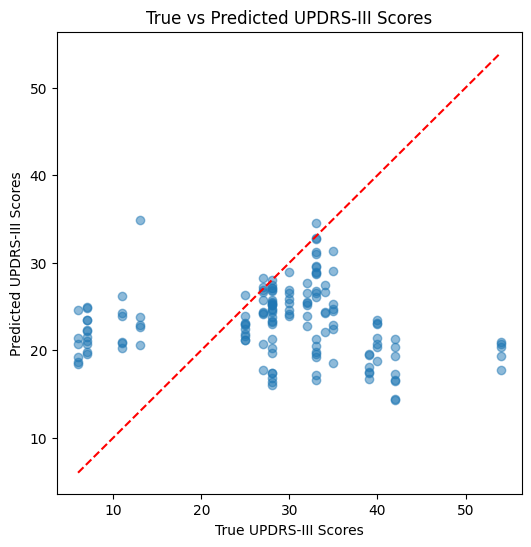

In [77]:

plt.figure(figsize=(6,6))
plt.scatter(labels_test, y_pred_test, alpha=0.5)
plt.plot([min(labels_test), max(labels_test)], [min(labels_test), max(labels_test)], '--r')  # Diagonal line
plt.xlabel("True UPDRS-III Scores")
plt.ylabel("Predicted UPDRS-III Scores")
plt.title("True vs Predicted UPDRS-III Scores")
plt.show()


In [91]:
bins = [0, 10, 20, 30, np.inf]  
labels = [0, 1, 2, 3]  

# Convert UPDRS scores into categories
train_patient_features["UPDRS_Class"] = np.digitize(train_patient_features["UPDRS_III"], bins=bins, right=True) - 1
val_patient_features["UPDRS_Class"] = np.digitize(val_patient_features["UPDRS_III"], bins=bins, right=True) - 1
test_patient_features["UPDRS_Class"] = np.digitize(test_patient_features["UPDRS_III"], bins=bins, right=True) - 1

print(train_patient_features["UPDRS_Class"].value_counts())


UPDRS_Class
 2    32
 3    18
 1    16
 0     4
-1     1
Name: count, dtype: int64


In [98]:
# Convert to DataFrame for merging
window_labels = pd.DataFrame({"SubID": sub_ids_train})

# Merge windows with their respective UPDRS classes
window_labels = window_labels.merge(train_patient_features[["SubID", "UPDRS_Class"]], on="SubID", how="left")

# Extract labels for training
train_labels = window_labels["UPDRS_Class"].values
val_labels = pd.DataFrame({"SubID": sub_ids_val}).merge(
    val_patient_features[["SubID", "UPDRS_Class"]], on="SubID", how="left")["UPDRS_Class"].values
test_labels = pd.DataFrame({"SubID": sub_ids_test}).merge(
    test_patient_features[["SubID", "UPDRS_Class"]], on="SubID", how="left")["UPDRS_Class"].values

# Print to verify correct shape
print("Train Labels Shape:", train_labels.shape)  # Should match windows_train.shape[0]
print("Validation Labels Shape:", val_labels.shape)
print("Test Labels Shape:", test_labels.shape)


Train Labels Shape: (483,)
Validation Labels Shape: (129,)
Test Labels Shape: (149,)


In [94]:
# Modify the output layer for multi-class classification
output = layers.Dense(4, activation='softmax')(merged)  # 4 classes

# Create Model
model = models.Model(inputs=[input_raw, input_fft, input_time], outputs=output)

# Compile the model for multi-class classification
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 300, 12)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 300, 32)   │      5,760 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 300, 32)   │          0 │ lstm_4[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, 48)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_8       │ (None, 84)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 16)        │      3,136 │ dropout_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 64)        │      3,136 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 32)        │      2,720 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 16)        │          0 │ lstm_5[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 64)        │          0 │ dense_8[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 32)        │          0 │ dense_9[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 112)       │          0 │ dropout_11[0][0], │
│ (Concatenate)       │                   │            │ dropout_12[0][0], │
│                     │                   │            │ dropout_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 64)        │      7,232 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 64)        │          0 │ dense_10[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 4)         │        260 │ dropout_14[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 22,244 (86.89 KB)

 Trainable params: 22,244 (86.89 KB)

 Non-trainable params: 0 (0.00 B)

In [108]:
history = model.fit(
    [windows_train, X_fft_train, X_raw_train], train_labels,
    validation_data=([windows_val, X_fft_val, X_raw_val], val_labels),
    epochs=50, batch_size=32, callbacks=[early_stopping, reduce_lr]
)


ValueError: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 478, 478, 478
'y' sizes: 483


In [ ]:
# Normalize signal per each patient
# Include UPDRS -> 5 classes [0-5-10-15 ...] -> Regression -> same barplot of updrs for output 
# How the patient was classified (by its windows, barplots of # of pd, control per patient)
# TUG test used 


In [ ]:
# -------------------------------
# Feature Extraction Functions
# -------------------------------

def entropy(signal):
    """Spectral entropy calculation"""
    psd = np.abs(np.fft.fft(signal))**2
    psd_norm = psd / np.sum(psd)  # Normalize
    return -np.sum(psd_norm * np.log2(psd_norm + 1e-12))

def lumpiness(signal, window=10):
    """Variance of sliding window variances"""
    num_windows = len(signal) // window
    window_vars = [np.var(signal[i*window:(i+1)*window]) for i in range(num_windows)]
    return np.var(window_vars)

def stationary_measure(signal, window=10):
    """Variance of sliding window means"""
    num_windows = len(signal) // window
    window_means = [np.mean(signal[i*window:(i+1)*window]) for i in range(num_windows)]
    return np.var(window_means)

def crossing_points(signal):
    """Counts zero-crossing points"""
    mean_val = np.mean(signal)
    return np.sum(np.diff(np.sign(signal - mean_val)) != 0)

def flat_spots(signal):
    """Finds longest flat segment"""
    bins = np.histogram(signal, bins=10)[0]
    return np.max(bins)

def mean_tkeo(signal):
    """Mean Teager-Kaiser Energy Operator"""
    return np.mean(signal[:-2]**2 - signal[1:-1] * signal[2:])

def rolling_variance_change(signal, window=10):
    """Computes rolling variance change"""
    roll_var = pd.Series(signal).rolling(window).var()
    return np.max(np.abs(np.diff(roll_var.dropna())))

def level_shift(signal, window=10):
    """Computes level shift using rolling mean"""
    roll_mean = pd.Series(signal).rolling(window).mean()
    return np.max(np.abs(np.diff(roll_mean.dropna())))

def autocorrelation(signal, lag=1):
    """Computes autocorrelation at lag 1"""
    return np.corrcoef(signal[:-lag], signal[lag:])[0, 1] if len(signal) > lag else np.nan

def coefficient_of_variation(signal):
    """Computes coefficient of variation"""
    return (np.std(signal) / np.mean(signal)) * 100 if np.mean(signal) != 0 else 0

def zero_crossing_rate(signal):
    """Computes Zero-Crossing Rate (ZCR)"""
    return np.sum(np.diff(np.sign(signal)) != 0) / len(signal)

def mean_teager_kaiser(signal):
    """Computes Mean Teager-Kaiser Energy Operator"""
    return np.mean(signal[:-2]**2 - signal[1:-1] * signal[2:])



In [ ]:
# -------------------------------
# Single Axis Feature Extraction
# -------------------------------

def extract_single_axis_features(signal, axis_name):
    """Extracts features for a single accelerometer/gyroscope axis"""
    
    # Basic Statistics
    mean_val = np.mean(signal)
    std_val = np.std(signal)
    skew_val = skew(signal)
    kurt_val = kurtosis(signal)
    
    quantiles = np.percentile(signal, [0, 10, 25, 50, 75, 90, 100])
    
    # Derived Features
    entropy_val = entropy(signal)
    lumpiness_val = lumpiness(signal)
    stationary_val = stationary_measure(signal)
    crossing_val = crossing_points(signal)
    flat_spots_val = flat_spots(signal)
    mean_tkeo_val = mean_tkeo(signal)
    rolling_var_change_val = rolling_variance_change(signal)
    level_shift_val = level_shift(signal)
    autocorr_val = autocorrelation(signal)
    coeff_var_val = coefficient_of_variation(signal)
    zero_crossing_val = zero_crossing_rate(signal)

    # Pack features
    feature_dict = {
        f"mean_{axis_name}": mean_val,
        f"std_{axis_name}": std_val,
        f"skew_{axis_name}": skew_val,
        f"kurt_{axis_name}": kurt_val,
        f"entropy_{axis_name}": entropy_val,
        f"lumpiness_{axis_name}": lumpiness_val,
        f"stationary_{axis_name}": stationary_val,
        f"crossing_{axis_name}": crossing_val,
        f"flat_spots_{axis_name}": flat_spots_val,
        f"mean_tkeo_{axis_name}": mean_tkeo_val,
        f"rolling_var_change_{axis_name}": rolling_var_change_val,
        f"level_shift_{axis_name}": level_shift_val,
        f"autocorr_{axis_name}": autocorr_val,
        f"coeff_var_{axis_name}": coeff_var_val,
        f"zero_crossing_{axis_name}": zero_crossing_val,
        **{f"q{idx}_{axis_name}": quantiles[idx] for idx in range(len(quantiles))}
    }
    
    return feature_dict



In [ ]:
# -------------------------------
# Apply Feature Extraction to Windowed Data
# -------------------------------

def extract_features_from_windows(windows):
    """
    Extracts features from windowed gait data.
    """
    num_windows, _, num_features = windows.shape
    feature_list = []
    
    for i in range(num_windows):
        feature_dict = {}

        # Extract features per axis
        for j in range(num_features):
            feature_dict.update(extract_single_axis_features(windows[i, :, j], f"axis_{j}"))

        feature_list.append(feature_dict)

    return pd.DataFrame(feature_list)

In [ ]:
# -------------------------------
# Apply to Training, Validation, and Test Data
# -------------------------------

features_train = extract_features_from_windows(windows_train)
features_val = extract_features_from_windows(windows_val)
features_test = extract_features_from_windows(windows_test)


Classification Report:
               precision    recall  f1-score   support

           0       0.32      0.32      0.32        22
           1       0.88      0.88      0.88       127

    accuracy                           0.80       149
   macro avg       0.60      0.60      0.60       149
weighted avg       0.80      0.80      0.80       149



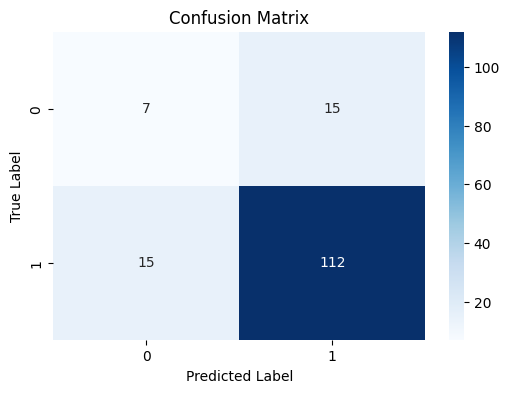

ROC-AUC Score: 0.6684


In [ ]:
# Apply SMOTE to balance class distribution
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(features_train, labels_train)

# Train RF with balanced data
clf = RandomForestClassifier(random_state=42, class_weight="balanced", n_estimators=100)
clf.fit(X_train_resampled, y_train_resampled)

y_pred = clf.predict(features_test)
print("Classification Report:\n", classification_report(labels_test, y_pred))


conf_matrix = confusion_matrix(labels_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

roc_auc = roc_auc_score(labels_test, y_prob)
print(f"ROC-AUC Score: {roc_auc:.4f}")


Classification Report:
               precision    recall  f1-score   support

           0       0.27      0.27      0.27        22
           1       0.87      0.87      0.87       127

    accuracy                           0.79       149
   macro avg       0.57      0.57      0.57       149
weighted avg       0.79      0.79      0.79       149



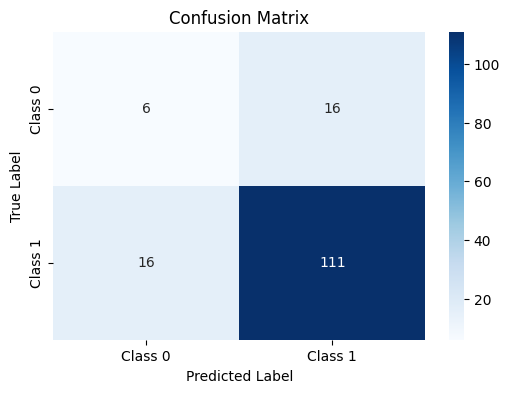

ROC-AUC Score: 0.7126


In [ ]:
scale_pos_weight = len(y_train_resampled[y_train_resampled == 0]) / len(y_train_resampled[y_train_resampled == 1])

# -------------------------------
# Train XGBoost with scale_pos_weight
# -------------------------------
clf_xgb = XGBClassifier(
    scale_pos_weight=scale_pos_weight,  
    max_depth=10,  
    learning_rate=0.05,  
    n_estimators=200,  
    subsample=0.8,  
    colsample_bytree=0.8,  
    eval_metric="logloss",
    random_state=42
)

clf_xgb.fit(X_train_resampled, y_train_resampled)

# -------------------------------
# Make Predictions
# -------------------------------
y_pred = clf_xgb.predict(features_test)
y_prob = clf_xgb.predict_proba(features_test)[:, 1]  # Probabilities for ROC-AUC

# -------------------------------
# Classification Report
# -------------------------------
print("Classification Report:\n", classification_report(labels_test, y_pred))

# -------------------------------
# Confusion Matrix
# -------------------------------
conf_matrix = confusion_matrix(labels_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# -------------------------------
# Compute ROC-AUC Score
# -------------------------------
roc_auc = roc_auc_score(labels_test, y_prob)
print(f"ROC-AUC Score: {roc_auc:.4f}")


In [ ]:
import pywt

wavelet_name = 'morl'  # Morlet wavelet
fs = 300  # Window size (300 samples per window)
scales = np.arange(1, fs)  # Range of scales for wavelet transform

def convert_to_cwt(windows):
    """
    Converts time-series windows into wavelet scalograms (images).

    """
    num_windows, _, num_features = windows.shape
    X_cwt = np.ndarray(shape=(num_windows, fs-1, fs-1, num_features))

    for i in range(num_windows):
        if i % 100 == 0:
            print(f"Processing window {i}/{num_windows}...")
        for j in range(num_features):
            signal = windows[i, :, j]
            coeffs, _ = pywt.cwt(signal, scales, wavelet_name, 1)  # Apply CWT
            X_cwt[i, :, :, j] = coeffs[:, :fs-1]  # Store transformed scalogram
    return X_cwt

X_train_cwt = convert_to_cwt(windows_train)
X_val_cwt = convert_to_cwt(windows_val)
X_test_cwt = convert_to_cwt(windows_test)

print("CWT Train shape:", X_train_cwt.shape)
print("CWT Val shape:", X_val_cwt.shape)
print("CWT Test shape:", X_test_cwt.shape)


Processing window 0/483...
Processing window 100/483...
Processing window 200/483...
Processing window 300/483...
Processing window 400/483...
Processing window 0/129...
Processing window 100/129...
Processing window 0/149...
Processing window 100/149...
CWT Train shape: (483, 299, 299, 12)
CWT Val shape: (129, 299, 299, 12)
CWT Test shape: (149, 299, 299, 12)


In [ ]:
num_features = 12  
model = keras.models.Sequential([
    # First CNN layer
    keras.layers.Conv2D(32, kernel_size=(3,3), activation="relu", input_shape=(299, 299, num_features)),
    keras.layers.MaxPooling2D(pool_size=(2,2)),

    # Second CNN layer
    keras.layers.Conv2D(64, kernel_size=(3,3), activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2,2)),

    # Third CNN layer
    keras.layers.Conv2D(128, kernel_size=(3,3), activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2,2)),

    # Flatten the feature maps
    keras.layers.Flatten(),
    
    # Fully connected layers
    keras.layers.Dense(300, activation="relu"),                 
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")  
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 297, 297, 32)   │         3,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 148, 148, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 146, 146, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 73, 73, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 71, 71, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 35, 35, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 156800)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 300)            │    47,040,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,166,341 (179.93 MB)

 Trainable params: 47,166,341 (179.93 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train CNN on wavelet-transformed gait windows
history = model.fit(
    X_train_cwt, labels_train,
    epochs=20, batch_size=32,
    validation_data=(X_val_cwt, labels_val)
)


Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.8145 - loss: 1.4495 - val_accuracy: 0.8605 - val_loss: 0.4732
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.8773 - loss: 0.4199 - val_accuracy: 0.8605 - val_loss: 0.4433
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.8595 - loss: 0.4189 - val_accuracy: 0.8605 - val_loss: 0.4979
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.8576 - loss: 0.4103 - val_accuracy: 0.8140 - val_loss: 0.5333
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.8886 - loss: 0.3268 - val_accuracy: 0.7829 - val_loss: 0.5533
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.8832 - loss: 0.3004 - val_accuracy: 0.7597 - val_loss: 0.6804
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.8971 - loss: 0.2724 - val_accuracy: 0.8450 - val_loss: 0.5689
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.9196 - loss: 0.1992 - val_accuracy: 0.7907 - val_loss:

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 367ms/step - accuracy: 0.8649 - loss: 0.5747
Test Accuracy: 0.8121
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 328ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.36      0.36      0.36        22
           1       0.89      0.89      0.89       127

    accuracy                           0.81       149
   macro avg       0.63      0.63      0.63       149
weighted avg       0.81      0.81      0.81       149



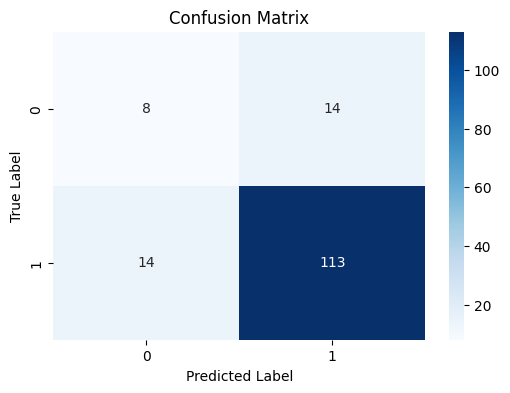

ROC-AUC Score: 0.6636


In [ ]:
test_loss, test_acc = model.evaluate(X_test_cwt, labels_test)
print(f"Test Accuracy: {test_acc:.4f}")

y_pred_prob = model.predict(X_test_cwt)
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary labels

print("Classification Report:\n", classification_report(labels_test, y_pred))


conf_matrix = confusion_matrix(labels_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

roc_auc = roc_auc_score(labels_test, y_pred_prob)
print(f"ROC-AUC Score: {roc_auc:.4f}")

In [ ]:
X_train = windows_train
y_train = labels_train

X_val = windows_val
y_val = labels_val

X_test = windows_test
y_test = labels_test


In [ ]:
# Define input shape: (window_size, num_features)
input_shape = (300, 12)

# Build the model
model = Sequential([
    # 1D CNN for feature extraction
    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', input_shape=input_shape),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    
    # LSTM for temporal dependencies
    Bidirectional(LSTM(64, return_sequences=True)),  
    Bidirectional(LSTM(32)),

    # Fully connected layers
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


c:\Users\35262\.conda\envs\fogenv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 300, 64)        │         2,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 150, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 150, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 75, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 75, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 171,329 (669.25 KB)

 Trainable params: 171,329 (669.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
history = model.fit(
    X_train, y_train, 
    epochs=30,  # Adjust based on validation performance
    batch_size=32,  # Adjust based on memory availability
    validation_data=(X_val, y_val),
    verbose=1
)

# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")


Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 145ms/step - accuracy: 0.8163 - loss: 0.5329 - val_accuracy: 0.8605 - val_loss: 0.4040
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.8876 - loss: 0.3690 - val_accuracy: 0.8605 - val_loss: 0.4046
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.8518 - loss: 0.4555 - val_accuracy: 0.8605 - val_loss: 0.4064
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.8852 - loss: 0.3697 - val_accuracy: 0.8605 - val_loss: 0.4044
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.8535 - loss: 0.4498 - val_accuracy: 0.8605 - val_loss: 0.4041
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.8837 - loss: 0.3650 - val_accuracy: 0.8605 - val_loss: 0.4056
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.8779 - loss: 0.3653 - val_accuracy: 0.8605 - val_loss: 0.4080
Epoch 8/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.8528 - loss: 0.4358 - val_accuracy: 0.8605 -

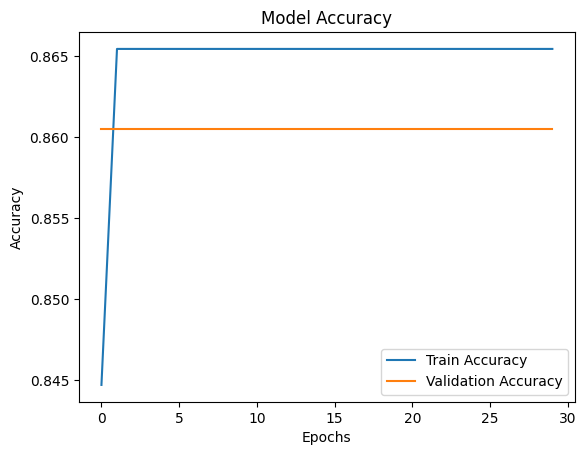

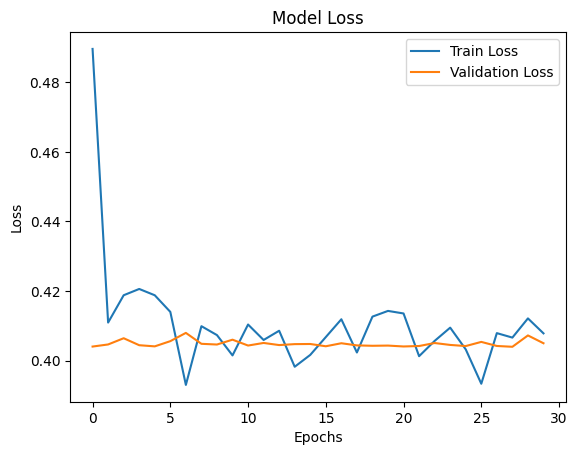

In [ ]:
# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
history = model.fit(X_train, y_train, epochs=30, batch_size=32, 
                    validation_data=(X_val, y_val), verbose=1)


In [ ]:
# Hyperparameters
input_size = 12  # Number of features (e.g., 12 for your accelerometer and gyroscope data)
hidden_size = 64  # Number of hidden units in LSTM
num_layers = 2  # Number of LSTM layers
num_classes = 1  # Binary classification (0 or 1)
learning_rate = 0.001
num_epochs = 50
batch_size = 32

In [ ]:
# Initialize the model
model = LSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)

# Loss and optimizer
criterion = nn.BCELoss()  # Binary cross-entropy loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    for batch_data, batch_labels in train_loader:
        # Forward pass
        outputs = model(batch_data)
        loss = criterion(outputs.squeeze(), batch_labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(val_data)
        val_loss = criterion(val_outputs.squeeze(), val_labels)
        val_preds = (val_outputs > 0.5).float()
        val_accuracy = (val_preds == val_labels).float().mean()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Val Accuracy: {val_accuracy.item():.4f}')



Epoch [1/50], Loss: 0.4225, Val Loss: 0.4767, Val Accuracy: 0.8605
Epoch [2/50], Loss: 0.1166, Val Loss: 0.4162, Val Accuracy: 0.8605
Epoch [3/50], Loss: 0.7569, Val Loss: 0.4040, Val Accuracy: 0.8605
Epoch [4/50], Loss: 0.6986, Val Loss: 0.4048, Val Accuracy: 0.8605
Epoch [5/50], Loss: 0.1532, Val Loss: 0.4042, Val Accuracy: 0.8605
Epoch [6/50], Loss: 1.3482, Val Loss: 0.4052, Val Accuracy: 0.8605
Epoch [7/50], Loss: 0.1984, Val Loss: 0.4067, Val Accuracy: 0.8605
Epoch [8/50], Loss: 0.1743, Val Loss: 0.4047, Val Accuracy: 0.8605
Epoch [9/50], Loss: 0.1488, Val Loss: 0.4047, Val Accuracy: 0.8605
Epoch [10/50], Loss: 0.1296, Val Loss: 0.4041, Val Accuracy: 0.8605
Epoch [11/50], Loss: 0.8396, Val Loss: 0.4042, Val Accuracy: 0.8605
Epoch [12/50], Loss: 0.8161, Val Loss: 0.4044, Val Accuracy: 0.8605
Epoch [13/50], Loss: 0.1549, Val Loss: 0.4042, Val Accuracy: 0.8605
Epoch [14/50], Loss: 0.1426, Val Loss: 0.4048, Val Accuracy: 0.8605
Epoch [15/50], Loss: 0.1431, Val Loss: 0.4042, Val Accura

In [ ]:
# Testing
model.eval()
with torch.no_grad():
    test_outputs = model(test_data)
    test_preds = (test_outputs > 0.5).float().cpu().numpy()
    test_labels = test_labels.cpu().numpy()

# Print classification report and confusion matrix
print("Classification Report:")
print(classification_report(test_labels, test_preds))
print("Confusion Matrix:")
print(confusion_matrix(test_labels, test_preds))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        22
         1.0       0.85      1.00      0.92       127

    accuracy                           0.85       149
   macro avg       0.43      0.50      0.46       149
weighted avg       0.73      0.85      0.78       149

Confusion Matrix:
[[  0  22]
 [  0 127]]


c:\Users\35262\.conda\envs\fogenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\35262\.conda\envs\fogenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\35262\.conda\envs\fogenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Convert to PyTorch tensors
X_train, y_train = torch.tensor(windows_train, dtype=torch.float32), torch.tensor(labels_train, dtype=torch.long)
X_val, y_val = torch.tensor(windows_val, dtype=torch.float32), torch.tensor(labels_val, dtype=torch.long)
X_test, y_test = torch.tensor(windows_test, dtype=torch.float32), torch.tensor(labels_test, dtype=torch.long)

# Create PyTorch Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TimeSeriesDataset(X_train, y_train)
val_dataset = TimeSeriesDataset(X_val, y_val)
test_dataset = TimeSeriesDataset(X_test, y_test)

# Handle class imbalance using WeightedRandomSampler
class_counts = torch.bincount(y_train)
weights = 1.0 / class_counts.float()
sample_weights = weights[y_train]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(y_train), replacement=True)

# Data Loaders
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]  # Get the last timestep output
        out = self.fc(lstm_out)
        return out

# Define model
input_dim = 12  # Number of features per timestep
hidden_dim = 64
num_layers = 2
output_dim = 2  # Binary classification

model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss function with class weighting
class_counts = torch.bincount(y_train)
class_weights = 1.0 / class_counts.float()
class_weights = class_weights.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct, total = 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}, Train Accuracy: {train_acc:.4f}")


Epoch 1, Loss: 9.8143, Train Accuracy: 0.5093
Epoch 2, Loss: 6.9123, Train Accuracy: 0.4865
Epoch 3, Loss: 6.3376, Train Accuracy: 0.5052
Epoch 4, Loss: 6.3972, Train Accuracy: 0.4990
Epoch 5, Loss: 6.3204, Train Accuracy: 0.5280
Epoch 6, Loss: 6.4406, Train Accuracy: 0.4907
Epoch 7, Loss: 6.8807, Train Accuracy: 0.4865
Epoch 8, Loss: 6.4564, Train Accuracy: 0.4907
Epoch 9, Loss: 6.7239, Train Accuracy: 0.4969
Epoch 10, Loss: 6.9850, Train Accuracy: 0.4534
Epoch 11, Loss: 8.0588, Train Accuracy: 0.5031
Epoch 12, Loss: 6.6905, Train Accuracy: 0.4928
Epoch 13, Loss: 6.2786, Train Accuracy: 0.4969
Epoch 14, Loss: 8.2211, Train Accuracy: 0.4886
Epoch 15, Loss: 6.8923, Train Accuracy: 0.4762
Epoch 16, Loss: 8.3290, Train Accuracy: 0.4907
Epoch 17, Loss: 6.6568, Train Accuracy: 0.4928
Epoch 18, Loss: 8.1437, Train Accuracy: 0.4969
Epoch 19, Loss: 6.7286, Train Accuracy: 0.4948
Epoch 20, Loss: 8.2574, Train Accuracy: 0.4658


In [ ]:
def evaluate_model(model, dataloader):
    model.eval()
    all_preds, all_labels = [], []
    all_probs = []  # Store softmax probabilities

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)  # Raw logits

            probs = torch.nn.functional.softmax(outputs, dim=1)  # Apply softmax
            _, preds = torch.max(outputs, 1)  # Get class predictions

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())  # Store probabilities

    acc = accuracy_score(all_labels, all_preds)
    logloss = log_loss(all_labels, all_probs)  # Use probabilities instead of class labels
    conf_matrix = confusion_matrix(all_labels, all_preds)

    return acc, logloss, conf_matrix

val_acc, val_loss, val_conf_matrix = evaluate_model(model, val_loader)
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation Log Loss: {val_loss:.4f}")
print(f"Confusion Matrix:\n {val_conf_matrix}")


Validation Accuracy: 0.1395
Validation Log Loss: 1.5253
Confusion Matrix:
 [[ 18   0]
 [111   0]]


c:\Users\35262\.conda\envs\fogenv\lib\site-packages\sklearn\metrics\_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


In [ ]:
# just to test if windows are correclty assigned
train_p0 = train_data[train_data.SubID=='ND7142_V2']
train_p0_id = train_p0.SubID.iloc[0]
train_p0_wins = sub_ids_train.count(train_p0_id)
print(f'train_p0: {len(train_p0)}, sub_id = {train_p0_id}, # wins= {train_p0_wins}')

train_p1 = train_data[train_data.SubID=='ND0015_V8']
train_p1_id = train_p1.SubID.iloc[0]
train_p1_wins = sub_ids_train.count(train_p1_id)
print(f'train_p1: {len(train_p1)}, sub_id = {train_p1_id}, # wins= {train_p1_wins}')


val_p0 =val_data[val_data.SubID=='ND3521_V2']
val_p0_id = val_p0.SubID.iloc[0]
val_p0_wins = sub_ids_val.count(val_p0_id)
print(f'val_p0: {len(val_p0)}, sub_id = {val_p0_id}, # wins= {val_p0_wins}')

val_p1 = val_data[val_data.SubID=='ND0027_V8']
val_p1_id = val_p1.SubID.iloc[0]
val_p1_wins = sub_ids_val.count(val_p1_id)
print(f'val_p1: {len(val_p1)}, sub_id = {val_p1_id}, # wins= {val_p1_wins}')

test_p0 = test_data[test_data.SubID=='ND3522_V2']
test_p0_id = test_p0.SubID.iloc[0]
test_p0_wins = sub_ids_test.count(test_p0_id)
print(f'test_p0: {len(test_p0)}, sub_id = {test_p0_id}, # wins= {test_p0_wins}')

test_p1 = test_data[test_data.SubID=='ND0026_V8']
test_p1_id = test_p1.SubID.iloc[0]
test_p1_wins = sub_ids_test.count(test_p1_id)
print(f'test_p1: {len(test_p1)}, sub_id = {test_p1_id}, # wins= {test_p1_wins}')


train_p0: 946, sub_id = ND7142_V2, # wins= 5
train_p1: 994, sub_id = ND0015_V8, # wins= 5
val_p0: 1144, sub_id = ND3521_V2, # wins= 6
val_p1: 3091, sub_id = ND0027_V8, # wins= 19
test_p0: 1065, sub_id = ND3522_V2, # wins= 6
test_p1: 1265, sub_id = ND0026_V8, # wins= 7


### Use Raw Windowed Data Directly

In [ ]:
# Train Random Forest on extracted features
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(train_features, labels_train)

# Predict on validation set
val_preds = clf.predict(val_features)

# Evaluate model
val_acc = accuracy_score(labels_val, val_preds)
print(f'Validation Accuracy: {val_acc:.4f}')


Validation Accuracy: 0.8682


In [ ]:
# Predict on the test set
test_preds = clf.predict(test_features)

# Evaluate test performance
test_acc = accuracy_score(labels_test, test_preds)
print(f'Test Accuracy: {test_acc:.4f}')


Test Accuracy: 0.8121


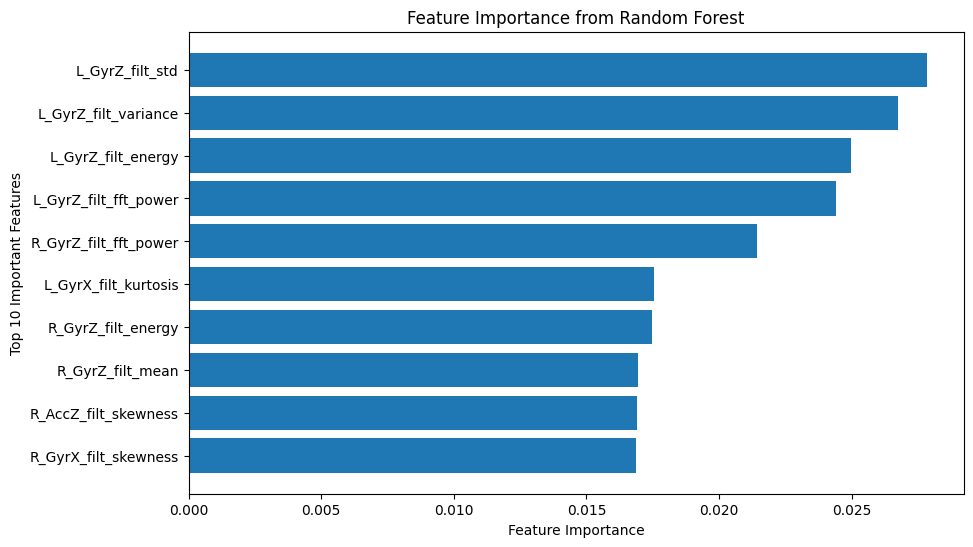

In [ ]:
# Get feature importance
feature_importances = clf.feature_importances_
feature_names = train_features.columns  # Assuming train_features is a DataFrame

# Sort features by importance
sorted_idx = np.argsort(feature_importances)[::-1]

# Plot
plt.figure(figsize=(10, 6))
plt.barh([feature_names[i] for i in sorted_idx[:10]], feature_importances[sorted_idx[:10]])
plt.xlabel("Feature Importance")
plt.ylabel("Top 10 Important Features")
plt.title("Feature Importance from Random Forest")
plt.gca().invert_yaxis()
plt.show()


In [ ]:
top_n = 10  # Adjust based on importance scores
top_features = [feature_names[i] for i in sorted_idx[:top_n]]

# Filter datasets
train_features_selected = train_features[top_features]
val_features_selected = val_features[top_features]
test_features_selected = test_features[top_features]


In [ ]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(clf, train_features_selected, labels_train, cv=10, scoring='accuracy')
print(f"Mean CV Accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")


Mean CV Accuracy: 0.8551 ± 0.0186


In [ ]:
clf.fit(train_features_selected, labels_train)

# Predict on test set
test_preds = clf.predict(test_features_selected)

# Evaluate
test_acc = accuracy_score(labels_test, test_preds)
print(f"Final Test Accuracy: {test_acc:.4f}")


Final Test Accuracy: 0.7651


In [ ]:
from sklearn.svm import SVC
from xgboost import XGBClassifier

models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel='rbf', probability=True),
    "XGBoost": XGBClassifier(eval_metric='logloss')

}

for name, model in models.items():
    model.fit(train_features_selected, labels_train)
    preds = model.predict(val_features_selected)
    acc = accuracy_score(labels_val, preds)
    print(f"{name} Validation Accuracy: {acc:.4f}")


Random Forest Validation Accuracy: 0.8682
SVM Validation Accuracy: 0.8605
XGBoost Validation Accuracy: 0.8527


In [ ]:
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel='rbf', probability=True),
    "XGBoost": XGBClassifier(eval_metric='logloss')
}

# Train and evaluate each model
for name, model in models.items():
    model.fit(train_features, labels_train)
    preds = model.predict(val_features)
    val_acc = accuracy_score(labels_val, preds)
    print(f"{name} Validation Accuracy: {val_acc:.4f}")

    # Compute log loss for probabilistic models
    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(val_features)
        log_loss_val = log_loss(labels_val, probs)
        print(f"{name} Log Loss: {log_loss_val:.4f}")

    print()


Random Forest Validation Accuracy: 0.8682
Random Forest Log Loss: 0.6134

SVM Validation Accuracy: 0.8605
SVM Log Loss: 0.4302

XGBoost Validation Accuracy: 0.8450
XGBoost Log Loss: 0.6549



In [ ]:
# Apply FFT without max_freq (keeps full spectrum)
fft_train_full, freq_bins_train_full = apply_fft_to_windows(windows_train, sampling_rate=100)
fft_val_full, freq_bins_val_full = apply_fft_to_windows(windows_val, sampling_rate=100)
fft_test_full, freq_bins_test_full = apply_fft_to_windows(windows_test, sampling_rate=100)

print(f"FFT Full Shape (Train): {fft_train_full.shape}")  
print(f"FFT Full Shape (Validation): {fft_val_full.shape}")  
print(f"FFT Full Shape (Test): {fft_test_full.shape}")  

FFT Full Shape (Train): (483, 151, 12)
FFT Full Shape (Validation): (129, 151, 12)
FFT Full Shape (Test): (149, 151, 12)


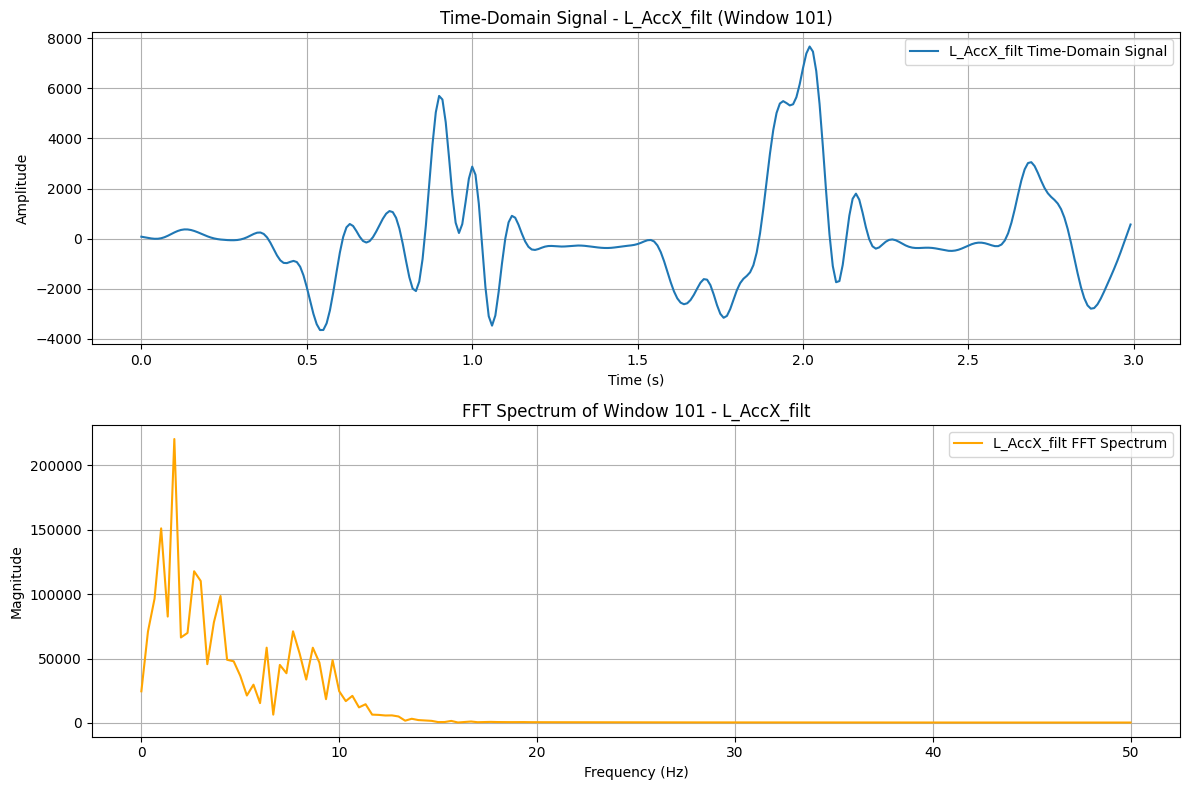

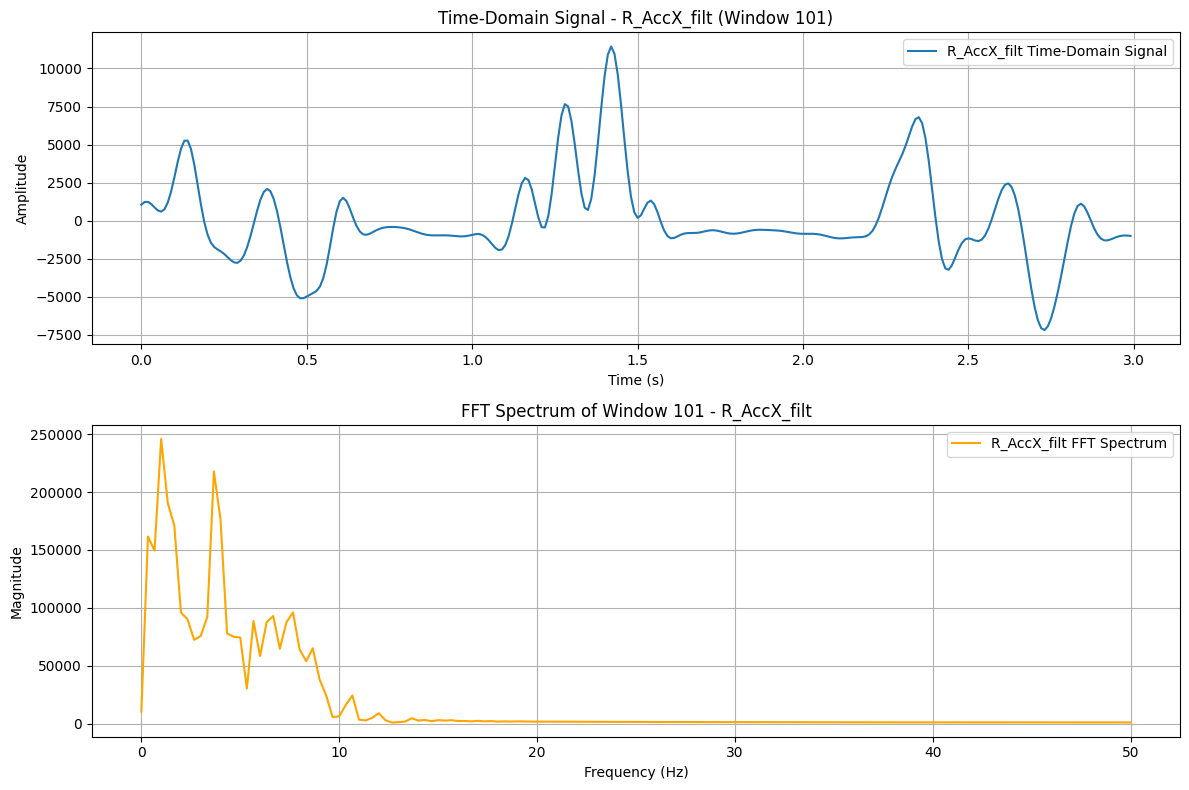

In [ ]:
# Plotting the n-th window for the first feature (e.g., L_AccX_filt)
plot_time_and_fft(windows_train, fft_train_full, freq_bins_train_full, window_idx=100, feature_idx=0, feature_name='L_AccX_filt')

# Plotting the n-th window for another feature (e.g., R_AccX_filt)
plot_time_and_fft(windows_train, fft_train_full, freq_bins_train_full, window_idx=100, feature_idx=6, feature_name='R_AccX_filt')

In [ ]:
# Apply filtering to Train, Validation, and Test sets
fft_train_filtered, freq_bins_train_filtered = filter_fft_bands(fft_train_full, freq_bins_train_full, max_freq=15)
fft_val_filtered, freq_bins_val_filtered = filter_fft_bands(fft_val_full, freq_bins_val_full, max_freq=15)
fft_test_filtered, freq_bins_test_filtered = filter_fft_bands(fft_test_full, freq_bins_test_full, max_freq=15)

print(f"FFT Filtered Shape (Train): {fft_train_filtered.shape}")  
print(f"FFT Filtered Shape (Validation): {fft_val_filtered.shape}")  
print(f"FFT Filtered Shape (Test): {fft_test_filtered.shape}")  



FFT Filtered Shape (Train): (483, 46, 12)
FFT Filtered Shape (Validation): (129, 46, 12)
FFT Filtered Shape (Test): (149, 46, 12)


In [ ]:
# Normalize the Filtered FFT Data

scaler = MinMaxScaler()

# Flatten data for normalization, then reshape it back
fft_train_scaled = scaler.fit_transform(fft_train_filtered.reshape(-1, fft_train_filtered.shape[-1])).reshape(fft_train_filtered.shape)
fft_val_scaled = scaler.transform(fft_val_filtered.reshape(-1, fft_val_filtered.shape[-1])).reshape(fft_val_filtered.shape)
fft_test_scaled = scaler.transform(fft_test_filtered.reshape(-1, fft_test_filtered.shape[-1])).reshape(fft_test_filtered.shape)

print(f"FFT Normalized Shape (Train): {fft_train_scaled.shape}")  
print(f"FFT Normalized Shape (Validation): {fft_val_scaled.shape}")  
print(f"FFT Normalized Shape (Test): {fft_test_scaled.shape}")  

FFT Normalized Shape (Train): (483, 46, 12)
FFT Normalized Shape (Validation): (129, 46, 12)
FFT Normalized Shape (Test): (149, 46, 12)


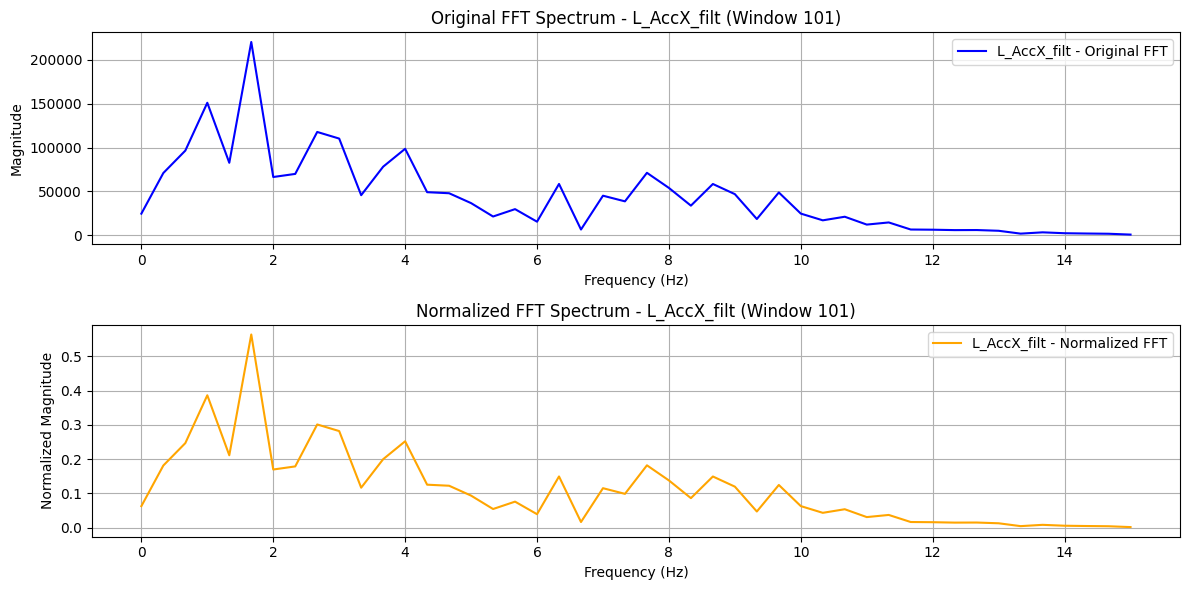

In [ ]:
def plot_fft_before_after(original_fft, normalized_fft, freq_bins, window_idx=0, feature_idx=0, feature_name="Feature"):
    """
    Plots FFT magnitude before and after normalization for a specific window & feature.

    """
    # Extract the selected feature and window
    original_spectrum = original_fft[window_idx, :, feature_idx]
    normalized_spectrum = normalized_fft[window_idx, :, feature_idx]

    # Plot the spectra
    plt.figure(figsize=(12, 6))

    # Original FFT
    plt.subplot(2, 1, 1)
    plt.plot(freq_bins, original_spectrum, label=f"{feature_name} - Original FFT", color='blue')
    plt.title(f"Original FFT Spectrum - {feature_name} (Window {window_idx+1})")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.legend()
    plt.grid()

    # Normalized FFT
    plt.subplot(2, 1, 2)
    plt.plot(freq_bins, normalized_spectrum, label=f"{feature_name} - Normalized FFT", color='orange')
    plt.title(f"Normalized FFT Spectrum - {feature_name} (Window {window_idx+1})")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Normalized Magnitude")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

# Example usage
plot_fft_before_after(fft_train_filtered, fft_train_scaled, freq_bins_train_filtered, window_idx=100, feature_idx=0, feature_name="L_AccX_filt")


In [ ]:
def extract_features_from_fft(fft_data):
    """
    Extracts statistical and power-related features from FFT data:
    - Mean Frequency
    - Variance of Frequency Components
    - Spectral Entropy
    - Total Power
    - Relative Power
    """
    # Mean Frequency
    mean_freq = np.mean(fft_data, axis=1)

    # Variance of Frequency Components
    var_freq = np.var(fft_data, axis=1)

    # Spectral Entropy
    entropy_freq = -np.sum(fft_data * np.log(fft_data + 1e-10), axis=1)

    # Total Power (Sum of Squared FFT Values)
    total_power = np.sum(fft_data ** 2, axis=1)

    # Relative Power (Each Frequency’s Contribution to Total Power)
    relative_power = total_power / (np.sum(total_power, axis=1, keepdims=True) + 1e-10)

    # Stack all extracted features
    return np.hstack([mean_freq, var_freq, entropy_freq, total_power, relative_power])

# Apply feature extraction to all datasets
fft_train_features = extract_features_from_fft(fft_train_scaled)
fft_val_features = extract_features_from_fft(fft_val_scaled)
fft_test_features = extract_features_from_fft(fft_test_scaled)

# Print feature shapes
print("Extracted Features Shape (Train):", fft_train_features.shape)
print("Extracted Features Shape (Validation):", fft_val_features.shape)
print("Extracted Features Shape (Test):", fft_test_features.shape)


Extracted Features Shape (Train): (483, 60)
Extracted Features Shape (Validation): (129, 60)
Extracted Features Shape (Test): (149, 60)


C:\Users\35262\AppData\Local\Temp\ipykernel_16412\1965494282.py:17: RuntimeWarning: invalid value encountered in log
  entropy_freq = -np.sum(fft_data * np.log(fft_data + 1e-10), axis=1)


In [ ]:
def extract_features_from_fft(fft_data):
    """
    Extracts additional features from FFT data: Mean, Variance, Entropy.
    
    Parameters:
    - fft_data: (num_samples, num_freq_bins, num_features)
    
    Returns:
    - Extracted features as (num_samples, num_features * 3)
    """
    mean_freq = np.mean(fft_data, axis=1)  # Mean Frequency
    var_freq = np.var(fft_data, axis=1)  # Variance of Frequency Components
    entropy_freq = -np.sum(fft_data * np.log(fft_data + 1e-10), axis=1)  # Spectral Entropy
    
    return np.hstack([mean_freq, var_freq, entropy_freq])  # Combine features

# Apply feature extraction to all datasets
fft_train_features = extract_features_from_fft(fft_train_scaled)
fft_val_features = extract_features_from_fft(fft_val_scaled)
fft_test_features = extract_features_from_fft(fft_test_scaled)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dense, Dropout, BatchNormalization

def build_bi_lstm_model(input_shape, num_classes=2):
    """
    Builds a Bi-LSTM model for time-series classification.

    Parameters:
    - input_shape: Tuple (sequence_length, feature_dim)
    - num_classes: Number of output classes (default: 2 for binary classification)

    Returns:
    - Compiled Bi-LSTM model
    """
    inputs = Input(shape=input_shape)

    # Bi-LSTM Layer
    x = Bidirectional(LSTM(128, return_sequences=True))(inputs)
    x = Dropout(0.3)(x)  # Dropout for regularization

    # Second Bi-LSTM Layer
    x = Bidirectional(LSTM(64, return_sequences=False))(x)  # No sequences output

    # Fully Connected Layers
    x = Dropout(0.3)(x)
    x = Dense(32, activation="relu")(x)
    x = Dropout(0.3)(x)

    # Output Layer
    output_activation = "softmax" if num_classes > 2 else "sigmoid"
    outputs = Dense(num_classes, activation=output_activation)(x)

    # Build and Compile Model
    model = Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss="binary_crossentropy" if num_classes == 2 else "categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model

# Define model
input_shape = (61, 12)  # (sequence_length, feature_dim)
num_classes = 2  # Binary classification

model = build_bi_lstm_model(input_shape, num_classes)
model.summary()


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 61, 12)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ (None, 61, 256)        │       144,384 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 61, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_12                │ (None, 128)            │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 312,930 (1.19 MB)

 Trainable params: 312,930 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Convert labels to one-hot encoding
y_train_cat = tf.keras.utils.to_categorical(labels_train, num_classes)
y_val_cat = tf.keras.utils.to_categorical(labels_val, num_classes)
y_test_cat = tf.keras.utils.to_categorical(labels_test, num_classes)

In [ ]:
# Compute Class Weights
y_train_labels = np.argmax(y_train, axis=1)  # Convert one-hot labels to single-class format
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train_labels), y=y_train_labels)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

print(f"Class Weights: {class_weights_dict}")

# Define Early Stopping
early_stopping = EarlyStopping(
    monitor="val_loss",  # Stop when validation loss stops improving
    patience=5,  # Number of epochs to wait before stopping
    restore_best_weights=True  # Keep the best weights after stopping
)

# Train Model
history = model.fit(
    fft_train_scaled, y_train_cat,
    validation_data=(fft_val_scaled, y_val_cat),
    epochs=50,
    batch_size=32,
    class_weight=class_weights_dict,  # Handling class imbalance
    callbacks=[early_stopping]  # Prevent overfitting
)

# Evaluate Model
test_loss, test_acc = model.evaluate(fft_test_scaled, y_test_cat)
print(f"Test Accuracy: {test_acc:.4f}")

Class Weights: {0: np.float64(3.766990291262136), 1: np.float64(0.5765230312035661)}
Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.6643 - loss: 0.6399 - val_accuracy: 0.1685 - val_loss: 0.7157
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.3115 - loss: 0.6852 - val_accuracy: 0.8652 - val_loss: 0.6723
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.5964 - loss: 0.6830 - val_accuracy: 0.4494 - val_loss: 0.6965
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.5279 - loss: 0.6704 - val_accuracy: 0.6067 - val_loss: 0.6815
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.5388 - loss: 0.6445 - val_accuracy: 0.8764 - val_loss: 0.5980
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.8923 - loss: 0.6658 - val_accuracy: 0.8652 - val_loss: 0.6466
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.6309 - loss: 0.6534 - val_accuracy: 0.3933 - val_loss: 0.7556
Epoch 8/50
11/11 ━━━━━━━━━

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step

Evaluation Summary:
               precision    recall  f1-score   support

     Class 0       0.10      0.07      0.08        14
     Class 1       0.86      0.90      0.88        86

    accuracy                           0.78       100
   macro avg       0.48      0.48      0.48       100
weighted avg       0.75      0.78      0.76       100



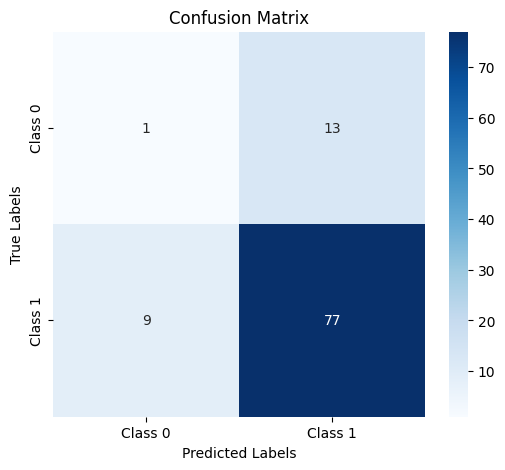

In [ ]:
# Get Model Predictions
y_pred_probs = model.predict(fft_test_scaled)

# Convert Probabilities to Class Labels
y_pred = np.argmax(y_pred_probs, axis=1)  # Softmax → Class labels
y_true = np.argmax(y_test_cat, axis=1)  # Convert One-Hot to Class Labels

# Compute Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Print Classification Report
print("\nEvaluation Summary:\n", classification_report(y_true, y_pred, target_names=["Class 0", "Class 1"]))

# Plot Confusion Matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

plot_confusion_matrix(conf_matrix, ["Class 0", "Class 1"])


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step

Evaluation Summary:
               precision    recall  f1-score   support

     Class 0       0.29      0.41      0.34        34
     Class 1       0.89      0.83      0.86       204

    accuracy                           0.77       238
   macro avg       0.59      0.62      0.60       238
weighted avg       0.81      0.77      0.79       238



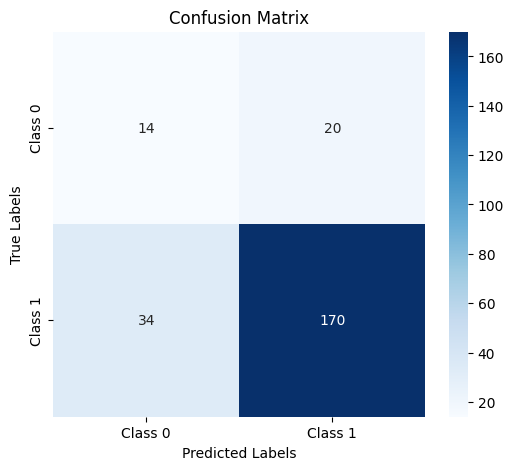

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get Model Predictions
y_pred_probs = model.predict(fft_test_scaled)
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels
y_true = np.argmax(y_test, axis=1)  # Convert one-hot labels to class labels

# Compute Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Print Classification Report
print("\nEvaluation Summary:\n", classification_report(y_true, y_pred, target_names=["Class 0", "Class 1"]))

# Plot Confusion Matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

plot_confusion_matrix(conf_matrix, ["Class 0", "Class 1"])


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

def group_windows_by_patient(sub_ids, fft_data, labels, sequence_length=5):
    """
    Groups consecutive windows by patient into fixed-size sequences.

    Parameters:
    - sub_ids: List of patient IDs for each window
    - fft_data: FFT-transformed data (shape: [num_windows, num_freq_bins, num_features])
    - labels: One-hot encoded labels for each window
    - sequence_length: Number of windows to group together

    Returns:
    - X_seq: Padded sequences of windows
    - y_seq: Labels (majority class of the grouped windows)
    """
    grouped_data = {}
    
    # Organize windows by patient
    for i, pid in enumerate(sub_ids):
        if pid not in grouped_data:
            grouped_data[pid] = {"windows": [], "labels": []}
        grouped_data[pid]["windows"].append(fft_data[i])
        grouped_data[pid]["labels"].append(labels[i])

    X_seq = []
    y_seq = []

    # Process each patient
    for pid, data in grouped_data.items():
        patient_windows = np.array(data["windows"])
        patient_labels = np.array(data["labels"])

        # Create overlapping sequences
        for i in range(0, len(patient_windows) - sequence_length + 1, sequence_length):
            seq = patient_windows[i:i + sequence_length]
            label = np.argmax(np.mean(patient_labels[i:i + sequence_length], axis=0))  # Majority class

            X_seq.append(seq)
            y_seq.append(label)

    # Convert to NumPy arrays and pad shorter sequences
    X_seq = pad_sequences(X_seq, maxlen=sequence_length, padding="post", dtype="float32")
    y_seq = np.array(y_seq)

    return np.array(X_seq), y_seq

# Apply grouping to train, validation, and test sets
sequence_length = 5  # Group 5 consecutive windows together
X_train_seq, y_train_seq = group_windows_by_patient(sub_ids_train, fft_train_scaled, y_train, sequence_length)
X_val_seq, y_val_seq = group_windows_by_patient(sub_ids_val, fft_val_scaled, y_val, sequence_length)
X_test_seq, y_test_seq = group_windows_by_patient(sub_ids_test, fft_test_scaled, y_test, sequence_length)

print(f"New Train Shape: {X_train_seq.shape}")  # Should be (num_sequences, sequence_length, num_freq_bins, num_features)
print(f"New Label Shape: {y_train_seq.shape}")  # Should be (num_sequences,)


New Train Shape: (121, 5, 31, 12)
New Label Shape: (121,)


In [ ]:
from tensorflow.keras.layers import Reshape

def build_bi_lstm_sequence_model(input_shape, num_classes=2):
    """
    Builds a Bi-LSTM model for sequential multi-window time-series classification.
    
    Parameters:
    - input_shape: Tuple (sequence_length, num_freq_bins, num_features)
    - num_classes: Number of output classes

    Returns:
    - Compiled Bi-LSTM model
    """
    inputs = Input(shape=input_shape)  # (sequence_length, num_freq_bins, num_features)
    
    # ✅ Reshape to make it (sequence_length, features)
    reshaped = Reshape((input_shape[0], input_shape[1] * input_shape[2]))(inputs)

    # Bi-LSTM layers
    x = Bidirectional(LSTM(128, return_sequences=True))(reshaped)
    x = Dropout(0.3)(x)
    x = Bidirectional(LSTM(64, return_sequences=False))(x)

    # Fully Connected Layers
    x = Dense(32, activation="relu")(x)
    x = Dropout(0.3)(x)

    # Output Layer
    output_activation = "softmax" if num_classes > 2 else "sigmoid"
    outputs = Dense(num_classes, activation=output_activation)(x)

    model = Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss="binary_crossentropy" if num_classes == 2 else "categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model

# ✅ Update input shape after reshaping
sequence_input_shape = (sequence_length, 31, 12)  # (num_windows_per_seq, num_freq_bins, num_features)
model = build_bi_lstm_sequence_model(sequence_input_shape, num_classes)
model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 5, 31, 12)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 5, 372)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 5, 256)         │       513,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 5, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 681,570 (2.60 MB)

 Trainable params: 681,570 (2.60 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Convert labels to categorical format (One-Hot Encoding)
y_train_seq_cat = tf.keras.utils.to_categorical(y_train_seq, num_classes)
y_val_seq_cat = tf.keras.utils.to_categorical(y_val_seq, num_classes)
y_test_seq_cat = tf.keras.utils.to_categorical(y_test_seq, num_classes)

# Check shape
print(f"y_train_seq_cat shape: {y_train_seq_cat.shape}")
print(f"y_val_seq_cat shape: {y_val_seq_cat.shape}")
print(f"y_test_seq_cat shape: {y_test_seq_cat.shape}")


y_train_seq_cat shape: (121, 2)
y_val_seq_cat shape: (34, 2)
y_test_seq_cat shape: (37, 2)


In [ ]:
history = model.fit(
    X_train_seq, y_train_seq_cat,
    validation_data=(X_val_seq, y_val_seq_cat),
    epochs=50,
    batch_size=32,
    class_weight=class_weights_dict,  # Handling class imbalance
    callbacks=[early_stopping]
)

# Evaluate Model
test_loss, test_acc = model.evaluate(X_test_seq, y_test_seq_cat)
print(f"Test Accuracy: {test_acc:.4f}")


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 490ms/step - accuracy: 0.1948 - loss: 0.7209 - val_accuracy: 0.1765 - val_loss: 0.7216
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.2167 - loss: 0.6802 - val_accuracy: 0.2353 - val_loss: 0.7136
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.3392 - loss: 0.6584 - val_accuracy: 0.4412 - val_loss: 0.6936
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4245 - loss: 0.6769 - val_accuracy: 0.2647 - val_loss: 0.7293
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.2777 - loss: 0.6856 - val_accuracy: 0.2647 - val_loss: 0.7521
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.3484 - loss: 0.6377 - val_accuracy: 0.4118 - val_loss: 0.7028
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.4146 - loss: 0.6234 - val_accuracy: 0.5000 - val_loss: 0.7039
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step - accuracy: 0.4833 - loss: 0.6248 - val_accuracy: 0.7647 - val_loss: 0.64

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Get model predictions (probabilities)
y_pred_probs = model.predict(X_test_seq)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)  # Converts softmax output to class labels

# Convert one-hot test labels back to class indices
y_true = np.argmax(y_test_seq_cat, axis=1)


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 901ms/stepWARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001F7AD025000> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step  


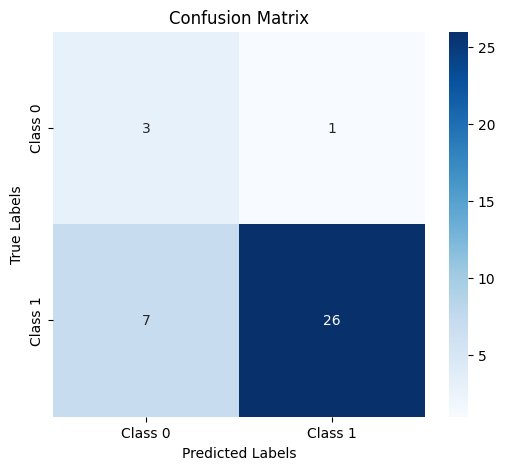

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the Confusion Matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

plot_confusion_matrix(conf_matrix, class_names)


In [ ]:
# Parameters
target_size = 100  # Resampled window size
height_threshold = 0.4  # Height threshold for peaks
distance_between_peaks = 50  # Minimum distance between peaks
features = ['L_Acc_mag','L_Gyr_mag', 'R_Acc_mag', 'R_Gyr_mag']

In [ ]:
# let's reduce number of patinet to see how it works
train_data_ex = train_data[train_data.SubID.isin(['ND0015_V8','ND0027_V8','ND0028_V8', 'ND0045_V8','ND0055_V8'])].reset_index(drop=True)
train_data_ex

SubID  Counter    L_Acc_mag   R_Acc_mag    L_Gyr_mag   R_Gyr_mag  \
0     ND0015_V8  3767194   124.850285  150.361904    76.531999   21.404195   
1     ND0015_V8  3767195   129.493404  152.128690    90.131818   21.496397   
2     ND0015_V8  3767196   127.370801  153.696171   105.782958   21.515164   
3     ND0015_V8  3767197   120.395938  154.799144   120.374226   21.380495   
4     ND0015_V8  3767198   115.409428  155.332452   130.759623   21.055849   
...         ...      ...          ...         ...          ...         ...   
7838  ND0055_V8  4117201  2133.360232  140.314656  1969.596938  202.402030   
7839  ND0055_V8  4117202  1877.699174  141.395572  1476.498057  186.692566   
7840  ND0055_V8  4117203  1665.501576  140.727340  1053.892794  173.039043   
7841  ND0055_V8  4117204  1418.821079  139.571459   965.960369  161.812969   
7842  ND0055_V8  4117205  1127.581388  138.626371  1151.025681  152.713236   

      Binary_Diagnosis  
0                    1  
1                    1  
2                    1  
3                    1  
4                    1  
...                ...  
7838                 1  
7839                 1  
7840                 1  
7841                 1  
7842                 1  

[7843 rows x 7 columns]

In [ ]:
p_ND0015_V8 = train_data[train_data.SubID=='ND0015_V8'].reset_index(drop=True)
p_ND0015_V8

SubID  Counter   L_Acc_mag    R_Acc_mag   L_Gyr_mag   R_Gyr_mag  \
0    ND0015_V8  3767194  124.850285   150.361904   76.531999   21.404195   
1    ND0015_V8  3767195  129.493404   152.128690   90.131818   21.496397   
2    ND0015_V8  3767196  127.370801   153.696171  105.782958   21.515164   
3    ND0015_V8  3767197  120.395938   154.799144  120.374226   21.380495   
4    ND0015_V8  3767198  115.409428   155.332452  130.759623   21.055849   
..         ...      ...         ...          ...         ...         ...   
989  ND0015_V8  3768183  561.636213  2091.792426  499.255190  729.110449   
990  ND0015_V8  3768184  554.480761  2214.246925  464.260698  395.742775   
991  ND0015_V8  3768185  550.576052  2003.333689  422.970823  440.819260   
992  ND0015_V8  3768186  550.582098  1586.653240  372.689908  709.592847   
993  ND0015_V8  3768187  559.553861  1128.917726  317.142224  914.913488   

     Binary_Diagnosis  
0                   1  
1                   1  
2                   1  
3                   1  
4                   1  
..                ...  
989                 1  
990                 1  
991                 1  
992                 1  
993                 1  

[994 rows x 7 columns]

In [ ]:

# Convert to numpy arrays
X_train = np.array(all_resampled_windows)  # Shape: (num_windows, target_size, num_signals)
y_train = np.array(all_labels)

print(f"Final shape of X_train: {X_train.shape}")
print(f"Final shape of y_train: {y_train.shape}")

Final shape of X_train: (2323, 100, 4)
Final shape of y_train: (2323,)


In [ ]:
# Convert to numpy arrays
X_test = np.array(all_resampled_windows)  # Shape: (num_windows, target_size, num_signals)
y_test = np.array(all_labels)

print(f"Final shape of X_train: {X_test.shape}")
print(f"Final shape of y_train: {y_test.shape}")

Final shape of X_train: (595, 100, 4)
Final shape of y_train: (595,)


In [ ]:
# Flatten the data
X_train_flattened = X_train.reshape(X_train.shape[0], -1)  # Shape: (num_samples, 100 * 4)
X_test_flattened = X_test.reshape(X_test.shape[0], -1)     # Shape: (num_samples, 100 * 4)

print("Shape of X_train_flattened:", X_train_flattened.shape)
print("Shape of X_test_flattened:", X_test_flattened.shape)


Shape of X_train_flattened: (2323, 400)
Shape of X_test_flattened: (595, 400)


In [ ]:
# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = {0: class_weights[0], 1: class_weights[1]}
print("Class Weights:", class_weights)


Class Weights: {0: np.float64(3.416176470588235), 1: np.float64(0.5857286938981341)}


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout

def build_dense_model(input_shape):
    """
    Build a fully connected neural network with batch normalization and dropout layers.
    """
    model = Sequential()

    # Input layer and first dense block
    model.add(Dense(512, activation='relu', input_shape=(input_shape,)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Second dense block
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Third dense block
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Fourth dense block
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))  

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    print(model.summary())

    return model


In [ ]:
input_shape = X_train_flat.shape[1]  
model = build_dense_model(input_shape)

history = model.fit(
    X_train_flat, y_train,
    epochs=20,
    batch_size=32,
    verbose=1
)

test_loss, test_accuracy = model.evaluate(X_test_flat, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


y_pred_probs = model.predict(X_test_flat)
y_pred = (y_pred_probs > 0.5).astype(int)  

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

c:\Users\35262\.conda\envs\fogenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_179 (Dense)               │ (None, 512)            │       205,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_91          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_154 (Dropout)           │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_180 (Dense)               │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_92          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_155 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_181 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_93          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_156 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_182 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_94          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_157 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_183 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 381,697 (1.46 MB)

 Trainable params: 379,777 (1.45 MB)

 Non-trainable params: 1,920 (7.50 KB)

None
Epoch 1/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5399 - loss: 0.8639
Epoch 2/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7090 - loss: 0.5926
Epoch 3/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7910 - loss: 0.4970
Epoch 4/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8203 - loss: 0.4552
Epoch 5/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8425 - loss: 0.4238
Epoch 6/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8476 - loss: 0.4255
Epoch 7/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8495 - loss: 0.4215
Epoch 8/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8505 - loss: 0.4111
Epoch 9/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8471 - loss: 0.4031
Epoch 10/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8342 - loss: 0.4315
Epoch 11/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8411 - loss: 0.4077
Epoch 12/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8564

In [ ]:
# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(y_train), 
    y=y_train
)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Build the model
input_shape = X_train_flat.shape[1]  # Number of features
model = build_dense_model(input_shape)

# Train the model with class weights
history = model.fit(
    X_train_flat, y_train,
    epochs=20,
    batch_size=64,
    class_weight=class_weights_dict,  # Apply class weights here
    verbose=1
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_flat, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Generate classification metrics
from sklearn.metrics import classification_report, confusion_matrix

# Predict the test data
y_pred_probs = model.predict(X_test_flat)
y_pred = (y_pred_probs > 0.5).astype(int)  # Convert probabilities to binary predictions

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

c:\Users\35262\.conda\envs\fogenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_149 (Dense)               │ (None, 512)            │       205,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_67          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_130 (Dropout)           │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_150 (Dense)               │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_68          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_131 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_151 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_69          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_132 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_152 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_70          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_133 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_153 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 381,697 (1.46 MB)

 Trainable params: 379,777 (1.45 MB)

 Non-trainable params: 1,920 (7.50 KB)

None
Epoch 1/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5399 - loss: 0.8958
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6239 - loss: 0.6763
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7208 - loss: 0.5945
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7623 - loss: 0.5140
Epoch 5/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7885 - loss: 0.4828
Epoch 6/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8008 - loss: 0.4651
Epoch 7/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8281 - loss: 0.4319
Epoch 8/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8257 - loss: 0.4332
Epoch 9/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8300 - loss: 0.4316
Epoch 10/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8524 - loss: 0.3953
Epoch 11/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8486 - loss: 0.4033
Epoch 12/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8427

In [ ]:
from tensorflow.keras import layers, Model, Input
from tensorflow import keras

# Transformer Encoder
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    """
    Transformer Encoder Layer.
    
    Args:
        inputs: Input tensor.
        head_size: Size of each attention head.
        num_heads: Number of attention heads.
        ff_dim: Hidden layer size in feed-forward network.
        dropout: Dropout rate.

    Returns:
        Tensor output of the encoder layer.
    """
    # Multi-head Attention
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs  # Residual Connection

    # Feed-forward Network
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res  # Residual Connection

# Build Model
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    """
    Build the Transformer-based model.
    
    Args:
        input_shape: Shape of the input data.
        head_size: Size of each attention head.
        num_heads: Number of attention heads.
        ff_dim: Hidden layer size in feed-forward network.
        num_transformer_blocks: Number of transformer blocks.
        mlp_units: List of hidden layer sizes in the MLP.
        dropout: Dropout rate for transformer blocks.
        mlp_dropout: Dropout rate for MLP layers.

    Returns:
        Compiled Keras model.
    """
    inputs = Input(shape=input_shape)
    x = layers.Reshape((input_shape[0], 1))(inputs)  # Reshape to 3D for Conv1D
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_last")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)  # Binary classification
    return Model(inputs, outputs)

# Define Model Parameters
input_shape = (400,)  # Input shape for flat data
model = build_model(
    input_shape,
    head_size=64,  # Attention head size
    num_heads=2,   # Number of attention heads
    ff_dim=64,     # Feed-forward dimension
    num_transformer_blocks=2,  # Number of transformer blocks
    mlp_units=[64, 32],  # MLP layers
    mlp_dropout=0.3,
    dropout=0.25,
)

# Compile the Model
model.compile(
    loss="binary_crossentropy",  # Binary classification
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["accuracy"],
)

# Summary
model.summary()

# Callbacks
callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

# Train the Model
history = model.fit(
    X_train_flat, y_train,
    epochs=20,            # Number of epochs
    batch_size=64,        # Batch size
    callbacks=callbacks,
    verbose=1,            # Print training progress
)

# Evaluate on Test Data
test_loss, test_accuracy = model.evaluate(X_test_flat, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


Model: "functional_308"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_41      │ (None, 400)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 400, 1)    │          0 │ input_layer_41[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 400, 1)    │        897 │ reshape[0][0],    │
│ (MultiHeadAttentio… │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_123         │ (None, 400, 1)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 400, 1)    │          2 │ dropout_123[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_13 (Add)        │ (None, 400, 1)    │          0 │ layer_normalizat… │
│                     │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_31 (Conv1D)  │ (None, 400, 64)   │        128 │ add_13[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_124         │ (None, 400, 64)   │          0 │ conv1d_31[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_32 (Conv1D)  │ (None, 400, 1)    │         65 │ dropout_124[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 400, 1)    │          2 │ conv1d_32[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_14 (Add)        │ (None, 400, 1)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_13[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 400, 1)    │        897 │ add_14[0][0],     │
│ (MultiHeadAttentio… │                   │            │ add_14[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_126         │ (None, 400, 1)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 400, 1)    │          2 │ dropout_126[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_15 (Add)        │ (None, 400, 1)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_14[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_33 (Conv1D)  │ (None, 400, 64)   │        128 │ add_15[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_127         │ (None, 400, 64)   │          0 │ conv1d_33[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_34 (Conv1D)  │ (None, 400, 1)    │         65 │ dropout_127[0][0] │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 4,429 (17.30 KB)

 Trainable params: 4,429 (17.30 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 27s 527ms/step - accuracy: 0.8263 - loss: 0.6732
Epoch 2/20


c:\Users\35262\.conda\envs\fogenv\lib\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 20s 537ms/step - accuracy: 0.8565 - loss: 0.6548
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 20s 534ms/step - accuracy: 0.8567 - loss: 0.6333
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 20s 548ms/step - accuracy: 0.8519 - loss: 0.6114
Epoch 5/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 19s 522ms/step - accuracy: 0.8663 - loss: 0.5806
Epoch 6/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 19s 516ms/step - accuracy: 0.8460 - loss: 0.5616
Epoch 7/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 19s 507ms/step - accuracy: 0.8439 - loss: 0.5329
Epoch 8/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 19s 517ms/step - accuracy: 0.8603 - loss: 0.5018
Epoch 9/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 19s 517ms/step - accuracy: 0.8480 - loss: 0.4834
Epoch 10/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 19s 510ms/step - accuracy: 0.8538 - loss: 0.4613
Epoch 11/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 19s 510ms/step - accuracy: 0.8616 - loss: 0.4373
Epoch 12/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 19s 519ms/step - accuracy: 0.8338 - loss: 0.4641
Epoch 13/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 21s 573ms/st

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_flat, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Generate classification metrics
from sklearn.metrics import classification_report, confusion_matrix

# Predict the test data
y_pred_probs = model.predict(X_test_flat)
y_pred = (y_pred_probs > 0.5).astype(int)  # Convert probabilities to binary predictions

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.9658 - loss: 0.2299
Test Loss: 0.4345, Test Accuracy: 0.8454
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        92
           1       0.85      1.00      0.92       503

    accuracy                           0.85       595
   macro avg       0.42      0.50      0.46       595
weighted avg       0.71      0.85      0.77       595


Confusion Matrix:
[[  0  92]
 [  0 503]]


c:\Users\35262\.conda\envs\fogenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\35262\.conda\envs\fogenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\35262\.conda\envs\fogenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from imblearn.over_sampling import SMOTE

# Create SMOTE object
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_flat, y_train)

print(f"Balanced training data shape: {X_train_balanced.shape}, {y_train_balanced.shape}")


Balanced training data shape: (3966, 400), (3966,)


In [ ]:
# Build the improved model
oversampled_model = build_dense_model(input_shape=X_train_balanced.shape[1])

# Train the model on oversampled data
history = oversampled_model.fit(
    X_train_balanced, y_train_balanced,
    epochs=20,
    batch_size=32,
    verbose=1
)

# Evaluate on the test set
test_loss, test_accuracy = oversampled_model.evaluate(X_test_flat, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Classification Report
y_pred_probs = oversampled_model.predict(X_test_flat)
y_pred = (y_pred_probs > 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_122 (Dense)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_55          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_88 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_123 (Dense)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_56          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_89 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_124 (Dense)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_57          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_90 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_125 (Dense)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_58          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_91 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_126 (Dense)               │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5480 - loss: 0.8526
Epoch 2/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5816 - loss: 0.7174
Epoch 3/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6004 - loss: 0.6862
Epoch 4/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6258 - loss: 0.6450
Epoch 5/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6677 - loss: 0.6103
Epoch 6/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6850 - loss: 0.5991
Epoch 7/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6880 - loss: 0.5883
Epoch 8/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7494 - loss: 0.5208
Epoch 9/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7237 - loss: 0.5461
Epoch 10/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7616 - loss: 0.4906
Epoch 11/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7721 - loss: 0.4823
Epoch 12/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms

In [ ]:
# resampling each pateint into same number of rows.
# frequency, spectrum in time series transformation 

# not taking the mode
# with a presentation.
 
# shape : (number of windows of patients,100,12)

#p1:(10,100,12) -> flatten:(10,1200)
#p2: (4,100,12) -> flatten:(4,1200)


# x_trian.shape : number of windows 14 * 1200

In [ ]:
df_TUG.groupby('SubID').size().sort_values()
# train_data.groupby('SubID').size().sort_values()

SubID
ND0736_V4     725
ND0828_V2     744
ND0842_V2     764
ND0282_V7     793
ND0810_V2     793
             ... 
ND0614_V5    1956
ND0060_V8    2002
ND0385_V6    2242
ND0655_V4    2323
ND0027_V8    3091
Length: 112, dtype: int64

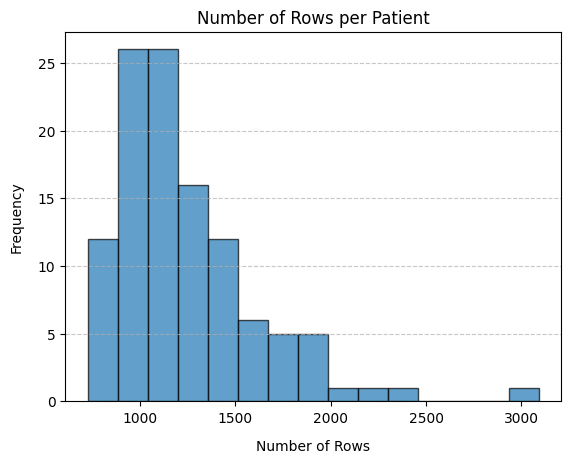

In [ ]:
rows_per_patient = df_TUG.groupby('SubID').size().sort_values()

plt.hist(rows_per_patient.values, bins='auto', alpha=0.7, edgecolor='black')

# Set the y-axis to show only discrete values
y_ticks = np.arange(0, plt.gca().get_ylim()[1] + 1, 5)  # Generate integer ticks
plt.yticks(y_ticks)

plt.title("Number of Rows per Patient")
plt.xlabel("Number of Rows", labelpad=10)
plt.ylabel("Frequency" , labelpad=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [ ]:
''' 
p_ND0027_V8 = df_TUG[df_TUG.SubID=='ND0027_V8'].reset_index(drop=True)
plot_signals(p_ND0027_V8,['L_AccX_filt','L_GyrX_filt','R_AccX_filt', 'R_GyrX_filt'])
plot_signals(p_ND0027_V8,['L_AccY_filt','L_GyrY_filt','R_AccY_filt', 'R_GyrY_filt'])
plot_signals(p_ND0027_V8,['L_AccZ_filt','L_GyrZ_filt','R_AccZ_filt', 'R_GyrZ_filt'])

'''

" \np_ND0027_V8 = df_TUG[df_TUG.SubID=='ND0027_V8'].reset_index(drop=True)\nplot_signals(p_ND0027_V8,['L_AccX_filt','L_GyrX_filt','R_AccX_filt', 'R_GyrX_filt'])\nplot_signals(p_ND0027_V8,['L_AccY_filt','L_GyrY_filt','R_AccY_filt', 'R_GyrY_filt'])\nplot_signals(p_ND0027_V8,['L_AccZ_filt','L_GyrZ_filt','R_AccZ_filt', 'R_GyrZ_filt'])\n\n"

In [ ]:
def create_fixed_windows(data, feature_columns, window_size):
    """
    Reshapes data into fixed windows of a specified length for each patient.

    Args:
    - data (pd.DataFrame): Original dataset with multiple patients.
    - feature_columns (list): List of feature column names to include.
    - window_size (int): Number of rows in each window.

    Returns:
    - tuple: (windows, labels, sub_ids)
      - windows (np.ndarray): Array of shape (num_windows, window_size, num_features).
      - labels (list): List of labels corresponding to each window.
      - sub_ids (list): List of SubIDs corresponding to each window.
    """
    all_windows = []
    all_labels = []
    all_sub_ids = []

    for patient_id, patient_data in data.groupby('SubID'):
        features = patient_data[feature_columns].values
        label = patient_data['Binary_Diagnosis'].iloc[0]  # Use the first label for all windows
        
        # Calculate the number of complete windows
        num_windows = len(features) // window_size
        
        # Create windows
        for i in range(num_windows):
            start = i * window_size
            end = start + window_size
            window = features[start:end]
            all_windows.append(window)
            all_labels.append(label)
            all_sub_ids.append(patient_id)
    
    return np.array(all_windows), np.array(all_labels), all_sub_ids


In [ ]:
# Define parameters
#FEATURE_COLUMNS = ['L_AccX_filt', 'L_AccY_filt', 'L_AccZ_filt',
#                   'L_GyrX_filt', 'L_GyrY_filt', 'L_GyrZ_filt',
#                   'R_AccX_filt', 'R_AccY_filt', 'R_AccZ_filt',
#                   'R_GyrX_filt', 'R_GyrY_filt', 'R_GyrZ_filt']

FEATURE_COLUMNS = [ 'L_Acc_mag', 'R_Acc_mag', 'L_Gyr_mag', 'R_Gyr_mag']

WINDOW_SIZE = 100

# Apply the function to train and test data
X_train, y_train, train_sub_ids = create_fixed_windows(train_data, FEATURE_COLUMNS, WINDOW_SIZE)
X_test, y_test, test_sub_ids = create_fixed_windows(test_data, FEATURE_COLUMNS, WINDOW_SIZE)

# Check results
print("X_train shape:", X_train.shape)  # (num_train_windows, 100, num_features)
print("y_train shape:", y_train.shape)

print("X_test shape:", X_test.shape)  # (num_test_windows, 100, num_features)
print("y_test shape:", y_test.shape)

X_train shape: (1071, 100, 4)
y_train shape: (1071,)
X_test shape: (261, 100, 4)
y_test shape: (261,)


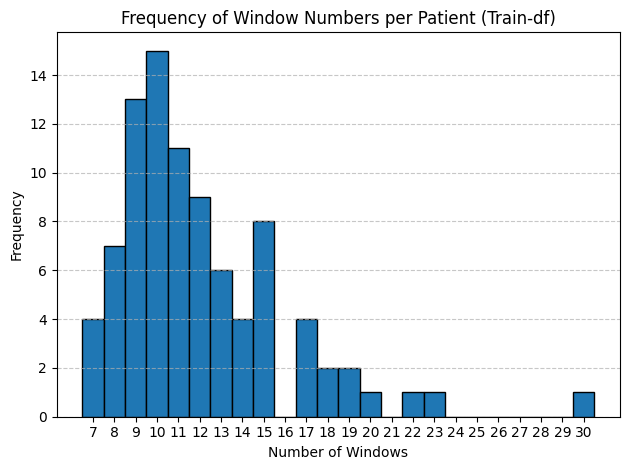

In [ ]:
train_subid_counts = Counter(train_sub_ids)
num_windows = list(train_subid_counts.values())
patients = list(train_subid_counts.keys())

# Plot frequency of window counts
plt.hist(num_windows, bins=range(min(num_windows), max(num_windows) + 2), edgecolor='black', align='left')
plt.title('Frequency of Window Numbers per Patient (Train-df)')
plt.xlabel('Number of Windows')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(range(min(num_windows), max(num_windows) + 1))
plt.tight_layout()
plt.show()

In [ ]:
sorted_items = sorted(train_subid_counts.items(), key=lambda x: x[1], reverse=True)

num_columns = 3

formatted_sorted_output = "\n".join(
    "  ".join(f"'{k}': {v}" for k, v in sorted_items[i:i + num_columns])
    for i in range(0, len(sorted_items), num_columns)
)

print(formatted_sorted_output)


'ND0027_V8': 30  'ND0655_V4': 23  'ND0385_V6': 22
'ND0060_V8': 20  'ND0614_V5': 19  'ND0688_V4': 19
'ND0497_V6': 18  'ND0787_V3': 18  'ND0045_V8': 17
'ND0163_V8': 17  'ND0545_V5': 17  'ND0860_V1': 17
'ND0075_V8': 15  'ND0132_V8': 15  'ND0405_V6': 15
'ND0536_V6': 15  'ND0551_V5': 15  'ND0597_V5': 15
'ND0620_V5': 15  'ND0777_V3': 15  'ND0137_V8': 14
'ND0429_V6': 14  'ND0482_V6': 14  'ND0746_V4': 14
'ND0114_V8': 13  'ND0396_V6': 13  'ND0690_V4': 13
'ND0714_V4': 13  'ND0822_V2': 13  'ND3016_V3': 13
'ND0028_V8': 12  'ND0095_V8': 12  'ND0437_V6': 12
'ND0468_V6': 12  'ND0564_V5': 12  'ND0584_V5': 12
'ND0613_V5': 12  'ND0720_V4': 12  'ND0877_V1': 12
'ND0172_V8': 11  'ND0394_V6': 11  'ND0595_V5': 11
'ND0654_V4': 11  'ND0722_V4': 11  'ND0814_V2': 11
'ND0827_V2': 11  'ND3017_V3': 11  'ND3466_V2': 11
'ND3521_V2': 11  'ND3706_V1': 11  'ND0070_V8': 10
'ND0199_V7': 10  'ND0289_V7': 10  'ND0340_V7': 10
'ND0702_V4': 10  'ND0708_V4': 10  'ND0765_V3': 10
'ND0780_V3': 10  'ND0806_V2': 10  'ND0819_V2': 10


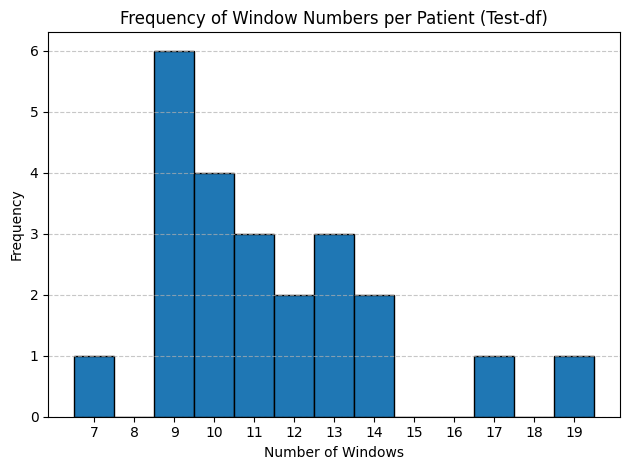

In [ ]:
test_subid_counts = Counter(test_sub_ids)
num_windows = list(test_subid_counts.values())
patients = list(test_subid_counts.keys())

# Plot frequency of window counts
plt.hist(num_windows, bins=range(min(num_windows), max(num_windows) + 2), edgecolor='black', align='left')
plt.title('Frequency of Window Numbers per Patient (Test-df)')
plt.xlabel('Number of Windows')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(range(min(num_windows), max(num_windows) + 1))
plt.tight_layout()
plt.show()

In [ ]:
'''
sorted_items = sorted(test_subid_counts.items(), key=lambda x: x[1], reverse=True)

num_columns = 3

formatted_sorted_output = "\n".join(
    "  ".join(f"'{k}': {v}" for k, v in sorted_items[i:i + num_columns])
    for i in range(0, len(sorted_items), num_columns)
)

print(formatted_sorted_output)
''' 

'\nsorted_items = sorted(test_subid_counts.items(), key=lambda x: x[1], reverse=True)\n\nnum_columns = 3\n\nformatted_sorted_output = "\n".join(\n    "  ".join(f"\'{k}\': {v}" for k, v in sorted_items[i:i + num_columns])\n    for i in range(0, len(sorted_items), num_columns)\n)\n\nprint(formatted_sorted_output)\n'

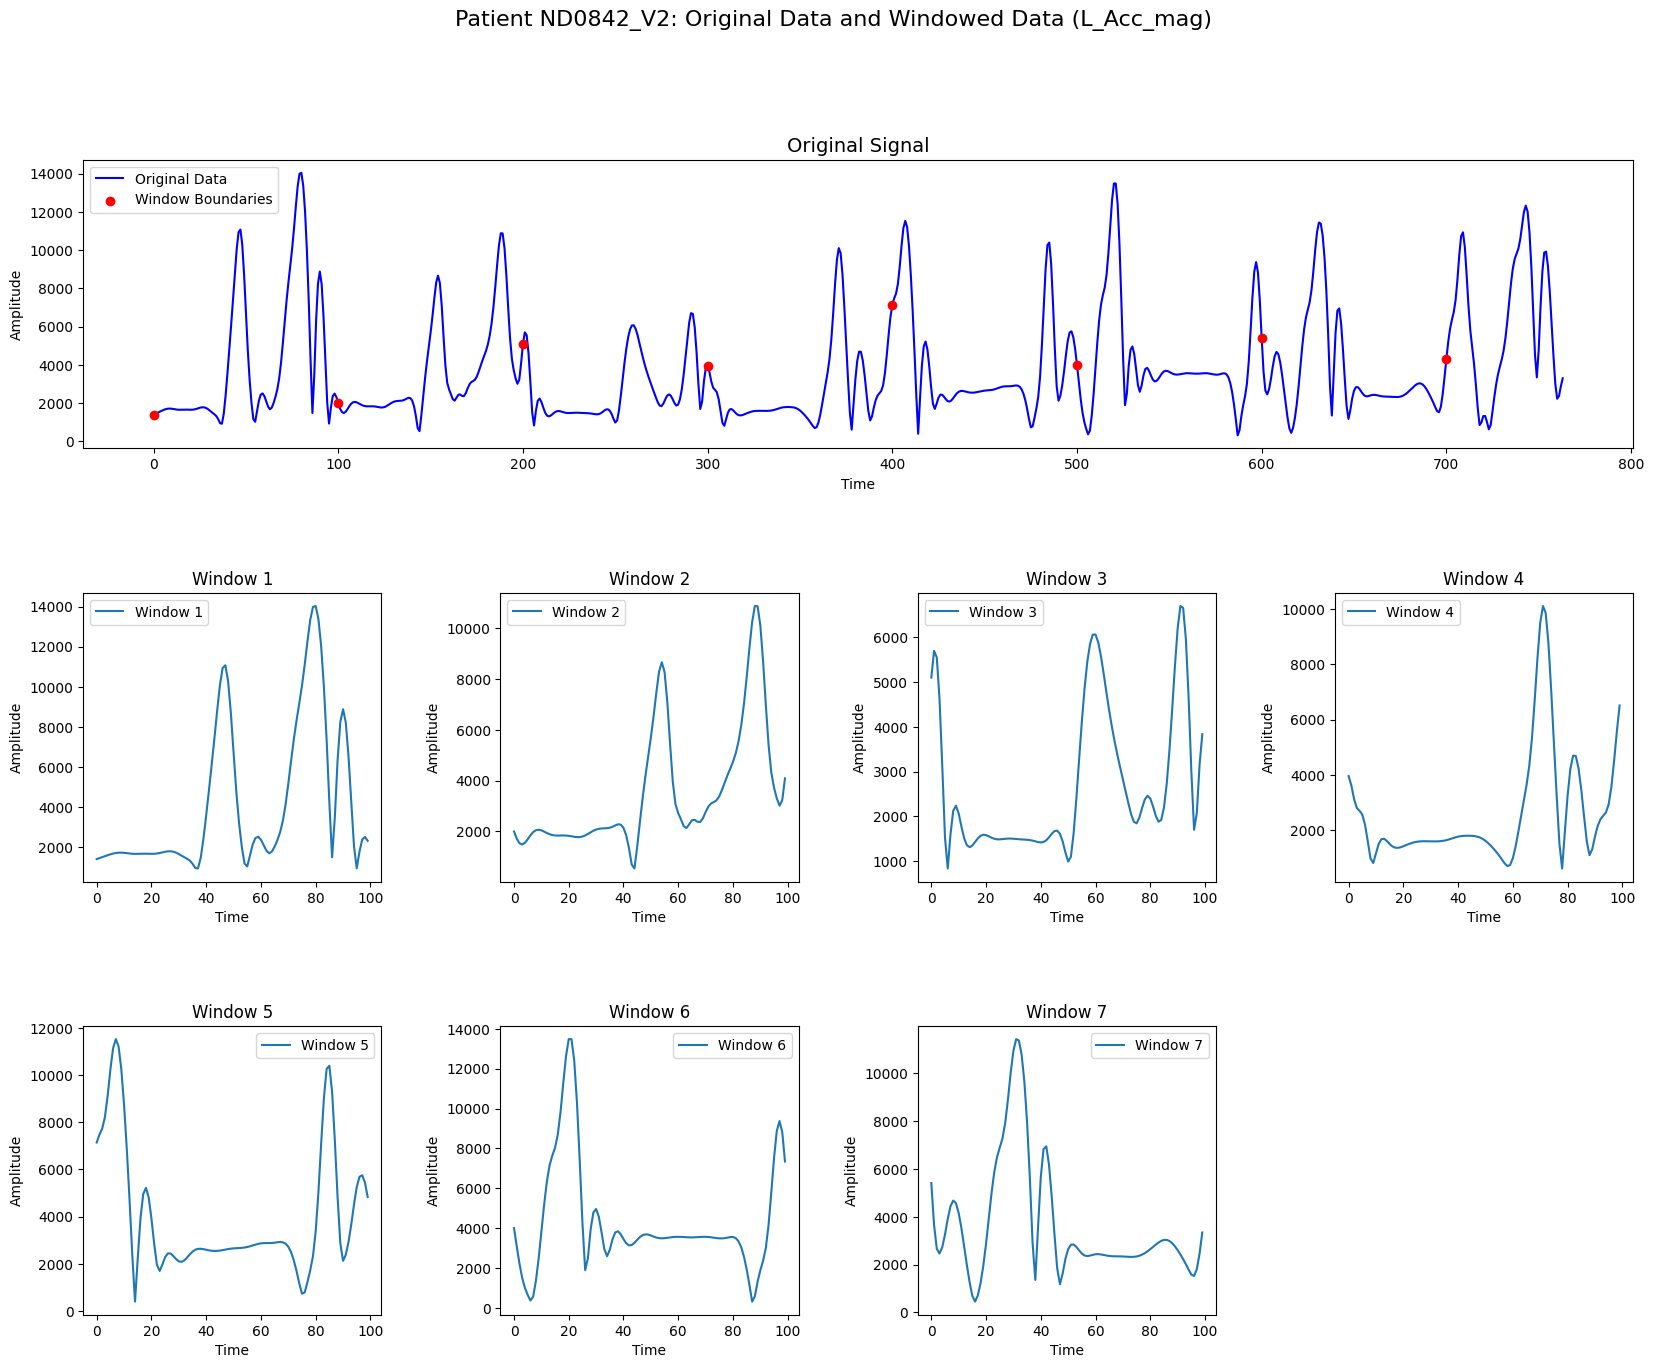

In [ ]:
patient_id = 'ND0842_V2'
feature_idx = 0
feature_name = FEATURE_COLUMNS[feature_idx]

original_feature_data = train_data[train_data['SubID'] == patient_id][feature_name].values
windowed_feature_data = X_train[
    [i for i, sub_id in enumerate(train_sub_ids) if sub_id == patient_id], :, feature_idx
]

# Calculate the red dot positions for window boundaries on the original data
window_starts = np.arange(0, len(original_feature_data), 100)  # Start of each window
window_points = original_feature_data[window_starts]  # Values at those points

# Plot the original data (long signal) and its 7 windows in a 3-row layout
fig = plt.figure(figsize=(20, 15))
grid = plt.GridSpec(3, 4, hspace=0.5, wspace=0.4)

# Original data (spanning the entire first row)
ax_original = fig.add_subplot(grid[0, :])
ax_original.plot(original_feature_data, label="Original Data", color='blue')
ax_original.scatter(window_starts, window_points, color='red', label="Window Boundaries", zorder=5)
ax_original.set_title("Original Signal", fontsize=14)
ax_original.set_xlabel("Time")
ax_original.set_ylabel("Amplitude")
ax_original.legend()

# Plot the first 4 windows in the second row
for idx in range(4):
    ax = fig.add_subplot(grid[1, idx])
    ax.plot(windowed_feature_data[idx], label=f"Window {idx + 1}")
    ax.set_title(f"Window {idx + 1}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Amplitude")
    ax.legend()

# Plot the remaining 3 windows in the third row
for idx in range(3):
    ax = fig.add_subplot(grid[2, idx])
    ax.plot(windowed_feature_data[idx + 4], label=f"Window {idx + 5}")
    ax.set_title(f"Window {idx + 5}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Amplitude")
    ax.legend()

# Adjust layout and show the plot
plt.suptitle(f"Patient {patient_id}: Original Data and Windowed Data ({feature_name})", fontsize=16)
plt.show()


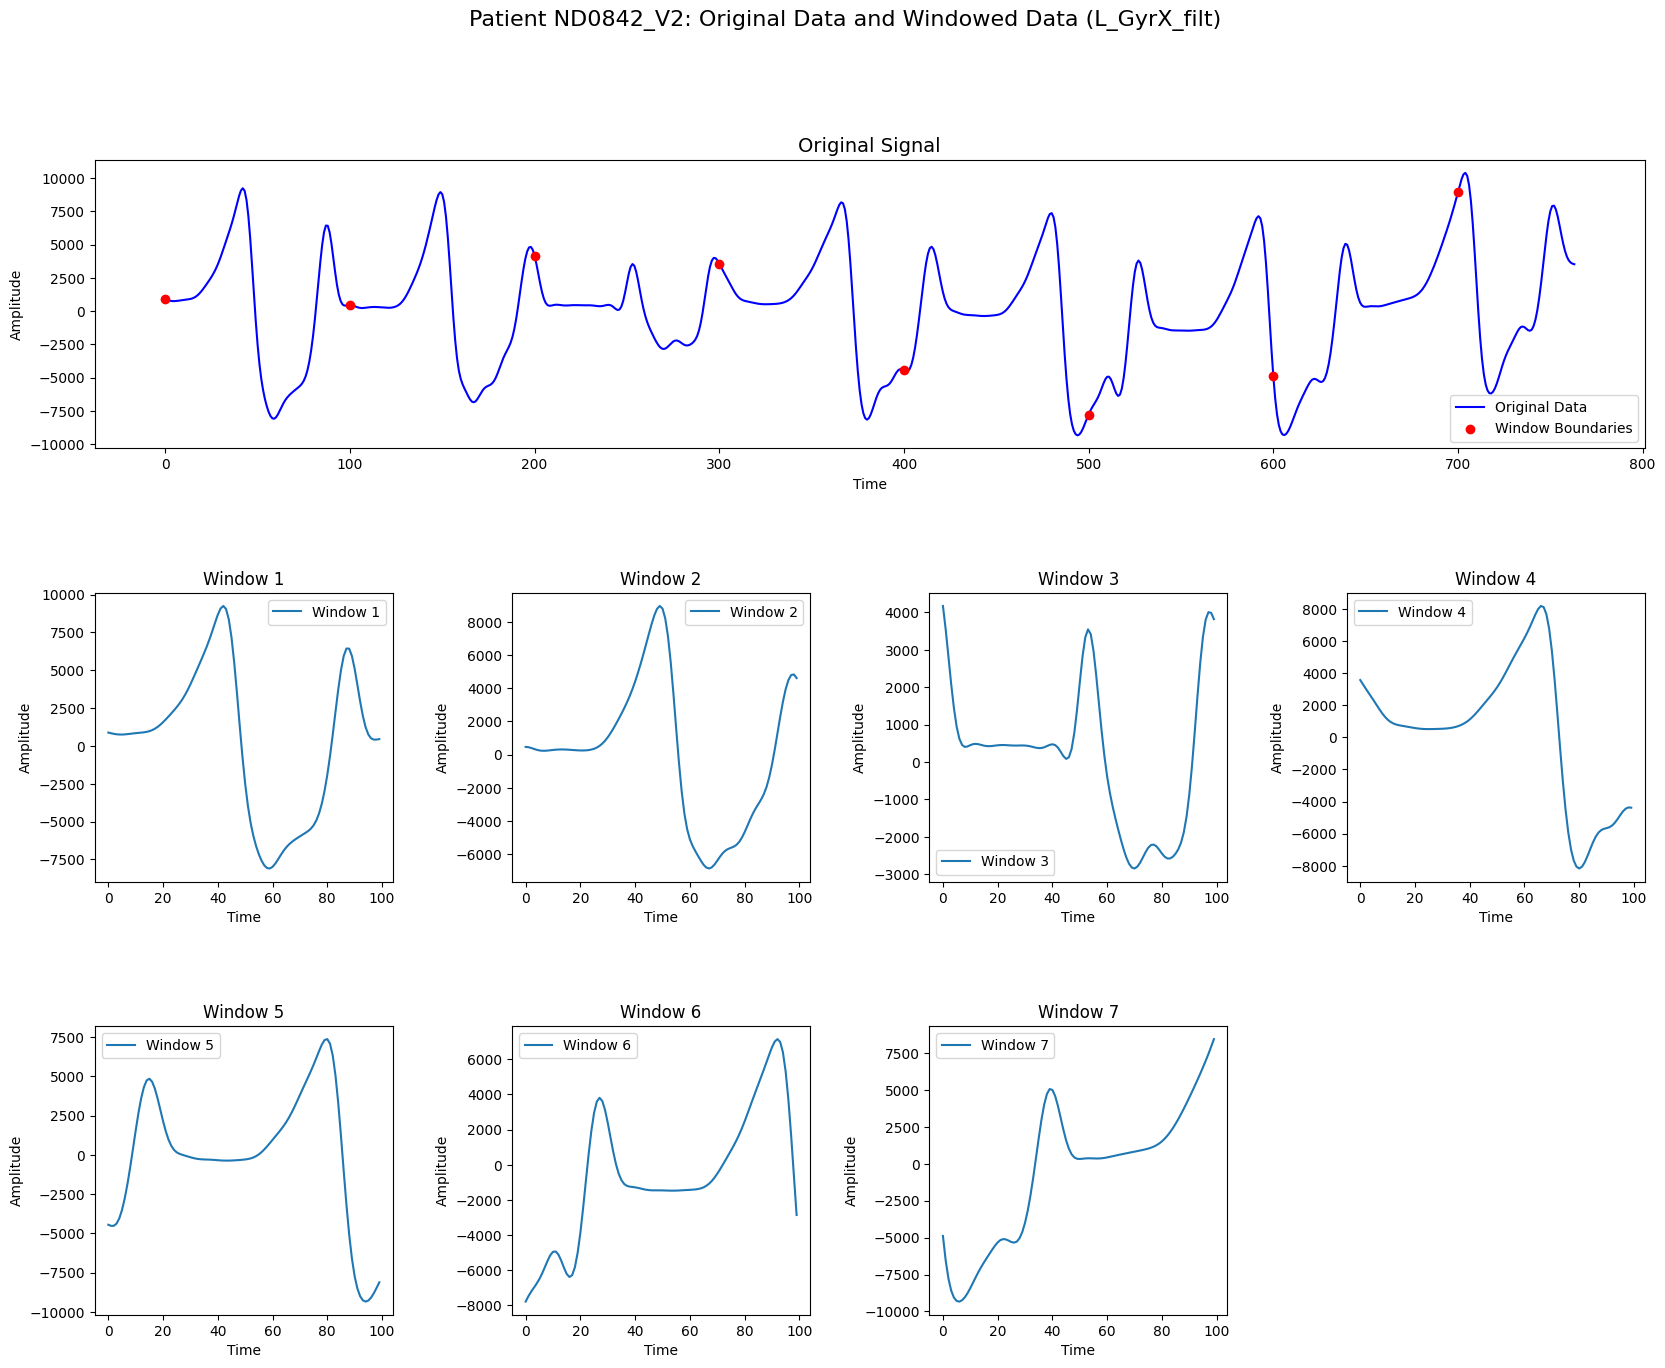

In [ ]:
patient_id = 'ND0842_V2'
feature_idx = 3
feature_name = FEATURE_COLUMNS[feature_idx]

original_feature_data = train_data[train_data['SubID'] == patient_id][feature_name].values
windowed_feature_data = X_train[
    [i for i, sub_id in enumerate(train_sub_ids) if sub_id == patient_id], :, feature_idx
]

# Calculate the red dot positions for window boundaries on the original data
window_starts = np.arange(0, len(original_feature_data), 100)  # Start of each window
window_points = original_feature_data[window_starts]  # Values at those points

# Plot the original data (long signal) and its 7 windows in a 3-row layout
fig = plt.figure(figsize=(20, 15))
grid = plt.GridSpec(3, 4, hspace=0.5, wspace=0.4)

# Original data (spanning the entire first row)
ax_original = fig.add_subplot(grid[0, :])
ax_original.plot(original_feature_data, label="Original Data", color='blue')
ax_original.scatter(window_starts, window_points, color='red', label="Window Boundaries", zorder=5)
ax_original.set_title("Original Signal", fontsize=14)
ax_original.set_xlabel("Time")
ax_original.set_ylabel("Amplitude")
ax_original.legend()

# Plot the first 4 windows in the second row
for idx in range(4):
    ax = fig.add_subplot(grid[1, idx])
    ax.plot(windowed_feature_data[idx], label=f"Window {idx + 1}")
    ax.set_title(f"Window {idx + 1}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Amplitude")
    ax.legend()

# Plot the remaining 3 windows in the third row
for idx in range(3):
    ax = fig.add_subplot(grid[2, idx])
    ax.plot(windowed_feature_data[idx + 4], label=f"Window {idx + 5}")
    ax.set_title(f"Window {idx + 5}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Amplitude")
    ax.legend()

# Adjust layout and show the plot
plt.suptitle(f"Patient {patient_id}: Original Data and Windowed Data ({feature_name})", fontsize=16)
plt.show()


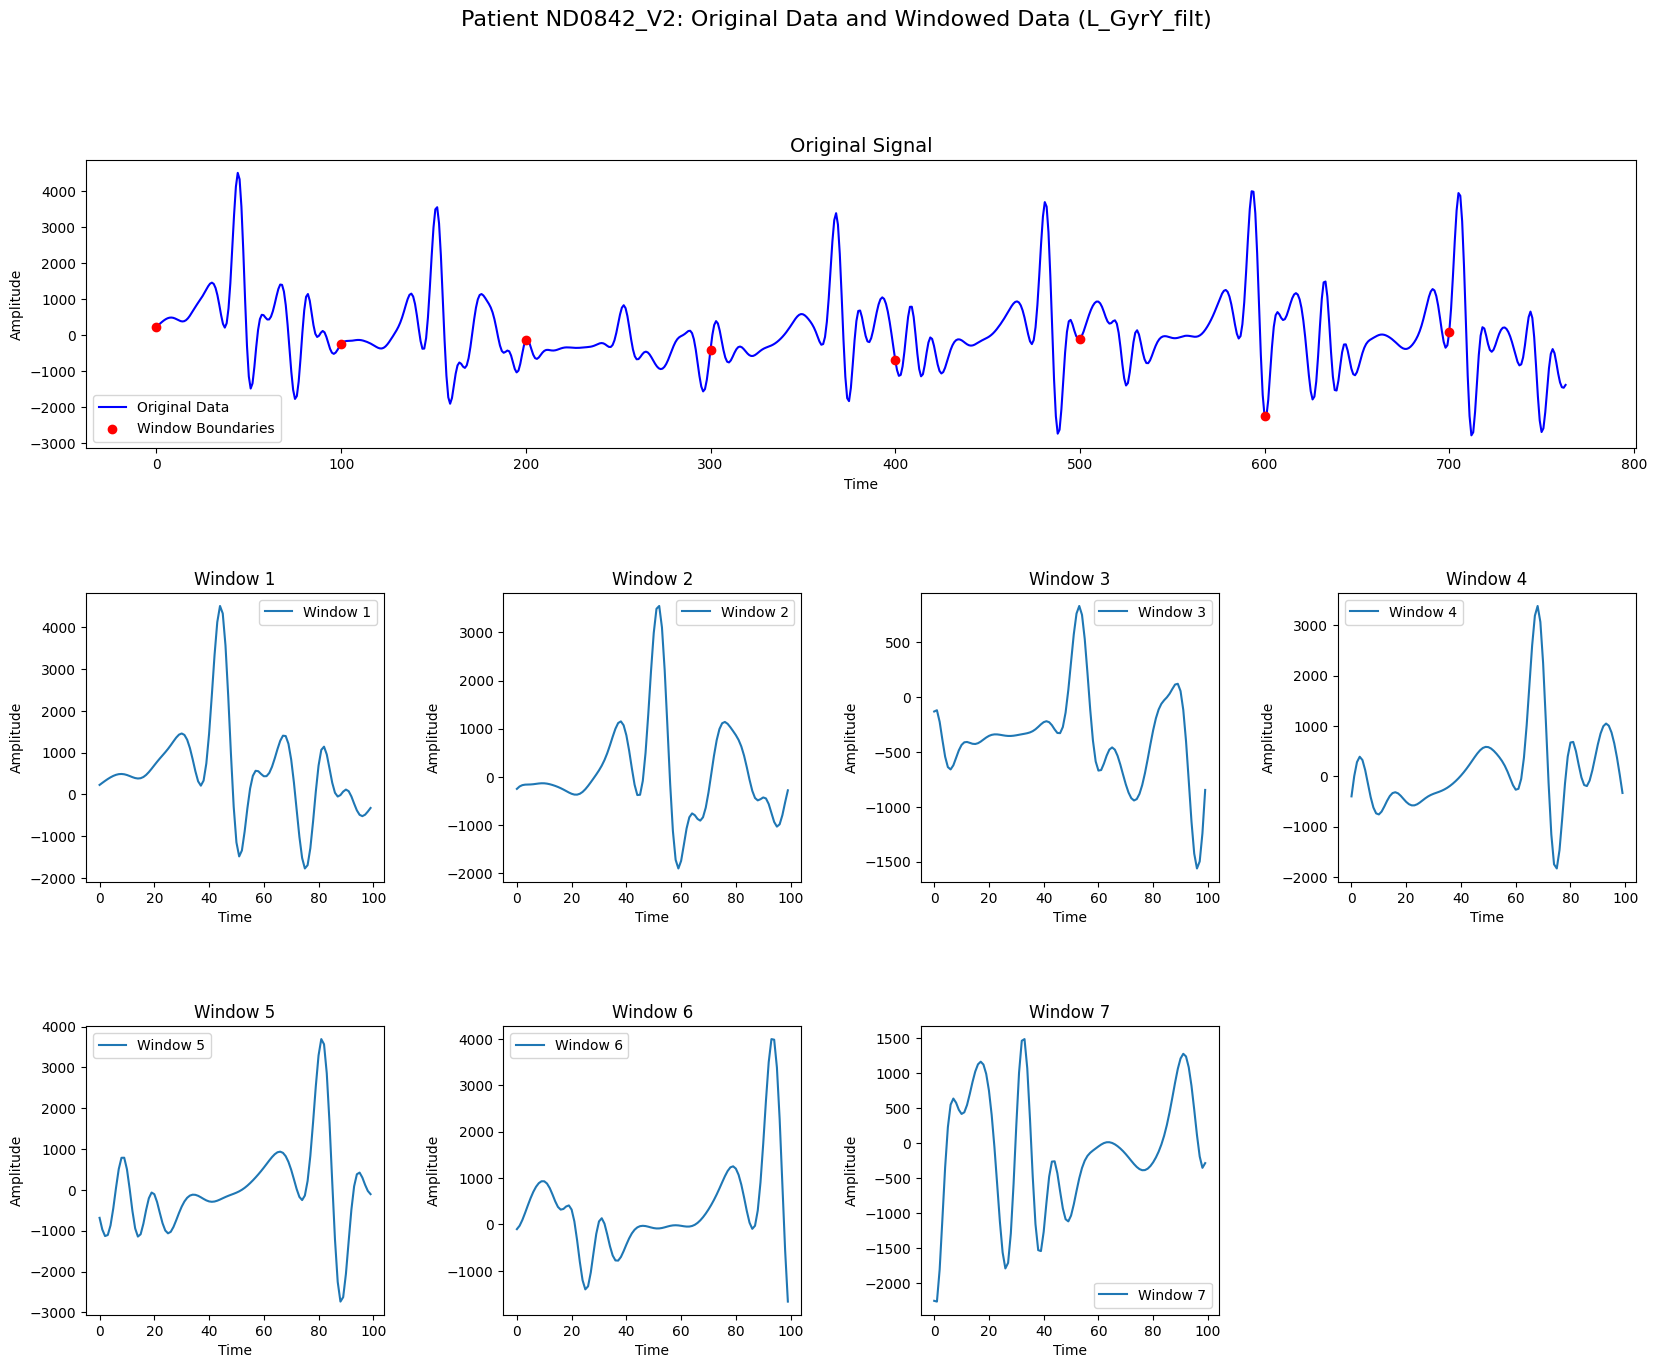

In [ ]:
patient_id = 'ND0842_V2'
feature_idx = 4
feature_name = FEATURE_COLUMNS[feature_idx]

original_feature_data = train_data[train_data['SubID'] == patient_id][feature_name].values
windowed_feature_data = X_train[
    [i for i, sub_id in enumerate(train_sub_ids) if sub_id == patient_id], :, feature_idx
]

# Calculate the red dot positions for window boundaries on the original data
window_starts = np.arange(0, len(original_feature_data), 100)  # Start of each window
window_points = original_feature_data[window_starts]  # Values at those points

# Plot the original data (long signal) and its 7 windows in a 3-row layout
fig = plt.figure(figsize=(20, 15))
grid = plt.GridSpec(3, 4, hspace=0.5, wspace=0.4)

# Original data (spanning the entire first row)
ax_original = fig.add_subplot(grid[0, :])
ax_original.plot(original_feature_data, label="Original Data", color='blue')
ax_original.scatter(window_starts, window_points, color='red', label="Window Boundaries", zorder=5)
ax_original.set_title("Original Signal", fontsize=14)
ax_original.set_xlabel("Time")
ax_original.set_ylabel("Amplitude")
ax_original.legend()

# Plot the first 4 windows in the second row
for idx in range(4):
    ax = fig.add_subplot(grid[1, idx])
    ax.plot(windowed_feature_data[idx], label=f"Window {idx + 1}")
    ax.set_title(f"Window {idx + 1}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Amplitude")
    ax.legend()

# Plot the remaining 3 windows in the third row
for idx in range(3):
    ax = fig.add_subplot(grid[2, idx])
    ax.plot(windowed_feature_data[idx + 4], label=f"Window {idx + 5}")
    ax.set_title(f"Window {idx + 5}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Amplitude")
    ax.legend()

# Adjust layout and show the plot
plt.suptitle(f"Patient {patient_id}: Original Data and Windowed Data ({feature_name})", fontsize=16)
plt.show()


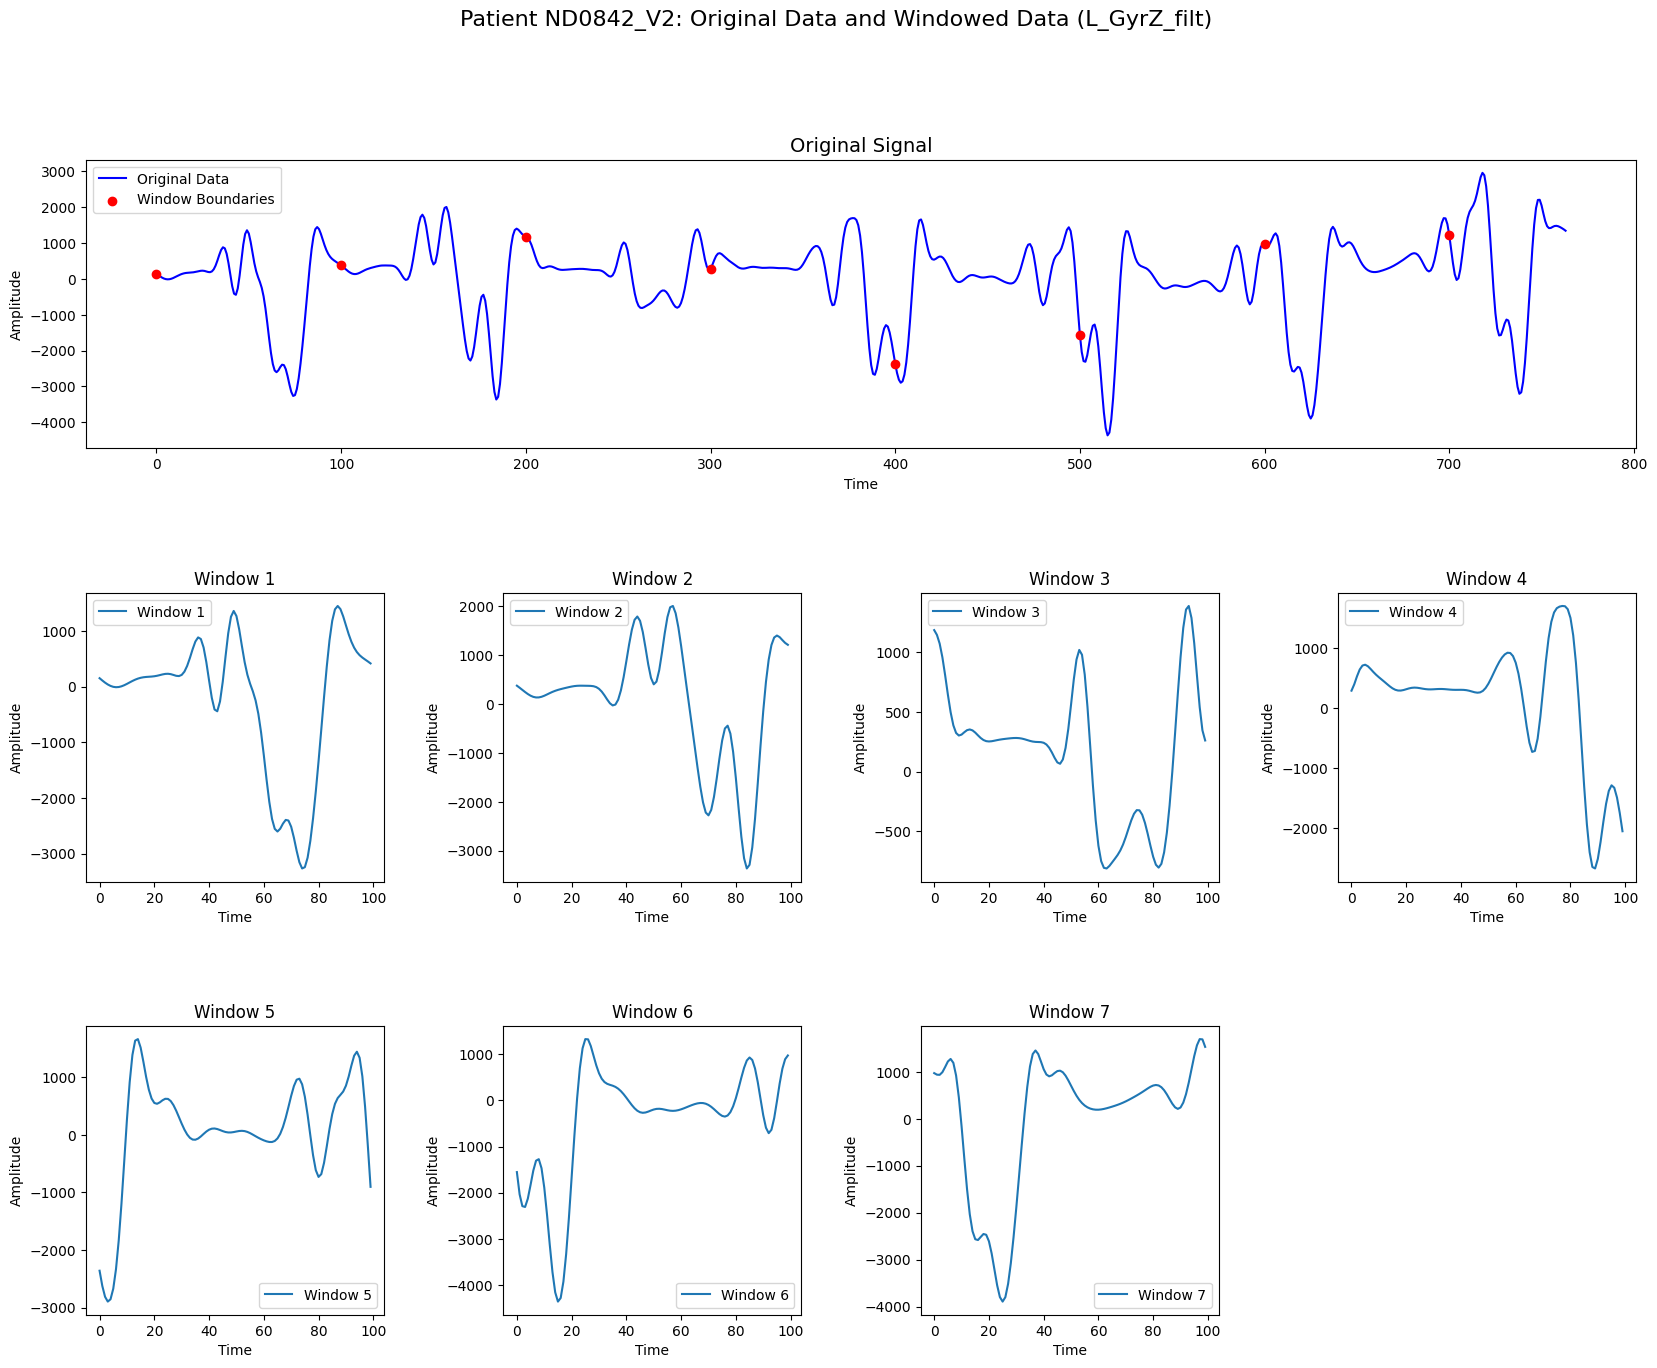

In [ ]:
patient_id = 'ND0842_V2'
feature_idx = 5
feature_name = FEATURE_COLUMNS[feature_idx]

original_feature_data = train_data[train_data['SubID'] == patient_id][feature_name].values
windowed_feature_data = X_train[
    [i for i, sub_id in enumerate(train_sub_ids) if sub_id == patient_id], :, feature_idx
]

# Calculate the red dot positions for window boundaries on the original data
window_starts = np.arange(0, len(original_feature_data), 100)  # Start of each window
window_points = original_feature_data[window_starts]  # Values at those points

# Plot the original data (long signal) and its 7 windows in a 3-row layout
fig = plt.figure(figsize=(20, 15))
grid = plt.GridSpec(3, 4, hspace=0.5, wspace=0.4)

# Original data (spanning the entire first row)
ax_original = fig.add_subplot(grid[0, :])
ax_original.plot(original_feature_data, label="Original Data", color='blue')
ax_original.scatter(window_starts, window_points, color='red', label="Window Boundaries", zorder=5)
ax_original.set_title("Original Signal", fontsize=14)
ax_original.set_xlabel("Time")
ax_original.set_ylabel("Amplitude")
ax_original.legend()

# Plot the first 4 windows in the second row
for idx in range(4):
    ax = fig.add_subplot(grid[1, idx])
    ax.plot(windowed_feature_data[idx], label=f"Window {idx + 1}")
    ax.set_title(f"Window {idx + 1}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Amplitude")
    ax.legend()

# Plot the remaining 3 windows in the third row
for idx in range(3):
    ax = fig.add_subplot(grid[2, idx])
    ax.plot(windowed_feature_data[idx + 4], label=f"Window {idx + 5}")
    ax.set_title(f"Window {idx + 5}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Amplitude")
    ax.legend()

# Adjust layout and show the plot
plt.suptitle(f"Patient {patient_id}: Original Data and Windowed Data ({feature_name})", fontsize=16)
plt.show()


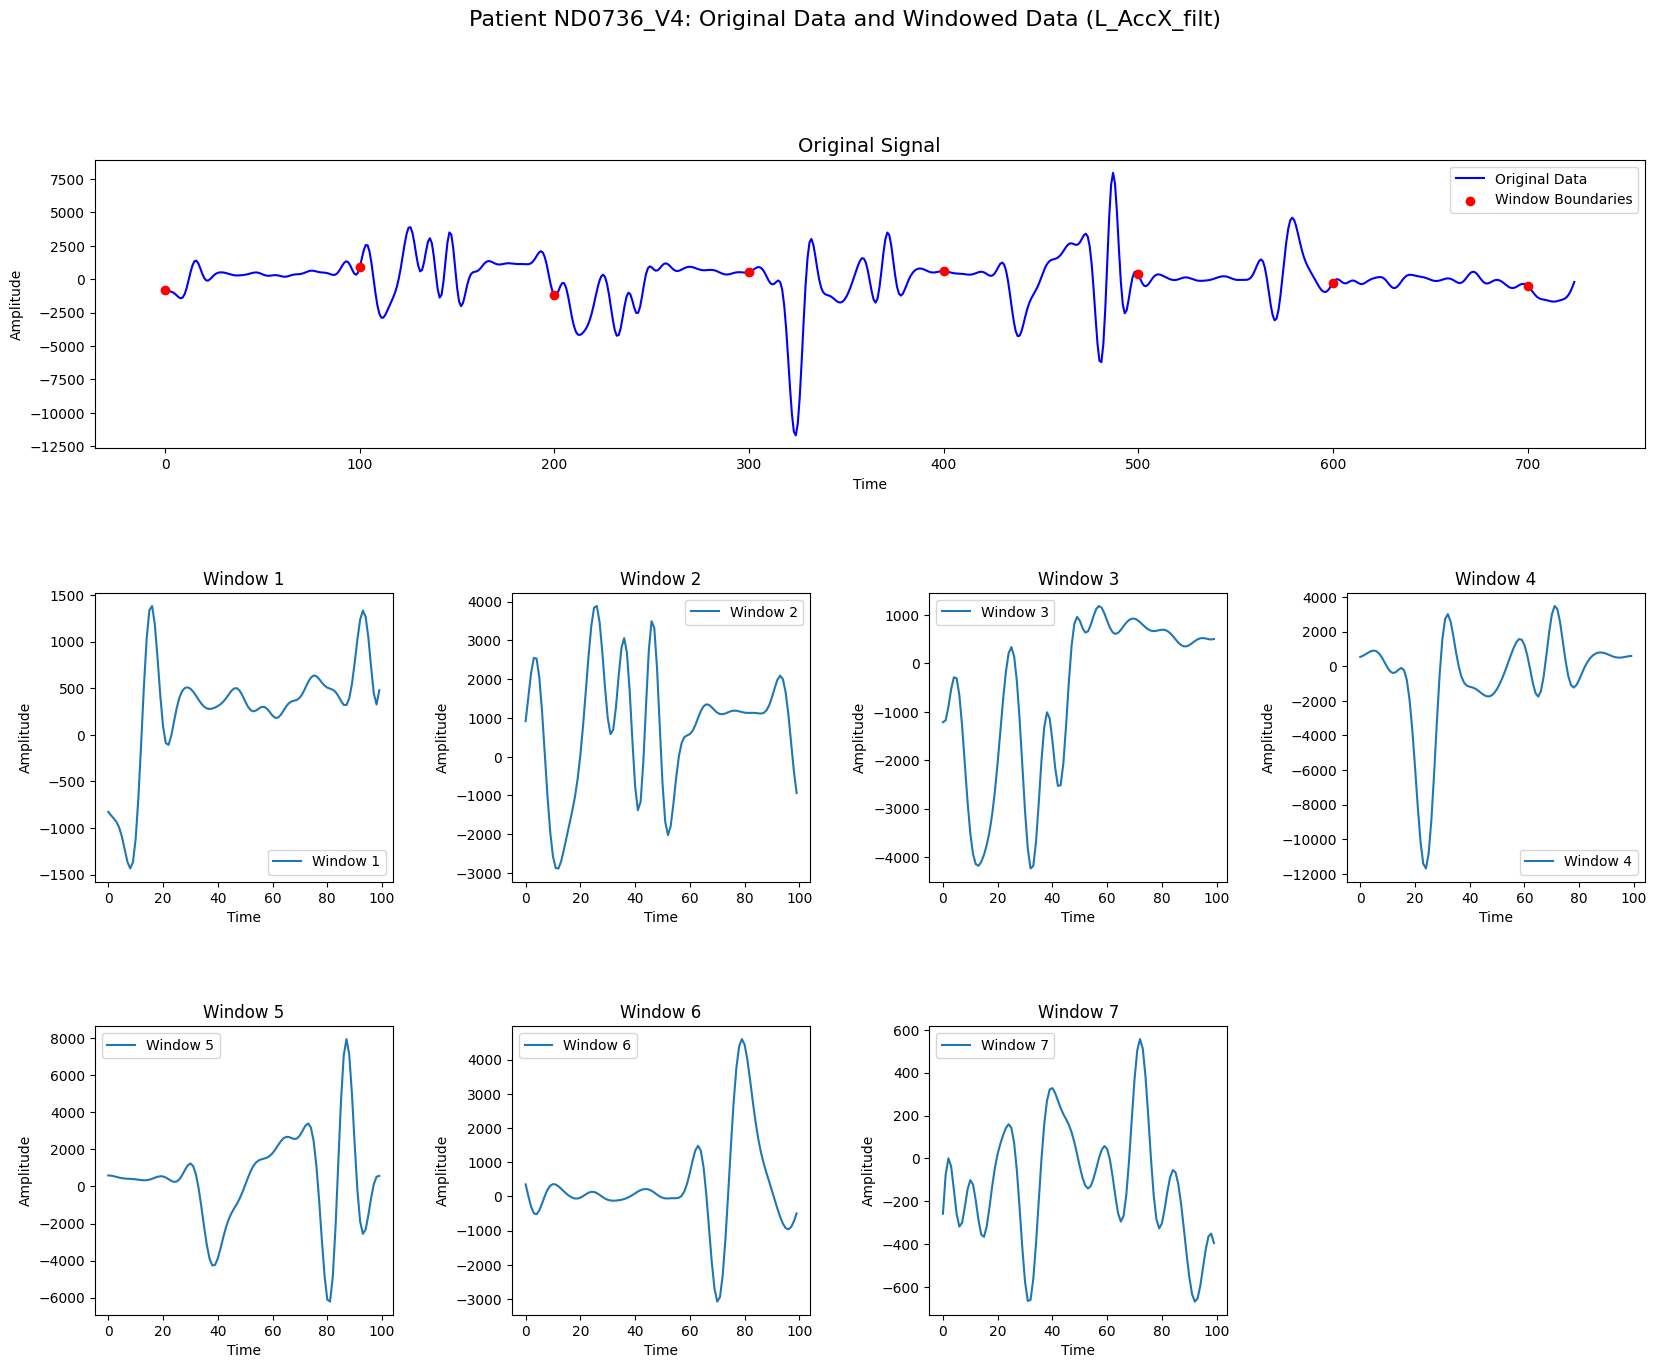

In [ ]:
patient_id = 'ND0736_V4'
feature_idx = 0
feature_name = FEATURE_COLUMNS[feature_idx]

original_feature_data = test_data[test_data['SubID'] == patient_id][feature_name].values
windowed_feature_data = X_test[
    [i for i, sub_id in enumerate(test_sub_ids) if sub_id == patient_id], :, feature_idx
]

# Calculate the red dot positions for window boundaries on the original data
window_starts = np.arange(0, len(original_feature_data), 100)  # Start of each window
window_points = original_feature_data[window_starts]  # Values at those points

# Plot the original data (long signal) and its 7 windows in a 3-row layout
fig = plt.figure(figsize=(20, 15))
grid = plt.GridSpec(3, 4, hspace=0.5, wspace=0.4)

# Original data (spanning the entire first row)
ax_original = fig.add_subplot(grid[0, :])
ax_original.plot(original_feature_data, label="Original Data", color='blue')
ax_original.scatter(window_starts, window_points, color='red', label="Window Boundaries", zorder=5)
ax_original.set_title("Original Signal", fontsize=14)
ax_original.set_xlabel("Time")
ax_original.set_ylabel("Amplitude")
ax_original.legend()

# Plot the first 4 windows in the second row
for idx in range(4):
    ax = fig.add_subplot(grid[1, idx])
    ax.plot(windowed_feature_data[idx], label=f"Window {idx + 1}")
    ax.set_title(f"Window {idx + 1}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Amplitude")
    ax.legend()

# Plot the remaining 3 windows in the third row
for idx in range(3):
    ax = fig.add_subplot(grid[2, idx])
    ax.plot(windowed_feature_data[idx + 4], label=f"Window {idx + 5}")
    ax.set_title(f"Window {idx + 5}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Amplitude")
    ax.legend()

# Adjust layout and show the plot
plt.suptitle(f"Patient {patient_id}: Original Data and Windowed Data ({feature_name})", fontsize=16)
plt.show()


In [ ]:
# ------------- RESHAPING DATA -------------
X_train_flattened = X_train.reshape(X_train.shape[0], -1)  # Flatten each window (100 * 12)
X_test_flattened = X_test.reshape(X_test.shape[0], -1)    # Flatten each window (100 * 12)

print("X_train_flattened shape:", X_train_flattened.shape)  # (num_train_windows, 1200)
print("X_test_flattened shape:", X_test_flattened.shape)    # (num_test_windows, 1200)

X_train_flattened shape: (1071, 400)
X_test_flattened shape: (261, 400)


In [ ]:
# why the model is not learning properly? 
# how ot find peaks of signals per patinet. like finding optimal window size per patient (try different numbers 100, 120, 150m ...).
# what are the parts of signals that give us more information. (maybe it's better to get less signal to feed NN model)
# isolate that parts of signals that igve more information. 
# into 4 labels: low severity, [ like (10-25) maybe jsut check for updrs ]medium, high, very high - (y_trian lables could be done by metadata of patinet , their updrs scores. check the numbers)



Class Weights: {0: np.float64(3.6678082191780823), 1: np.float64(0.5789189189189189)}


c:\Users\35262\.conda\envs\fogenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 128)            │        51,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,649 (233.00 KB)

 Trainable params: 59,649 (233.00 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4587 - loss: 880.9645 
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5707 - loss: 119.8647
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5949 - loss: 97.4390 
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6105 - loss: 56.5861
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5156 - loss: 60.0268
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4910 - loss: 52.1192
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6490 - loss: 27.9150
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6810 - loss: 26.1972
Epoch 9/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6931 - loss: 17.9805
Epoch 10/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5648 - loss: 28.8414
Epoch 11/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7151 - loss: 15.7210
Epoch 12/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - a

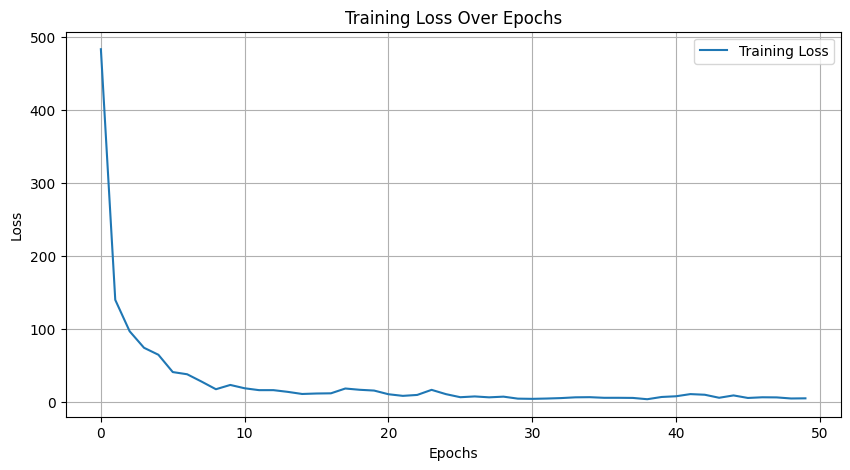

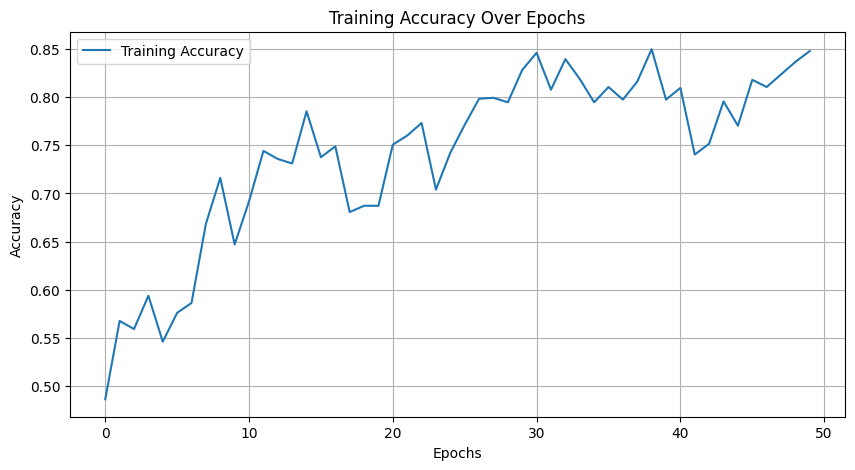

In [ ]:
def create_model(input_shape):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,)),  # Input layer with 128 neurons
        Dense(64, activation='relu'),                              # Hidden layer with 64 neurons
        Dense(1, activation='sigmoid')                             # Output layer for binary classification
    ])
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    print(model.summary())
    return model

input_shape = X_train_flattened.shape[1]  # Number of features in the input: 1200

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = {0: class_weights[0], 1: class_weights[1]}  
print("Class Weights:", class_weights)

model = create_model(input_shape)

history = model.fit(
    X_train_flattened, y_train,
    epochs=50,              
    batch_size=32,         
    class_weight=class_weights  
)

loss, accuracy = model.evaluate(X_test_flattened, y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

y_pred_probs = model.predict(X_test_flattened) 
y_pred = (y_pred_probs > 0.5).astype("int32")
  
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot Training Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plot Training Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()


In [ ]:
# Transformer Encoder
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

# Build Model
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)  # Binary classification
    return keras.Model(inputs, outputs)

# Define Model Parameters
input_shape = X_train.shape[1:]  
model = build_model(
    input_shape,
    head_size=64,  # Attention head size
    num_heads=2,   # Number of attention heads
    ff_dim=64,     # Feed-forward dimension
    num_transformer_blocks=2,  # Number of transformer blocks
    mlp_units=[64, 32],  # MLP layers
    mlp_dropout=0.3,
    dropout=0.25,
)

# Compile the Model
model.compile(
    loss="binary_crossentropy",  # Binary classification
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["accuracy"],
)

# Summary
model.summary()

# Callbacks
callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

# Train the Model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,  # Validation split from training data
    epochs=50,            # Number of epochs
    batch_size=64,        # Batch size
    callbacks=callbacks,
)

# Evaluate on Test Data
model.evaluate(X_test, y_test, verbose=1)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 100, 4)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 100, 4)    │      2,436 │ input_layer_3[0]… │
│ (MultiHeadAttentio… │                   │            │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 100, 4)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 4)    │          8 │ dropout_9[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 100, 4)    │          0 │ layer_normalizat… │
│                     │                   │            │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 100, 64)   │        320 │ add_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 100, 64)   │          0 │ conv1d_4[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 100, 4)    │        260 │ dropout_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 4)    │          8 │ conv1d_5[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 100, 4)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 100, 4)    │      2,436 │ add_5[0][0],      │
│ (MultiHeadAttentio… │                   │            │ add_5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 100, 4)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 4)    │          8 │ dropout_12[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 100, 4)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 100, 64)   │        320 │ add_6[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 100, 64)   │          0 │ conv1d_6[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 100, 4)    │        260 │ dropout_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 4)    │          8 │ conv1d_7[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 14,641 (57.19 KB)

 Trainable params: 14,641 (57.19 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 13s 133ms/step - accuracy: 0.5406 - loss: 732.8920 - val_accuracy: 0.5070 - val_loss: 872.7044
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.6892 - loss: 458.9706 - val_accuracy: 0.5256 - val_loss: 1320.1753
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.7708 - loss: 274.3640 - val_accuracy: 0.5256 - val_loss: 1606.5398
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.8214 - loss: 227.4529 - val_accuracy: 0.5256 - val_loss: 1766.7747
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.8322 - loss: 243.8908 - val_accuracy: 0.5256 - val_loss: 1820.4183
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.8812 - loss: 218.9195 - val_accuracy: 0.5256 - val_loss: 1811.1530
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.8876 - loss: 154.8844 - val_accuracy: 0.5256 - val_loss: 1754.9240
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.8875 - los

[282.6955871582031, 0.8199234008789062]

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step

Confusion Matrix:
[[  1  37]
 [ 10 213]]

Classification Report:
              precision    recall  f1-score   support

           0       0.09      0.03      0.04        38
           1       0.85      0.96      0.90       223

    accuracy                           0.82       261
   macro avg       0.47      0.49      0.47       261
weighted avg       0.74      0.82      0.78       261



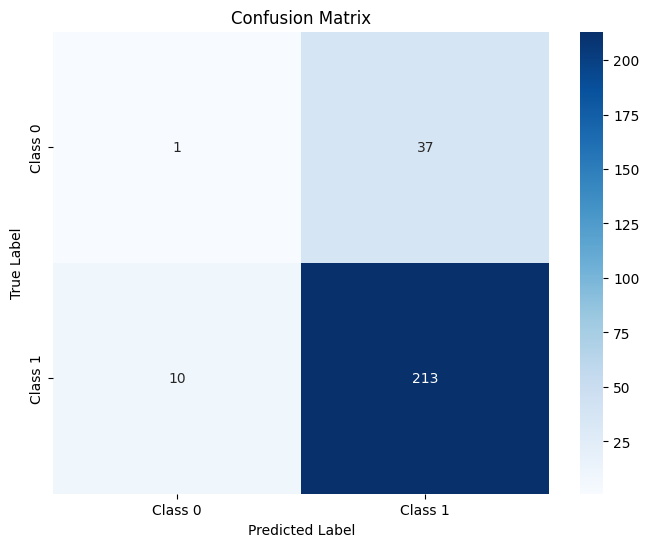

In [ ]:
y_pred_probs = model.predict(X_test) 
y_pred = (y_pred_probs > 0.5).astype("int32")  

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

c:\Users\35262\.conda\envs\fogenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │       153,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 162,049 (633.00 KB)

 Trainable params: 162,049 (633.00 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7110 - loss: 361.6825
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8445 - loss: 83.3217
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9400 - loss: 27.4362
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9653 - loss: 11.5502
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9573 - loss: 11.6905
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9660 - loss: 20.9641   
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9572 - loss: 24.3511  
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9539 - loss: 19.8572
Epoch 9/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9622 - loss: 14.0085
Epoch 10/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9771 - loss: 12.8654
Epoch 11/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9563 - loss: 10.6434
Epoch 12/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step -

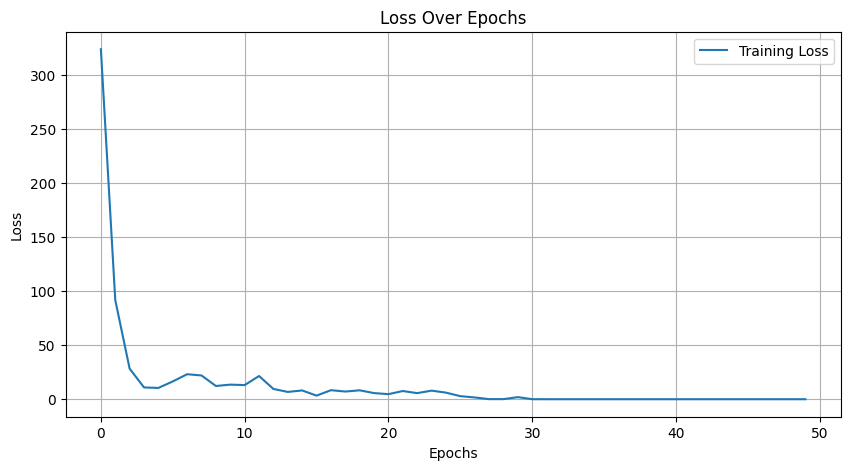

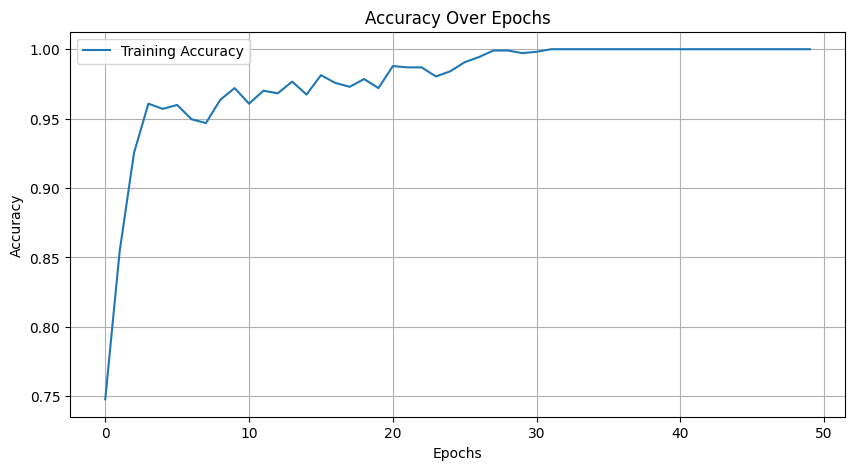

In [ ]:
def create_model(input_shape):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,)),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')  # Binary classification
    ])
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    print(model.summary())
    return model


input_shape = X_train_flattened.shape[1]  # 1200 in my case
model = create_model(input_shape)

history = model.fit(
    X_train_flattened, y_train,  
    epochs=50,  
    batch_size=32
)

loss, accuracy = model.evaluate(X_test_flattened, y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

y_pred = (model.predict(X_test_flattened) > 0.5).astype("int32")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()


c:\Users\35262\.conda\envs\fogenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 256)            │       307,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 348,673 (1.33 MB)

 Trainable params: 348,673 (1.33 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7327 - loss: 277.8631
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8637 - loss: 67.2158
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8949 - loss: 26.4322
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8907 - loss: 24.7408
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9348 - loss: 9.4032
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9204 - loss: 11.0323
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9446 - loss: 21.0701
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9506 - loss: 16.6168   
Epoch 9/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9533 - loss: 7.3407
Epoch 10/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9605 - loss: 9.9948
Epoch 11/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9704 - loss: 8.0264
Epoch 12/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accur

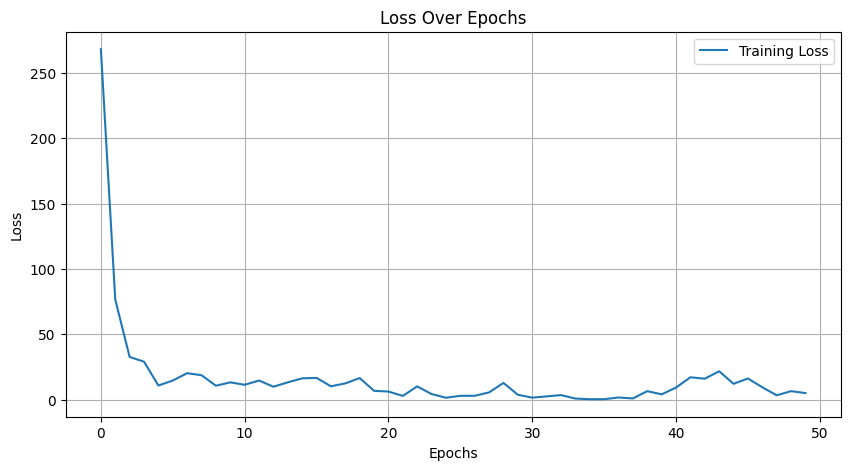

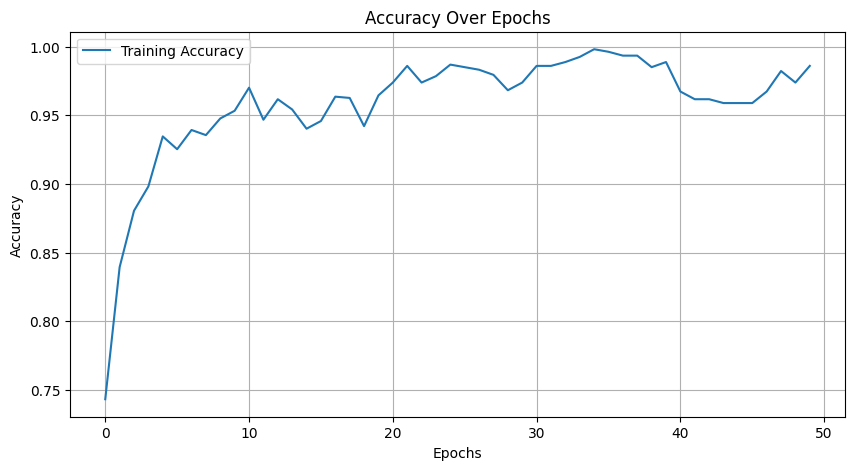

In [ ]:
def create_model(input_shape):
    model = Sequential([
        Dense(256, activation='relu', input_shape=(input_shape,)),  # First hidden layer
        Dense(128, activation='relu'),                             # Second hidden layer
        Dense(64, activation='relu'),                              # Third hidden layer
        Dense(1, activation='sigmoid')                             # Output layer
    ])
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    print(model.summary())
    return model


input_shape = X_train_flattened.shape[1]  # 1200 features

model = create_model(input_shape)

history = model.fit(
    X_train_flattened, y_train,
    epochs=50,  
    batch_size=32, 
)

loss, accuracy = model.evaluate(X_test_flattened, y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

y_pred = (model.predict(X_test_flattened) > 0.5).astype("int32")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot Training Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plot Training Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()


c:\Users\35262\.conda\envs\fogenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │       153,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 162,049 (633.00 KB)

 Trainable params: 162,049 (633.00 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7083 - loss: 416.0930 - val_accuracy: 0.6973 - val_loss: 284.4883 - learning_rate: 0.0010
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8649 - loss: 104.6555 - val_accuracy: 0.7280 - val_loss: 251.2528 - learning_rate: 0.0010
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9023 - loss: 38.0076 - val_accuracy: 0.8046 - val_loss: 254.6916 - learning_rate: 0.0010
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9528 - loss: 15.0127 - val_accuracy: 0.7548 - val_loss: 253.7632 - learning_rate: 0.0010
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9682 - loss: 6.9476 - val_accuracy: 0.7739 - val_loss: 220.8067 - learning_rate: 5.0000e-04
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9869 - loss: 1.4506 - val_accuracy: 0.7816 - val_loss: 231.7965 - learning_rate: 5.0000e-04
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9934 

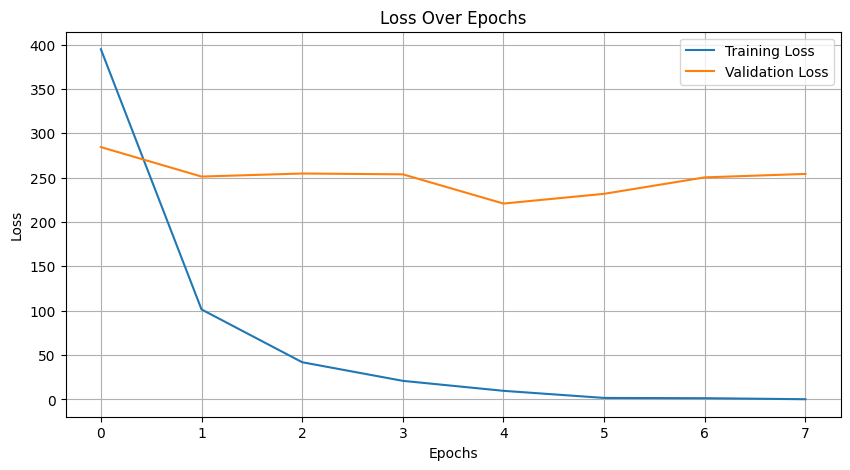

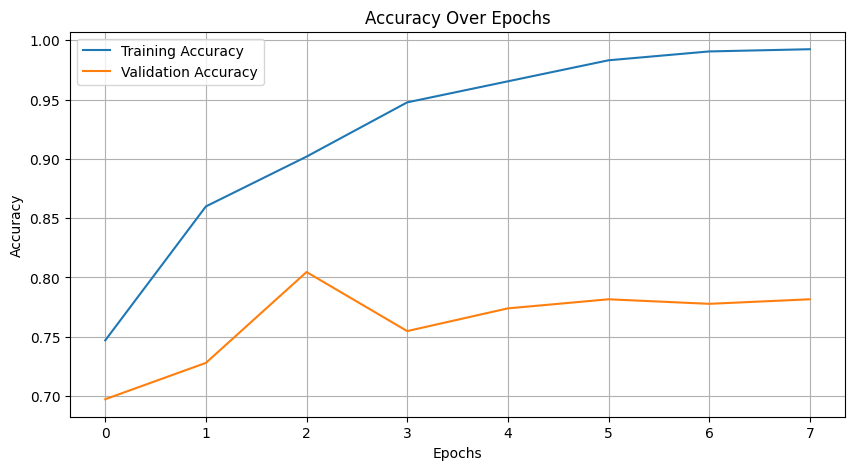

In [ ]:
# ------------- NN MODEL -------------

def create_model(input_shape):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,)),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')  # Binary classification
    ])
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    print(model.summary())
    return model

input_shape = X_train_flattened.shape[1]  # 1200 in my case
model = create_model(input_shape)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5)

history = model.fit(
    X_train_flattened, y_train,
    validation_data=(X_test_flattened, y_test),
    epochs=50,  
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)

loss, accuracy = model.evaluate(X_test_flattened, y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

y_pred = (model.predict(X_test_flattened) > 0.5).astype("int32")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()


In [ ]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_flattened.shape[1],)),  # Input: 1200
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification 
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_flattened, y_train, validation_data=(X_test_flattened, y_test), epochs=10, batch_size=32)

loss, accuracy = model.evaluate(X_test_flattened, y_test)
print("Test Accuracy:", accuracy)


In [29]:
def aggregate_patient_features(window_features, sub_ids):
    """
    Aggregates window-level features into patient-level features.
    For each patient, computes mean, std, min, and max across all their windows.
    """
    patient_feature_dict = {}

    for patient_id in np.unique(sub_ids):
        patient_indices = np.where(sub_ids == patient_id)[0]
        patient_windows = window_features[patient_indices]

        # Compute aggregated features
        mean_features = np.mean(patient_windows, axis=0)
        std_features = np.std(patient_windows, axis=0)
        min_features = np.min(patient_windows, axis=0)
        max_features = np.max(patient_windows, axis=0)

        # Concatenate all aggregated features into one patient-level feature vector
        patient_feature_dict[patient_id] = np.concatenate([mean_features, std_features, min_features, max_features])

    # Convert to DataFrame
    patient_features_df = pd.DataFrame.from_dict(patient_feature_dict, orient='index')
    return patient_features_df


sub_ids_train = np.array(sub_ids_train)
sub_ids_val = np.array(sub_ids_val)
sub_ids_test = np.array(sub_ids_test)

X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

patient_features_train = aggregate_patient_features(X_train, sub_ids_train)
patient_features_val = aggregate_patient_features(X_val, sub_ids_val)
patient_features_test = aggregate_patient_features(X_test, sub_ids_test)

print(f"Train set shape: {patient_features_train.shape}")  # (num_patients, num_aggregated_features)

Train set shape: (71, 576)


In [33]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define Neural Network for Patient Classification
model = models.Sequential([
    layers.Dense(128, activation='relu', input_shape=(patient_features_train.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=[0, 1], y=patient_labels_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Print computed weights
print("Class Weights:", class_weight_dict)

# Train Neural Network with class weighting
model.fit(patient_features_train, patient_labels_train, 
          validation_data=(patient_features_val, patient_labels_val),
          epochs=20, batch_size=16, class_weight=class_weight_dict)

# Evaluate model
test_loss, test_acc = model.evaluate(patient_features_test, patient_labels_test)
print(f"Test Accuracy: {test_acc}")


c:\Users\35262\.conda\envs\fogenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


InvalidParameterError: The 'classes' parameter of compute_class_weight must be an instance of 'numpy.ndarray'. Got [0, 1] instead.

In [52]:
# Function to compute low-frequency energy ratio per window
def compute_low_freq_ratio(fft_window, freq_bins, cutoff=3):
    """
    Computes the ratio of low-frequency energy (< cutoff Hz) to total energy.
    """
    low_freq_indices = np.where(freq_bins < cutoff)[0]  # Get indices for low frequencies

    # Compute energy in low frequencies
    low_freq_power = np.sum(fft_window[low_freq_indices, :]**2, axis=0)  

    # Compute total energy in all frequencies
    total_power = np.sum(fft_window**2, axis=0)  

    # Compute low-frequency power ratio
    low_freq_ratio = np.mean(low_freq_power / total_power)  

    return low_freq_ratio


In [53]:
# Compute low-frequency energy ratios for train, validation, and test
low_freq_ratios_train = np.array([compute_low_freq_ratio(w, freq_bins) for w in fft_train])
low_freq_ratios_val = np.array([compute_low_freq_ratio(w, freq_bins) for w in fft_val])
low_freq_ratios_test = np.array([compute_low_freq_ratio(w, freq_bins) for w in fft_test])

print(f"Computed {len(low_freq_ratios_train)} low-frequency ratios for training.")
print(f"Computed {len(low_freq_ratios_val)} low-frequency ratios for validation.")
print(f"Computed {len(low_freq_ratios_test)} low-frequency ratios for test.")


Computed 483 low-frequency ratios for training.
Computed 129 low-frequency ratios for validation.
Computed 149 low-frequency ratios for test.


In [30]:
sub_ids_train = np.array(sub_ids_train, dtype=str)  

# Initialize dictionary to store thresholds
patient_energy_thresholds = {}

# Iterate over unique patients in training data
for patient_id in np.unique(sub_ids_train):
    # Find indices of windows belonging to the patient
    patient_indices = np.where(sub_ids_train == patient_id)[0]
    
    # Extract low-frequency energy ratios for the patient
    patient_energies = low_freq_ratios[patient_indices]
    
    if len(patient_energies) == 0:
        print(f"No windows found for patient {patient_id}, skipping...")
        continue  # Skip if no windows available
    
    # Compute threshold dynamically (e.g., 10th percentile)
    patient_threshold = np.percentile(patient_energies, 5)  # Adjust percentile if needed
    
    # Store threshold
    patient_energy_thresholds[patient_id] = patient_threshold

print(f"Computed thresholds for {len(patient_energy_thresholds)} patients.")


Computed thresholds for 71 patients.


In [31]:
# Initialize array for new window labels
patient_window_labels = np.zeros_like(low_freq_ratios, dtype=np.int64)

# Iterate over each window and assign labels based on patient-specific threshold
for i, patient_id in enumerate(sub_ids_train):
    if patient_id in patient_energy_thresholds:
        # Assign label: 1 if energy ratio is below patient's threshold, else 0
        patient_window_labels[i] = 1 if low_freq_ratios[i] < patient_energy_thresholds[patient_id] else 0

# Display new label distribution
unique, counts = np.unique(patient_window_labels, return_counts=True)
print(f"Window-Level Labels Assigned (Patient-Level Threshold): {dict(zip(unique, counts))}")


Window-Level Labels Assigned (Patient-Level Threshold): {np.int64(0): np.int64(412), np.int64(1): np.int64(71)}


In [32]:
# Initialize list to store false negative patients
false_negative_patients = []

# Iterate through unique patients
for patient_id in np.unique(sub_ids_train):
    # Get indices of all windows belonging to this patient
    patient_indices = np.where(sub_ids_train == patient_id)[0]
    
    # Check if the patient has a true label of 1
    true_label = labels_train[patient_indices[0]]  # All windows for a patient have the same true label
    
    # If true label is 1 but all assigned labels are 0, it's a false negative
    if true_label == 1 and np.all(patient_window_labels[patient_indices] == 0):
        false_negative_patients.append(patient_id)

# Convert to DataFrame for better readability
false_negative_df = pd.DataFrame(false_negative_patients, columns=["False Negative Patients"])

# Display results
print(f"Number of False Negative Patients: {len(false_negative_df)}")
print(false_negative_df)


Number of False Negative Patients: 0
Empty DataFrame
Columns: [False Negative Patients]
Index: []


In [33]:
# Initialize list to store false positive patients
false_positive_patients = []

# Iterate through unique patients
for patient_id in np.unique(sub_ids_train):
    # Get indices of all windows belonging to this patient
    patient_indices = np.where(sub_ids_train == patient_id)[0]
    
    # Check the true label of the patient (all windows have the same true label)
    true_label = labels_train[patient_indices[0]]
    
    # If true label is 0 but at least one window was labeled as 1, it's a false positive
    if true_label == 0 and np.any(patient_window_labels[patient_indices] == 1):
        false_positive_patients.append(patient_id)

# Convert to DataFrame for better readability
false_positive_df = pd.DataFrame(false_positive_patients, columns=["Patient_ID"])

# Display results
print(f"Number of False Positive Patients: {len(false_positive_df)}")
print(false_positive_df)


Number of False Positive Patients: 11
   Patient_ID
0   ND0282_V7
1   ND0396_V6
2   ND0405_V6
3   ND0557_V2
4   ND3017_V3
5   ND3335_V3
6   ND3434_V3
7   ND3466_V2
8   ND3706_V1
9   ND3711_V1
10  ND7142_V2


In [34]:
# Initialize dictionary to store false positive patient window counts
false_positive_window_counts = {}

# Iterate through false positive patients
for patient_id in false_positive_patients:
    # Get indices of windows for this patient
    patient_indices = np.where(sub_ids_train == patient_id)[0]
    
    # Count how many windows were labeled as 1
    total_1s = np.sum(patient_window_labels[patient_indices] == 1)
    total_0s = np.sum(patient_window_labels[patient_indices] == 0)
    
    # Store the counts
    false_positive_window_counts[patient_id] = {"total_1s": total_1s, "total_0s": total_0s}

# Convert to DataFrame for better readability
false_positive_window_df = pd.DataFrame.from_dict(false_positive_window_counts, orient="index").reset_index()
false_positive_window_df.columns = ["Patient_ID", "Total Windows Labeled 1", "Total Windows Labeled 0"]

# Display the results
print(f"False Positive Patients - Window Label Distribution:")
print(false_positive_window_df)


False Positive Patients - Window Label Distribution:
   Patient_ID  Total Windows Labeled 1  Total Windows Labeled 0
0   ND0282_V7                        1                        3
1   ND0396_V6                        1                        7
2   ND0405_V6                        1                        8
3   ND0557_V2                        1                        4
4   ND3017_V3                        1                        5
5   ND3335_V3                        1                        4
6   ND3434_V3                        1                        5
7   ND3466_V2                        1                        5
8   ND3706_V1                        1                        5
9   ND3711_V1                        1                        4
10  ND7142_V2                        1                        4


In [35]:
# Iterate through false positive patients
for patient_id in false_positive_df["Patient_ID"]:
    # Get indices of this patient's windows
    patient_indices = np.where(sub_ids_train == patient_id)[0]
    
    # Extract patient-specific threshold
    patient_threshold = patient_energy_thresholds[patient_id]
    
    # Find incorrectly labeled "1" windows for this patient
    incorrect_1s = np.where((patient_window_labels[patient_indices] == 1) & 
                            (low_freq_ratios[patient_indices] > patient_threshold * 0.95))[0]
    
    # If the incorrectly labeled windows exist, change them back to 0
    if len(incorrect_1s) > 0:
        patient_window_labels[patient_indices[incorrect_1s]] = 0

# Display new label distribution
unique, counts = np.unique(patient_window_labels, return_counts=True)
print(f"Updated Window-Level Labels: {dict(zip(unique, counts))}")


Updated Window-Level Labels: {np.int64(0): np.int64(423), np.int64(1): np.int64(60)}


In [36]:
# Compute LFER for validation & test windows
low_freq_ratios_val = np.array([compute_low_freq_ratio(w, freq_bins) for w in fft_val])
low_freq_ratios_test = np.array([compute_low_freq_ratio(w, freq_bins) for w in fft_test])


In [37]:
sub_ids_val = np.array(sub_ids_val, dtype=str)  
sub_ids_test = np.array(sub_ids_test, dtype=str)  

# Initialize dictionaries to store thresholds
patient_energy_thresholds_val = {}
patient_energy_thresholds_test = {}

# Compute for Validation Set
for patient_id in np.unique(sub_ids_val):
    patient_indices = np.where(sub_ids_val == patient_id)[0]
    patient_energies = low_freq_ratios_val[patient_indices]
    
    if len(patient_energies) == 0:
        print(f"No windows found for validation patient {patient_id}, skipping...")
        continue
    
    # Compute threshold dynamically (e.g., 5th percentile)
    patient_threshold = np.percentile(patient_energies, 5)
    patient_energy_thresholds_val[patient_id] = patient_threshold

# Compute for Test Set
for patient_id in np.unique(sub_ids_test):
    patient_indices = np.where(sub_ids_test == patient_id)[0]
    patient_energies = low_freq_ratios_test[patient_indices]
    
    if len(patient_energies) == 0:
        print(f"No windows found for test patient {patient_id}, skipping...")
        continue
    
    patient_threshold = np.percentile(patient_energies, 5)
    patient_energy_thresholds_test[patient_id] = patient_threshold

print(f"Computed thresholds for {len(patient_energy_thresholds_val)} validation patients.")
print(f"Computed thresholds for {len(patient_energy_thresholds_test)} test patients.")


Computed thresholds for 18 validation patients.
Computed thresholds for 23 test patients.


In [38]:
# Initialize labels for validation and test
patient_window_labels_val = np.zeros_like(low_freq_ratios_val, dtype=np.int64)
patient_window_labels_test = np.zeros_like(low_freq_ratios_test, dtype=np.int64)

# Assign labels using validation patient-specific thresholds
for i, patient_id in enumerate(sub_ids_val):
    if patient_id in patient_energy_thresholds_val:
        patient_window_labels_val[i] = 1 if low_freq_ratios_val[i] < patient_energy_thresholds_val[patient_id] else 0

# Assign labels using test patient-specific thresholds
for i, patient_id in enumerate(sub_ids_test):
    if patient_id in patient_energy_thresholds_test:
        patient_window_labels_test[i] = 1 if low_freq_ratios_test[i] < patient_energy_thresholds_test[patient_id] else 0

# Print label distribution
print(f"Validation Window-Level Labels Assigned: {dict(zip(*np.unique(patient_window_labels_val, return_counts=True)))}")
print(f"Test Window-Level Labels Assigned: {dict(zip(*np.unique(patient_window_labels_test, return_counts=True)))}")


Validation Window-Level Labels Assigned: {np.int64(0): np.int64(111), np.int64(1): np.int64(18)}
Test Window-Level Labels Assigned: {np.int64(0): np.int64(126), np.int64(1): np.int64(23)}


In [39]:
# Initialize lists to store false negative patients
false_negative_patients_val = []
false_negative_patients_test = []

# Check for false negatives in Validation Set
for patient_id in np.unique(sub_ids_val):
    patient_indices = np.where(sub_ids_val == patient_id)[0]
    true_label = labels_val[patient_indices[0]]  # All windows for a patient have the same true label

    if true_label == 1 and np.all(patient_window_labels_val[patient_indices] == 0):
        false_negative_patients_val.append(patient_id)

# Check for false negatives in Test Set
for patient_id in np.unique(sub_ids_test):
    patient_indices = np.where(sub_ids_test == patient_id)[0]
    true_label = labels_test[patient_indices[0]]

    if true_label == 1 and np.all(patient_window_labels_test[patient_indices] == 0):
        false_negative_patients_test.append(patient_id)

# Convert to DataFrame for better readability
false_negative_df_val = pd.DataFrame(false_negative_patients_val, columns=["False Negative Patients (Validation)"])
false_negative_df_test = pd.DataFrame(false_negative_patients_test, columns=["False Negative Patients (Test)"])

# Display results
print(f"Number of False Negative Patients (Validation): {len(false_negative_df_val)}")
print(false_negative_df_val)

print(f"Number of False Negative Patients (Test): {len(false_negative_df_test)}")
print(false_negative_df_test)


Number of False Negative Patients (Validation): 0
Empty DataFrame
Columns: [False Negative Patients (Validation)]
Index: []
Number of False Negative Patients (Test): 0
Empty DataFrame
Columns: [False Negative Patients (Test)]
Index: []


In [40]:
# Initialize lists to store false positive patients
false_positive_patients_val = []
false_positive_patients_test = []

# Check for false positives in Validation Set
for patient_id in np.unique(sub_ids_val):
    patient_indices = np.where(sub_ids_val == patient_id)[0]
    true_label = labels_val[patient_indices[0]]  # All windows for a patient have the same true label

    if true_label == 0 and np.any(patient_window_labels_val[patient_indices] == 1):
        false_positive_patients_val.append(patient_id)

# Check for false positives in Test Set
for patient_id in np.unique(sub_ids_test):
    patient_indices = np.where(sub_ids_test == patient_id)[0]
    true_label = labels_test[patient_indices[0]]

    if true_label == 0 and np.any(patient_window_labels_test[patient_indices] == 1):
        false_positive_patients_test.append(patient_id)

# Convert to DataFrame for better readability
false_positive_df_val = pd.DataFrame(false_positive_patients_val, columns=["False Positive Patients (Validation)"])
false_positive_df_test = pd.DataFrame(false_positive_patients_test, columns=["False Positive Patients (Test)"])

# Display results
print(f"Number of False Positive Patients (Validation): {len(false_positive_df_val)}")
print(false_positive_df_val)

print(f"Number of False Positive Patients (Test): {len(false_positive_df_test)}")
print(false_positive_df_test)


Number of False Positive Patients (Validation): 3
  False Positive Patients (Validation)
0                            ND3016_V3
1                            ND3193_V3
2                            ND3521_V2
Number of False Positive Patients (Test): 4
  False Positive Patients (Test)
0                      ND3053_V2
1                      ND3184_V3
2                      ND3429_V2
3                      ND3522_V2


In [41]:
# Iterate through false positive patients in Validation Set
for patient_id in false_positive_df_val["False Positive Patients (Validation)"]:
    patient_indices = np.where(sub_ids_val == patient_id)[0]  # Get patient window indices
    patient_threshold = patient_energy_thresholds_val[patient_id]  # Get patient-specific threshold
    
    # Find incorrectly labeled "1" windows (above 95% of the threshold)
    incorrect_1s = np.where((patient_window_labels_val[patient_indices] == 1) & 
                            (low_freq_ratios_val[patient_indices] > patient_threshold * 0.95))[0]
    
    if len(incorrect_1s) > 0:
        patient_window_labels_val[patient_indices[incorrect_1s]] = 0  # Change label to 0

# Iterate through false positive patients in Test Set
for patient_id in false_positive_df_test["False Positive Patients (Test)"]:
    patient_indices = np.where(sub_ids_test == patient_id)[0]
    patient_threshold = patient_energy_thresholds_test[patient_id]  # Get patient-specific threshold
    
    incorrect_1s = np.where((patient_window_labels_test[patient_indices] == 1) & 
                            (low_freq_ratios_test[patient_indices] > patient_threshold * 0.95))[0]
    
    if len(incorrect_1s) > 0:
        patient_window_labels_test[patient_indices[incorrect_1s]] = 0  # Change label to 0

# Print updated label distributions
unique_val, counts_val = np.unique(patient_window_labels_val, return_counts=True)
unique_test, counts_test = np.unique(patient_window_labels_test, return_counts=True)

print(f"Updated Validation Window-Level Labels: {dict(zip(unique_val, counts_val))}")
print(f"Updated Test Window-Level Labels: {dict(zip(unique_test, counts_test))}")


Updated Validation Window-Level Labels: {np.int64(0): np.int64(114), np.int64(1): np.int64(15)}
Updated Test Window-Level Labels: {np.int64(0): np.int64(130), np.int64(1): np.int64(19)}


In [46]:
# Ensure labels are correctly formatted
y_train = patient_window_labels.astype("float32")  
y_val = patient_window_labels_val.astype("float32")
y_test = patient_window_labels_test.astype("float32")

# Print shapes for sanity check
print(f"Train Data Shape: {fft_train.shape}, Labels Shape: {y_train.shape}")
print(f"Validation Data Shape: {fft_val.shape}, Labels Shape: {y_val.shape}")
print(f"Test Data Shape: {fft_test.shape}, Labels Shape: {y_test.shape}")


Train Data Shape: (483, 46, 12), Labels Shape: (483,)
Validation Data Shape: (129, 46, 12), Labels Shape: (129,)
Test Data Shape: (149, 46, 12), Labels Shape: (149,)


In [166]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers  # Import models and layers
from sklearn.metrics import classification_report, f1_score

def build_1d_cnn(input_shape, num_classes):
    model = models.Sequential([
        # Input layer
        layers.Input(shape=input_shape),
        
        # First 1D convolutional layer
        layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),
        
        # Second 1D convolutional layer
        layers.Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),
        
        # Third 1D convolutional layer
        layers.Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),
        
        # Flatten the output
        layers.Flatten(),
        
        # Fully connected layers
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        
        # Output layer
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# Define input shape (num_freq_bins, num_features)
input_shape = fft_train.shape[1:]
model = build_1d_cnn(input_shape, num_classes)

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 46, 64)         │         2,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 46, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 23, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 23, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 23, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 11, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 11, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 11, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 5, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 299,778 (1.14 MB)

 Trainable params: 298,882 (1.14 MB)

 Non-trainable params: 896 (3.50 KB)

In [167]:
# Compute class weights
class_weights = {0: 1.0, 1: 5.0}  # Adjust weights based on your data imbalance

# Train the model
history = model.fit(
    fft_train, y_train_categorical,
    validation_data=(fft_val, y_val_categorical),
    epochs=20,  # Adjust number of epochs
    batch_size=32,
    class_weight=class_weights,
    verbose=1
)

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.6216 - loss: 2.1421 - val_accuracy: 0.8837 - val_loss: 0.3876
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6154 - loss: 2.0966 - val_accuracy: 0.8837 - val_loss: 0.3877
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6557 - loss: 1.3021 - val_accuracy: 0.8837 - val_loss: 0.4268
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6682 - loss: 1.3106 - val_accuracy: 0.8682 - val_loss: 0.5554
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7432 - loss: 0.9708 - val_accuracy: 0.7752 - val_loss: 0.4987
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7160 - loss: 0.9436 - val_accuracy: 0.6357 - val_loss: 0.5582
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6901 - loss: 0.8850 - val_accuracy: 0.6512 - val_loss: 0.5439
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7076 - loss: 0.7761 - val_accuracy: 0.7364 - v

In [168]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(fft_test, y_test_categorical, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Predict window-level labels
test_preds = model.predict(fft_test)
test_preds = np.argmax(test_preds, axis=1)  # Convert probabilities to class labels

# Aggregate window-level predictions to patient-level predictions
def aggregate_to_patient_level(sub_ids, window_labels):
    patient_labels = {}
    for patient_id in np.unique(sub_ids):
        patient_indices = np.where(sub_ids == patient_id)[0]
        patient_labels[patient_id] = 1 if np.sum(window_labels[patient_indices]) > 0 else 0
    return patient_labels

test_patient_labels = aggregate_to_patient_level(sub_ids_test, test_preds)

# Compare with ground truth
test_patient_y = aggregate_to_patient_level(sub_ids_test, y_test)
# Convert to arrays
test_patient_ids = np.array(list(test_patient_labels.keys()))
test_patient_preds = np.array(list(test_patient_labels.values()))
test_patient_true = np.array(list(test_patient_y.values()))

# Print classification report
print(classification_report(test_patient_true, test_patient_preds))
print(f"Test F1-Score: {f1_score(test_patient_true, test_patient_preds)}")

Test Accuracy: 0.7785
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
              precision    recall  f1-score   support

           0       0.17      0.50      0.25         4
           1       0.82      0.47      0.60        19

    accuracy                           0.48        23
   macro avg       0.49      0.49      0.42        23
weighted avg       0.70      0.48      0.54        23

Test F1-Score: 0.6


In [169]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(test_patient_true, test_patient_preds)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[ 2  2]
 [10  9]]


In [172]:
# Aggregate window-level labels to patient-level labels
def aggregate_to_patient_level(sub_ids, window_labels):
    patient_labels = {}
    for patient_id in np.unique(sub_ids):
        patient_indices = np.where(sub_ids == patient_id)[0]
        # Assign label 1 if at least one window is labeled 1, else 0
        patient_labels[patient_id] = 1 if np.any(window_labels[patient_indices] == 1) else 0
    return patient_labels

# Create patient-level labels for train, validation, and test sets
train_patient_labels = aggregate_to_patient_level(sub_ids_train, y_train)
val_patient_labels = aggregate_to_patient_level(sub_ids_val, y_val)
test_patient_labels = aggregate_to_patient_level(sub_ids_test, y_test)

In [177]:
train_patient_labels

{np.str_('ND0015_V8'): 1,
 np.str_('ND0028_V8'): 1,
 np.str_('ND0045_V8'): 1,
 np.str_('ND0055_V8'): 1,
 np.str_('ND0060_V8'): 1,
 np.str_('ND0070_V8'): 1,
 np.str_('ND0075_V8'): 1,
 np.str_('ND0080_V8'): 1,
 np.str_('ND0095_V8'): 1,
 np.str_('ND0132_V8'): 1,
 np.str_('ND0163_V8'): 1,
 np.str_('ND0172_V8'): 1,
 np.str_('ND0199_V7'): 1,
 np.str_('ND0254_V7'): 1,
 np.str_('ND0282_V7'): 0,
 np.str_('ND0289_V7'): 1,
 np.str_('ND0340_V7'): 1,
 np.str_('ND0385_V6'): 1,
 np.str_('ND0394_V6'): 1,
 np.str_('ND0396_V6'): 0,
 np.str_('ND0405_V6'): 0,
 np.str_('ND0437_V6'): 1,
 np.str_('ND0468_V6'): 1,
 np.str_('ND0482_V6'): 1,
 np.str_('ND0497_V6'): 1,
 np.str_('ND0536_V6'): 1,
 np.str_('ND0545_V5'): 1,
 np.str_('ND0551_V5'): 1,
 np.str_('ND0557_V2'): 0,
 np.str_('ND0564_V5'): 1,
 np.str_('ND0597_V5'): 1,
 np.str_('ND0613_V5'): 1,
 np.str_('ND0614_V5'): 1,
 np.str_('ND0654_V4'): 1,
 np.str_('ND0668_V4'): 1,
 np.str_('ND0688_V4'): 1,
 np.str_('ND0690_V4'): 1,
 np.str_('ND0702_V4'): 1,
 np.str_('ND

In [175]:
# Aggregate features for each patient
def aggregate_patient_features(sub_ids, windows):
    patient_features = {}
    for patient_id in np.unique(sub_ids):
        patient_indices = np.where(sub_ids == patient_id)[0]
        patient_windows = windows[patient_indices]
        # Compute mean and std for each feature across all windows
        mean_features = np.mean(patient_windows, axis=0)  # Shape: (num_freq_bins, num_features)
        std_features = np.std(patient_windows, axis=0)     # Shape: (num_freq_bins, num_features)
        # Flatten the features into a 1D array
        patient_features[patient_id] = np.hstack([mean_features.flatten(), std_features.flatten()])
    return patient_features

# Aggregate features for train, validation, and test sets
train_patient_features = aggregate_patient_features(sub_ids_train, fft_train)
val_patient_features = aggregate_patient_features(sub_ids_val, fft_val)
test_patient_features = aggregate_patient_features(sub_ids_test, fft_test)

# Convert to arrays
train_X = np.array(list(train_patient_features.values()))
train_y = np.array([train_patient_labels[pid] for pid in train_patient_features.keys()])
val_X = np.array(list(val_patient_features.values()))
val_y = np.array([val_patient_labels[pid] for pid in val_patient_features.keys()])
test_X = np.array(list(test_patient_features.values()))
test_y = np.array([test_patient_labels[pid] for pid in test_patient_features.keys()])

# Train a model (e.g., Random Forest)
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(class_weight={0: 10, 1: 1})  # Higher weight for class 0
model.fit(train_X, train_y)

# Evaluate
val_preds = model.predict(val_X)
test_preds = model.predict(test_X)

print(classification_report(test_y, test_preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.83      1.00      0.90        19

    accuracy                           0.83        23
   macro avg       0.41      0.50      0.45        23
weighted avg       0.68      0.83      0.75        23



c:\Users\35262\.conda\envs\fogenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\35262\.conda\envs\fogenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\35262\.conda\envs\fogenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


📊 Classification Report (Patient-Level Predictions):
               precision    recall  f1-score   support

 Non-Freezing       0.25      0.75      0.38         4
Freezing Gait       0.91      0.53      0.67        19

     accuracy                           0.57        23
    macro avg       0.58      0.64      0.52        23
 weighted avg       0.79      0.57      0.62        23



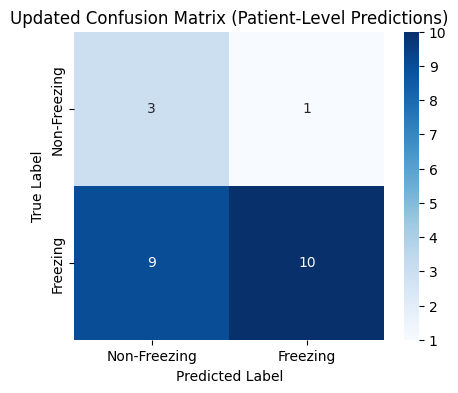

In [162]:
# Initialize list for patient-level predictions
y_pred_patients = []

# Get the unique patient IDs in the test set
unique_patients_test = np.unique(sub_ids_test)

for patient_id in unique_patients_test:
    # Find indices of windows belonging to the current patient
    patient_indices = np.where(sub_ids_test == patient_id)[0]
    
    # Get window-level predictions for this patient
    patient_windows = y_pred_windows[patient_indices]

    # Aggregate predictions (If any window is classified as 1, mark the patient as 1)
    final_label = 1 if np.any(patient_windows == 1) else 0
    y_pred_patients.append(final_label)

# Convert patient predictions to NumPy array
y_pred_patients = np.array(y_pred_patients)

# True patient labels (based on assigned window labels)
y_test_patients = np.array([1 if np.any(y_test[sub_ids_test == pid] == 1) else 0 for pid in unique_patients_test])

# Classification Report (Patient Level)
print("📊 Classification Report (Patient-Level Predictions):")
print(classification_report(y_test_patients, y_pred_patients, target_names=["Non-Freezing", "Freezing Gait"]))

# Confusion Matrix (Patient Level)
cm_patient = confusion_matrix(y_test_patients, y_pred_patients)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_patient, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Freezing", "Freezing"], yticklabels=["Non-Freezing", "Freezing"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Updated Confusion Matrix (Patient-Level Predictions)")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


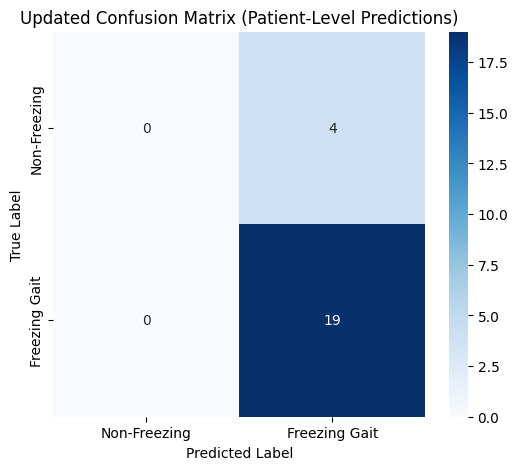

📊 Classification Report (Patient-Level Predictions):
               precision    recall  f1-score   support

 Non-Freezing       0.00      0.00      0.00         4
Freezing Gait       0.83      1.00      0.90        19

     accuracy                           0.83        23
    macro avg       0.41      0.50      0.45        23
 weighted avg       0.68      0.83      0.75        23



c:\Users\35262\.conda\envs\fogenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\35262\.conda\envs\fogenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\35262\.conda\envs\fogenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [137]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict patient-level labels
y_pred_probs = model.predict(X_test_assigned)
y_pred_patients = (y_pred_probs > 0.5).astype("int32")

# Compute confusion matrix
cm = confusion_matrix(y_test_assigned, y_pred_patients)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Freezing", "Freezing Gait"], yticklabels=["Non-Freezing", "Freezing Gait"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Updated Confusion Matrix (Patient-Level Predictions)")
plt.show()

# Print classification report
print("📊 Classification Report (Patient-Level Predictions):")
print(classification_report(y_test_assigned, y_pred_patients, target_names=["Non-Freezing", "Freezing Gait"]))


In [121]:
# Predict probabilities on test set per window
y_pred_probs = model.predict(fft_test)  
y_pred_windows = (y_pred_probs > 0.5).astype("int32")  # Convert probabilities to binary labels


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 450ms/step


In [126]:
# Initialize list for patient-level predictions
y_pred_patients = []

# Get the unique patient IDs in the test set
unique_patients_test = np.unique(sub_ids_test)

for patient_id in unique_patients_test:
    # Find indices of windows belonging to the current patient
    patient_indices = np.where(sub_ids_test == patient_id)[0]
    
    # Get window-level predictions for this patient
    patient_windows = y_pred_windows[patient_indices]

    # Aggregate predictions (If any window is classified as 1, mark the patient as 1)
    final_label = 1 if np.any(patient_windows == 1) else 0
    y_pred_patients.append(final_label)

# Convert patient predictions to NumPy array
y_pred_patients = np.array(y_pred_patients)


In [129]:
# Initialize list for true patient-level labels (using assigned labels)
true_labels_patients = []

# Get the unique patient IDs in the test set
unique_patients_test = np.unique(sub_ids_test)

for patient_id in unique_patients_test:
    # Find indices of windows belonging to the current patient
    patient_indices = np.where(sub_ids_test == patient_id)[0]

    # Get the assigned labels of these windows (all windows of a patient should follow assigned label)
    patient_true_label = patient_window_labels_test[patient_indices[0]]  

    # Store the true label per patient
    true_labels_patients.append(patient_true_label)

# Convert true labels to a NumPy array
patient_window_labels_test_per_patient = np.array(true_labels_patients)


In [130]:
# Print classification report using assigned labels
print("📊 Classification Report (Patient-Level Predictions - Assigned Labels):")
print(classification_report(patient_window_labels_test_per_patient, y_pred_patients, target_names=["Non-Freezing", "Freezing Gait"]))


📊 Classification Report (Patient-Level Predictions - Assigned Labels):
               precision    recall  f1-score   support

 Non-Freezing       1.00      0.65      0.79        23
Freezing Gait       0.00      0.00      0.00         0

     accuracy                           0.65        23
    macro avg       0.50      0.33      0.39        23
 weighted avg       1.00      0.65      0.79        23



c:\Users\35262\.conda\envs\fogenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\35262\.conda\envs\fogenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\35262\.conda\envs\fogenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


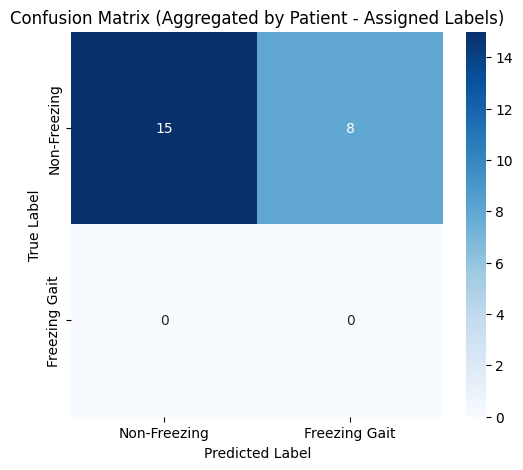

In [131]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(patient_window_labels_test_per_patient, y_pred_patients)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Freezing", "Freezing Gait"], yticklabels=["Non-Freezing", "Freezing Gait"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Aggregated by Patient - Assigned Labels)")
plt.show()


In [90]:
from tensorflow.keras.layers import Input, LSTM, Dense, Bidirectional, Attention, Permute, Multiply, Lambda
from tensorflow.keras.models import Model

# Define input shape
input_shape = (300, 12)  # (window_size, num_features)
inputs = Input(shape=input_shape)

# Bidirectional LSTM
x = Bidirectional(LSTM(64, return_sequences=True))(inputs)
x = Bidirectional(LSTM(32, return_sequences=True))(x)

# Attention Mechanism
attention = Dense(1, activation="tanh")(x)
attention = Permute((2, 1))(attention)
attention = tf.keras.activations.softmax(attention, axis=-1)
attention = Permute((2, 1))(attention)
x = Multiply()([x, attention])
x = Lambda(lambda x: tf.reduce_sum(x, axis=1))(x)

# Fully Connected Layer
x = Dense(32, activation="relu")(x)
outputs = Dense(1, activation="sigmoid")(x)  # Binary classification

# Build Model
model = Model(inputs, outputs)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 300, 12)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 300, 128)  │     39,424 │ input_layer_1[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 300, 64)   │     41,216 │ bidirectional_2[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 300, 1)    │         65 │ bidirectional_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute (Permute)   │ (None, 1, 300)    │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax (Softmax)   │ (None, 1, 300)    │          0 │ permute[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute_1 (Permute) │ (None, 300, 1)    │          0 │ softmax[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 300, 64)   │          0 │ bidirectional_3[… │
│                     │                   │            │ permute_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 64)        │          0 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      2,080 │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         33 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 82,818 (323.51 KB)

 Trainable params: 82,818 (323.51 KB)

 Non-trainable params: 0 (0.00 B)

In [110]:

model = Sequential([
    Conv1D(filters=64, kernel_size=5, activation='relu', padding="same", 
           input_shape=(fft_train_windows.shape[2], fft_train_windows.shape[3])),
    BatchNormalization(),
    MaxPooling1D(pool_size=2, padding="same"),

    Conv1D(filters=128, kernel_size=3, activation='relu', padding="same"),
    BatchNormalization(),
    MaxPooling1D(pool_size=2, padding="same"),

    Bidirectional(LSTM(128, return_sequences=False)),  # Learn temporal patterns per window
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Binary classification per window
])

# Compile Model
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])

model.summary()


c:\Users\35262\.conda\envs\fogenv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_14 (Conv1D)              │ (None, 15, 64)         │         3,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 15, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_15 (Conv1D)              │ (None, 8, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 8, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 256)            │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 325,569 (1.24 MB)

 Trainable params: 325,185 (1.24 MB)

 Non-trainable params: 384 (1.50 KB)

In [111]:
# Train model with per-window predictions
history = model.fit(fft_train_windows.reshape(-1, fft_train_windows.shape[2], fft_train_windows.shape[3]), 
                    np.repeat(patient_train_labels, fft_train_windows.shape[1]), 
                    epochs=30, batch_size=8, 
                    validation_data=(fft_val_windows.reshape(-1, fft_val_windows.shape[2], fft_val_windows.shape[3]), 
                                     np.repeat(patient_val_labels, fft_val_windows.shape[1])))


Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8421 - loss: 0.4964 - val_accuracy: 0.8333 - val_loss: 0.4635
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8521 - loss: 0.4303 - val_accuracy: 0.8333 - val_loss: 0.4924
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8580 - loss: 0.4129 - val_accuracy: 0.8333 - val_loss: 0.4658
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8308 - loss: 0.4426 - val_accuracy: 0.8333 - val_loss: 0.4859
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8501 - loss: 0.4208 - val_accuracy: 0.8333 - val_loss: 0.4526
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8484 - loss: 0.4143 - val_accuracy: 0.8333 - val_loss: 0.4532
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8572 - loss: 0.4153 - val_accuracy: 0.8333 - val_loss: 0.4530
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8256 - loss: 0.4594 - val_accuracy: 0.

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00         4
     Class 1       0.83      1.00      0.90        19

    accuracy                           0.83        23
   macro avg       0.41      0.50      0.45        23
weighted avg       0.68      0.83      0.75        23



c:\Users\35262\.conda\envs\fogenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\35262\.conda\envs\fogenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\35262\.conda\envs\fogenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


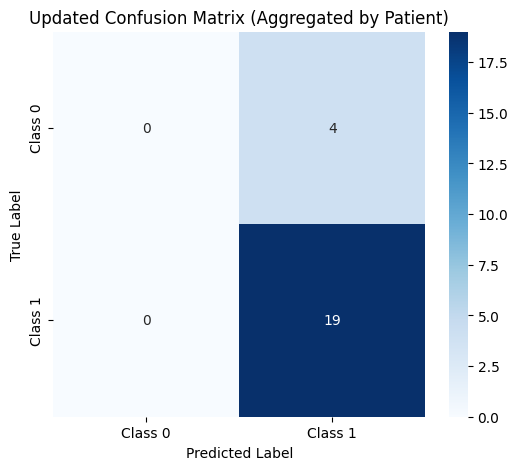

In [112]:
# Predict on test set per window
y_pred_probs = model.predict(fft_test_windows.reshape(-1, fft_test_windows.shape[2], fft_test_windows.shape[3]))  
y_pred_windows = (y_pred_probs > 0.5).astype("int32")  # Per-window prediction

# Aggregate predictions per patient (If any window is 1, patient is classified as 1)
y_pred_patients = []
window_index = 0

for num_windows in [fft_test_windows.shape[1]] * len(patient_test_labels):  # Iterate over patients
    patient_windows = y_pred_windows[window_index:window_index + num_windows]
    final_label = 1 if np.any(patient_windows == 1) else 0  # Max pooling
    y_pred_patients.append(final_label)
    window_index += num_windows

y_pred_patients = np.array(y_pred_patients)

# Classification Report
from sklearn.metrics import classification_report, confusion_matrix
print("Classification Report:\n", classification_report(patient_test_labels, y_pred_patients, target_names=["Class 0", "Class 1"]))

# Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(patient_test_labels, y_pred_patients)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Updated Confusion Matrix (Aggregated by Patient)")
plt.show()


### FFT

In [64]:
fft_train, freq_bins = apply_fft_to_windows(windows_train, sampling_rate=100, max_freq=15)

fft_val, _ = apply_fft_to_windows(windows_val, sampling_rate=100, max_freq=15)

fft_test, _ = apply_fft_to_windows(windows_test, sampling_rate=100, max_freq=15)

print(f'FFT (Train): {fft_train.shape}')  # (483, new_freq_bins, 12)

FFT (Train): (483, 46, 12)


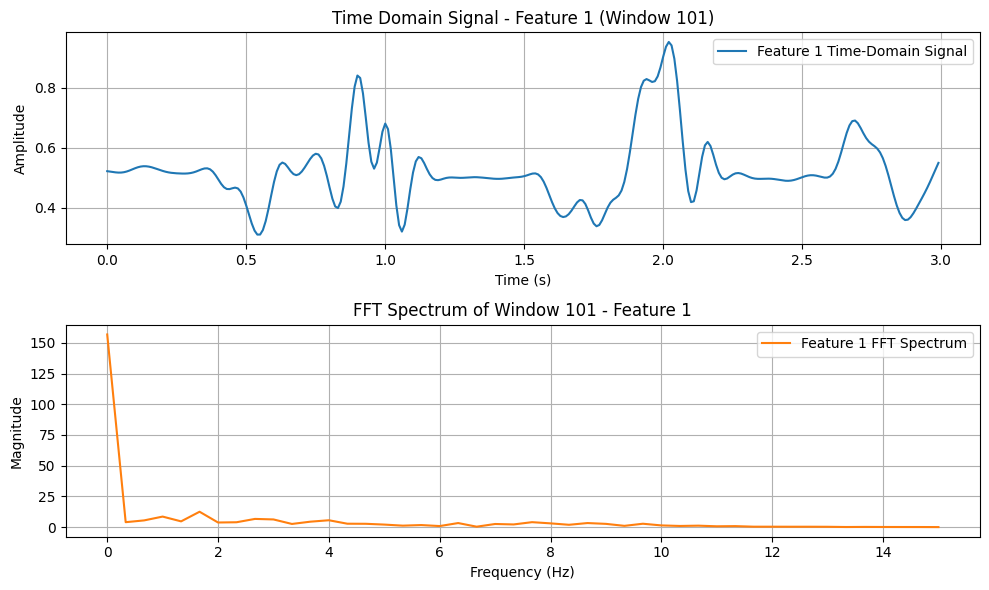

In [65]:
example_idx = 100  
feature_idx = 0  

time_window = windows_train[example_idx, :, feature_idx]  # (300,)
fft_window = fft_train[example_idx, :, feature_idx] 

sampling_rate = 100 
time_axis = np.arange(time_window.shape[0]) / sampling_rate  
freq_axis = freq_bins  

fig, axes = plt.subplots(2, 1, figsize=(10, 6))

axes[0].plot(time_axis, time_window, label=f'Feature {feature_idx+1} Time-Domain Signal', color='tab:blue')
axes[0].set_title(f'Time Domain Signal - Feature {feature_idx+1} (Window {example_idx+1})')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amplitude')
axes[0].legend()
axes[0].grid()

axes[1].plot(freq_axis, fft_window, label=f'Feature {feature_idx+1} FFT Spectrum', color='tab:orange')
axes[1].set_title(f'FFT Spectrum of Window {example_idx+1} - Feature {feature_idx+1}')
axes[1].set_xlabel('Frequency (Hz)')
axes[1].set_ylabel('Magnitude')
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()


In [66]:
y_train = labels_train.astype("float32")  
y_val = labels_val.astype("float32")
y_test = labels_test.astype("float32")

model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(fft_train.shape[1], fft_train.shape[2])),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=256, kernel_size=3, activation='relu'),
    GlobalAveragePooling1D(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  
])

model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

model.summary()

history = model.fit(fft_train, y_train, epochs=30, batch_size=32, validation_data=(fft_val, y_val))

test_loss, test_acc = model.evaluate(fft_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

c:\Users\35262\.conda\envs\fogenv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 44, 64)         │         2,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 22, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 20, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 8, 256)         │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 158,657 (619.75 KB)

 Trainable params: 158,657 (619.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.8510 - loss: 0.5320 - val_accuracy: 0.8605 - val_loss: 0.4244
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8594 - loss: 0.4128 - val_accuracy: 0.8605 - val_loss: 0.4225
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8842 - loss: 0.3577 - val_accuracy: 0.8605 - val_loss: 0.4086
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8433 - loss: 0.4234 - val_accuracy: 0.8605 - val_loss: 0.4203
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8699 - loss: 0.3589 - val_accuracy: 0.8605 - val_loss: 0.4425
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8734 - loss: 0.3347 - val_accuracy: 0.8605 - val_loss: 0.4361
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8742 - loss: 0.3082 - val_accuracy: 0.8605 - val_loss: 0.4634
Epoch 8/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8551 - loss: 0.3048 - val_accuracy: 0.8605 - v

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8435 - loss: 0.7091
Test Loss: 0.9105
Test Accuracy: 0.8054
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.29      0.23      0.26        22
     Class 1       0.87      0.91      0.89       127

    accuracy                           0.81       149
   macro avg       0.58      0.57      0.57       149
weighted avg       0.79      0.81      0.79       149



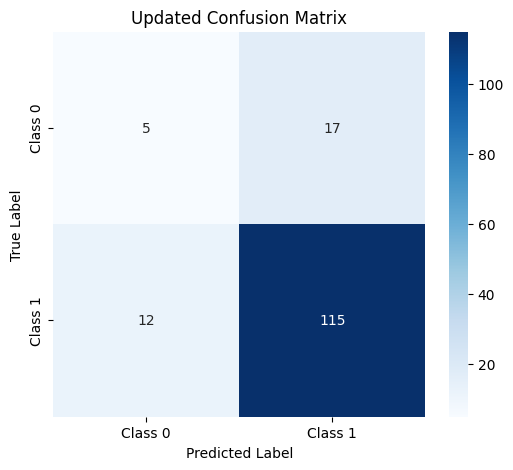

In [69]:
test_loss, test_acc = model.evaluate(fft_test, y_test)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


y_pred_probs = model.predict(fft_test)  
y_pred = (y_pred_probs > 0.5).astype("int32")  

print("Classification Report:\n", classification_report(y_test, y_pred, target_names=["Class 0", "Class 1"]))

cm = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Updated Confusion Matrix")
plt.show()



0.7619899785254116


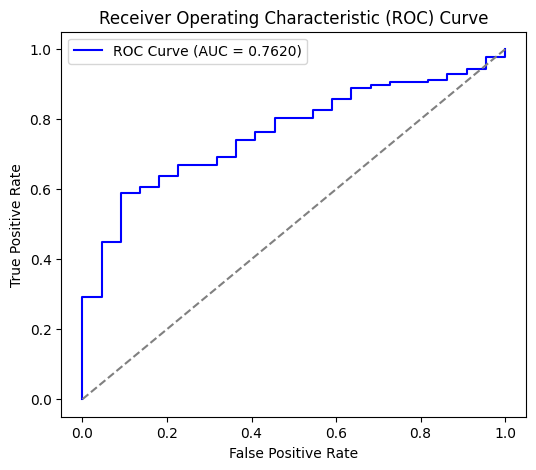

In [70]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)
print(roc_auc)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='grey', linestyle="--")  
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.show()


In [ ]:
# Normalize signal per each patient
# Include UPDRS -> 5 classes [0-5-10-15 ...] -> Regression -> same barplot of updrs for output 
# How the patient was classified (by its windows, barplots of # of pd, control per patient)
# TUG test used 


In [96]:
# -------------------------------
# Feature Extraction Functions
# -------------------------------

def entropy(signal):
    """Spectral entropy calculation"""
    psd = np.abs(np.fft.fft(signal))**2
    psd_norm = psd / np.sum(psd)  # Normalize
    return -np.sum(psd_norm * np.log2(psd_norm + 1e-12))

def lumpiness(signal, window=10):
    """Variance of sliding window variances"""
    num_windows = len(signal) // window
    window_vars = [np.var(signal[i*window:(i+1)*window]) for i in range(num_windows)]
    return np.var(window_vars)

def stationary_measure(signal, window=10):
    """Variance of sliding window means"""
    num_windows = len(signal) // window
    window_means = [np.mean(signal[i*window:(i+1)*window]) for i in range(num_windows)]
    return np.var(window_means)

def crossing_points(signal):
    """Counts zero-crossing points"""
    mean_val = np.mean(signal)
    return np.sum(np.diff(np.sign(signal - mean_val)) != 0)

def flat_spots(signal):
    """Finds longest flat segment"""
    bins = np.histogram(signal, bins=10)[0]
    return np.max(bins)

def mean_tkeo(signal):
    """Mean Teager-Kaiser Energy Operator"""
    return np.mean(signal[:-2]**2 - signal[1:-1] * signal[2:])

def rolling_variance_change(signal, window=10):
    """Computes rolling variance change"""
    roll_var = pd.Series(signal).rolling(window).var()
    return np.max(np.abs(np.diff(roll_var.dropna())))

def level_shift(signal, window=10):
    """Computes level shift using rolling mean"""
    roll_mean = pd.Series(signal).rolling(window).mean()
    return np.max(np.abs(np.diff(roll_mean.dropna())))

def autocorrelation(signal, lag=1):
    """Computes autocorrelation at lag 1"""
    return np.corrcoef(signal[:-lag], signal[lag:])[0, 1] if len(signal) > lag else np.nan

def coefficient_of_variation(signal):
    """Computes coefficient of variation"""
    return (np.std(signal) / np.mean(signal)) * 100 if np.mean(signal) != 0 else 0

def zero_crossing_rate(signal):
    """Computes Zero-Crossing Rate (ZCR)"""
    return np.sum(np.diff(np.sign(signal)) != 0) / len(signal)

def mean_teager_kaiser(signal):
    """Computes Mean Teager-Kaiser Energy Operator"""
    return np.mean(signal[:-2]**2 - signal[1:-1] * signal[2:])



In [97]:
# -------------------------------
# Single Axis Feature Extraction
# -------------------------------

def extract_single_axis_features(signal, axis_name):
    """Extracts features for a single accelerometer/gyroscope axis"""
    
    # Basic Statistics
    mean_val = np.mean(signal)
    std_val = np.std(signal)
    skew_val = skew(signal)
    kurt_val = kurtosis(signal)
    
    quantiles = np.percentile(signal, [0, 10, 25, 50, 75, 90, 100])
    
    # Derived Features
    entropy_val = entropy(signal)
    lumpiness_val = lumpiness(signal)
    stationary_val = stationary_measure(signal)
    crossing_val = crossing_points(signal)
    flat_spots_val = flat_spots(signal)
    mean_tkeo_val = mean_tkeo(signal)
    rolling_var_change_val = rolling_variance_change(signal)
    level_shift_val = level_shift(signal)
    autocorr_val = autocorrelation(signal)
    coeff_var_val = coefficient_of_variation(signal)
    zero_crossing_val = zero_crossing_rate(signal)

    # Pack features
    feature_dict = {
        f"mean_{axis_name}": mean_val,
        f"std_{axis_name}": std_val,
        f"skew_{axis_name}": skew_val,
        f"kurt_{axis_name}": kurt_val,
        f"entropy_{axis_name}": entropy_val,
        f"lumpiness_{axis_name}": lumpiness_val,
        f"stationary_{axis_name}": stationary_val,
        f"crossing_{axis_name}": crossing_val,
        f"flat_spots_{axis_name}": flat_spots_val,
        f"mean_tkeo_{axis_name}": mean_tkeo_val,
        f"rolling_var_change_{axis_name}": rolling_var_change_val,
        f"level_shift_{axis_name}": level_shift_val,
        f"autocorr_{axis_name}": autocorr_val,
        f"coeff_var_{axis_name}": coeff_var_val,
        f"zero_crossing_{axis_name}": zero_crossing_val,
        **{f"q{idx}_{axis_name}": quantiles[idx] for idx in range(len(quantiles))}
    }
    
    return feature_dict



In [98]:
# -------------------------------
# Apply Feature Extraction to Windowed Data
# -------------------------------

def extract_features_from_windows(windows):
    """
    Extracts features from windowed gait data.
    """
    num_windows, _, num_features = windows.shape
    feature_list = []
    
    for i in range(num_windows):
        feature_dict = {}

        # Extract features per axis
        for j in range(num_features):
            feature_dict.update(extract_single_axis_features(windows[i, :, j], f"axis_{j}"))

        feature_list.append(feature_dict)

    return pd.DataFrame(feature_list)

In [111]:
# -------------------------------
# Apply to Training, Validation, and Test Data
# -------------------------------

features_train = extract_features_from_windows(windows_train)
features_val = extract_features_from_windows(windows_val)
features_test = extract_features_from_windows(windows_test)


Classification Report:
               precision    recall  f1-score   support

           0       0.32      0.32      0.32        22
           1       0.88      0.88      0.88       127

    accuracy                           0.80       149
   macro avg       0.60      0.60      0.60       149
weighted avg       0.80      0.80      0.80       149



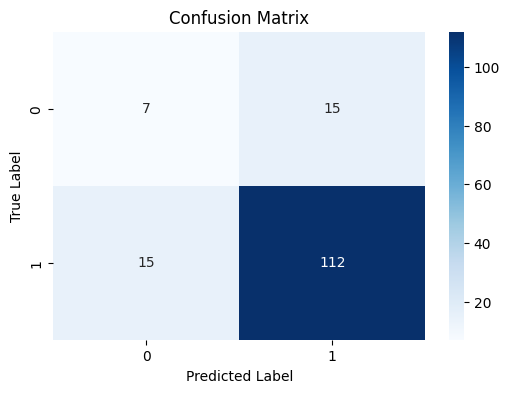

ROC-AUC Score: 0.6684


In [112]:
# Apply SMOTE to balance class distribution
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(features_train, labels_train)

# Train RF with balanced data
clf = RandomForestClassifier(random_state=42, class_weight="balanced", n_estimators=100)
clf.fit(X_train_resampled, y_train_resampled)

y_pred = clf.predict(features_test)
print("Classification Report:\n", classification_report(labels_test, y_pred))


conf_matrix = confusion_matrix(labels_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

roc_auc = roc_auc_score(labels_test, y_prob)
print(f"ROC-AUC Score: {roc_auc:.4f}")


Classification Report:
               precision    recall  f1-score   support

           0       0.27      0.27      0.27        22
           1       0.87      0.87      0.87       127

    accuracy                           0.79       149
   macro avg       0.57      0.57      0.57       149
weighted avg       0.79      0.79      0.79       149



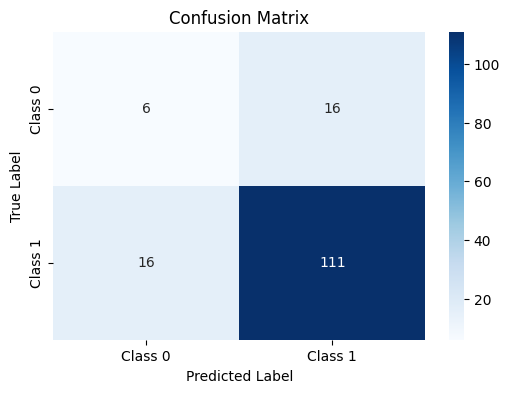

ROC-AUC Score: 0.7126


In [ ]:
scale_pos_weight = len(y_train_resampled[y_train_resampled == 0]) / len(y_train_resampled[y_train_resampled == 1])

# -------------------------------
# Train XGBoost with scale_pos_weight
# -------------------------------
clf_xgb = XGBClassifier(
    scale_pos_weight=scale_pos_weight,  
    max_depth=10,  
    learning_rate=0.05,  
    n_estimators=200,  
    subsample=0.8,  
    colsample_bytree=0.8,  
    eval_metric="logloss",
    random_state=42
)

clf_xgb.fit(X_train_resampled, y_train_resampled)

# -------------------------------
# Make Predictions
# -------------------------------
y_pred = clf_xgb.predict(features_test)
y_prob = clf_xgb.predict_proba(features_test)[:, 1]  # Probabilities for ROC-AUC

# -------------------------------
# Classification Report
# -------------------------------
print("Classification Report:\n", classification_report(labels_test, y_pred))

# -------------------------------
# Confusion Matrix
# -------------------------------
conf_matrix = confusion_matrix(labels_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# -------------------------------
# Compute ROC-AUC Score
# -------------------------------
roc_auc = roc_auc_score(labels_test, y_prob)
print(f"ROC-AUC Score: {roc_auc:.4f}")


In [ ]:
import pywt

wavelet_name = 'morl'  # Morlet wavelet
fs = 300  # Window size (300 samples per window)
scales = np.arange(1, fs)  # Range of scales for wavelet transform

def convert_to_cwt(windows):
    """
    Converts time-series windows into wavelet scalograms (images).

    """
    num_windows, _, num_features = windows.shape
    X_cwt = np.ndarray(shape=(num_windows, fs-1, fs-1, num_features))

    for i in range(num_windows):
        if i % 100 == 0:
            print(f"Processing window {i}/{num_windows}...")
        for j in range(num_features):
            signal = windows[i, :, j]
            coeffs, _ = pywt.cwt(signal, scales, wavelet_name, 1)  # Apply CWT
            X_cwt[i, :, :, j] = coeffs[:, :fs-1]  # Store transformed scalogram
    return X_cwt

X_train_cwt = convert_to_cwt(windows_train)
X_val_cwt = convert_to_cwt(windows_val)
X_test_cwt = convert_to_cwt(windows_test)

print("CWT Train shape:", X_train_cwt.shape)
print("CWT Val shape:", X_val_cwt.shape)
print("CWT Test shape:", X_test_cwt.shape)


Processing window 0/483...
Processing window 100/483...
Processing window 200/483...
Processing window 300/483...
Processing window 400/483...
Processing window 0/129...
Processing window 100/129...
Processing window 0/149...
Processing window 100/149...
CWT Train shape: (483, 299, 299, 12)
CWT Val shape: (129, 299, 299, 12)
CWT Test shape: (149, 299, 299, 12)


In [ ]:
num_features = 12  
model = keras.models.Sequential([
    # First CNN layer
    keras.layers.Conv2D(32, kernel_size=(3,3), activation="relu", input_shape=(299, 299, num_features)),
    keras.layers.MaxPooling2D(pool_size=(2,2)),

    # Second CNN layer
    keras.layers.Conv2D(64, kernel_size=(3,3), activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2,2)),

    # Third CNN layer
    keras.layers.Conv2D(128, kernel_size=(3,3), activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2,2)),

    # Flatten the feature maps
    keras.layers.Flatten(),
    
    # Fully connected layers
    keras.layers.Dense(300, activation="relu"),                 
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")  
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 297, 297, 32)   │         3,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 148, 148, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 146, 146, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 73, 73, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 71, 71, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 35, 35, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 156800)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 300)            │    47,040,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,166,341 (179.93 MB)

 Trainable params: 47,166,341 (179.93 MB)

 Non-trainable params: 0 (0.00 B)

In [129]:
# Train CNN on wavelet-transformed gait windows
history = model.fit(
    X_train_cwt, labels_train,
    epochs=20, batch_size=32,
    validation_data=(X_val_cwt, labels_val)
)


Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.8145 - loss: 1.4495 - val_accuracy: 0.8605 - val_loss: 0.4732
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.8773 - loss: 0.4199 - val_accuracy: 0.8605 - val_loss: 0.4433
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.8595 - loss: 0.4189 - val_accuracy: 0.8605 - val_loss: 0.4979
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.8576 - loss: 0.4103 - val_accuracy: 0.8140 - val_loss: 0.5333
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.8886 - loss: 0.3268 - val_accuracy: 0.7829 - val_loss: 0.5533
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.8832 - loss: 0.3004 - val_accuracy: 0.7597 - val_loss: 0.6804
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.8971 - loss: 0.2724 - val_accuracy: 0.8450 - val_loss: 0.5689
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.9196 - loss: 0.1992 - val_accuracy: 0.7907 - val_loss:

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 367ms/step - accuracy: 0.8649 - loss: 0.5747
Test Accuracy: 0.8121
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 328ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.36      0.36      0.36        22
           1       0.89      0.89      0.89       127

    accuracy                           0.81       149
   macro avg       0.63      0.63      0.63       149
weighted avg       0.81      0.81      0.81       149



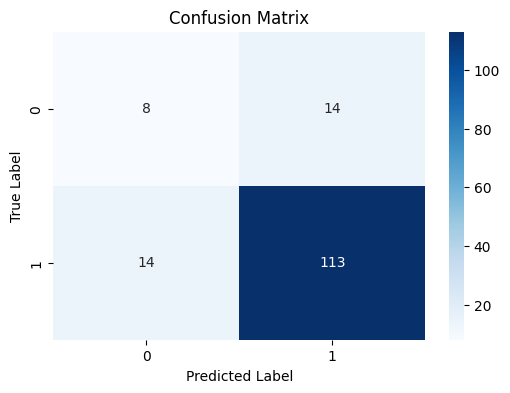

ROC-AUC Score: 0.6636


In [ ]:
test_loss, test_acc = model.evaluate(X_test_cwt, labels_test)
print(f"Test Accuracy: {test_acc:.4f}")

y_pred_prob = model.predict(X_test_cwt)
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary labels

print("Classification Report:\n", classification_report(labels_test, y_pred))


conf_matrix = confusion_matrix(labels_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

roc_auc = roc_auc_score(labels_test, y_pred_prob)
print(f"ROC-AUC Score: {roc_auc:.4f}")

In [85]:
X_train = windows_train
y_train = labels_train

X_val = windows_val
y_val = labels_val

X_test = windows_test
y_test = labels_test


In [88]:
# Define input shape: (window_size, num_features)
input_shape = (300, 12)

# Build the model
model = Sequential([
    # 1D CNN for feature extraction
    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', input_shape=input_shape),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    
    # LSTM for temporal dependencies
    Bidirectional(LSTM(64, return_sequences=True)),  
    Bidirectional(LSTM(32)),

    # Fully connected layers
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


c:\Users\35262\.conda\envs\fogenv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 300, 64)        │         2,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 150, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 150, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 75, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 75, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 171,329 (669.25 KB)

 Trainable params: 171,329 (669.25 KB)

 Non-trainable params: 0 (0.00 B)

In [89]:
# Train the model
history = model.fit(
    X_train, y_train, 
    epochs=30,  # Adjust based on validation performance
    batch_size=32,  # Adjust based on memory availability
    validation_data=(X_val, y_val),
    verbose=1
)

# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")


Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 145ms/step - accuracy: 0.8163 - loss: 0.5329 - val_accuracy: 0.8605 - val_loss: 0.4040
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.8876 - loss: 0.3690 - val_accuracy: 0.8605 - val_loss: 0.4046
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.8518 - loss: 0.4555 - val_accuracy: 0.8605 - val_loss: 0.4064
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.8852 - loss: 0.3697 - val_accuracy: 0.8605 - val_loss: 0.4044
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.8535 - loss: 0.4498 - val_accuracy: 0.8605 - val_loss: 0.4041
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.8837 - loss: 0.3650 - val_accuracy: 0.8605 - val_loss: 0.4056
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.8779 - loss: 0.3653 - val_accuracy: 0.8605 - val_loss: 0.4080
Epoch 8/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.8528 - loss: 0.4358 - val_accuracy: 0.8605 -

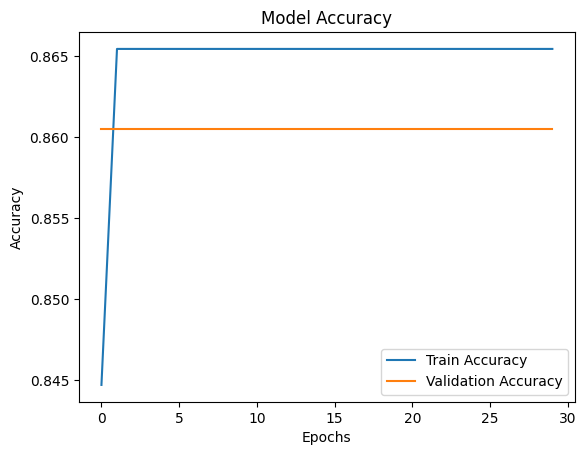

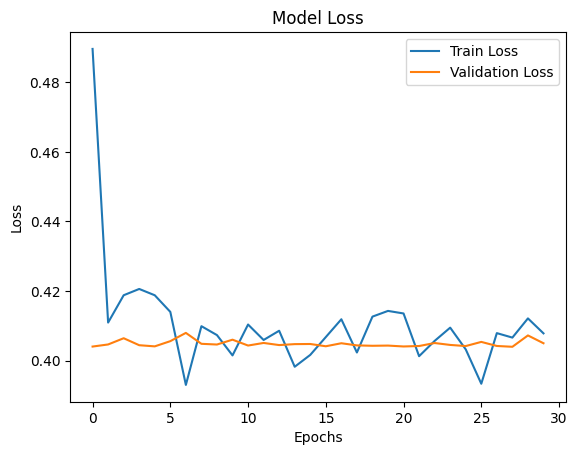

In [90]:
# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
history = model.fit(X_train, y_train, epochs=30, batch_size=32, 
                    validation_data=(X_val, y_val), verbose=1)


In [76]:
# Hyperparameters
input_size = 12  # Number of features (e.g., 12 for your accelerometer and gyroscope data)
hidden_size = 64  # Number of hidden units in LSTM
num_layers = 2  # Number of LSTM layers
num_classes = 1  # Binary classification (0 or 1)
learning_rate = 0.001
num_epochs = 50
batch_size = 32

In [78]:
# Initialize the model
model = LSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)

# Loss and optimizer
criterion = nn.BCELoss()  # Binary cross-entropy loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    for batch_data, batch_labels in train_loader:
        # Forward pass
        outputs = model(batch_data)
        loss = criterion(outputs.squeeze(), batch_labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(val_data)
        val_loss = criterion(val_outputs.squeeze(), val_labels)
        val_preds = (val_outputs > 0.5).float()
        val_accuracy = (val_preds == val_labels).float().mean()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Val Accuracy: {val_accuracy.item():.4f}')



Epoch [1/50], Loss: 0.4225, Val Loss: 0.4767, Val Accuracy: 0.8605
Epoch [2/50], Loss: 0.1166, Val Loss: 0.4162, Val Accuracy: 0.8605
Epoch [3/50], Loss: 0.7569, Val Loss: 0.4040, Val Accuracy: 0.8605
Epoch [4/50], Loss: 0.6986, Val Loss: 0.4048, Val Accuracy: 0.8605
Epoch [5/50], Loss: 0.1532, Val Loss: 0.4042, Val Accuracy: 0.8605
Epoch [6/50], Loss: 1.3482, Val Loss: 0.4052, Val Accuracy: 0.8605
Epoch [7/50], Loss: 0.1984, Val Loss: 0.4067, Val Accuracy: 0.8605
Epoch [8/50], Loss: 0.1743, Val Loss: 0.4047, Val Accuracy: 0.8605
Epoch [9/50], Loss: 0.1488, Val Loss: 0.4047, Val Accuracy: 0.8605
Epoch [10/50], Loss: 0.1296, Val Loss: 0.4041, Val Accuracy: 0.8605
Epoch [11/50], Loss: 0.8396, Val Loss: 0.4042, Val Accuracy: 0.8605
Epoch [12/50], Loss: 0.8161, Val Loss: 0.4044, Val Accuracy: 0.8605
Epoch [13/50], Loss: 0.1549, Val Loss: 0.4042, Val Accuracy: 0.8605
Epoch [14/50], Loss: 0.1426, Val Loss: 0.4048, Val Accuracy: 0.8605
Epoch [15/50], Loss: 0.1431, Val Loss: 0.4042, Val Accura

In [79]:
# Testing
model.eval()
with torch.no_grad():
    test_outputs = model(test_data)
    test_preds = (test_outputs > 0.5).float().cpu().numpy()
    test_labels = test_labels.cpu().numpy()

# Print classification report and confusion matrix
print("Classification Report:")
print(classification_report(test_labels, test_preds))
print("Confusion Matrix:")
print(confusion_matrix(test_labels, test_preds))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        22
         1.0       0.85      1.00      0.92       127

    accuracy                           0.85       149
   macro avg       0.43      0.50      0.46       149
weighted avg       0.73      0.85      0.78       149

Confusion Matrix:
[[  0  22]
 [  0 127]]


c:\Users\35262\.conda\envs\fogenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\35262\.conda\envs\fogenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\35262\.conda\envs\fogenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [60]:
# Convert to PyTorch tensors
X_train, y_train = torch.tensor(windows_train, dtype=torch.float32), torch.tensor(labels_train, dtype=torch.long)
X_val, y_val = torch.tensor(windows_val, dtype=torch.float32), torch.tensor(labels_val, dtype=torch.long)
X_test, y_test = torch.tensor(windows_test, dtype=torch.float32), torch.tensor(labels_test, dtype=torch.long)

# Create PyTorch Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TimeSeriesDataset(X_train, y_train)
val_dataset = TimeSeriesDataset(X_val, y_val)
test_dataset = TimeSeriesDataset(X_test, y_test)

# Handle class imbalance using WeightedRandomSampler
class_counts = torch.bincount(y_train)
weights = 1.0 / class_counts.float()
sample_weights = weights[y_train]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(y_train), replacement=True)

# Data Loaders
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [61]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]  # Get the last timestep output
        out = self.fc(lstm_out)
        return out

# Define model
input_dim = 12  # Number of features per timestep
hidden_dim = 64
num_layers = 2
output_dim = 2  # Binary classification

model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)


In [62]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss function with class weighting
class_counts = torch.bincount(y_train)
class_weights = 1.0 / class_counts.float()
class_weights = class_weights.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct, total = 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}, Train Accuracy: {train_acc:.4f}")


Epoch 1, Loss: 9.8143, Train Accuracy: 0.5093
Epoch 2, Loss: 6.9123, Train Accuracy: 0.4865
Epoch 3, Loss: 6.3376, Train Accuracy: 0.5052
Epoch 4, Loss: 6.3972, Train Accuracy: 0.4990
Epoch 5, Loss: 6.3204, Train Accuracy: 0.5280
Epoch 6, Loss: 6.4406, Train Accuracy: 0.4907
Epoch 7, Loss: 6.8807, Train Accuracy: 0.4865
Epoch 8, Loss: 6.4564, Train Accuracy: 0.4907
Epoch 9, Loss: 6.7239, Train Accuracy: 0.4969
Epoch 10, Loss: 6.9850, Train Accuracy: 0.4534
Epoch 11, Loss: 8.0588, Train Accuracy: 0.5031
Epoch 12, Loss: 6.6905, Train Accuracy: 0.4928
Epoch 13, Loss: 6.2786, Train Accuracy: 0.4969
Epoch 14, Loss: 8.2211, Train Accuracy: 0.4886
Epoch 15, Loss: 6.8923, Train Accuracy: 0.4762
Epoch 16, Loss: 8.3290, Train Accuracy: 0.4907
Epoch 17, Loss: 6.6568, Train Accuracy: 0.4928
Epoch 18, Loss: 8.1437, Train Accuracy: 0.4969
Epoch 19, Loss: 6.7286, Train Accuracy: 0.4948
Epoch 20, Loss: 8.2574, Train Accuracy: 0.4658


In [64]:
def evaluate_model(model, dataloader):
    model.eval()
    all_preds, all_labels = [], []
    all_probs = []  # Store softmax probabilities

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)  # Raw logits

            probs = torch.nn.functional.softmax(outputs, dim=1)  # Apply softmax
            _, preds = torch.max(outputs, 1)  # Get class predictions

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())  # Store probabilities

    acc = accuracy_score(all_labels, all_preds)
    logloss = log_loss(all_labels, all_probs)  # Use probabilities instead of class labels
    conf_matrix = confusion_matrix(all_labels, all_preds)

    return acc, logloss, conf_matrix

val_acc, val_loss, val_conf_matrix = evaluate_model(model, val_loader)
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation Log Loss: {val_loss:.4f}")
print(f"Confusion Matrix:\n {val_conf_matrix}")


Validation Accuracy: 0.1395
Validation Log Loss: 1.5253
Confusion Matrix:
 [[ 18   0]
 [111   0]]


c:\Users\35262\.conda\envs\fogenv\lib\site-packages\sklearn\metrics\_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


In [46]:
# just to test if windows are correclty assigned
train_p0 = train_data[train_data.SubID=='ND7142_V2']
train_p0_id = train_p0.SubID.iloc[0]
train_p0_wins = sub_ids_train.count(train_p0_id)
print(f'train_p0: {len(train_p0)}, sub_id = {train_p0_id}, # wins= {train_p0_wins}')

train_p1 = train_data[train_data.SubID=='ND0015_V8']
train_p1_id = train_p1.SubID.iloc[0]
train_p1_wins = sub_ids_train.count(train_p1_id)
print(f'train_p1: {len(train_p1)}, sub_id = {train_p1_id}, # wins= {train_p1_wins}')


val_p0 =val_data[val_data.SubID=='ND3521_V2']
val_p0_id = val_p0.SubID.iloc[0]
val_p0_wins = sub_ids_val.count(val_p0_id)
print(f'val_p0: {len(val_p0)}, sub_id = {val_p0_id}, # wins= {val_p0_wins}')

val_p1 = val_data[val_data.SubID=='ND0027_V8']
val_p1_id = val_p1.SubID.iloc[0]
val_p1_wins = sub_ids_val.count(val_p1_id)
print(f'val_p1: {len(val_p1)}, sub_id = {val_p1_id}, # wins= {val_p1_wins}')

test_p0 = test_data[test_data.SubID=='ND3522_V2']
test_p0_id = test_p0.SubID.iloc[0]
test_p0_wins = sub_ids_test.count(test_p0_id)
print(f'test_p0: {len(test_p0)}, sub_id = {test_p0_id}, # wins= {test_p0_wins}')

test_p1 = test_data[test_data.SubID=='ND0026_V8']
test_p1_id = test_p1.SubID.iloc[0]
test_p1_wins = sub_ids_test.count(test_p1_id)
print(f'test_p1: {len(test_p1)}, sub_id = {test_p1_id}, # wins= {test_p1_wins}')


train_p0: 946, sub_id = ND7142_V2, # wins= 5
train_p1: 994, sub_id = ND0015_V8, # wins= 5
val_p0: 1144, sub_id = ND3521_V2, # wins= 6
val_p1: 3091, sub_id = ND0027_V8, # wins= 19
test_p0: 1065, sub_id = ND3522_V2, # wins= 6
test_p1: 1265, sub_id = ND0026_V8, # wins= 7


### Use Raw Windowed Data Directly

In [135]:
# Train Random Forest on extracted features
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(train_features, labels_train)

# Predict on validation set
val_preds = clf.predict(val_features)

# Evaluate model
val_acc = accuracy_score(labels_val, val_preds)
print(f'Validation Accuracy: {val_acc:.4f}')


Validation Accuracy: 0.8682


In [136]:
# Predict on the test set
test_preds = clf.predict(test_features)

# Evaluate test performance
test_acc = accuracy_score(labels_test, test_preds)
print(f'Test Accuracy: {test_acc:.4f}')


Test Accuracy: 0.8121


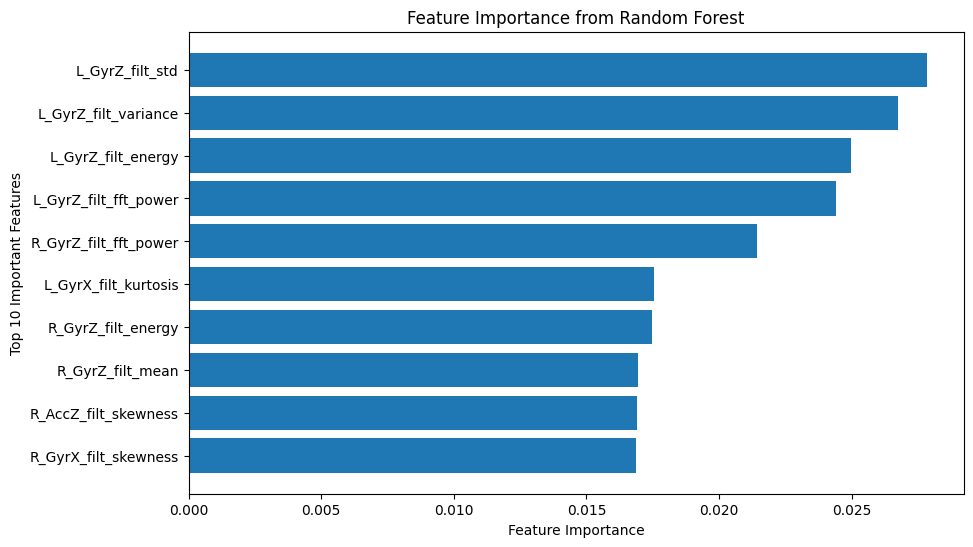

In [137]:
# Get feature importance
feature_importances = clf.feature_importances_
feature_names = train_features.columns  # Assuming train_features is a DataFrame

# Sort features by importance
sorted_idx = np.argsort(feature_importances)[::-1]

# Plot
plt.figure(figsize=(10, 6))
plt.barh([feature_names[i] for i in sorted_idx[:10]], feature_importances[sorted_idx[:10]])
plt.xlabel("Feature Importance")
plt.ylabel("Top 10 Important Features")
plt.title("Feature Importance from Random Forest")
plt.gca().invert_yaxis()
plt.show()


In [142]:
top_n = 10  # Adjust based on importance scores
top_features = [feature_names[i] for i in sorted_idx[:top_n]]

# Filter datasets
train_features_selected = train_features[top_features]
val_features_selected = val_features[top_features]
test_features_selected = test_features[top_features]


In [144]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(clf, train_features_selected, labels_train, cv=10, scoring='accuracy')
print(f"Mean CV Accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")


Mean CV Accuracy: 0.8551 ± 0.0186


In [145]:
clf.fit(train_features_selected, labels_train)

# Predict on test set
test_preds = clf.predict(test_features_selected)

# Evaluate
test_acc = accuracy_score(labels_test, test_preds)
print(f"Final Test Accuracy: {test_acc:.4f}")


Final Test Accuracy: 0.7651


In [148]:
from sklearn.svm import SVC
from xgboost import XGBClassifier

models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel='rbf', probability=True),
    "XGBoost": XGBClassifier(eval_metric='logloss')

}

for name, model in models.items():
    model.fit(train_features_selected, labels_train)
    preds = model.predict(val_features_selected)
    acc = accuracy_score(labels_val, preds)
    print(f"{name} Validation Accuracy: {acc:.4f}")


Random Forest Validation Accuracy: 0.8682
SVM Validation Accuracy: 0.8605
XGBoost Validation Accuracy: 0.8527


In [149]:
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel='rbf', probability=True),
    "XGBoost": XGBClassifier(eval_metric='logloss')
}

# Train and evaluate each model
for name, model in models.items():
    model.fit(train_features, labels_train)
    preds = model.predict(val_features)
    val_acc = accuracy_score(labels_val, preds)
    print(f"{name} Validation Accuracy: {val_acc:.4f}")

    # Compute log loss for probabilistic models
    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(val_features)
        log_loss_val = log_loss(labels_val, probs)
        print(f"{name} Log Loss: {log_loss_val:.4f}")

    print()


Random Forest Validation Accuracy: 0.8682
Random Forest Log Loss: 0.6134

SVM Validation Accuracy: 0.8605
SVM Log Loss: 0.4302

XGBoost Validation Accuracy: 0.8450
XGBoost Log Loss: 0.6549



In [115]:
# Apply FFT without max_freq (keeps full spectrum)
fft_train_full, freq_bins_train_full = apply_fft_to_windows(windows_train, sampling_rate=100)
fft_val_full, freq_bins_val_full = apply_fft_to_windows(windows_val, sampling_rate=100)
fft_test_full, freq_bins_test_full = apply_fft_to_windows(windows_test, sampling_rate=100)

print(f"FFT Full Shape (Train): {fft_train_full.shape}")  
print(f"FFT Full Shape (Validation): {fft_val_full.shape}")  
print(f"FFT Full Shape (Test): {fft_test_full.shape}")  

FFT Full Shape (Train): (483, 151, 12)
FFT Full Shape (Validation): (129, 151, 12)
FFT Full Shape (Test): (149, 151, 12)


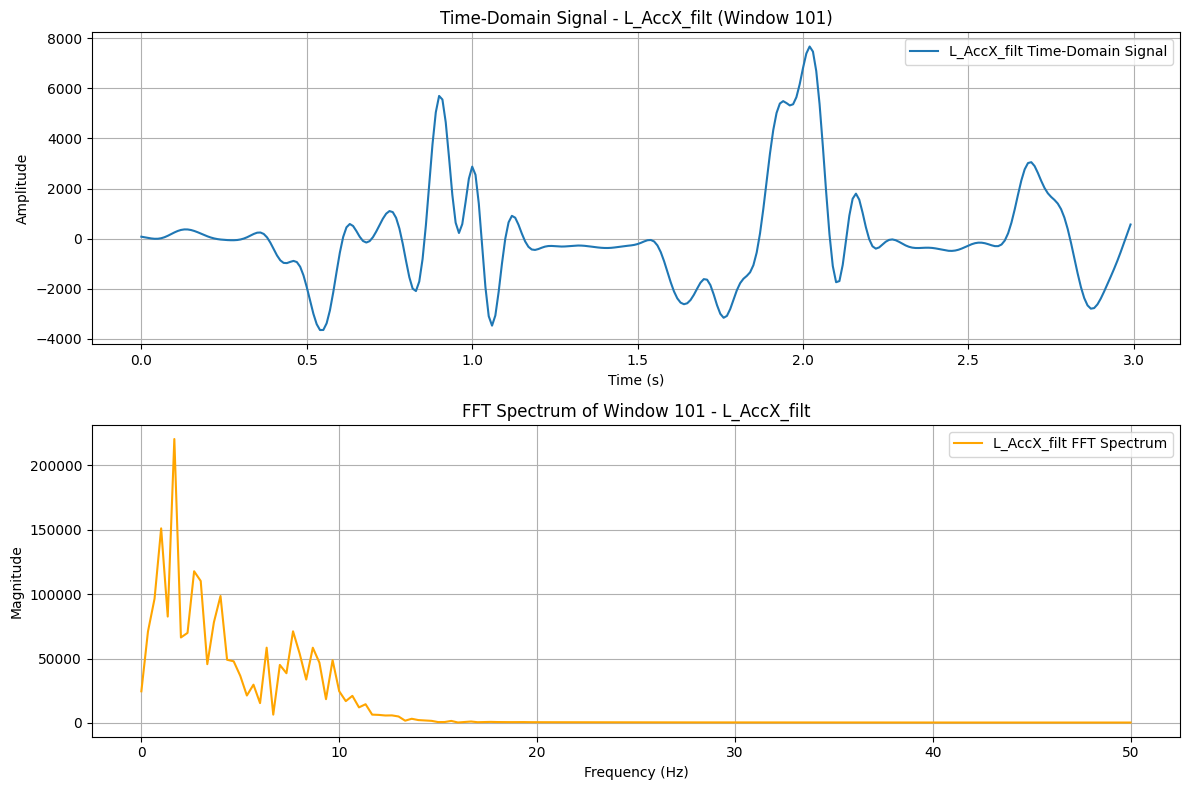

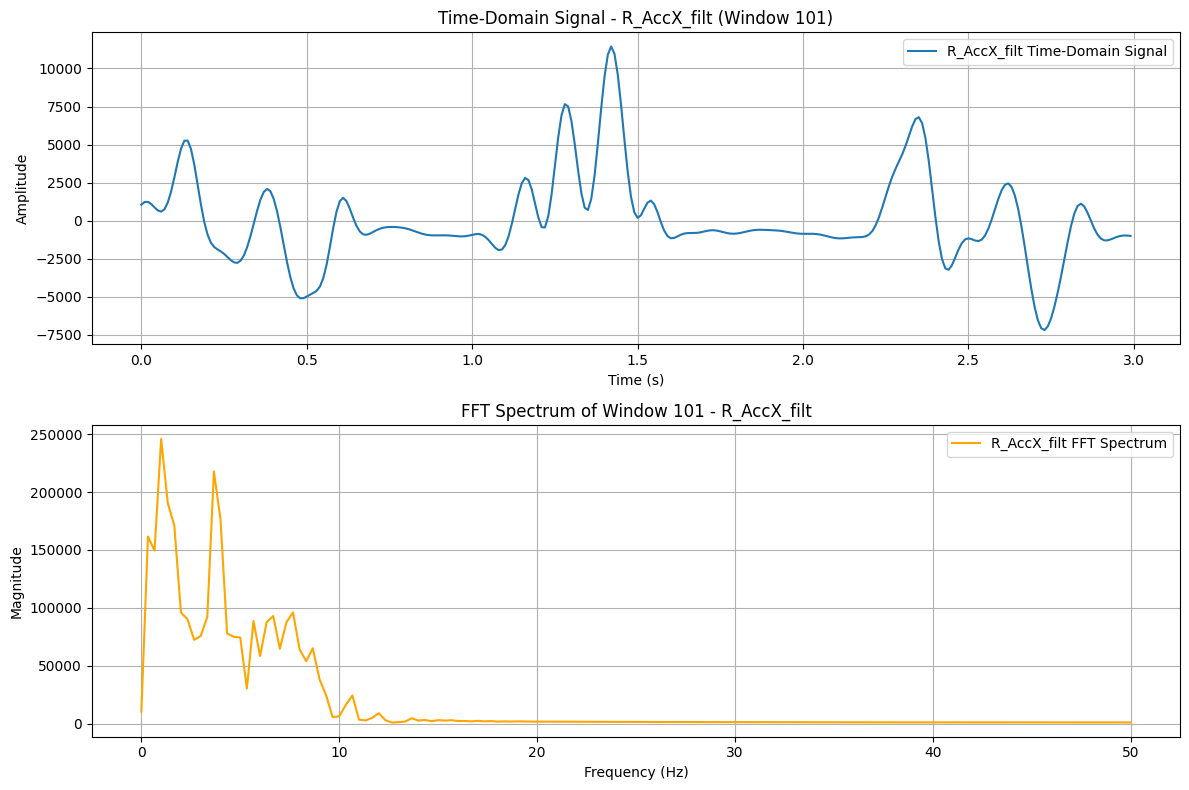

In [116]:
# Plotting the n-th window for the first feature (e.g., L_AccX_filt)
plot_time_and_fft(windows_train, fft_train_full, freq_bins_train_full, window_idx=100, feature_idx=0, feature_name='L_AccX_filt')

# Plotting the n-th window for another feature (e.g., R_AccX_filt)
plot_time_and_fft(windows_train, fft_train_full, freq_bins_train_full, window_idx=100, feature_idx=6, feature_name='R_AccX_filt')

In [117]:
# Apply filtering to Train, Validation, and Test sets
fft_train_filtered, freq_bins_train_filtered = filter_fft_bands(fft_train_full, freq_bins_train_full, max_freq=15)
fft_val_filtered, freq_bins_val_filtered = filter_fft_bands(fft_val_full, freq_bins_val_full, max_freq=15)
fft_test_filtered, freq_bins_test_filtered = filter_fft_bands(fft_test_full, freq_bins_test_full, max_freq=15)

print(f"FFT Filtered Shape (Train): {fft_train_filtered.shape}")  
print(f"FFT Filtered Shape (Validation): {fft_val_filtered.shape}")  
print(f"FFT Filtered Shape (Test): {fft_test_filtered.shape}")  



FFT Filtered Shape (Train): (483, 46, 12)
FFT Filtered Shape (Validation): (129, 46, 12)
FFT Filtered Shape (Test): (149, 46, 12)


In [118]:
# Normalize the Filtered FFT Data

scaler = MinMaxScaler()

# Flatten data for normalization, then reshape it back
fft_train_scaled = scaler.fit_transform(fft_train_filtered.reshape(-1, fft_train_filtered.shape[-1])).reshape(fft_train_filtered.shape)
fft_val_scaled = scaler.transform(fft_val_filtered.reshape(-1, fft_val_filtered.shape[-1])).reshape(fft_val_filtered.shape)
fft_test_scaled = scaler.transform(fft_test_filtered.reshape(-1, fft_test_filtered.shape[-1])).reshape(fft_test_filtered.shape)

print(f"FFT Normalized Shape (Train): {fft_train_scaled.shape}")  
print(f"FFT Normalized Shape (Validation): {fft_val_scaled.shape}")  
print(f"FFT Normalized Shape (Test): {fft_test_scaled.shape}")  

FFT Normalized Shape (Train): (483, 46, 12)
FFT Normalized Shape (Validation): (129, 46, 12)
FFT Normalized Shape (Test): (149, 46, 12)


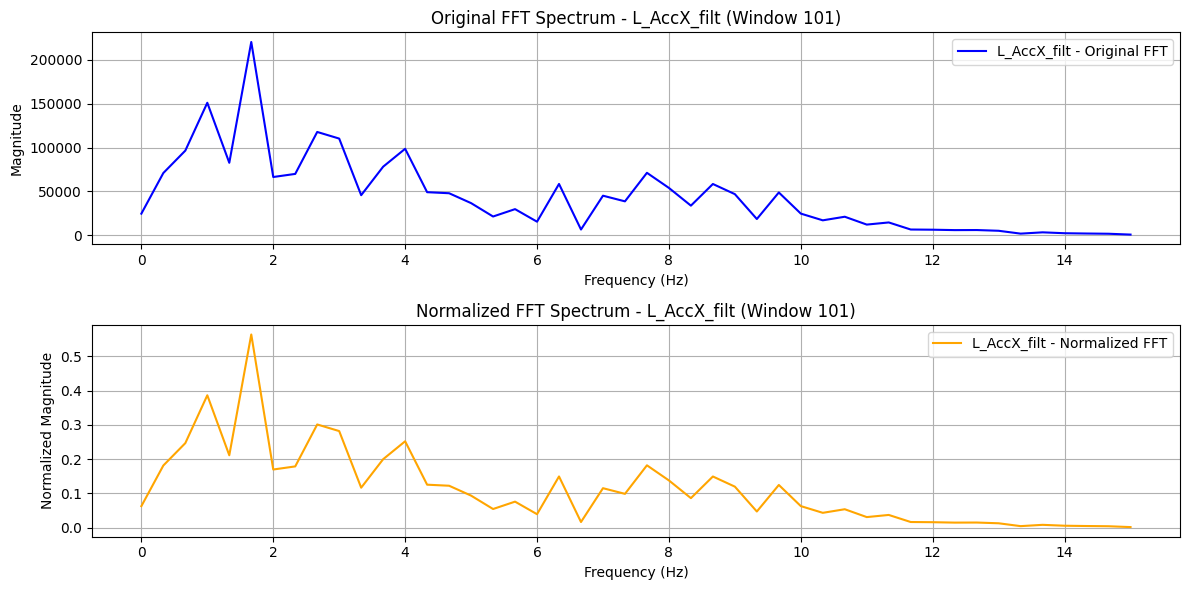

In [119]:
def plot_fft_before_after(original_fft, normalized_fft, freq_bins, window_idx=0, feature_idx=0, feature_name="Feature"):
    """
    Plots FFT magnitude before and after normalization for a specific window & feature.

    """
    # Extract the selected feature and window
    original_spectrum = original_fft[window_idx, :, feature_idx]
    normalized_spectrum = normalized_fft[window_idx, :, feature_idx]

    # Plot the spectra
    plt.figure(figsize=(12, 6))

    # Original FFT
    plt.subplot(2, 1, 1)
    plt.plot(freq_bins, original_spectrum, label=f"{feature_name} - Original FFT", color='blue')
    plt.title(f"Original FFT Spectrum - {feature_name} (Window {window_idx+1})")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.legend()
    plt.grid()

    # Normalized FFT
    plt.subplot(2, 1, 2)
    plt.plot(freq_bins, normalized_spectrum, label=f"{feature_name} - Normalized FFT", color='orange')
    plt.title(f"Normalized FFT Spectrum - {feature_name} (Window {window_idx+1})")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Normalized Magnitude")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

# Example usage
plot_fft_before_after(fft_train_filtered, fft_train_scaled, freq_bins_train_filtered, window_idx=100, feature_idx=0, feature_name="L_AccX_filt")


In [110]:
def extract_features_from_fft(fft_data):
    """
    Extracts statistical and power-related features from FFT data:
    - Mean Frequency
    - Variance of Frequency Components
    - Spectral Entropy
    - Total Power
    - Relative Power
    """
    # Mean Frequency
    mean_freq = np.mean(fft_data, axis=1)

    # Variance of Frequency Components
    var_freq = np.var(fft_data, axis=1)

    # Spectral Entropy
    entropy_freq = -np.sum(fft_data * np.log(fft_data + 1e-10), axis=1)

    # Total Power (Sum of Squared FFT Values)
    total_power = np.sum(fft_data ** 2, axis=1)

    # Relative Power (Each Frequency’s Contribution to Total Power)
    relative_power = total_power / (np.sum(total_power, axis=1, keepdims=True) + 1e-10)

    # Stack all extracted features
    return np.hstack([mean_freq, var_freq, entropy_freq, total_power, relative_power])

# Apply feature extraction to all datasets
fft_train_features = extract_features_from_fft(fft_train_scaled)
fft_val_features = extract_features_from_fft(fft_val_scaled)
fft_test_features = extract_features_from_fft(fft_test_scaled)

# Print feature shapes
print("Extracted Features Shape (Train):", fft_train_features.shape)
print("Extracted Features Shape (Validation):", fft_val_features.shape)
print("Extracted Features Shape (Test):", fft_test_features.shape)


Extracted Features Shape (Train): (483, 60)
Extracted Features Shape (Validation): (129, 60)
Extracted Features Shape (Test): (149, 60)


C:\Users\35262\AppData\Local\Temp\ipykernel_16412\1965494282.py:17: RuntimeWarning: invalid value encountered in log
  entropy_freq = -np.sum(fft_data * np.log(fft_data + 1e-10), axis=1)


In [ ]:
def extract_features_from_fft(fft_data):
    """
    Extracts additional features from FFT data: Mean, Variance, Entropy.
    
    Parameters:
    - fft_data: (num_samples, num_freq_bins, num_features)
    
    Returns:
    - Extracted features as (num_samples, num_features * 3)
    """
    mean_freq = np.mean(fft_data, axis=1)  # Mean Frequency
    var_freq = np.var(fft_data, axis=1)  # Variance of Frequency Components
    entropy_freq = -np.sum(fft_data * np.log(fft_data + 1e-10), axis=1)  # Spectral Entropy
    
    return np.hstack([mean_freq, var_freq, entropy_freq])  # Combine features

# Apply feature extraction to all datasets
fft_train_features = extract_features_from_fft(fft_train_scaled)
fft_val_features = extract_features_from_fft(fft_val_scaled)
fft_test_features = extract_features_from_fft(fft_test_scaled)


In [98]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dense, Dropout, BatchNormalization

def build_bi_lstm_model(input_shape, num_classes=2):
    """
    Builds a Bi-LSTM model for time-series classification.

    Parameters:
    - input_shape: Tuple (sequence_length, feature_dim)
    - num_classes: Number of output classes (default: 2 for binary classification)

    Returns:
    - Compiled Bi-LSTM model
    """
    inputs = Input(shape=input_shape)

    # Bi-LSTM Layer
    x = Bidirectional(LSTM(128, return_sequences=True))(inputs)
    x = Dropout(0.3)(x)  # Dropout for regularization

    # Second Bi-LSTM Layer
    x = Bidirectional(LSTM(64, return_sequences=False))(x)  # No sequences output

    # Fully Connected Layers
    x = Dropout(0.3)(x)
    x = Dense(32, activation="relu")(x)
    x = Dropout(0.3)(x)

    # Output Layer
    output_activation = "softmax" if num_classes > 2 else "sigmoid"
    outputs = Dense(num_classes, activation=output_activation)(x)

    # Build and Compile Model
    model = Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss="binary_crossentropy" if num_classes == 2 else "categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model

# Define model
input_shape = (61, 12)  # (sequence_length, feature_dim)
num_classes = 2  # Binary classification

model = build_bi_lstm_model(input_shape, num_classes)
model.summary()


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 61, 12)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ (None, 61, 256)        │       144,384 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 61, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_12                │ (None, 128)            │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 312,930 (1.19 MB)

 Trainable params: 312,930 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

In [99]:
# Convert labels to one-hot encoding
y_train_cat = tf.keras.utils.to_categorical(labels_train, num_classes)
y_val_cat = tf.keras.utils.to_categorical(labels_val, num_classes)
y_test_cat = tf.keras.utils.to_categorical(labels_test, num_classes)

In [100]:
# Compute Class Weights
y_train_labels = np.argmax(y_train, axis=1)  # Convert one-hot labels to single-class format
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train_labels), y=y_train_labels)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

print(f"Class Weights: {class_weights_dict}")

# Define Early Stopping
early_stopping = EarlyStopping(
    monitor="val_loss",  # Stop when validation loss stops improving
    patience=5,  # Number of epochs to wait before stopping
    restore_best_weights=True  # Keep the best weights after stopping
)

# Train Model
history = model.fit(
    fft_train_scaled, y_train_cat,
    validation_data=(fft_val_scaled, y_val_cat),
    epochs=50,
    batch_size=32,
    class_weight=class_weights_dict,  # Handling class imbalance
    callbacks=[early_stopping]  # Prevent overfitting
)

# Evaluate Model
test_loss, test_acc = model.evaluate(fft_test_scaled, y_test_cat)
print(f"Test Accuracy: {test_acc:.4f}")

Class Weights: {0: np.float64(3.766990291262136), 1: np.float64(0.5765230312035661)}
Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.6643 - loss: 0.6399 - val_accuracy: 0.1685 - val_loss: 0.7157
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.3115 - loss: 0.6852 - val_accuracy: 0.8652 - val_loss: 0.6723
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.5964 - loss: 0.6830 - val_accuracy: 0.4494 - val_loss: 0.6965
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.5279 - loss: 0.6704 - val_accuracy: 0.6067 - val_loss: 0.6815
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.5388 - loss: 0.6445 - val_accuracy: 0.8764 - val_loss: 0.5980
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.8923 - loss: 0.6658 - val_accuracy: 0.8652 - val_loss: 0.6466
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.6309 - loss: 0.6534 - val_accuracy: 0.3933 - val_loss: 0.7556
Epoch 8/50
11/11 ━━━━━━━━━

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step

Evaluation Summary:
               precision    recall  f1-score   support

     Class 0       0.10      0.07      0.08        14
     Class 1       0.86      0.90      0.88        86

    accuracy                           0.78       100
   macro avg       0.48      0.48      0.48       100
weighted avg       0.75      0.78      0.76       100



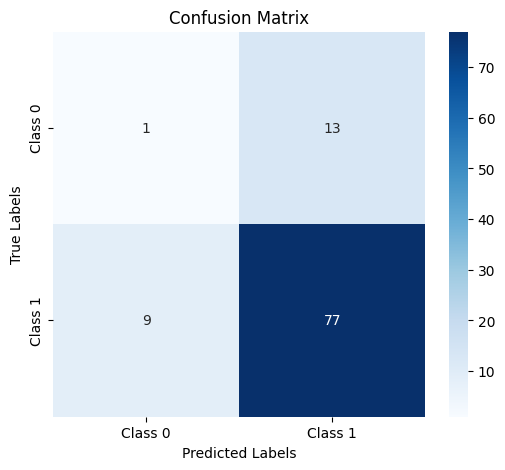

In [101]:
# Get Model Predictions
y_pred_probs = model.predict(fft_test_scaled)

# Convert Probabilities to Class Labels
y_pred = np.argmax(y_pred_probs, axis=1)  # Softmax → Class labels
y_true = np.argmax(y_test_cat, axis=1)  # Convert One-Hot to Class Labels

# Compute Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Print Classification Report
print("\nEvaluation Summary:\n", classification_report(y_true, y_pred, target_names=["Class 0", "Class 1"]))

# Plot Confusion Matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

plot_confusion_matrix(conf_matrix, ["Class 0", "Class 1"])


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step

Evaluation Summary:
               precision    recall  f1-score   support

     Class 0       0.29      0.41      0.34        34
     Class 1       0.89      0.83      0.86       204

    accuracy                           0.77       238
   macro avg       0.59      0.62      0.60       238
weighted avg       0.81      0.77      0.79       238



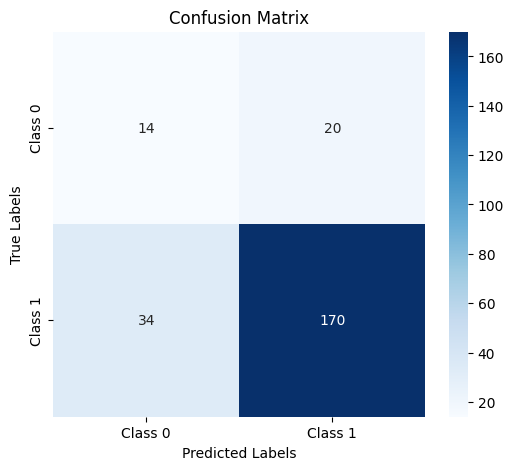

In [64]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get Model Predictions
y_pred_probs = model.predict(fft_test_scaled)
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels
y_true = np.argmax(y_test, axis=1)  # Convert one-hot labels to class labels

# Compute Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Print Classification Report
print("\nEvaluation Summary:\n", classification_report(y_true, y_pred, target_names=["Class 0", "Class 1"]))

# Plot Confusion Matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

plot_confusion_matrix(conf_matrix, ["Class 0", "Class 1"])


In [65]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

def group_windows_by_patient(sub_ids, fft_data, labels, sequence_length=5):
    """
    Groups consecutive windows by patient into fixed-size sequences.

    Parameters:
    - sub_ids: List of patient IDs for each window
    - fft_data: FFT-transformed data (shape: [num_windows, num_freq_bins, num_features])
    - labels: One-hot encoded labels for each window
    - sequence_length: Number of windows to group together

    Returns:
    - X_seq: Padded sequences of windows
    - y_seq: Labels (majority class of the grouped windows)
    """
    grouped_data = {}
    
    # Organize windows by patient
    for i, pid in enumerate(sub_ids):
        if pid not in grouped_data:
            grouped_data[pid] = {"windows": [], "labels": []}
        grouped_data[pid]["windows"].append(fft_data[i])
        grouped_data[pid]["labels"].append(labels[i])

    X_seq = []
    y_seq = []

    # Process each patient
    for pid, data in grouped_data.items():
        patient_windows = np.array(data["windows"])
        patient_labels = np.array(data["labels"])

        # Create overlapping sequences
        for i in range(0, len(patient_windows) - sequence_length + 1, sequence_length):
            seq = patient_windows[i:i + sequence_length]
            label = np.argmax(np.mean(patient_labels[i:i + sequence_length], axis=0))  # Majority class

            X_seq.append(seq)
            y_seq.append(label)

    # Convert to NumPy arrays and pad shorter sequences
    X_seq = pad_sequences(X_seq, maxlen=sequence_length, padding="post", dtype="float32")
    y_seq = np.array(y_seq)

    return np.array(X_seq), y_seq

# Apply grouping to train, validation, and test sets
sequence_length = 5  # Group 5 consecutive windows together
X_train_seq, y_train_seq = group_windows_by_patient(sub_ids_train, fft_train_scaled, y_train, sequence_length)
X_val_seq, y_val_seq = group_windows_by_patient(sub_ids_val, fft_val_scaled, y_val, sequence_length)
X_test_seq, y_test_seq = group_windows_by_patient(sub_ids_test, fft_test_scaled, y_test, sequence_length)

print(f"New Train Shape: {X_train_seq.shape}")  # Should be (num_sequences, sequence_length, num_freq_bins, num_features)
print(f"New Label Shape: {y_train_seq.shape}")  # Should be (num_sequences,)


New Train Shape: (121, 5, 31, 12)
New Label Shape: (121,)


In [68]:
from tensorflow.keras.layers import Reshape

def build_bi_lstm_sequence_model(input_shape, num_classes=2):
    """
    Builds a Bi-LSTM model for sequential multi-window time-series classification.
    
    Parameters:
    - input_shape: Tuple (sequence_length, num_freq_bins, num_features)
    - num_classes: Number of output classes

    Returns:
    - Compiled Bi-LSTM model
    """
    inputs = Input(shape=input_shape)  # (sequence_length, num_freq_bins, num_features)
    
    # ✅ Reshape to make it (sequence_length, features)
    reshaped = Reshape((input_shape[0], input_shape[1] * input_shape[2]))(inputs)

    # Bi-LSTM layers
    x = Bidirectional(LSTM(128, return_sequences=True))(reshaped)
    x = Dropout(0.3)(x)
    x = Bidirectional(LSTM(64, return_sequences=False))(x)

    # Fully Connected Layers
    x = Dense(32, activation="relu")(x)
    x = Dropout(0.3)(x)

    # Output Layer
    output_activation = "softmax" if num_classes > 2 else "sigmoid"
    outputs = Dense(num_classes, activation=output_activation)(x)

    model = Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss="binary_crossentropy" if num_classes == 2 else "categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model

# ✅ Update input shape after reshaping
sequence_input_shape = (sequence_length, 31, 12)  # (num_windows_per_seq, num_freq_bins, num_features)
model = build_bi_lstm_sequence_model(sequence_input_shape, num_classes)
model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 5, 31, 12)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 5, 372)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 5, 256)         │       513,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 5, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 681,570 (2.60 MB)

 Trainable params: 681,570 (2.60 MB)

 Non-trainable params: 0 (0.00 B)

In [70]:
# Convert labels to categorical format (One-Hot Encoding)
y_train_seq_cat = tf.keras.utils.to_categorical(y_train_seq, num_classes)
y_val_seq_cat = tf.keras.utils.to_categorical(y_val_seq, num_classes)
y_test_seq_cat = tf.keras.utils.to_categorical(y_test_seq, num_classes)

# Check shape
print(f"y_train_seq_cat shape: {y_train_seq_cat.shape}")
print(f"y_val_seq_cat shape: {y_val_seq_cat.shape}")
print(f"y_test_seq_cat shape: {y_test_seq_cat.shape}")


y_train_seq_cat shape: (121, 2)
y_val_seq_cat shape: (34, 2)
y_test_seq_cat shape: (37, 2)


In [71]:
history = model.fit(
    X_train_seq, y_train_seq_cat,
    validation_data=(X_val_seq, y_val_seq_cat),
    epochs=50,
    batch_size=32,
    class_weight=class_weights_dict,  # Handling class imbalance
    callbacks=[early_stopping]
)

# Evaluate Model
test_loss, test_acc = model.evaluate(X_test_seq, y_test_seq_cat)
print(f"Test Accuracy: {test_acc:.4f}")


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 490ms/step - accuracy: 0.1948 - loss: 0.7209 - val_accuracy: 0.1765 - val_loss: 0.7216
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.2167 - loss: 0.6802 - val_accuracy: 0.2353 - val_loss: 0.7136
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.3392 - loss: 0.6584 - val_accuracy: 0.4412 - val_loss: 0.6936
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4245 - loss: 0.6769 - val_accuracy: 0.2647 - val_loss: 0.7293
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.2777 - loss: 0.6856 - val_accuracy: 0.2647 - val_loss: 0.7521
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.3484 - loss: 0.6377 - val_accuracy: 0.4118 - val_loss: 0.7028
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.4146 - loss: 0.6234 - val_accuracy: 0.5000 - val_loss: 0.7039
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step - accuracy: 0.4833 - loss: 0.6248 - val_accuracy: 0.7647 - val_loss: 0.64

In [72]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Get model predictions (probabilities)
y_pred_probs = model.predict(X_test_seq)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)  # Converts softmax output to class labels

# Convert one-hot test labels back to class indices
y_true = np.argmax(y_test_seq_cat, axis=1)


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 901ms/stepWARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001F7AD025000> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step  


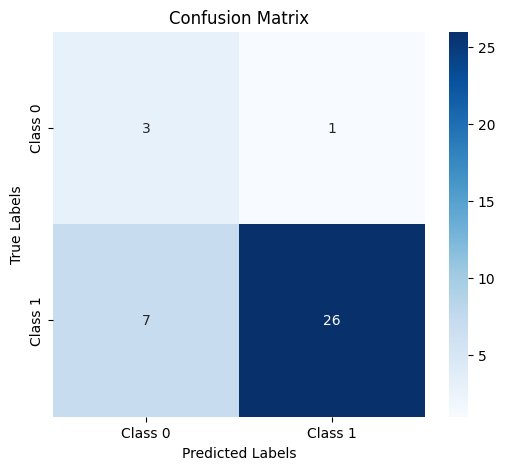

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the Confusion Matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

plot_confusion_matrix(conf_matrix, class_names)


In [88]:
# Parameters
target_size = 100  # Resampled window size
height_threshold = 0.4  # Height threshold for peaks
distance_between_peaks = 50  # Minimum distance between peaks
features = ['L_Acc_mag','L_Gyr_mag', 'R_Acc_mag', 'R_Gyr_mag']

In [104]:
# let's reduce number of patinet to see how it works
train_data_ex = train_data[train_data.SubID.isin(['ND0015_V8','ND0027_V8','ND0028_V8', 'ND0045_V8','ND0055_V8'])].reset_index(drop=True)
train_data_ex

SubID  Counter    L_Acc_mag   R_Acc_mag    L_Gyr_mag   R_Gyr_mag  \
0     ND0015_V8  3767194   124.850285  150.361904    76.531999   21.404195   
1     ND0015_V8  3767195   129.493404  152.128690    90.131818   21.496397   
2     ND0015_V8  3767196   127.370801  153.696171   105.782958   21.515164   
3     ND0015_V8  3767197   120.395938  154.799144   120.374226   21.380495   
4     ND0015_V8  3767198   115.409428  155.332452   130.759623   21.055849   
...         ...      ...          ...         ...          ...         ...   
7838  ND0055_V8  4117201  2133.360232  140.314656  1969.596938  202.402030   
7839  ND0055_V8  4117202  1877.699174  141.395572  1476.498057  186.692566   
7840  ND0055_V8  4117203  1665.501576  140.727340  1053.892794  173.039043   
7841  ND0055_V8  4117204  1418.821079  139.571459   965.960369  161.812969   
7842  ND0055_V8  4117205  1127.581388  138.626371  1151.025681  152.713236   

      Binary_Diagnosis  
0                    1  
1                    1  
2                    1  
3                    1  
4                    1  
...                ...  
7838                 1  
7839                 1  
7840                 1  
7841                 1  
7842                 1  

[7843 rows x 7 columns]

In [192]:
p_ND0015_V8 = train_data[train_data.SubID=='ND0015_V8'].reset_index(drop=True)
p_ND0015_V8

SubID  Counter   L_Acc_mag    R_Acc_mag   L_Gyr_mag   R_Gyr_mag  \
0    ND0015_V8  3767194  124.850285   150.361904   76.531999   21.404195   
1    ND0015_V8  3767195  129.493404   152.128690   90.131818   21.496397   
2    ND0015_V8  3767196  127.370801   153.696171  105.782958   21.515164   
3    ND0015_V8  3767197  120.395938   154.799144  120.374226   21.380495   
4    ND0015_V8  3767198  115.409428   155.332452  130.759623   21.055849   
..         ...      ...         ...          ...         ...         ...   
989  ND0015_V8  3768183  561.636213  2091.792426  499.255190  729.110449   
990  ND0015_V8  3768184  554.480761  2214.246925  464.260698  395.742775   
991  ND0015_V8  3768185  550.576052  2003.333689  422.970823  440.819260   
992  ND0015_V8  3768186  550.582098  1586.653240  372.689908  709.592847   
993  ND0015_V8  3768187  559.553861  1128.917726  317.142224  914.913488   

     Binary_Diagnosis  
0                   1  
1                   1  
2                   1  
3                   1  
4                   1  
..                ...  
989                 1  
990                 1  
991                 1  
992                 1  
993                 1  

[994 rows x 7 columns]

In [346]:

# Convert to numpy arrays
X_train = np.array(all_resampled_windows)  # Shape: (num_windows, target_size, num_signals)
y_train = np.array(all_labels)

print(f"Final shape of X_train: {X_train.shape}")
print(f"Final shape of y_train: {y_train.shape}")

Final shape of X_train: (2323, 100, 4)
Final shape of y_train: (2323,)


In [350]:
# Convert to numpy arrays
X_test = np.array(all_resampled_windows)  # Shape: (num_windows, target_size, num_signals)
y_test = np.array(all_labels)

print(f"Final shape of X_train: {X_test.shape}")
print(f"Final shape of y_train: {y_test.shape}")

Final shape of X_train: (595, 100, 4)
Final shape of y_train: (595,)


In [351]:
# Flatten the data
X_train_flattened = X_train.reshape(X_train.shape[0], -1)  # Shape: (num_samples, 100 * 4)
X_test_flattened = X_test.reshape(X_test.shape[0], -1)     # Shape: (num_samples, 100 * 4)

print("Shape of X_train_flattened:", X_train_flattened.shape)
print("Shape of X_test_flattened:", X_test_flattened.shape)


Shape of X_train_flattened: (2323, 400)
Shape of X_test_flattened: (595, 400)


In [352]:
# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = {0: class_weights[0], 1: class_weights[1]}
print("Class Weights:", class_weights)


Class Weights: {0: np.float64(3.416176470588235), 1: np.float64(0.5857286938981341)}


In [354]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout

def build_dense_model(input_shape):
    """
    Build a fully connected neural network with batch normalization and dropout layers.
    """
    model = Sequential()

    # Input layer and first dense block
    model.add(Dense(512, activation='relu', input_shape=(input_shape,)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Second dense block
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Third dense block
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Fourth dense block
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))  

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    print(model.summary())

    return model


In [361]:
input_shape = X_train_flat.shape[1]  
model = build_dense_model(input_shape)

history = model.fit(
    X_train_flat, y_train,
    epochs=20,
    batch_size=32,
    verbose=1
)

test_loss, test_accuracy = model.evaluate(X_test_flat, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


y_pred_probs = model.predict(X_test_flat)
y_pred = (y_pred_probs > 0.5).astype(int)  

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

c:\Users\35262\.conda\envs\fogenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_179 (Dense)               │ (None, 512)            │       205,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_91          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_154 (Dropout)           │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_180 (Dense)               │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_92          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_155 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_181 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_93          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_156 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_182 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_94          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_157 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_183 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 381,697 (1.46 MB)

 Trainable params: 379,777 (1.45 MB)

 Non-trainable params: 1,920 (7.50 KB)

None
Epoch 1/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5399 - loss: 0.8639
Epoch 2/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7090 - loss: 0.5926
Epoch 3/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7910 - loss: 0.4970
Epoch 4/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8203 - loss: 0.4552
Epoch 5/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8425 - loss: 0.4238
Epoch 6/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8476 - loss: 0.4255
Epoch 7/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8495 - loss: 0.4215
Epoch 8/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8505 - loss: 0.4111
Epoch 9/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8471 - loss: 0.4031
Epoch 10/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8342 - loss: 0.4315
Epoch 11/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8411 - loss: 0.4077
Epoch 12/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8564

In [355]:
# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(y_train), 
    y=y_train
)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Build the model
input_shape = X_train_flat.shape[1]  # Number of features
model = build_dense_model(input_shape)

# Train the model with class weights
history = model.fit(
    X_train_flat, y_train,
    epochs=20,
    batch_size=64,
    class_weight=class_weights_dict,  # Apply class weights here
    verbose=1
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_flat, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Generate classification metrics
from sklearn.metrics import classification_report, confusion_matrix

# Predict the test data
y_pred_probs = model.predict(X_test_flat)
y_pred = (y_pred_probs > 0.5).astype(int)  # Convert probabilities to binary predictions

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

c:\Users\35262\.conda\envs\fogenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_149 (Dense)               │ (None, 512)            │       205,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_67          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_130 (Dropout)           │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_150 (Dense)               │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_68          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_131 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_151 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_69          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_132 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_152 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_70          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_133 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_153 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 381,697 (1.46 MB)

 Trainable params: 379,777 (1.45 MB)

 Non-trainable params: 1,920 (7.50 KB)

None
Epoch 1/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5399 - loss: 0.8958
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6239 - loss: 0.6763
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7208 - loss: 0.5945
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7623 - loss: 0.5140
Epoch 5/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7885 - loss: 0.4828
Epoch 6/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8008 - loss: 0.4651
Epoch 7/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8281 - loss: 0.4319
Epoch 8/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8257 - loss: 0.4332
Epoch 9/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8300 - loss: 0.4316
Epoch 10/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8524 - loss: 0.3953
Epoch 11/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8486 - loss: 0.4033
Epoch 12/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8427

In [343]:
from tensorflow.keras import layers, Model, Input
from tensorflow import keras

# Transformer Encoder
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    """
    Transformer Encoder Layer.
    
    Args:
        inputs: Input tensor.
        head_size: Size of each attention head.
        num_heads: Number of attention heads.
        ff_dim: Hidden layer size in feed-forward network.
        dropout: Dropout rate.

    Returns:
        Tensor output of the encoder layer.
    """
    # Multi-head Attention
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs  # Residual Connection

    # Feed-forward Network
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res  # Residual Connection

# Build Model
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    """
    Build the Transformer-based model.
    
    Args:
        input_shape: Shape of the input data.
        head_size: Size of each attention head.
        num_heads: Number of attention heads.
        ff_dim: Hidden layer size in feed-forward network.
        num_transformer_blocks: Number of transformer blocks.
        mlp_units: List of hidden layer sizes in the MLP.
        dropout: Dropout rate for transformer blocks.
        mlp_dropout: Dropout rate for MLP layers.

    Returns:
        Compiled Keras model.
    """
    inputs = Input(shape=input_shape)
    x = layers.Reshape((input_shape[0], 1))(inputs)  # Reshape to 3D for Conv1D
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_last")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)  # Binary classification
    return Model(inputs, outputs)

# Define Model Parameters
input_shape = (400,)  # Input shape for flat data
model = build_model(
    input_shape,
    head_size=64,  # Attention head size
    num_heads=2,   # Number of attention heads
    ff_dim=64,     # Feed-forward dimension
    num_transformer_blocks=2,  # Number of transformer blocks
    mlp_units=[64, 32],  # MLP layers
    mlp_dropout=0.3,
    dropout=0.25,
)

# Compile the Model
model.compile(
    loss="binary_crossentropy",  # Binary classification
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["accuracy"],
)

# Summary
model.summary()

# Callbacks
callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

# Train the Model
history = model.fit(
    X_train_flat, y_train,
    epochs=20,            # Number of epochs
    batch_size=64,        # Batch size
    callbacks=callbacks,
    verbose=1,            # Print training progress
)

# Evaluate on Test Data
test_loss, test_accuracy = model.evaluate(X_test_flat, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


Model: "functional_308"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_41      │ (None, 400)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 400, 1)    │          0 │ input_layer_41[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 400, 1)    │        897 │ reshape[0][0],    │
│ (MultiHeadAttentio… │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_123         │ (None, 400, 1)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 400, 1)    │          2 │ dropout_123[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_13 (Add)        │ (None, 400, 1)    │          0 │ layer_normalizat… │
│                     │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_31 (Conv1D)  │ (None, 400, 64)   │        128 │ add_13[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_124         │ (None, 400, 64)   │          0 │ conv1d_31[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_32 (Conv1D)  │ (None, 400, 1)    │         65 │ dropout_124[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 400, 1)    │          2 │ conv1d_32[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_14 (Add)        │ (None, 400, 1)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_13[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 400, 1)    │        897 │ add_14[0][0],     │
│ (MultiHeadAttentio… │                   │            │ add_14[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_126         │ (None, 400, 1)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 400, 1)    │          2 │ dropout_126[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_15 (Add)        │ (None, 400, 1)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_14[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_33 (Conv1D)  │ (None, 400, 64)   │        128 │ add_15[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_127         │ (None, 400, 64)   │          0 │ conv1d_33[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_34 (Conv1D)  │ (None, 400, 1)    │         65 │ dropout_127[0][0] │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 4,429 (17.30 KB)

 Trainable params: 4,429 (17.30 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 27s 527ms/step - accuracy: 0.8263 - loss: 0.6732
Epoch 2/20


c:\Users\35262\.conda\envs\fogenv\lib\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 20s 537ms/step - accuracy: 0.8565 - loss: 0.6548
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 20s 534ms/step - accuracy: 0.8567 - loss: 0.6333
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 20s 548ms/step - accuracy: 0.8519 - loss: 0.6114
Epoch 5/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 19s 522ms/step - accuracy: 0.8663 - loss: 0.5806
Epoch 6/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 19s 516ms/step - accuracy: 0.8460 - loss: 0.5616
Epoch 7/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 19s 507ms/step - accuracy: 0.8439 - loss: 0.5329
Epoch 8/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 19s 517ms/step - accuracy: 0.8603 - loss: 0.5018
Epoch 9/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 19s 517ms/step - accuracy: 0.8480 - loss: 0.4834
Epoch 10/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 19s 510ms/step - accuracy: 0.8538 - loss: 0.4613
Epoch 11/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 19s 510ms/step - accuracy: 0.8616 - loss: 0.4373
Epoch 12/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 19s 519ms/step - accuracy: 0.8338 - loss: 0.4641
Epoch 13/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 21s 573ms/st

In [344]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_flat, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Generate classification metrics
from sklearn.metrics import classification_report, confusion_matrix

# Predict the test data
y_pred_probs = model.predict(X_test_flat)
y_pred = (y_pred_probs > 0.5).astype(int)  # Convert probabilities to binary predictions

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.9658 - loss: 0.2299
Test Loss: 0.4345, Test Accuracy: 0.8454
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        92
           1       0.85      1.00      0.92       503

    accuracy                           0.85       595
   macro avg       0.42      0.50      0.46       595
weighted avg       0.71      0.85      0.77       595


Confusion Matrix:
[[  0  92]
 [  0 503]]


c:\Users\35262\.conda\envs\fogenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\35262\.conda\envs\fogenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\35262\.conda\envs\fogenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [328]:
from imblearn.over_sampling import SMOTE

# Create SMOTE object
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_flat, y_train)

print(f"Balanced training data shape: {X_train_balanced.shape}, {y_train_balanced.shape}")


Balanced training data shape: (3966, 400), (3966,)


In [329]:
# Build the improved model
oversampled_model = build_dense_model(input_shape=X_train_balanced.shape[1])

# Train the model on oversampled data
history = oversampled_model.fit(
    X_train_balanced, y_train_balanced,
    epochs=20,
    batch_size=32,
    verbose=1
)

# Evaluate on the test set
test_loss, test_accuracy = oversampled_model.evaluate(X_test_flat, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Classification Report
y_pred_probs = oversampled_model.predict(X_test_flat)
y_pred = (y_pred_probs > 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_122 (Dense)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_55          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_88 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_123 (Dense)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_56          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_89 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_124 (Dense)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_57          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_90 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_125 (Dense)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_58          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_91 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_126 (Dense)               │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5480 - loss: 0.8526
Epoch 2/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5816 - loss: 0.7174
Epoch 3/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6004 - loss: 0.6862
Epoch 4/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6258 - loss: 0.6450
Epoch 5/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6677 - loss: 0.6103
Epoch 6/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6850 - loss: 0.5991
Epoch 7/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6880 - loss: 0.5883
Epoch 8/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7494 - loss: 0.5208
Epoch 9/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7237 - loss: 0.5461
Epoch 10/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7616 - loss: 0.4906
Epoch 11/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7721 - loss: 0.4823
Epoch 12/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms

In [72]:
# resampling each pateint into same number of rows.
# frequency, spectrum in time series transformation 

# not taking the mode
# with a presentation.
 
# shape : (number of windows of patients,100,12)

#p1:(10,100,12) -> flatten:(10,1200)
#p2: (4,100,12) -> flatten:(4,1200)


# x_trian.shape : number of windows 14 * 1200

In [73]:
df_TUG.groupby('SubID').size().sort_values()
# train_data.groupby('SubID').size().sort_values()

SubID
ND0736_V4     725
ND0828_V2     744
ND0842_V2     764
ND0282_V7     793
ND0810_V2     793
             ... 
ND0614_V5    1956
ND0060_V8    2002
ND0385_V6    2242
ND0655_V4    2323
ND0027_V8    3091
Length: 112, dtype: int64

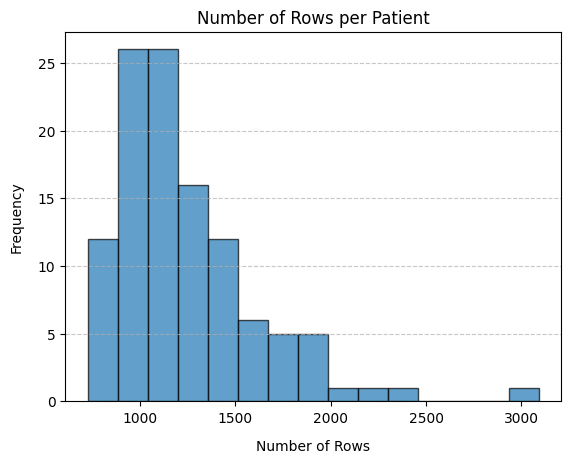

In [74]:
rows_per_patient = df_TUG.groupby('SubID').size().sort_values()

plt.hist(rows_per_patient.values, bins='auto', alpha=0.7, edgecolor='black')

# Set the y-axis to show only discrete values
y_ticks = np.arange(0, plt.gca().get_ylim()[1] + 1, 5)  # Generate integer ticks
plt.yticks(y_ticks)

plt.title("Number of Rows per Patient")
plt.xlabel("Number of Rows", labelpad=10)
plt.ylabel("Frequency" , labelpad=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [75]:
''' 
p_ND0027_V8 = df_TUG[df_TUG.SubID=='ND0027_V8'].reset_index(drop=True)
plot_signals(p_ND0027_V8,['L_AccX_filt','L_GyrX_filt','R_AccX_filt', 'R_GyrX_filt'])
plot_signals(p_ND0027_V8,['L_AccY_filt','L_GyrY_filt','R_AccY_filt', 'R_GyrY_filt'])
plot_signals(p_ND0027_V8,['L_AccZ_filt','L_GyrZ_filt','R_AccZ_filt', 'R_GyrZ_filt'])

'''

" \np_ND0027_V8 = df_TUG[df_TUG.SubID=='ND0027_V8'].reset_index(drop=True)\nplot_signals(p_ND0027_V8,['L_AccX_filt','L_GyrX_filt','R_AccX_filt', 'R_GyrX_filt'])\nplot_signals(p_ND0027_V8,['L_AccY_filt','L_GyrY_filt','R_AccY_filt', 'R_GyrY_filt'])\nplot_signals(p_ND0027_V8,['L_AccZ_filt','L_GyrZ_filt','R_AccZ_filt', 'R_GyrZ_filt'])\n\n"

In [76]:
def create_fixed_windows(data, feature_columns, window_size):
    """
    Reshapes data into fixed windows of a specified length for each patient.

    Args:
    - data (pd.DataFrame): Original dataset with multiple patients.
    - feature_columns (list): List of feature column names to include.
    - window_size (int): Number of rows in each window.

    Returns:
    - tuple: (windows, labels, sub_ids)
      - windows (np.ndarray): Array of shape (num_windows, window_size, num_features).
      - labels (list): List of labels corresponding to each window.
      - sub_ids (list): List of SubIDs corresponding to each window.
    """
    all_windows = []
    all_labels = []
    all_sub_ids = []

    for patient_id, patient_data in data.groupby('SubID'):
        features = patient_data[feature_columns].values
        label = patient_data['Binary_Diagnosis'].iloc[0]  # Use the first label for all windows
        
        # Calculate the number of complete windows
        num_windows = len(features) // window_size
        
        # Create windows
        for i in range(num_windows):
            start = i * window_size
            end = start + window_size
            window = features[start:end]
            all_windows.append(window)
            all_labels.append(label)
            all_sub_ids.append(patient_id)
    
    return np.array(all_windows), np.array(all_labels), all_sub_ids


In [78]:
# Define parameters
#FEATURE_COLUMNS = ['L_AccX_filt', 'L_AccY_filt', 'L_AccZ_filt',
#                   'L_GyrX_filt', 'L_GyrY_filt', 'L_GyrZ_filt',
#                   'R_AccX_filt', 'R_AccY_filt', 'R_AccZ_filt',
#                   'R_GyrX_filt', 'R_GyrY_filt', 'R_GyrZ_filt']

FEATURE_COLUMNS = [ 'L_Acc_mag', 'R_Acc_mag', 'L_Gyr_mag', 'R_Gyr_mag']

WINDOW_SIZE = 100

# Apply the function to train and test data
X_train, y_train, train_sub_ids = create_fixed_windows(train_data, FEATURE_COLUMNS, WINDOW_SIZE)
X_test, y_test, test_sub_ids = create_fixed_windows(test_data, FEATURE_COLUMNS, WINDOW_SIZE)

# Check results
print("X_train shape:", X_train.shape)  # (num_train_windows, 100, num_features)
print("y_train shape:", y_train.shape)

print("X_test shape:", X_test.shape)  # (num_test_windows, 100, num_features)
print("y_test shape:", y_test.shape)

X_train shape: (1071, 100, 4)
y_train shape: (1071,)
X_test shape: (261, 100, 4)
y_test shape: (261,)


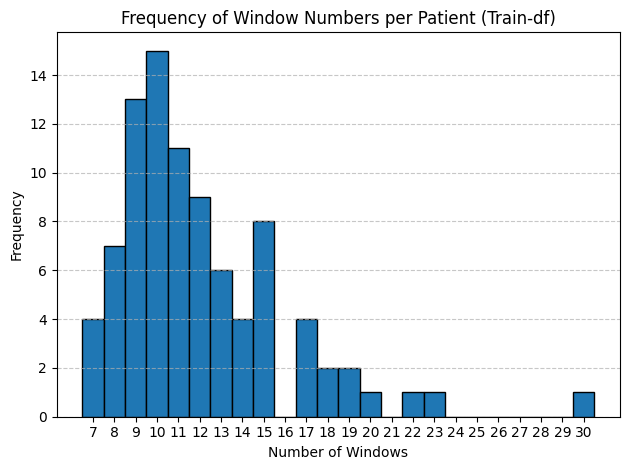

In [79]:
train_subid_counts = Counter(train_sub_ids)
num_windows = list(train_subid_counts.values())
patients = list(train_subid_counts.keys())

# Plot frequency of window counts
plt.hist(num_windows, bins=range(min(num_windows), max(num_windows) + 2), edgecolor='black', align='left')
plt.title('Frequency of Window Numbers per Patient (Train-df)')
plt.xlabel('Number of Windows')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(range(min(num_windows), max(num_windows) + 1))
plt.tight_layout()
plt.show()

In [80]:
sorted_items = sorted(train_subid_counts.items(), key=lambda x: x[1], reverse=True)

num_columns = 3

formatted_sorted_output = "\n".join(
    "  ".join(f"'{k}': {v}" for k, v in sorted_items[i:i + num_columns])
    for i in range(0, len(sorted_items), num_columns)
)

print(formatted_sorted_output)


'ND0027_V8': 30  'ND0655_V4': 23  'ND0385_V6': 22
'ND0060_V8': 20  'ND0614_V5': 19  'ND0688_V4': 19
'ND0497_V6': 18  'ND0787_V3': 18  'ND0045_V8': 17
'ND0163_V8': 17  'ND0545_V5': 17  'ND0860_V1': 17
'ND0075_V8': 15  'ND0132_V8': 15  'ND0405_V6': 15
'ND0536_V6': 15  'ND0551_V5': 15  'ND0597_V5': 15
'ND0620_V5': 15  'ND0777_V3': 15  'ND0137_V8': 14
'ND0429_V6': 14  'ND0482_V6': 14  'ND0746_V4': 14
'ND0114_V8': 13  'ND0396_V6': 13  'ND0690_V4': 13
'ND0714_V4': 13  'ND0822_V2': 13  'ND3016_V3': 13
'ND0028_V8': 12  'ND0095_V8': 12  'ND0437_V6': 12
'ND0468_V6': 12  'ND0564_V5': 12  'ND0584_V5': 12
'ND0613_V5': 12  'ND0720_V4': 12  'ND0877_V1': 12
'ND0172_V8': 11  'ND0394_V6': 11  'ND0595_V5': 11
'ND0654_V4': 11  'ND0722_V4': 11  'ND0814_V2': 11
'ND0827_V2': 11  'ND3017_V3': 11  'ND3466_V2': 11
'ND3521_V2': 11  'ND3706_V1': 11  'ND0070_V8': 10
'ND0199_V7': 10  'ND0289_V7': 10  'ND0340_V7': 10
'ND0702_V4': 10  'ND0708_V4': 10  'ND0765_V3': 10
'ND0780_V3': 10  'ND0806_V2': 10  'ND0819_V2': 10


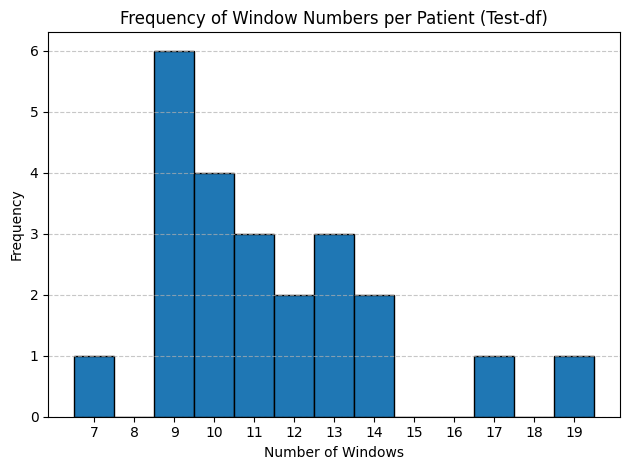

In [81]:
test_subid_counts = Counter(test_sub_ids)
num_windows = list(test_subid_counts.values())
patients = list(test_subid_counts.keys())

# Plot frequency of window counts
plt.hist(num_windows, bins=range(min(num_windows), max(num_windows) + 2), edgecolor='black', align='left')
plt.title('Frequency of Window Numbers per Patient (Test-df)')
plt.xlabel('Number of Windows')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(range(min(num_windows), max(num_windows) + 1))
plt.tight_layout()
plt.show()

In [20]:
'''
sorted_items = sorted(test_subid_counts.items(), key=lambda x: x[1], reverse=True)

num_columns = 3

formatted_sorted_output = "\n".join(
    "  ".join(f"'{k}': {v}" for k, v in sorted_items[i:i + num_columns])
    for i in range(0, len(sorted_items), num_columns)
)

print(formatted_sorted_output)
''' 

'\nsorted_items = sorted(test_subid_counts.items(), key=lambda x: x[1], reverse=True)\n\nnum_columns = 3\n\nformatted_sorted_output = "\n".join(\n    "  ".join(f"\'{k}\': {v}" for k, v in sorted_items[i:i + num_columns])\n    for i in range(0, len(sorted_items), num_columns)\n)\n\nprint(formatted_sorted_output)\n'

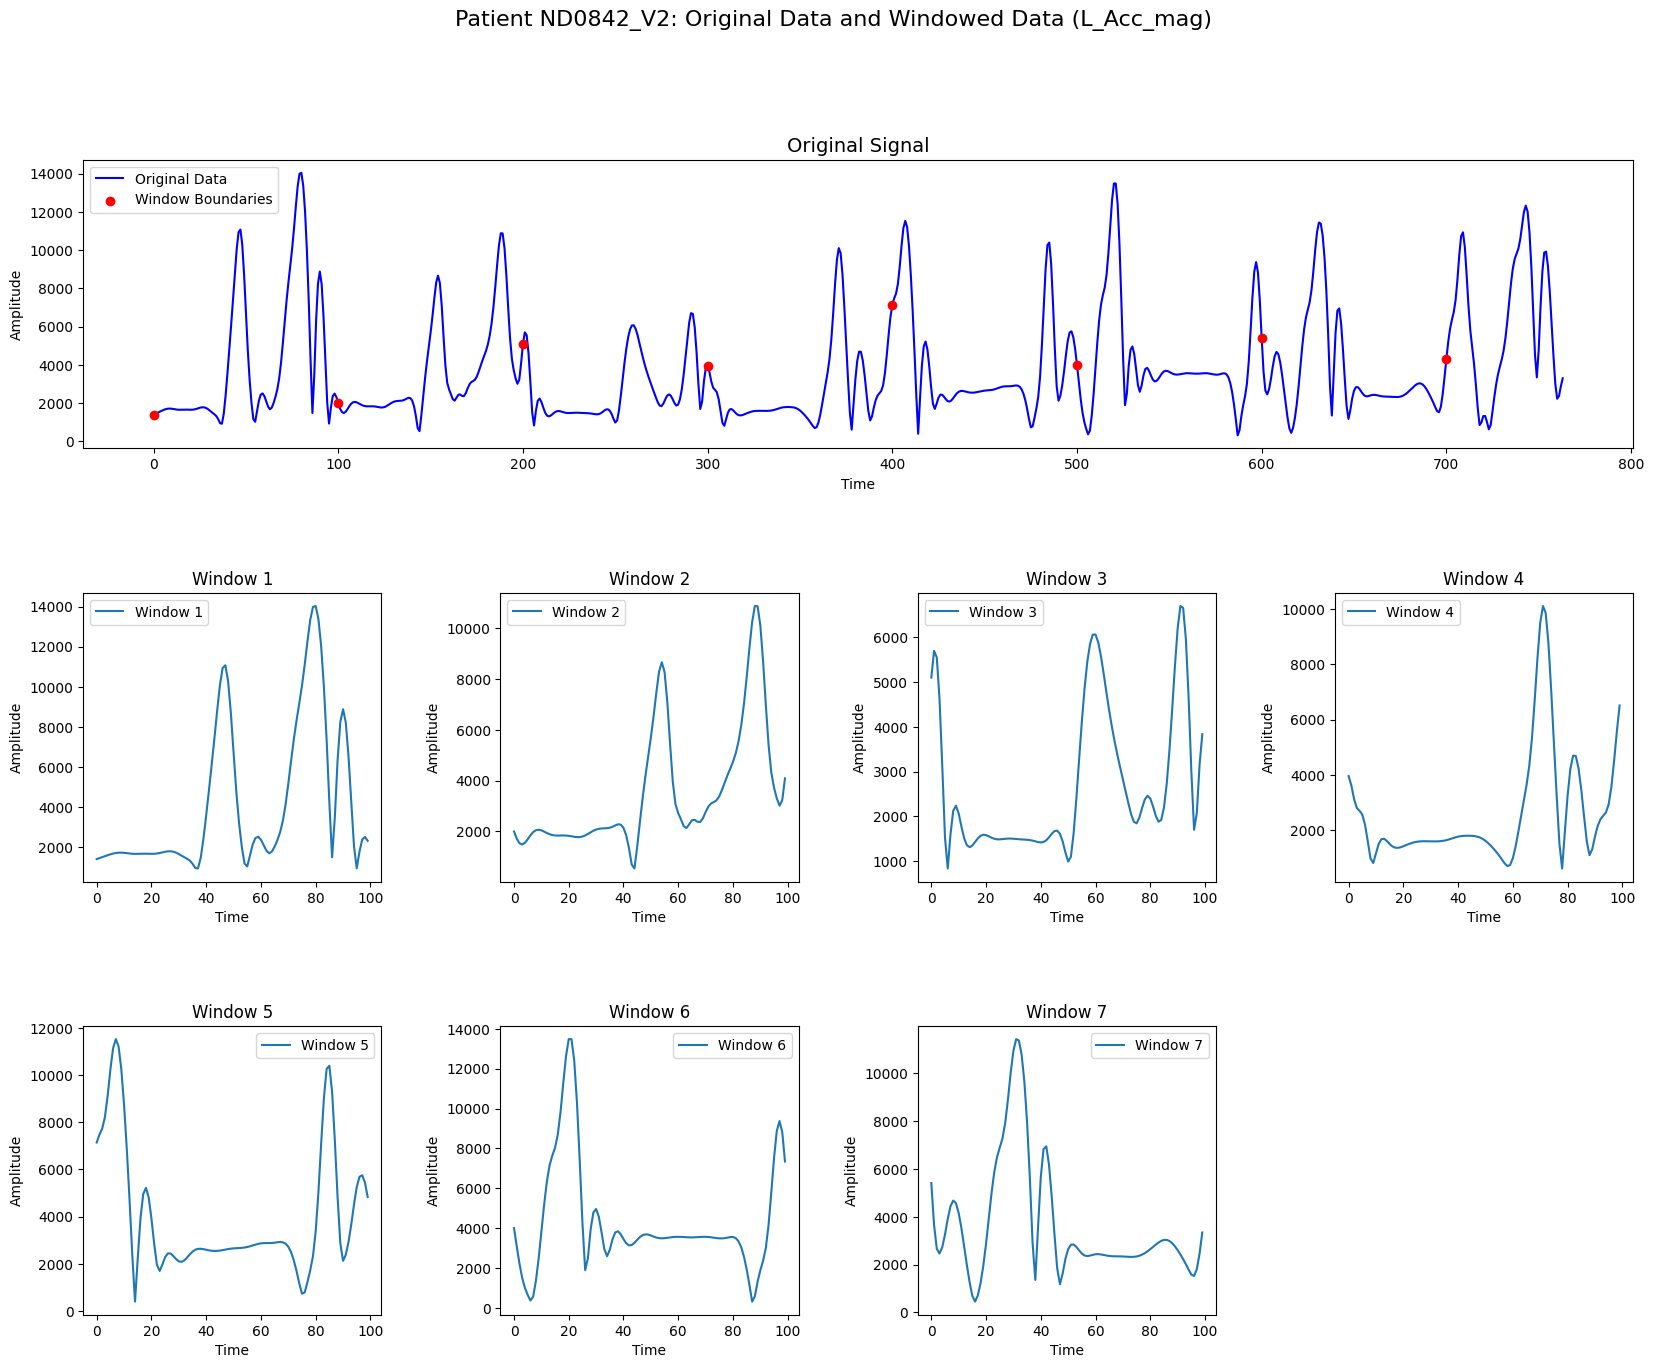

In [82]:
patient_id = 'ND0842_V2'
feature_idx = 0
feature_name = FEATURE_COLUMNS[feature_idx]

original_feature_data = train_data[train_data['SubID'] == patient_id][feature_name].values
windowed_feature_data = X_train[
    [i for i, sub_id in enumerate(train_sub_ids) if sub_id == patient_id], :, feature_idx
]

# Calculate the red dot positions for window boundaries on the original data
window_starts = np.arange(0, len(original_feature_data), 100)  # Start of each window
window_points = original_feature_data[window_starts]  # Values at those points

# Plot the original data (long signal) and its 7 windows in a 3-row layout
fig = plt.figure(figsize=(20, 15))
grid = plt.GridSpec(3, 4, hspace=0.5, wspace=0.4)

# Original data (spanning the entire first row)
ax_original = fig.add_subplot(grid[0, :])
ax_original.plot(original_feature_data, label="Original Data", color='blue')
ax_original.scatter(window_starts, window_points, color='red', label="Window Boundaries", zorder=5)
ax_original.set_title("Original Signal", fontsize=14)
ax_original.set_xlabel("Time")
ax_original.set_ylabel("Amplitude")
ax_original.legend()

# Plot the first 4 windows in the second row
for idx in range(4):
    ax = fig.add_subplot(grid[1, idx])
    ax.plot(windowed_feature_data[idx], label=f"Window {idx + 1}")
    ax.set_title(f"Window {idx + 1}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Amplitude")
    ax.legend()

# Plot the remaining 3 windows in the third row
for idx in range(3):
    ax = fig.add_subplot(grid[2, idx])
    ax.plot(windowed_feature_data[idx + 4], label=f"Window {idx + 5}")
    ax.set_title(f"Window {idx + 5}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Amplitude")
    ax.legend()

# Adjust layout and show the plot
plt.suptitle(f"Patient {patient_id}: Original Data and Windowed Data ({feature_name})", fontsize=16)
plt.show()


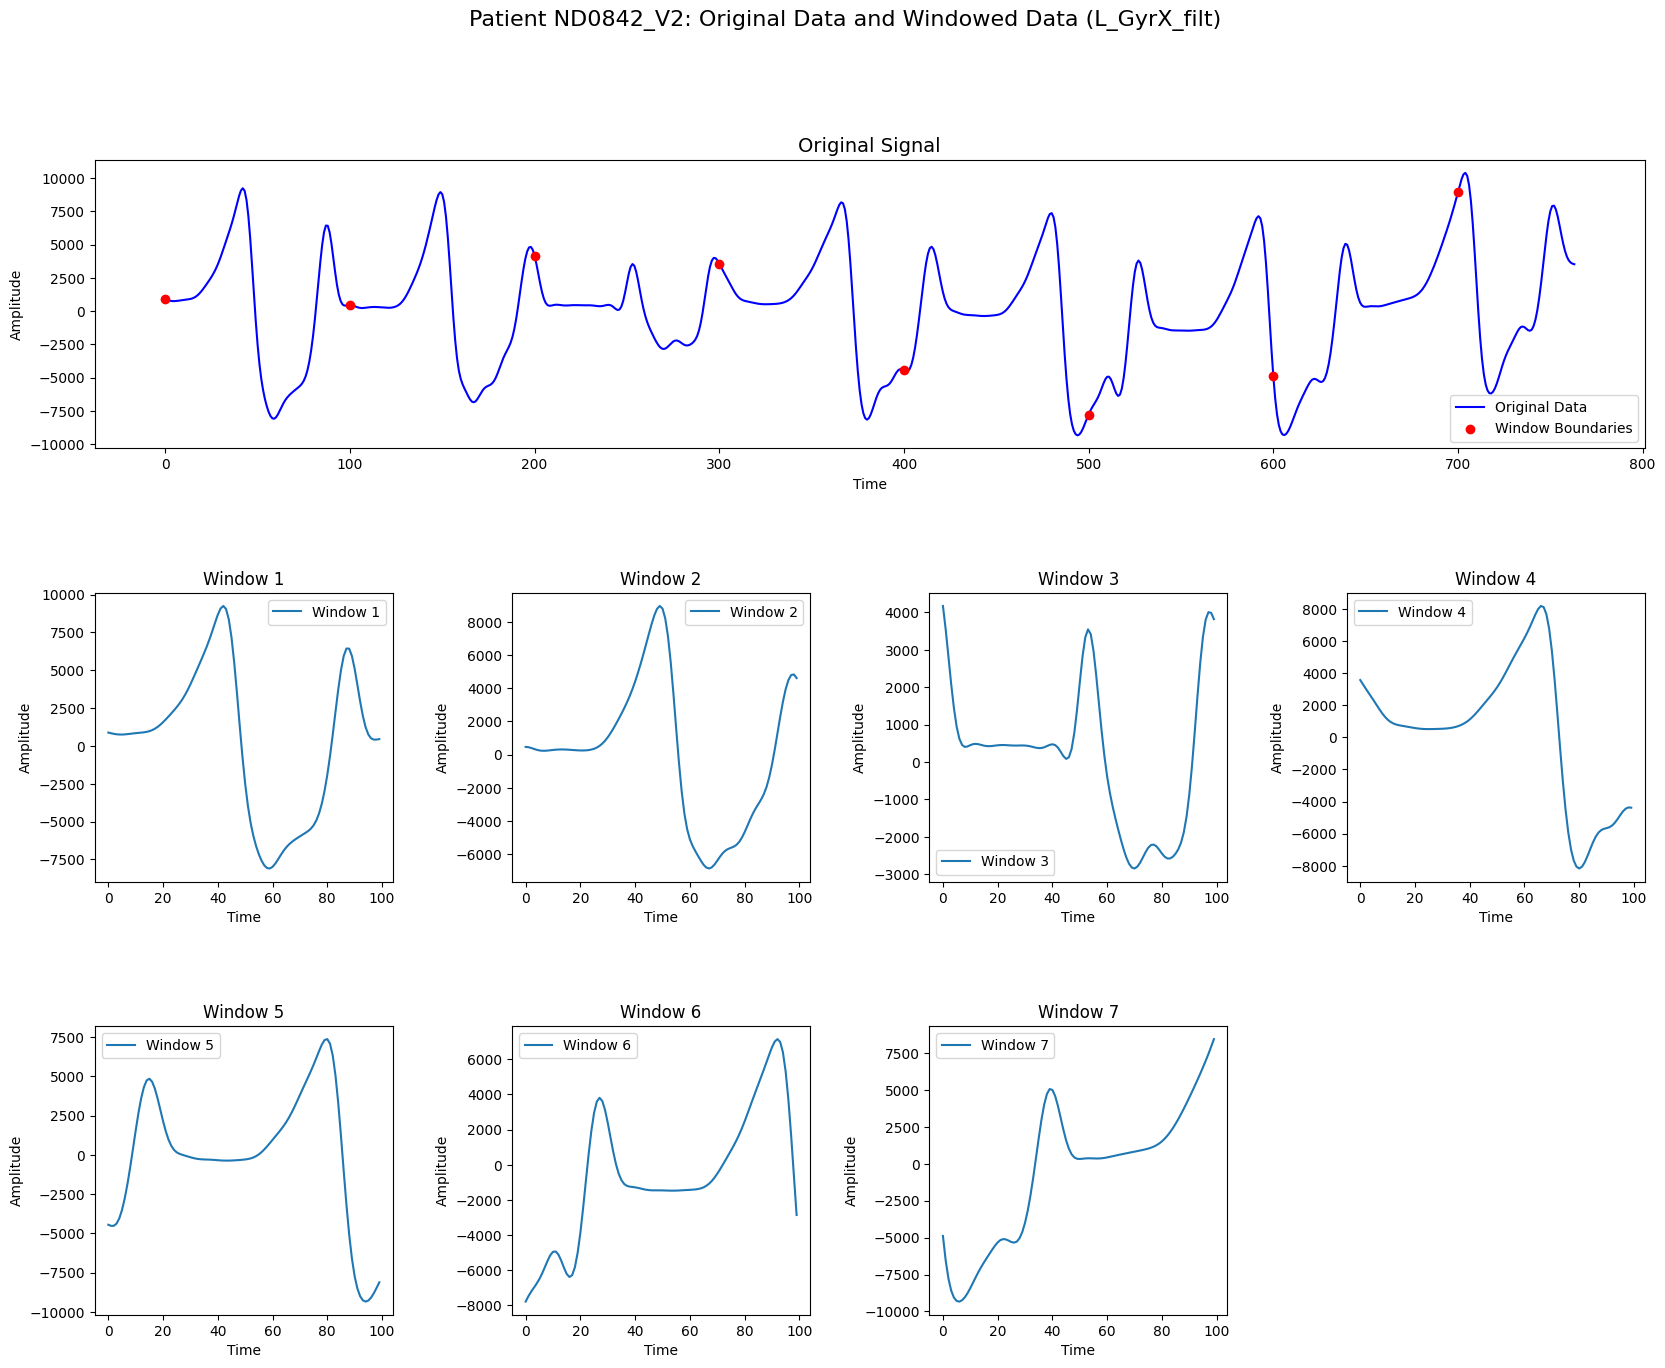

In [22]:
patient_id = 'ND0842_V2'
feature_idx = 3
feature_name = FEATURE_COLUMNS[feature_idx]

original_feature_data = train_data[train_data['SubID'] == patient_id][feature_name].values
windowed_feature_data = X_train[
    [i for i, sub_id in enumerate(train_sub_ids) if sub_id == patient_id], :, feature_idx
]

# Calculate the red dot positions for window boundaries on the original data
window_starts = np.arange(0, len(original_feature_data), 100)  # Start of each window
window_points = original_feature_data[window_starts]  # Values at those points

# Plot the original data (long signal) and its 7 windows in a 3-row layout
fig = plt.figure(figsize=(20, 15))
grid = plt.GridSpec(3, 4, hspace=0.5, wspace=0.4)

# Original data (spanning the entire first row)
ax_original = fig.add_subplot(grid[0, :])
ax_original.plot(original_feature_data, label="Original Data", color='blue')
ax_original.scatter(window_starts, window_points, color='red', label="Window Boundaries", zorder=5)
ax_original.set_title("Original Signal", fontsize=14)
ax_original.set_xlabel("Time")
ax_original.set_ylabel("Amplitude")
ax_original.legend()

# Plot the first 4 windows in the second row
for idx in range(4):
    ax = fig.add_subplot(grid[1, idx])
    ax.plot(windowed_feature_data[idx], label=f"Window {idx + 1}")
    ax.set_title(f"Window {idx + 1}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Amplitude")
    ax.legend()

# Plot the remaining 3 windows in the third row
for idx in range(3):
    ax = fig.add_subplot(grid[2, idx])
    ax.plot(windowed_feature_data[idx + 4], label=f"Window {idx + 5}")
    ax.set_title(f"Window {idx + 5}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Amplitude")
    ax.legend()

# Adjust layout and show the plot
plt.suptitle(f"Patient {patient_id}: Original Data and Windowed Data ({feature_name})", fontsize=16)
plt.show()


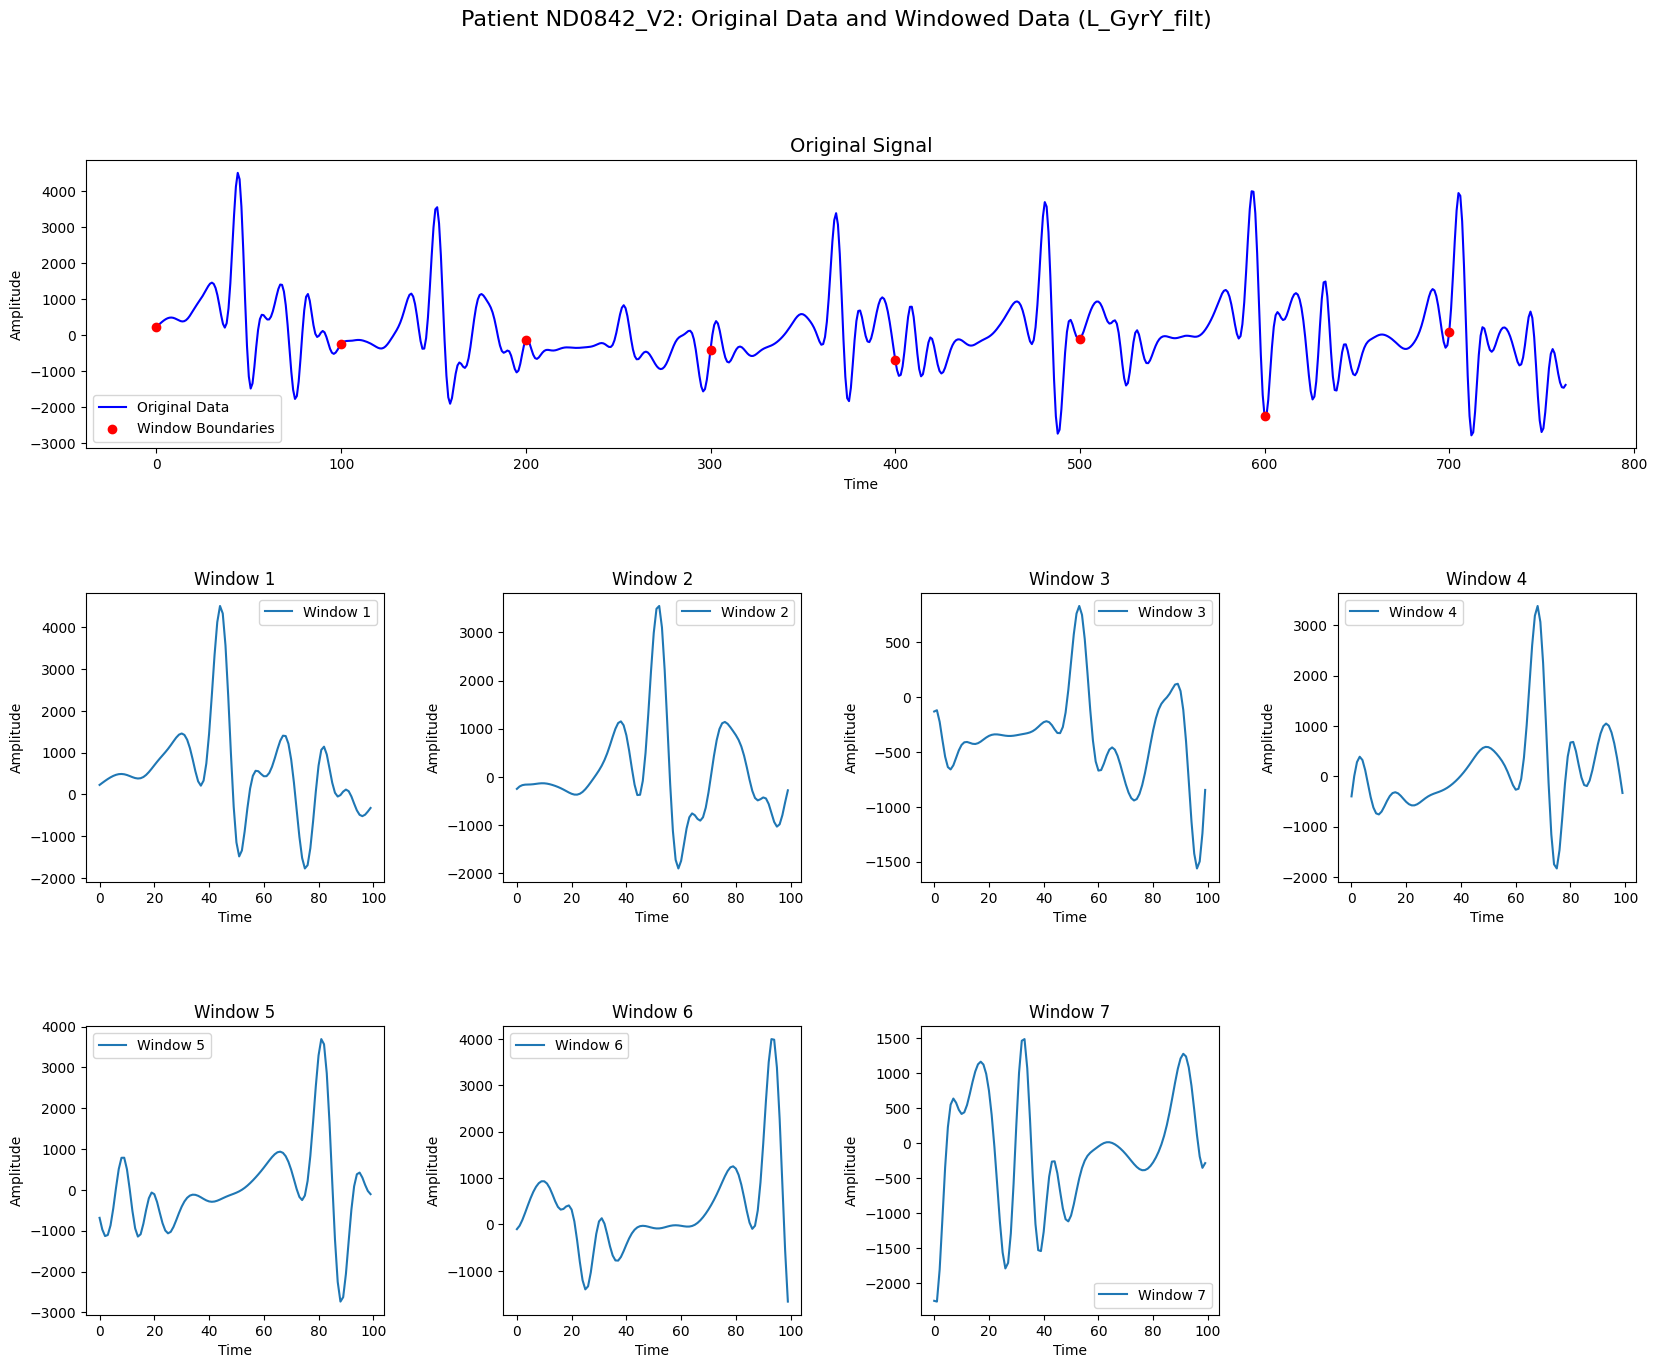

In [23]:
patient_id = 'ND0842_V2'
feature_idx = 4
feature_name = FEATURE_COLUMNS[feature_idx]

original_feature_data = train_data[train_data['SubID'] == patient_id][feature_name].values
windowed_feature_data = X_train[
    [i for i, sub_id in enumerate(train_sub_ids) if sub_id == patient_id], :, feature_idx
]

# Calculate the red dot positions for window boundaries on the original data
window_starts = np.arange(0, len(original_feature_data), 100)  # Start of each window
window_points = original_feature_data[window_starts]  # Values at those points

# Plot the original data (long signal) and its 7 windows in a 3-row layout
fig = plt.figure(figsize=(20, 15))
grid = plt.GridSpec(3, 4, hspace=0.5, wspace=0.4)

# Original data (spanning the entire first row)
ax_original = fig.add_subplot(grid[0, :])
ax_original.plot(original_feature_data, label="Original Data", color='blue')
ax_original.scatter(window_starts, window_points, color='red', label="Window Boundaries", zorder=5)
ax_original.set_title("Original Signal", fontsize=14)
ax_original.set_xlabel("Time")
ax_original.set_ylabel("Amplitude")
ax_original.legend()

# Plot the first 4 windows in the second row
for idx in range(4):
    ax = fig.add_subplot(grid[1, idx])
    ax.plot(windowed_feature_data[idx], label=f"Window {idx + 1}")
    ax.set_title(f"Window {idx + 1}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Amplitude")
    ax.legend()

# Plot the remaining 3 windows in the third row
for idx in range(3):
    ax = fig.add_subplot(grid[2, idx])
    ax.plot(windowed_feature_data[idx + 4], label=f"Window {idx + 5}")
    ax.set_title(f"Window {idx + 5}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Amplitude")
    ax.legend()

# Adjust layout and show the plot
plt.suptitle(f"Patient {patient_id}: Original Data and Windowed Data ({feature_name})", fontsize=16)
plt.show()


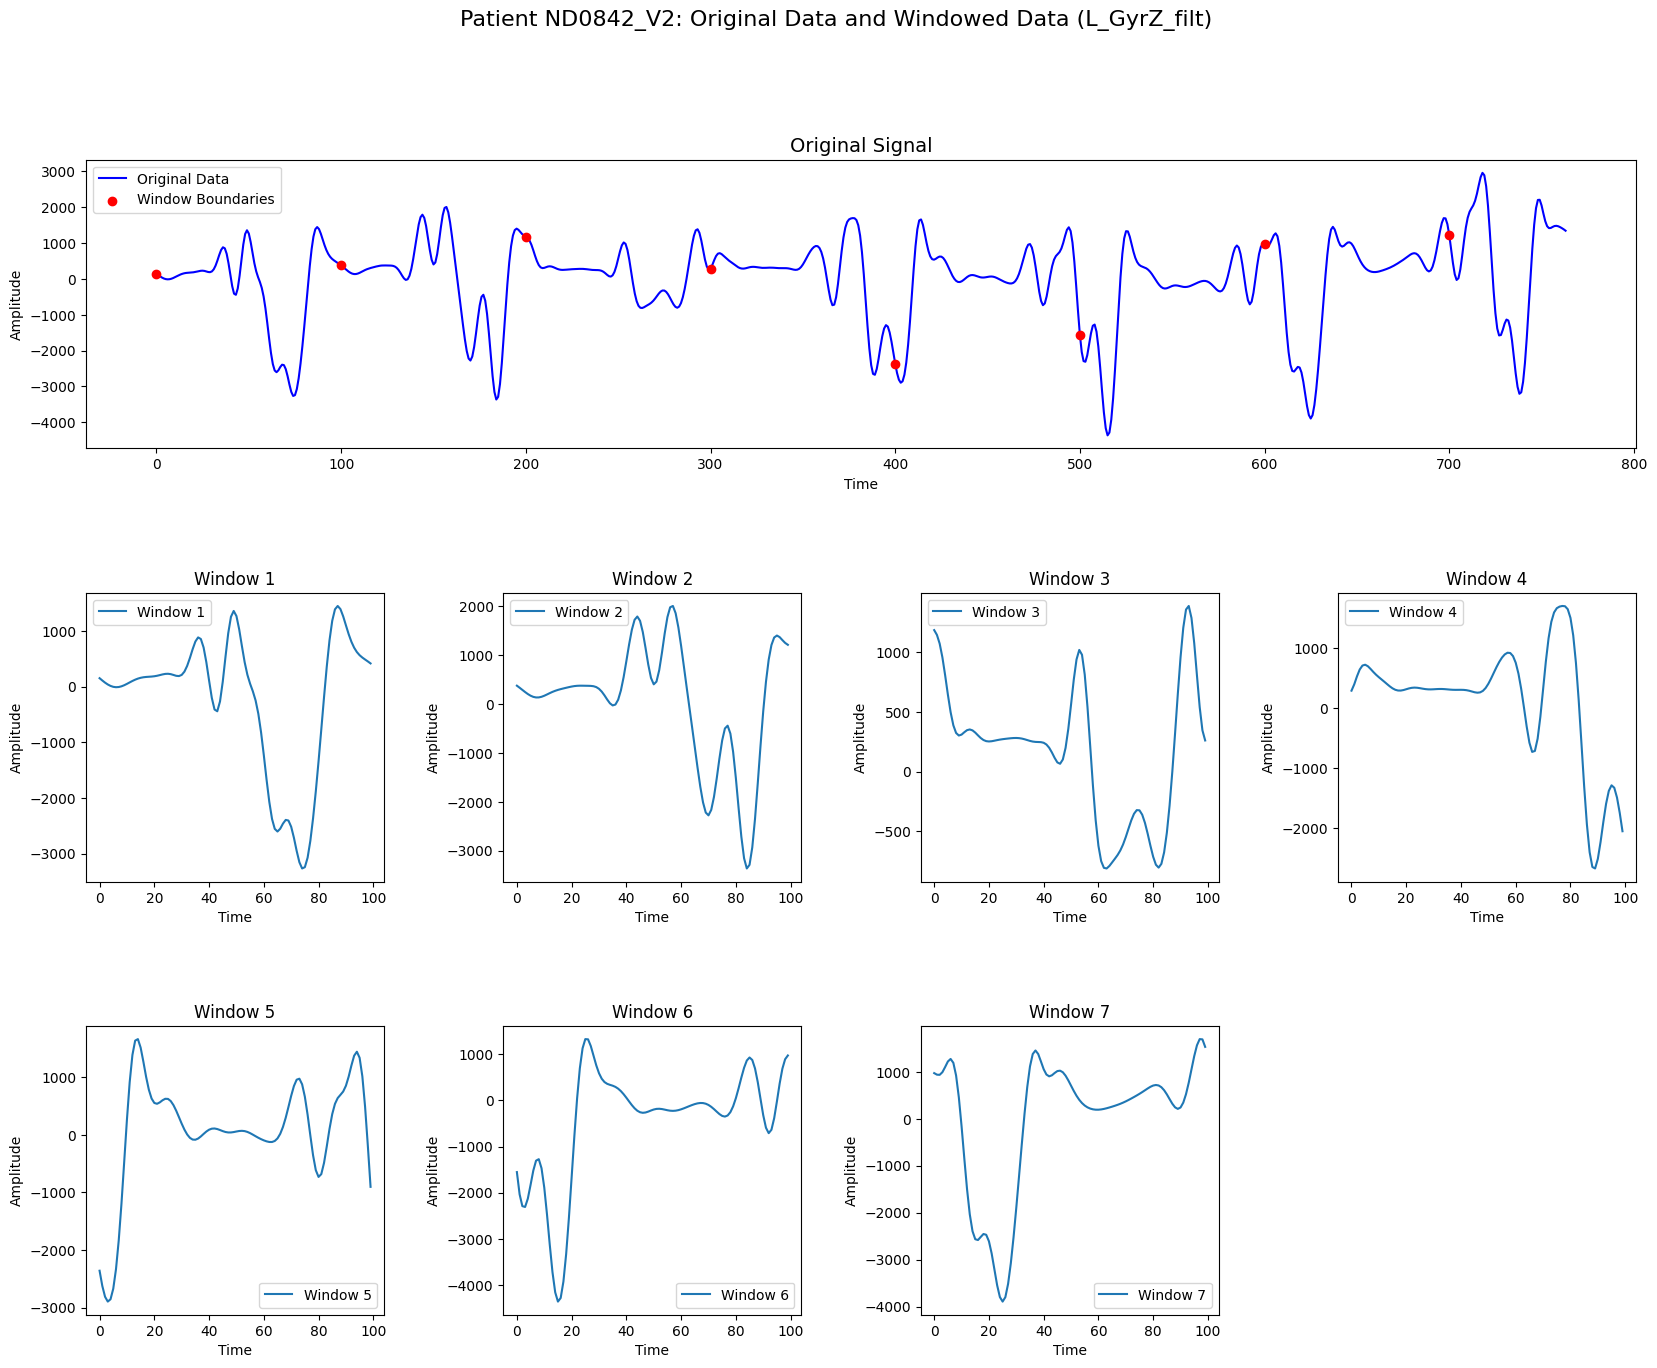

In [24]:
patient_id = 'ND0842_V2'
feature_idx = 5
feature_name = FEATURE_COLUMNS[feature_idx]

original_feature_data = train_data[train_data['SubID'] == patient_id][feature_name].values
windowed_feature_data = X_train[
    [i for i, sub_id in enumerate(train_sub_ids) if sub_id == patient_id], :, feature_idx
]

# Calculate the red dot positions for window boundaries on the original data
window_starts = np.arange(0, len(original_feature_data), 100)  # Start of each window
window_points = original_feature_data[window_starts]  # Values at those points

# Plot the original data (long signal) and its 7 windows in a 3-row layout
fig = plt.figure(figsize=(20, 15))
grid = plt.GridSpec(3, 4, hspace=0.5, wspace=0.4)

# Original data (spanning the entire first row)
ax_original = fig.add_subplot(grid[0, :])
ax_original.plot(original_feature_data, label="Original Data", color='blue')
ax_original.scatter(window_starts, window_points, color='red', label="Window Boundaries", zorder=5)
ax_original.set_title("Original Signal", fontsize=14)
ax_original.set_xlabel("Time")
ax_original.set_ylabel("Amplitude")
ax_original.legend()

# Plot the first 4 windows in the second row
for idx in range(4):
    ax = fig.add_subplot(grid[1, idx])
    ax.plot(windowed_feature_data[idx], label=f"Window {idx + 1}")
    ax.set_title(f"Window {idx + 1}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Amplitude")
    ax.legend()

# Plot the remaining 3 windows in the third row
for idx in range(3):
    ax = fig.add_subplot(grid[2, idx])
    ax.plot(windowed_feature_data[idx + 4], label=f"Window {idx + 5}")
    ax.set_title(f"Window {idx + 5}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Amplitude")
    ax.legend()

# Adjust layout and show the plot
plt.suptitle(f"Patient {patient_id}: Original Data and Windowed Data ({feature_name})", fontsize=16)
plt.show()


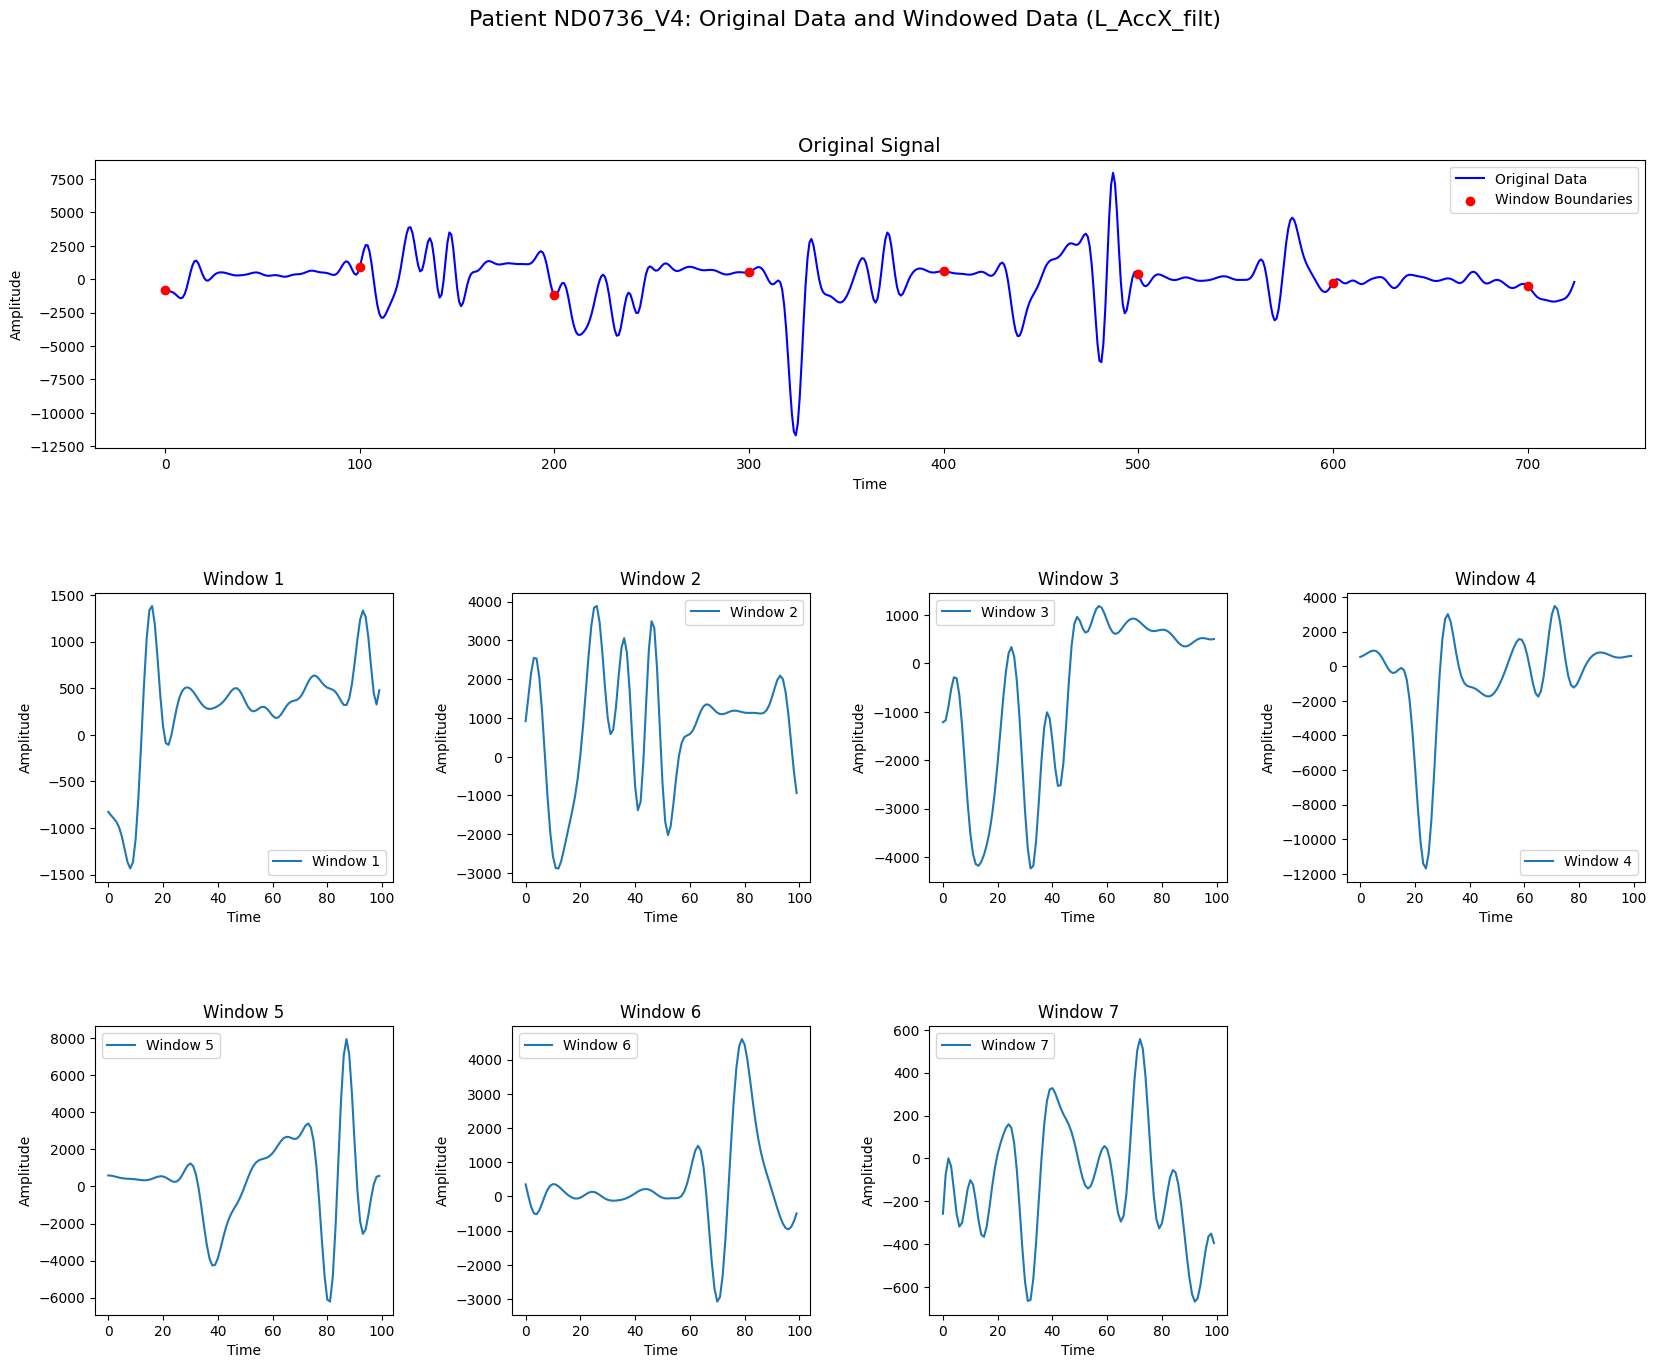

In [25]:
patient_id = 'ND0736_V4'
feature_idx = 0
feature_name = FEATURE_COLUMNS[feature_idx]

original_feature_data = test_data[test_data['SubID'] == patient_id][feature_name].values
windowed_feature_data = X_test[
    [i for i, sub_id in enumerate(test_sub_ids) if sub_id == patient_id], :, feature_idx
]

# Calculate the red dot positions for window boundaries on the original data
window_starts = np.arange(0, len(original_feature_data), 100)  # Start of each window
window_points = original_feature_data[window_starts]  # Values at those points

# Plot the original data (long signal) and its 7 windows in a 3-row layout
fig = plt.figure(figsize=(20, 15))
grid = plt.GridSpec(3, 4, hspace=0.5, wspace=0.4)

# Original data (spanning the entire first row)
ax_original = fig.add_subplot(grid[0, :])
ax_original.plot(original_feature_data, label="Original Data", color='blue')
ax_original.scatter(window_starts, window_points, color='red', label="Window Boundaries", zorder=5)
ax_original.set_title("Original Signal", fontsize=14)
ax_original.set_xlabel("Time")
ax_original.set_ylabel("Amplitude")
ax_original.legend()

# Plot the first 4 windows in the second row
for idx in range(4):
    ax = fig.add_subplot(grid[1, idx])
    ax.plot(windowed_feature_data[idx], label=f"Window {idx + 1}")
    ax.set_title(f"Window {idx + 1}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Amplitude")
    ax.legend()

# Plot the remaining 3 windows in the third row
for idx in range(3):
    ax = fig.add_subplot(grid[2, idx])
    ax.plot(windowed_feature_data[idx + 4], label=f"Window {idx + 5}")
    ax.set_title(f"Window {idx + 5}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Amplitude")
    ax.legend()

# Adjust layout and show the plot
plt.suptitle(f"Patient {patient_id}: Original Data and Windowed Data ({feature_name})", fontsize=16)
plt.show()


In [83]:
# ------------- RESHAPING DATA -------------
X_train_flattened = X_train.reshape(X_train.shape[0], -1)  # Flatten each window (100 * 12)
X_test_flattened = X_test.reshape(X_test.shape[0], -1)    # Flatten each window (100 * 12)

print("X_train_flattened shape:", X_train_flattened.shape)  # (num_train_windows, 1200)
print("X_test_flattened shape:", X_test_flattened.shape)    # (num_test_windows, 1200)

X_train_flattened shape: (1071, 400)
X_test_flattened shape: (261, 400)


In [84]:
# why the model is not learning properly? 
# how ot find peaks of signals per patinet. like finding optimal window size per patient (try different numbers 100, 120, 150m ...).
# what are the parts of signals that give us more information. (maybe it's better to get less signal to feed NN model)
# isolate that parts of signals that igve more information. 
# into 4 labels: low severity, [ like (10-25) maybe jsut check for updrs ]medium, high, very high - (y_trian lables could be done by metadata of patinet , their updrs scores. check the numbers)



Class Weights: {0: np.float64(3.6678082191780823), 1: np.float64(0.5789189189189189)}


c:\Users\35262\.conda\envs\fogenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 128)            │        51,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,649 (233.00 KB)

 Trainable params: 59,649 (233.00 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4587 - loss: 880.9645 
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5707 - loss: 119.8647
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5949 - loss: 97.4390 
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6105 - loss: 56.5861
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5156 - loss: 60.0268
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4910 - loss: 52.1192
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6490 - loss: 27.9150
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6810 - loss: 26.1972
Epoch 9/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6931 - loss: 17.9805
Epoch 10/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5648 - loss: 28.8414
Epoch 11/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7151 - loss: 15.7210
Epoch 12/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - a

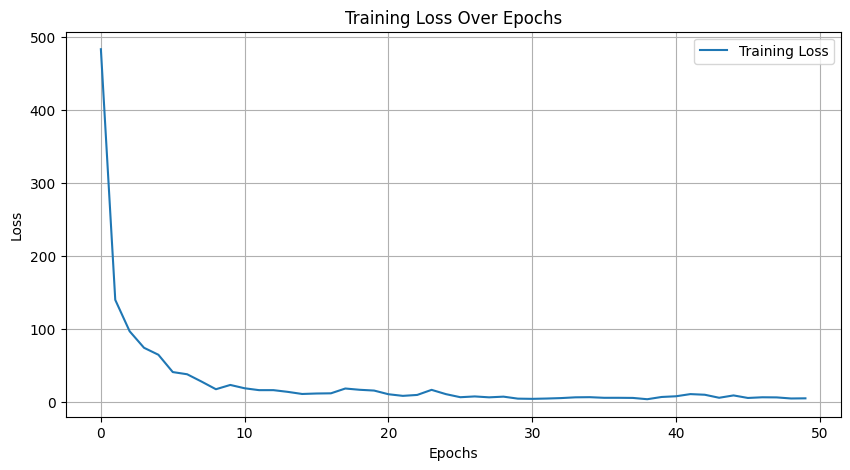

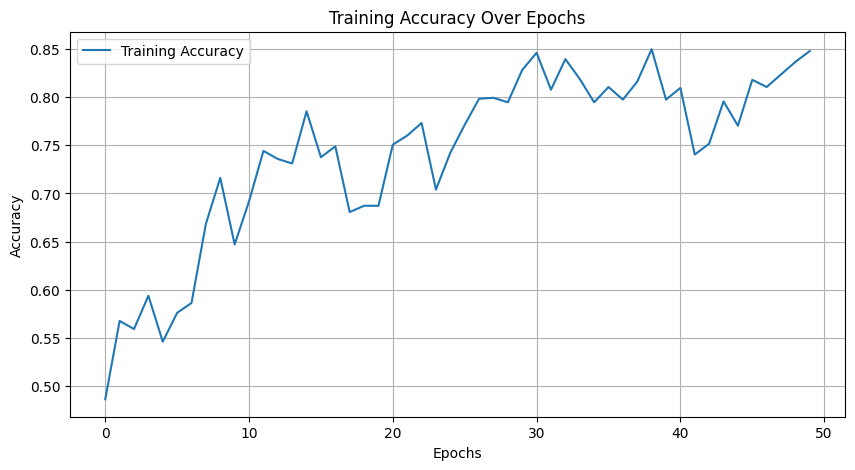

In [85]:
def create_model(input_shape):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,)),  # Input layer with 128 neurons
        Dense(64, activation='relu'),                              # Hidden layer with 64 neurons
        Dense(1, activation='sigmoid')                             # Output layer for binary classification
    ])
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    print(model.summary())
    return model

input_shape = X_train_flattened.shape[1]  # Number of features in the input: 1200

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = {0: class_weights[0], 1: class_weights[1]}  
print("Class Weights:", class_weights)

model = create_model(input_shape)

history = model.fit(
    X_train_flattened, y_train,
    epochs=50,              
    batch_size=32,         
    class_weight=class_weights  
)

loss, accuracy = model.evaluate(X_test_flattened, y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

y_pred_probs = model.predict(X_test_flattened) 
y_pred = (y_pred_probs > 0.5).astype("int32")
  
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot Training Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plot Training Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()


In [87]:
# Transformer Encoder
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

# Build Model
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)  # Binary classification
    return keras.Model(inputs, outputs)

# Define Model Parameters
input_shape = X_train.shape[1:]  
model = build_model(
    input_shape,
    head_size=64,  # Attention head size
    num_heads=2,   # Number of attention heads
    ff_dim=64,     # Feed-forward dimension
    num_transformer_blocks=2,  # Number of transformer blocks
    mlp_units=[64, 32],  # MLP layers
    mlp_dropout=0.3,
    dropout=0.25,
)

# Compile the Model
model.compile(
    loss="binary_crossentropy",  # Binary classification
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["accuracy"],
)

# Summary
model.summary()

# Callbacks
callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

# Train the Model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,  # Validation split from training data
    epochs=50,            # Number of epochs
    batch_size=64,        # Batch size
    callbacks=callbacks,
)

# Evaluate on Test Data
model.evaluate(X_test, y_test, verbose=1)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 100, 4)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 100, 4)    │      2,436 │ input_layer_3[0]… │
│ (MultiHeadAttentio… │                   │            │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 100, 4)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 4)    │          8 │ dropout_9[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 100, 4)    │          0 │ layer_normalizat… │
│                     │                   │            │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 100, 64)   │        320 │ add_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 100, 64)   │          0 │ conv1d_4[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 100, 4)    │        260 │ dropout_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 4)    │          8 │ conv1d_5[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 100, 4)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 100, 4)    │      2,436 │ add_5[0][0],      │
│ (MultiHeadAttentio… │                   │            │ add_5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 100, 4)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 4)    │          8 │ dropout_12[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 100, 4)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 100, 64)   │        320 │ add_6[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 100, 64)   │          0 │ conv1d_6[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 100, 4)    │        260 │ dropout_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 4)    │          8 │ conv1d_7[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 14,641 (57.19 KB)

 Trainable params: 14,641 (57.19 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 13s 133ms/step - accuracy: 0.5406 - loss: 732.8920 - val_accuracy: 0.5070 - val_loss: 872.7044
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.6892 - loss: 458.9706 - val_accuracy: 0.5256 - val_loss: 1320.1753
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.7708 - loss: 274.3640 - val_accuracy: 0.5256 - val_loss: 1606.5398
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.8214 - loss: 227.4529 - val_accuracy: 0.5256 - val_loss: 1766.7747
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.8322 - loss: 243.8908 - val_accuracy: 0.5256 - val_loss: 1820.4183
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.8812 - loss: 218.9195 - val_accuracy: 0.5256 - val_loss: 1811.1530
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.8876 - loss: 154.8844 - val_accuracy: 0.5256 - val_loss: 1754.9240
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.8875 - los

[282.6955871582031, 0.8199234008789062]

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step

Confusion Matrix:
[[  1  37]
 [ 10 213]]

Classification Report:
              precision    recall  f1-score   support

           0       0.09      0.03      0.04        38
           1       0.85      0.96      0.90       223

    accuracy                           0.82       261
   macro avg       0.47      0.49      0.47       261
weighted avg       0.74      0.82      0.78       261



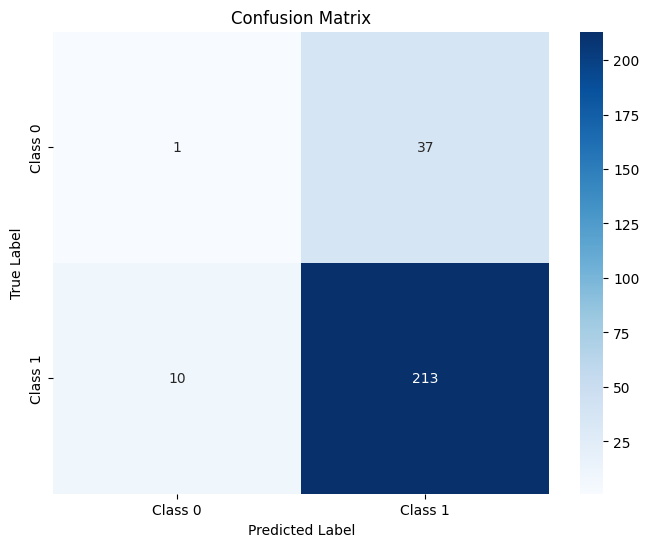

In [88]:
y_pred_probs = model.predict(X_test) 
y_pred = (y_pred_probs > 0.5).astype("int32")  

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

c:\Users\35262\.conda\envs\fogenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │       153,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 162,049 (633.00 KB)

 Trainable params: 162,049 (633.00 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7110 - loss: 361.6825
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8445 - loss: 83.3217
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9400 - loss: 27.4362
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9653 - loss: 11.5502
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9573 - loss: 11.6905
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9660 - loss: 20.9641   
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9572 - loss: 24.3511  
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9539 - loss: 19.8572
Epoch 9/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9622 - loss: 14.0085
Epoch 10/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9771 - loss: 12.8654
Epoch 11/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9563 - loss: 10.6434
Epoch 12/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step -

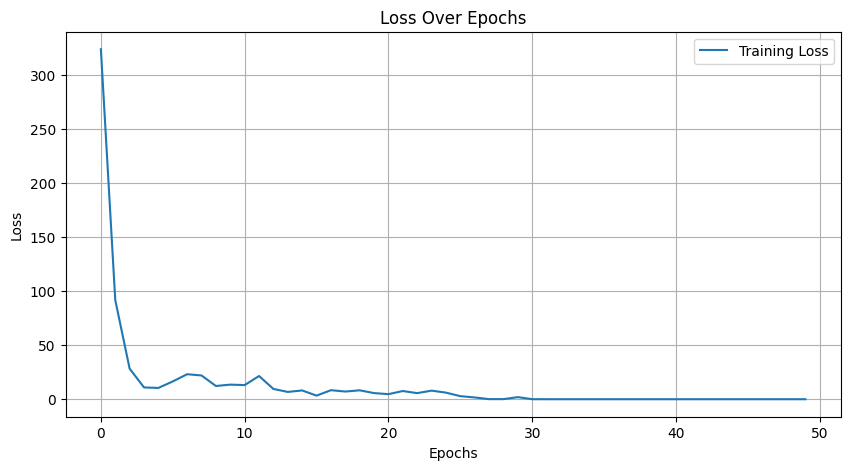

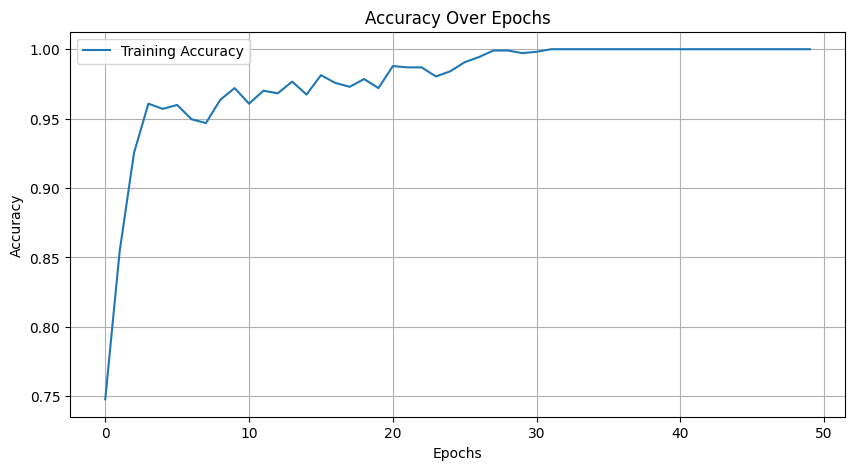

In [26]:
def create_model(input_shape):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,)),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')  # Binary classification
    ])
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    print(model.summary())
    return model


input_shape = X_train_flattened.shape[1]  # 1200 in my case
model = create_model(input_shape)

history = model.fit(
    X_train_flattened, y_train,  
    epochs=50,  
    batch_size=32
)

loss, accuracy = model.evaluate(X_test_flattened, y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

y_pred = (model.predict(X_test_flattened) > 0.5).astype("int32")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()


c:\Users\35262\.conda\envs\fogenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 256)            │       307,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 348,673 (1.33 MB)

 Trainable params: 348,673 (1.33 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7327 - loss: 277.8631
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8637 - loss: 67.2158
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8949 - loss: 26.4322
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8907 - loss: 24.7408
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9348 - loss: 9.4032
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9204 - loss: 11.0323
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9446 - loss: 21.0701
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9506 - loss: 16.6168   
Epoch 9/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9533 - loss: 7.3407
Epoch 10/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9605 - loss: 9.9948
Epoch 11/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9704 - loss: 8.0264
Epoch 12/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accur

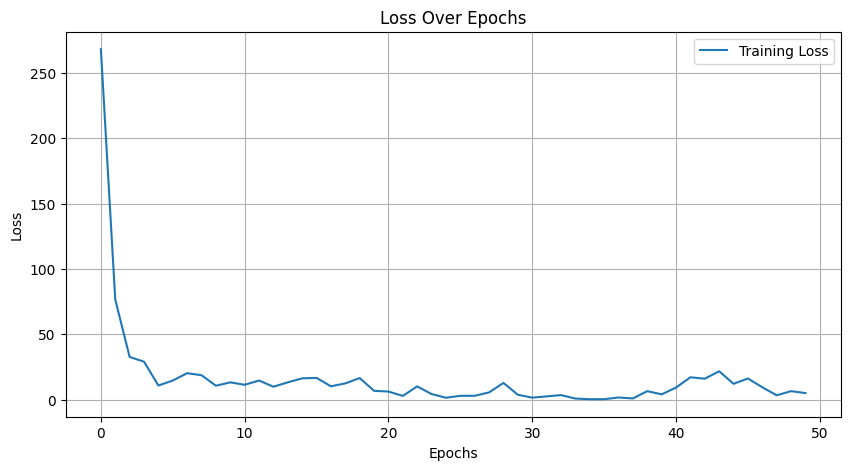

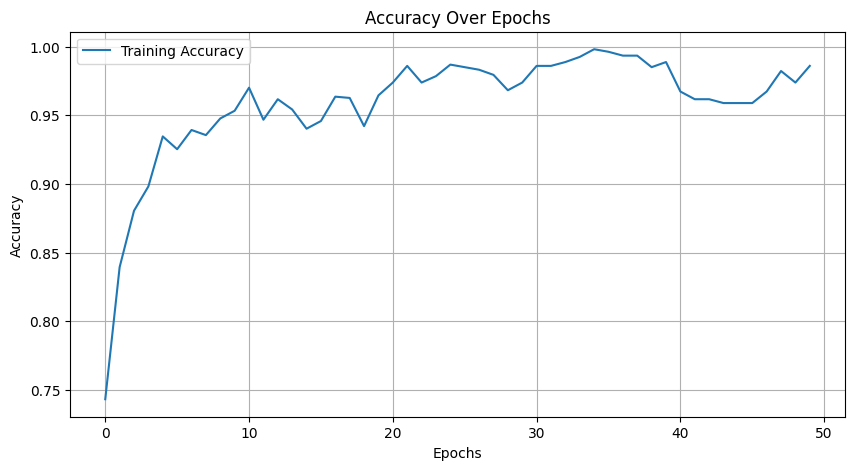

In [28]:
def create_model(input_shape):
    model = Sequential([
        Dense(256, activation='relu', input_shape=(input_shape,)),  # First hidden layer
        Dense(128, activation='relu'),                             # Second hidden layer
        Dense(64, activation='relu'),                              # Third hidden layer
        Dense(1, activation='sigmoid')                             # Output layer
    ])
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    print(model.summary())
    return model


input_shape = X_train_flattened.shape[1]  # 1200 features

model = create_model(input_shape)

history = model.fit(
    X_train_flattened, y_train,
    epochs=50,  
    batch_size=32, 
)

loss, accuracy = model.evaluate(X_test_flattened, y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

y_pred = (model.predict(X_test_flattened) > 0.5).astype("int32")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot Training Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plot Training Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()


c:\Users\35262\.conda\envs\fogenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │       153,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 162,049 (633.00 KB)

 Trainable params: 162,049 (633.00 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7083 - loss: 416.0930 - val_accuracy: 0.6973 - val_loss: 284.4883 - learning_rate: 0.0010
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8649 - loss: 104.6555 - val_accuracy: 0.7280 - val_loss: 251.2528 - learning_rate: 0.0010
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9023 - loss: 38.0076 - val_accuracy: 0.8046 - val_loss: 254.6916 - learning_rate: 0.0010
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9528 - loss: 15.0127 - val_accuracy: 0.7548 - val_loss: 253.7632 - learning_rate: 0.0010
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9682 - loss: 6.9476 - val_accuracy: 0.7739 - val_loss: 220.8067 - learning_rate: 5.0000e-04
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9869 - loss: 1.4506 - val_accuracy: 0.7816 - val_loss: 231.7965 - learning_rate: 5.0000e-04
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9934 

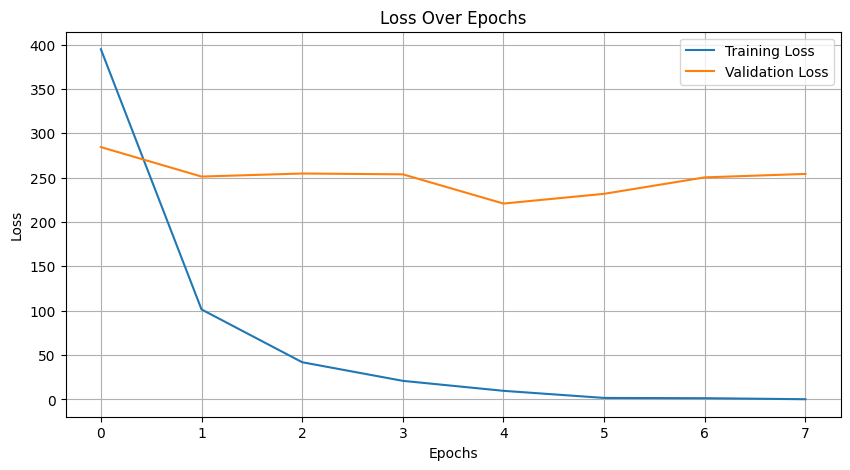

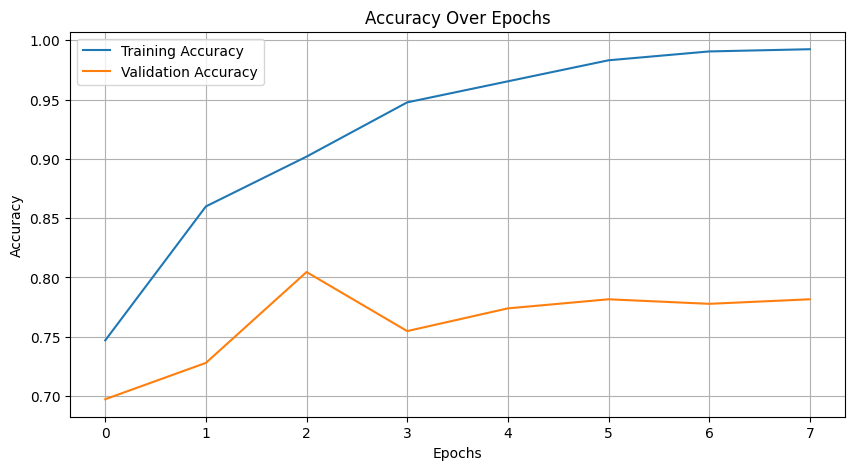

In [25]:
# ------------- NN MODEL -------------

def create_model(input_shape):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,)),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')  # Binary classification
    ])
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    print(model.summary())
    return model

input_shape = X_train_flattened.shape[1]  # 1200 in my case
model = create_model(input_shape)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5)

history = model.fit(
    X_train_flattened, y_train,
    validation_data=(X_test_flattened, y_test),
    epochs=50,  
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)

loss, accuracy = model.evaluate(X_test_flattened, y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

y_pred = (model.predict(X_test_flattened) > 0.5).astype("int32")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()


In [ ]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_flattened.shape[1],)),  # Input: 1200
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification 
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_flattened, y_train, validation_data=(X_test_flattened, y_test), epochs=10, batch_size=32)

loss, accuracy = model.evaluate(X_test_flattened, y_test)
print("Test Accuracy:", accuracy)
